In [1]:
from datetime import timedelta
import cv2
import numpy as np
import os
import pandas as pd 
import math
from decimal import Decimal, getcontext

ModuleNotFoundError: No module named 'cv2'

# Extracting Frames from Videos

In [ ]:
folder_path = 'tremor/4'  # Replace with the path to your folder
base_name = 'tremor_4_'

# List all .mp4 files in the folder
txt_files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]

# Sort the list of mp4 files
txt_files.sort()

# Rename the files sequentially
for i, file_name in enumerate(txt_files, start=1):
    new_name = f'{base_name}{i}-opencv.txt'
    old_path = os.path.join(folder_path, file_name)
    new_path = os.path.join(folder_path, new_name)
    os.rename(old_path, new_path)

print('Files renamed successfully.')

In [ ]:
# i.e if video of duration 30 seconds, saves 10 frame per second = 300 frames saved in total
SAVING_FRAMES_PER_SECOND = 10

def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return (result + ".00").replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

def main(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1

In [ ]:
video_directory = "hand/4" 

video_files = [f for f in os.listdir(video_directory) if f.endswith('.mp4')]

# Process each video using the defined function
for video_file in video_files:
    video_path = os.path.join(video_directory, video_file)
    main(video_path)

# Extracting Signals from Frames

In [ ]:
import mediapipe as mp

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# For static images:
mp_model = mp_hands.Hands(
    static_image_mode=True, # only static images
    max_num_hands=2, # max 2 hands detection
    min_detection_confidence=0.5) # detection confidence

# we are not using tracking confidence as static_image_mode is true.

## Hand Data

In [ ]:
image_directory_layer_1 = "hand"


df_hand = pd.DataFrame(columns=["Folder","File","Distance"])


for folder_name_1 in range(5):
    folder_name_1 = str(folder_name_1)
    folder_dir_1 = os.path.join(image_directory_layer_1, folder_name_1)

    items = os.listdir(folder_dir_1)
    

    image_directory_layers_2 = [item for item in items if os.path.isdir(os.path.join(folder_dir_1, item))]
    image_directory_layers_2.sort()

    for image_directory_layer_2 in image_directory_layers_2:
        
        image_files = []
        image_path_1 = os.path.join(folder_dir_1, image_directory_layer_2)
        for f in os.listdir(image_path_1):
            if f.endswith('.jpg'):
                image_files.append(f)
        
        image_files.sort()

        
        for image_file in image_files:
            image_path_2 = os.path.join(image_path_1, image_file)

            #Function
            image = cv2.imread(image_path_2)
            image = cv2.flip(image, 1)

            results = mp_model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
            # get landmarks from landmarks list and print some of the landmark points and draw on image using mediapipe drawing utilities
            image_height, image_width, c = image.shape # get image shape
            # iterate on all detected hand landmarks

            if results.multi_hand_landmarks is not None:
                for hand_landmarks in results.multi_hand_landmarks:
                # we can get points using mp_hands

                    

                    index_finger_tip_x = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_height
                    index_finger_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height

                    wrist_x = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x * image_height
                    wrist_y = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y * image_height

                    distance_0_8_x = index_finger_tip_x - wrist_x
                    distance_0_8_y = index_finger_tip_y - wrist_y

                    distance_0_8 = math.sqrt((distance_0_8_x ** 2) + (distance_0_8_y ** 2))

                    row = {"Folder": folder_dir_1,
                           "File": image_path_2,
                           "Distance": distance_0_8}
                    
                    print(folder_dir_1)
                    print(image_path_2)
                    print(distance_0_8)
        
                    df_hand = pd.concat([df_hand, pd.DataFrame([row])], ignore_index=True)
                  
df_hand.set_index(["Folder", "File"], inplace=True) 
        
df_hand.sort_values(by="File", inplace=True)
print(df_hand)

In [ ]:
df_hand["rounded_distance"] = df_hand["Distance"].round(2)
print(df_hand["rounded_distance"])

In [ ]:
# Calculate mean and standard deviation
mean_val = np.mean(df_hand["rounded_distance"])
std_val = np.std(df_hand["rounded_distance"])

# Perform standardization
df_hand["standardized_data"] = (df_hand["rounded_distance"] - mean_val) / std_val

In [ ]:
# Define the range for Min-Max scaling (0 to 1 in this case)
min_range = 0
max_range = 1

# Calculate the minimum and maximum values in the column
min_val = df_hand["rounded_distance"].min()
max_val = df_hand["rounded_distance"].max()

# Perform Min-Max scaling
df_hand["minMaxScaled"] = (df_hand["rounded_distance"] - min_val) / (max_val - min_val) * (max_range - min_range) + min_range

In [ ]:
df_hand.sort_values(by="File", inplace=True)

In [ ]:
df_hand.to_csv("combined_hand_data.csv")

## Finger Data

In [ ]:
image_directory_layer_1 = "finger"


df_finger = pd.DataFrame(columns=["Folder","File","Distance"])

for folder_name_1 in range(5):
    folder_name_1 = str(folder_name_1)
    folder_dir_1 = os.path.join(image_directory_layer_1, folder_name_1)

    items = os.listdir(folder_dir_1)
    items.sort()

    image_directory_layers_2 = [item for item in items if os.path.isdir(os.path.join(folder_dir_1, item))]
    image_directory_layers_2.sort()

    for image_directory_layer_2 in image_directory_layers_2:
        image_files = []
        image_path_1 = os.path.join(folder_dir_1, image_directory_layer_2)
        for f in os.listdir(image_path_1):
            if f.endswith('.jpg'):
                image_files.append(f)
        
        image_files.sort()

        
        for image_file in image_files:
            image_path_2 = os.path.join(image_path_1, image_file)

            #Function
            image = cv2.imread(image_path_2)
            image = cv2.flip(image, 1)

            results = mp_model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
            # get landmarks from landmarks list and print some of the landmark points and draw on image using mediapipe drawing utilities
            image_height, image_width, c = image.shape # get image shape
            # iterate on all detected hand landmarks

            if results.multi_hand_landmarks is not None:
                for hand_landmarks in results.multi_hand_landmarks:
                # we can get points using mp_hands

                    thumb_tip_x = hand_landmarks.landmark[mp_hands.HandLandmark(4).value].x * image_width
                    thumb_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark(4).value].y * image_width

                    index_finger_tip_x = hand_landmarks.landmark[mp_hands.HandLandmark(8).value].x * image_height
                    index_finger_tip_y = hand_landmarks.landmark[mp_hands.HandLandmark(8).value].y * image_height

                    distance_of_4_8_x = thumb_tip_x - index_finger_tip_x
                    distance_of_4_8_y = thumb_tip_y - index_finger_tip_y

                    distance_of_4_8 = math.sqrt((distance_of_4_8_x ** 2) + (distance_of_4_8_y ** 2))
                

                    row = {"Folder": folder_dir_1,
                           "File": image_directory_layer_2,
                           "Distance": distance_of_4_8}
                    
                    print(folder_dir_1)
                    print(image_path_2)
                    print(distance_of_4_8)
        
                    df_finger = pd.concat([df_finger, pd.DataFrame([row])], ignore_index=True)
                  
df_finger.set_index(["Folder", "File"], inplace=True)         

print(df_finger)

In [ ]:
df_finger.head()

In [ ]:
df_finger["rounded_Distance"] = df_finger["Distance"].round(2)
print(df_finger["rounded_Distance"])

In [ ]:
# Calculate mean and standard deviation
mean_val = np.mean(df_finger["rounded_Distance"])
std_val = np.std(df_finger["rounded_Distance"])

# Perform standardization
df_finger["standardized_data"] = (df_finger["rounded_Distance"] - mean_val) / std_val

In [ ]:
# Define the range for Min-Max scaling (0 to 1 in this case)
min_range = 0
max_range = 1

# Calculate the minimum and maximum values in the column
min_val = df_finger["rounded_Distance"].min()
max_val = df_finger["rounded_Distance"].max()

# Perform Min-Max scaling
df_finger["minMaxScaled"] = (df_finger["rounded_Distance"] - min_val) / (max_val - min_val) * (max_range - min_range) + min_range

In [ ]:
df_finger.to_csv("combined_finger_data_2.csv")

## Tremor Data

In [ ]:
# Create an empty list to store DataFrames
data_frames_tremor = []

# Define the folder path where the text files are located
folder_path = "tremor"  # Update this with the actual folder path

# Iterate through the folders (0 to 4)
for folder_name in range(5):
    folder_name = str(folder_name)
    folder_dir = os.path.join(folder_path, folder_name)
    
    filenames = os.listdir(folder_dir)
    filenames.sort()    
    # Iterate through the files in each folder
    for filename in os.listdir(folder_dir):
        
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_dir, filename)
            
            # Read the file and skip unnecessary lines
            data_rows = []
            start_reading = False
            with open(file_path, 'r') as file:
                for line in file:
                    if start_reading:
                        columns = line.strip().split('\t')
                        data_rows.append(columns)
                    elif "Time\tX\tY\tZ" in line:
                        start_reading = True
            
            # Convert the data to a DataFrame
            df_tremor = pd.DataFrame(data_rows, columns=["Time", "X", "Y", "Z"])
            
            # Create a multi-index based on folder name and file name
            df_tremor["Folder"] = folder_name
            df_tremor["File"] = filename
            df_tremor.set_index(["Folder", "File"], inplace=True)
            
            # Append the DataFrame to the list
            data_frames_tremor.append(df_tremor)

# Concatenate all the DataFrames in the list
combined_df_tremor = pd.concat(data_frames_tremor)


# Save the combined DataFrame to a CSV file
combined_df_tremor.to_csv("combined_tremor_data.csv")

print("Data from all files has been combined and saved to combined_data.csv.")


# Model

## Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
%config inlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 10

In [3]:
# Step 1: Load the dataset into a Pandas DataFrame
data_tremor = pd.read_csv('combined_tremor_data.csv')

mapping = {0: "0", 1: "1", 2 : "1", 3 : "2", 4 : "2"}
data_tremor["label"] = data_tremor["Folder"].map(mapping)



In [4]:
data_tremor["label"] = data_tremor["label"].astype(int)

## Normalization

In [5]:
data_tremor["X"] = data_tremor["X"].round(4)
data_tremor["Y"] = data_tremor["Y"].round(4)
data_tremor["Z"] = data_tremor["Z"].round(4)


In [6]:
# Define the range for Min-Max scaling (0 to 1 in this case)
min_range = 0
max_range = 1

# Calculate the minimum and maximum values in the column
min_val_x = data_tremor["X"].min()
max_val_x = data_tremor["X"].max()

# Perform Min-Max scaling
data_tremor["X"] = (data_tremor["X"] - min_val_x) / (max_val_x - min_val_x) * (max_range - min_range) + min_range

# Calculate the minimum and maximum values in the column
min_val_x = data_tremor["Y"].min()
max_val_x = data_tremor["Y"].max()

# Perform Min-Max scaling
data_tremor["Y"] = (data_tremor["Y"] - min_val_x) / (max_val_x - min_val_x) * (max_range - min_range) + min_range

# Calculate the minimum and maximum values in the column
min_val_x = data_tremor["Z"].min()
max_val_x = data_tremor["Z"].max()

# Perform Min-Max scaling
data_tremor["Z"] = (data_tremor["Z"] - min_val_x) / (max_val_x - min_val_x) * (max_range - min_range) + min_range



<Axes: xlabel='label'>

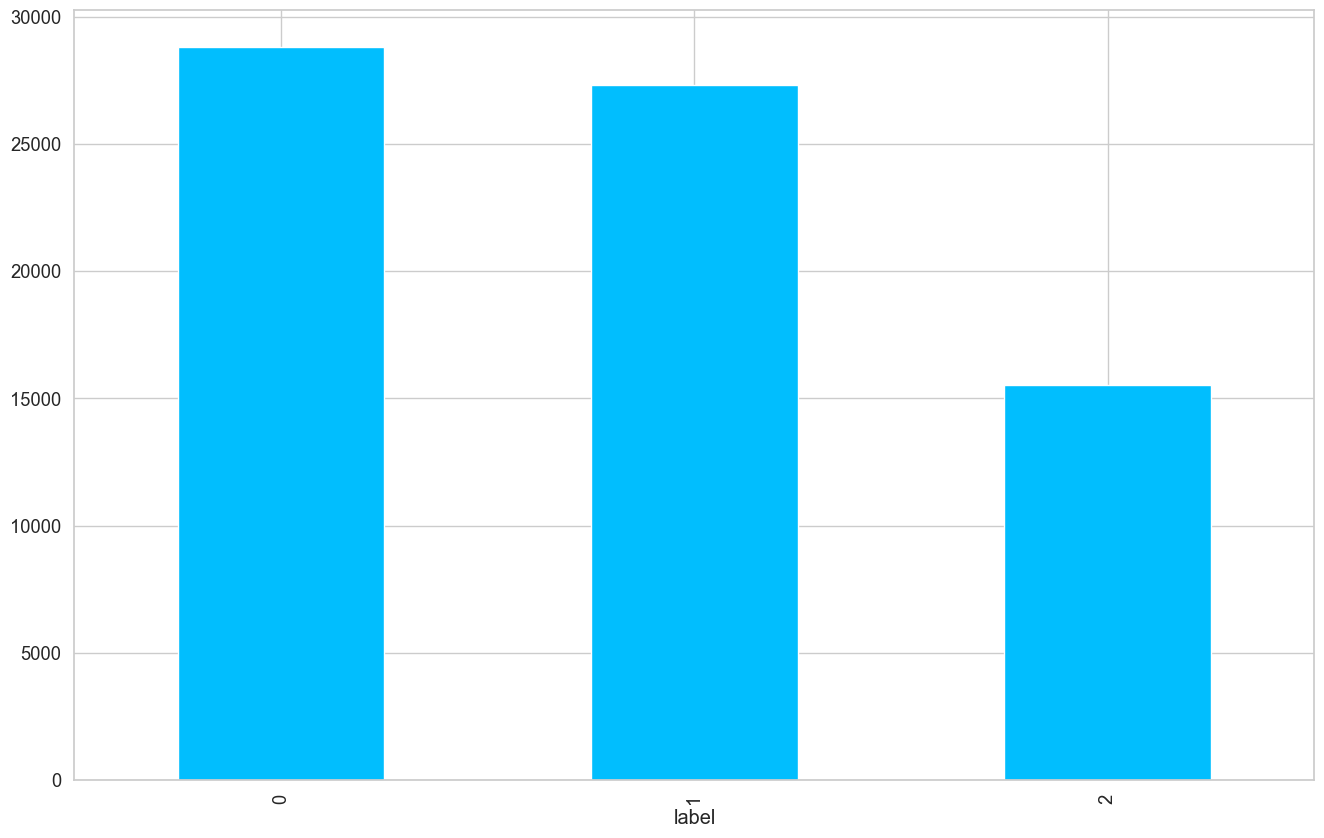

In [7]:
data_tremor.label.value_counts().plot(kind="bar")

In [8]:
length__of_sequence = data_tremor.File.value_counts()
print(length__of_sequence)

File
tremor_1_10-opencv.txt    748
tremor_3_02-opencv.txt    743
tremor_0_15-opencv.txt    743
tremor_1_12-opencv.txt    742
tremor_3_13-opencv.txt    741
                         ... 
tremor_1_19-opencv.txt    736
tremor_2_13-opencv.txt    736
tremor_0_23-opencv.txt    736
tremor_0_29-opencv.txt    734
tremor_2_10-opencv.txt    728
Name: count, Length: 97, dtype: int64


In [9]:
FEATURE_COLUMNS = data_tremor.columns.tolist()[3:6]
FEATURE_COLUMNS

['X', 'Y', 'Z']

In [10]:
train_sequences = []
test_sequences = []

for File, group in data_tremor.groupby('File'):
    sequence_features = group[FEATURE_COLUMNS]
    sequence_features_1 = sequence_features[:180]
    sequence_features_2 = sequence_features[90:270]
    sequence_features_3 = sequence_features[180:360]
    sequence_features_4 = sequence_features[270:450]
    sequence_features_5 = sequence_features[360:540]
    sequence_features_6 = sequence_features[540:720]
    label = data_tremor[data_tremor.File == File].iloc[0].label
    train_sequences.append((sequence_features_1, label))
    train_sequences.append((sequence_features_2, label))
    train_sequences.append((sequence_features_3, label))
    train_sequences.append((sequence_features_4, label))
    train_sequences.append((sequence_features_5, label))
    test_sequences.append((sequence_features_6, label))
    

In [11]:
print(train_sequences)

[(              X         Y         Z
20687  0.621302  0.413540  0.474247
20688  0.642006  0.413540  0.493564
20689  0.642006  0.413540  0.506436
20690  0.639049  0.413540  0.502147
20691  0.644970  0.417297  0.495708
...         ...       ...       ...
20862  0.633136  0.428577  0.489269
20863  0.633136  0.428577  0.491419
20864  0.633136  0.428577  0.493564
20865  0.627216  0.424820  0.487125
20866  0.627216  0.417297  0.491419

[180 rows x 3 columns], 0), (              X         Y         Z
20777  0.618338  0.413540  0.491419
20778  0.621302  0.413540  0.487125
20779  0.627216  0.417297  0.489269
20780  0.627216  0.417297  0.489269
20781  0.627216  0.417297  0.491419
...         ...       ...       ...
20952  0.612425  0.424820  0.495708
20953  0.615382  0.428577  0.489269
20954  0.621302  0.432334  0.489269
20955  0.627216  0.436091  0.489269
20956  0.624259  0.428577  0.489269

[180 rows x 3 columns], 0), (              X         Y         Z
20867  0.618338  0.421054  0.493564
20

In [12]:
max_length = max(len(sequence_features) for sequence_features in train_sequences)
print(max_length)

2


## Dataset

In [13]:
class ParkinsonDataset(Dataset):

    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).long()
        )

In [14]:
class ParkinsonDataModule(pl.LightningDataModule):

    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = ParkinsonDataset(self.train_sequences)
        self.test_dataset = ParkinsonDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
            #num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size,
            shuffle=False
            #num_workers=cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size,
            shuffle=False
            #num_workers=cpu_count()
        )

In [29]:
N_EPOCH = 2250
BATCH_SIZE = 128

data_module = ParkinsonDataModule(train_sequences, test_sequences, BATCH_SIZE)

## Model

In [30]:
class SequenceModel(nn.Module):
    
    def __init__(self, input_size, output_size, cnn_hidden_size=64, transformer_hidden_size=32, num_heads=4, dropout_rate = 0.25):
        super().__init__()

        # CNN Layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_hidden_size, kernel_size=5, padding=1)

        # Transformer layers
        self.transformer = nn.TransformerEncoderLayer(
            d_model=cnn_hidden_size,
            nhead=num_heads,
            dim_feedforward=transformer_hidden_size,
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer, num_layers=2)
        
        # Fully connected layer
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(cnn_hidden_size, 16)
        self.relu = torch.nn.ReLU()
        self.classifier = nn.Linear(16, output_size)


    def forward(self, x):
        
        x = F.relu(self.conv1(x.permute(0, 2, 1)))

        # Permute to (sequence_length, batch_size, features) for transformer
        x = x.permute(2, 0, 1)
        
        x = self.transformer_encoder(x)

        # Take the mean over the sequence length
        x = torch.mean(x, dim=0)

        # Fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

In [31]:
class ParkinsonPredictor(pl.LightningModule):

    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels, task="multiclass", num_classes=3)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels, task="multiclass", num_classes=3)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}   

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels, task="multiclass", num_classes=3)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy} 


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)
    
    

In [32]:
from torchsummary import summary
input_size = 3  # Example input size
output_size = 3  # Example output size
sequence_model = SequenceModel(input_size=input_size, output_size=output_size)

# Print the summary of SequenceModel
summary(sequence_model, (180, input_size))  

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv1d: 1-1                                 [-1, 64, 178]             1,024
├─TransformerEncoder: 1-2                     [-1, 2, 64]               --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderLayer: 3-1      [-1, 2, 64]               21,088
|    |    └─TransformerEncoderLayer: 3-2      [-1, 2, 64]               21,088
├─Dropout: 1-3                                [-1, 64]                  --
├─Linear: 1-4                                 [-1, 16]                  1,040
├─Linear: 1-5                                 [-1, 3]                   51
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
Total mult-adds (M): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.17
Estimated Total Size (MB): 0.26


/Users/muratatceken/opt/anaconda3/envs/murat/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                        Output Shape              Param #
├─Conv1d: 1-1                                 [-1, 64, 178]             1,024
├─TransformerEncoder: 1-2                     [-1, 2, 64]               --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderLayer: 3-1      [-1, 2, 64]               21,088
|    |    └─TransformerEncoderLayer: 3-2      [-1, 2, 64]               21,088
├─Dropout: 1-3                                [-1, 64]                  --
├─Linear: 1-4                                 [-1, 16]                  1,040
├─Linear: 1-5                                 [-1, 3]                   51
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
Total mult-adds (M): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.17
Estimated Total Size (MB): 0.26

In [33]:
input_size = 3
output_size = 3

model = ParkinsonPredictor(
    input_size,
    output_size
)

In [20]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

Launching TensorBoard...

In [34]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
    
)

logger = TensorBoardLogger("lightning_logs", name="label")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCH,
    accelerator="auto", 
    devices="auto"
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(model, data_module)

/Users/muratatceken/opt/anaconda3/envs/murat/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints exists and is not empty.

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 65.4 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
65.4 K    Trainable params
0         Non-trainable params
65.4 K    Total params
0.262     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/muratatceken/opt/anaconda3/envs/murat/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/muratatceken/opt/anaconda3/envs/murat/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/muratatceken/opt/anaconda3/envs/murat/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=1.120, train_accuracy=0.267, val_loss=1.090, val_accuracy=0.381]

Epoch 0, global step 4: 'val_loss' reached 1.09252 (best 1.09252), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=1.090, train_accuracy=0.366, val_loss=1.080, val_accuracy=0.402]

Epoch 1, global step 8: 'val_loss' reached 1.08377 (best 1.08377), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=1.100, train_accuracy=0.386, val_loss=1.080, val_accuracy=0.433]

Epoch 2, global step 12: 'val_loss' reached 1.07681 (best 1.07681), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 3: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=1.080, train_accuracy=0.406, val_loss=1.070, val_accuracy=0.423]

Epoch 3, global step 16: 'val_loss' reached 1.07156 (best 1.07156), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s, v_num=12, train_loss=1.050, train_accuracy=0.446, val_loss=1.070, val_accuracy=0.464]

Epoch 4, global step 20: 'val_loss' reached 1.06790 (best 1.06790), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 5: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=1.080, train_accuracy=0.347, val_loss=1.070, val_accuracy=0.412]

Epoch 5, global step 24: 'val_loss' reached 1.06539 (best 1.06539), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=1.070, train_accuracy=0.426, val_loss=1.060, val_accuracy=0.402]

Epoch 6, global step 28: 'val_loss' reached 1.06408 (best 1.06408), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=1.090, train_accuracy=0.386, val_loss=1.060, val_accuracy=0.402]

Epoch 7, global step 32: 'val_loss' reached 1.06340 (best 1.06340), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 8: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=1.060, train_accuracy=0.386, val_loss=1.060, val_accuracy=0.402]

Epoch 8, global step 36: 'val_loss' reached 1.06295 (best 1.06295), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=1.070, train_accuracy=0.386, val_loss=1.060, val_accuracy=0.402]

Epoch 9, global step 40: 'val_loss' reached 1.06257 (best 1.06257), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=1.050, train_accuracy=0.485, val_loss=1.060, val_accuracy=0.402]

Epoch 10, global step 44: 'val_loss' reached 1.06224 (best 1.06224), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=1.020, train_accuracy=0.465, val_loss=1.060, val_accuracy=0.402]

Epoch 11, global step 48: 'val_loss' reached 1.06184 (best 1.06184), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 12: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=1.040, train_accuracy=0.465, val_loss=1.060, val_accuracy=0.402]

Epoch 12, global step 52: 'val_loss' reached 1.06145 (best 1.06145), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=1.060, train_accuracy=0.406, val_loss=1.060, val_accuracy=0.402]

Epoch 13, global step 56: 'val_loss' reached 1.06105 (best 1.06105), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 14: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s, v_num=12, train_loss=1.080, train_accuracy=0.396, val_loss=1.060, val_accuracy=0.402]

Epoch 14, global step 60: 'val_loss' reached 1.06065 (best 1.06065), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 15: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=1.060, train_accuracy=0.406, val_loss=1.060, val_accuracy=0.402]

Epoch 15, global step 64: 'val_loss' reached 1.06013 (best 1.06013), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 16: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=1.080, train_accuracy=0.455, val_loss=1.060, val_accuracy=0.402]

Epoch 16, global step 68: 'val_loss' reached 1.05964 (best 1.05964), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=1.080, train_accuracy=0.376, val_loss=1.060, val_accuracy=0.423]

Epoch 17, global step 72: 'val_loss' reached 1.05911 (best 1.05911), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 18: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=1.080, train_accuracy=0.455, val_loss=1.060, val_accuracy=0.433]

Epoch 18, global step 76: 'val_loss' reached 1.05860 (best 1.05860), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 19: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=1.020, train_accuracy=0.525, val_loss=1.060, val_accuracy=0.464]

Epoch 19, global step 80: 'val_loss' reached 1.05812 (best 1.05812), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=1.060, train_accuracy=0.396, val_loss=1.060, val_accuracy=0.485]

Epoch 20, global step 84: 'val_loss' reached 1.05768 (best 1.05768), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 21: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=1.050, train_accuracy=0.436, val_loss=1.060, val_accuracy=0.474]

Epoch 21, global step 88: 'val_loss' reached 1.05718 (best 1.05718), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 22: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=1.080, train_accuracy=0.406, val_loss=1.060, val_accuracy=0.485]

Epoch 22, global step 92: 'val_loss' reached 1.05666 (best 1.05666), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=1.060, train_accuracy=0.446, val_loss=1.060, val_accuracy=0.474]

Epoch 23, global step 96: 'val_loss' reached 1.05605 (best 1.05605), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 24: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=1.060, train_accuracy=0.465, val_loss=1.060, val_accuracy=0.505]

Epoch 24, global step 100: 'val_loss' reached 1.05545 (best 1.05545), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 25: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=1.070, train_accuracy=0.505, val_loss=1.050, val_accuracy=0.495]

Epoch 25, global step 104: 'val_loss' reached 1.05484 (best 1.05484), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 26: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=1.040, train_accuracy=0.426, val_loss=1.050, val_accuracy=0.485]

Epoch 26, global step 108: 'val_loss' reached 1.05428 (best 1.05428), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 27: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, v_num=12, train_loss=1.050, train_accuracy=0.436, val_loss=1.050, val_accuracy=0.474]

Epoch 27, global step 112: 'val_loss' reached 1.05364 (best 1.05364), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 28: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=1.070, train_accuracy=0.436, val_loss=1.050, val_accuracy=0.464]

Epoch 28, global step 116: 'val_loss' reached 1.05298 (best 1.05298), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 29: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=1.050, train_accuracy=0.436, val_loss=1.050, val_accuracy=0.464]

Epoch 29, global step 120: 'val_loss' reached 1.05217 (best 1.05217), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 30: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=1.070, train_accuracy=0.446, val_loss=1.050, val_accuracy=0.454]

Epoch 30, global step 124: 'val_loss' reached 1.05163 (best 1.05163), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 31: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=12, train_loss=1.070, train_accuracy=0.436, val_loss=1.050, val_accuracy=0.454]

Epoch 31, global step 128: 'val_loss' reached 1.05103 (best 1.05103), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 32: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=12, train_loss=1.060, train_accuracy=0.436, val_loss=1.050, val_accuracy=0.423]

Epoch 32, global step 132: 'val_loss' reached 1.05030 (best 1.05030), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 33: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=1.070, train_accuracy=0.436, val_loss=1.050, val_accuracy=0.423]

Epoch 33, global step 136: 'val_loss' reached 1.04956 (best 1.04956), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 34: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=12, train_loss=1.010, train_accuracy=0.525, val_loss=1.050, val_accuracy=0.423]

Epoch 34, global step 140: 'val_loss' reached 1.04876 (best 1.04876), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 35: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=1.050, train_accuracy=0.446, val_loss=1.050, val_accuracy=0.443]

Epoch 35, global step 144: 'val_loss' reached 1.04803 (best 1.04803), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 36: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, v_num=12, train_loss=1.060, train_accuracy=0.406, val_loss=1.050, val_accuracy=0.454]

Epoch 36, global step 148: 'val_loss' reached 1.04725 (best 1.04725), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 37: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=1.050, train_accuracy=0.386, val_loss=1.050, val_accuracy=0.443]

Epoch 37, global step 152: 'val_loss' reached 1.04630 (best 1.04630), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 38: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=1.060, train_accuracy=0.485, val_loss=1.050, val_accuracy=0.454]

Epoch 38, global step 156: 'val_loss' reached 1.04524 (best 1.04524), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=1.090, train_accuracy=0.366, val_loss=1.040, val_accuracy=0.423]

Epoch 39, global step 160: 'val_loss' reached 1.04402 (best 1.04402), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 40: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=1.060, train_accuracy=0.475, val_loss=1.040, val_accuracy=0.423]

Epoch 40, global step 164: 'val_loss' reached 1.04266 (best 1.04266), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 41: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=1.010, train_accuracy=0.535, val_loss=1.040, val_accuracy=0.423]

Epoch 41, global step 168: 'val_loss' reached 1.04110 (best 1.04110), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 42: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=1.050, train_accuracy=0.525, val_loss=1.040, val_accuracy=0.433]

Epoch 42, global step 172: 'val_loss' reached 1.03959 (best 1.03959), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 43: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=1.080, train_accuracy=0.317, val_loss=1.040, val_accuracy=0.433]

Epoch 43, global step 176: 'val_loss' reached 1.03786 (best 1.03786), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 44: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=1.000, train_accuracy=0.515, val_loss=1.040, val_accuracy=0.443]

Epoch 44, global step 180: 'val_loss' reached 1.03625 (best 1.03625), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 45: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=1.030, train_accuracy=0.475, val_loss=1.030, val_accuracy=0.454]

Epoch 45, global step 184: 'val_loss' reached 1.03466 (best 1.03466), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 46: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=12, train_loss=1.070, train_accuracy=0.396, val_loss=1.030, val_accuracy=0.454]

Epoch 46, global step 188: 'val_loss' reached 1.03309 (best 1.03309), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 47: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=1.090, train_accuracy=0.396, val_loss=1.030, val_accuracy=0.454]

Epoch 47, global step 192: 'val_loss' reached 1.03129 (best 1.03129), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 48: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=1.040, train_accuracy=0.416, val_loss=1.030, val_accuracy=0.443]

Epoch 48, global step 196: 'val_loss' reached 1.02924 (best 1.02924), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.997, train_accuracy=0.525, val_loss=1.030, val_accuracy=0.454]

Epoch 49, global step 200: 'val_loss' reached 1.02741 (best 1.02741), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 50: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, v_num=12, train_loss=1.030, train_accuracy=0.465, val_loss=1.030, val_accuracy=0.454]

Epoch 50, global step 204: 'val_loss' reached 1.02525 (best 1.02525), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 51: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, v_num=12, train_loss=1.080, train_accuracy=0.366, val_loss=1.020, val_accuracy=0.454]

Epoch 51, global step 208: 'val_loss' reached 1.02322 (best 1.02322), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 52: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, v_num=12, train_loss=1.080, train_accuracy=0.426, val_loss=1.020, val_accuracy=0.464]

Epoch 52, global step 212: 'val_loss' reached 1.02140 (best 1.02140), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 53: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=1.060, train_accuracy=0.495, val_loss=1.020, val_accuracy=0.485]

Epoch 53, global step 216: 'val_loss' reached 1.01897 (best 1.01897), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 54: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=1.050, train_accuracy=0.495, val_loss=1.020, val_accuracy=0.464]

Epoch 54, global step 220: 'val_loss' reached 1.01583 (best 1.01583), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 55: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s, v_num=12, train_loss=1.030, train_accuracy=0.455, val_loss=1.010, val_accuracy=0.474]

Epoch 55, global step 224: 'val_loss' reached 1.01320 (best 1.01320), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 56: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=1.020, train_accuracy=0.485, val_loss=1.010, val_accuracy=0.464]

Epoch 56, global step 228: 'val_loss' reached 1.01075 (best 1.01075), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 57: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=1.020, train_accuracy=0.535, val_loss=1.010, val_accuracy=0.485]

Epoch 57, global step 232: 'val_loss' reached 1.00733 (best 1.00733), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 58: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=1.060, train_accuracy=0.416, val_loss=1.000, val_accuracy=0.505]

Epoch 58, global step 236: 'val_loss' reached 1.00453 (best 1.00453), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 59: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=1.030, train_accuracy=0.465, val_loss=1.000, val_accuracy=0.515]

Epoch 59, global step 240: 'val_loss' reached 1.00171 (best 1.00171), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 60: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=1.010, train_accuracy=0.545, val_loss=0.999, val_accuracy=0.515]

Epoch 60, global step 244: 'val_loss' reached 0.99858 (best 0.99858), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 61: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=1.010, train_accuracy=0.465, val_loss=0.995, val_accuracy=0.505]

Epoch 61, global step 248: 'val_loss' reached 0.99546 (best 0.99546), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 62: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=1.030, train_accuracy=0.446, val_loss=0.993, val_accuracy=0.515]

Epoch 62, global step 252: 'val_loss' reached 0.99257 (best 0.99257), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 63: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s, v_num=12, train_loss=1.010, train_accuracy=0.475, val_loss=0.990, val_accuracy=0.505]

Epoch 63, global step 256: 'val_loss' reached 0.98981 (best 0.98981), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 64: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.984, train_accuracy=0.535, val_loss=0.987, val_accuracy=0.495]

Epoch 64, global step 260: 'val_loss' reached 0.98710 (best 0.98710), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 65: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.997, train_accuracy=0.475, val_loss=0.984, val_accuracy=0.505]

Epoch 65, global step 264: 'val_loss' reached 0.98437 (best 0.98437), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 66: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.984, train_accuracy=0.495, val_loss=0.982, val_accuracy=0.526]

Epoch 66, global step 268: 'val_loss' reached 0.98187 (best 0.98187), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 67: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.997, train_accuracy=0.465, val_loss=0.980, val_accuracy=0.485]

Epoch 67, global step 272: 'val_loss' reached 0.97997 (best 0.97997), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 68: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=12, train_loss=0.986, train_accuracy=0.485, val_loss=0.978, val_accuracy=0.485]

Epoch 68, global step 276: 'val_loss' reached 0.97789 (best 0.97789), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 69: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.995, train_accuracy=0.455, val_loss=0.975, val_accuracy=0.515]

Epoch 69, global step 280: 'val_loss' reached 0.97472 (best 0.97472), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 70: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=1.020, train_accuracy=0.485, val_loss=0.973, val_accuracy=0.515]

Epoch 70, global step 284: 'val_loss' reached 0.97258 (best 0.97258), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 71: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.982, train_accuracy=0.485, val_loss=0.970, val_accuracy=0.495]

Epoch 71, global step 288: 'val_loss' reached 0.97010 (best 0.97010), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 72: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.982, train_accuracy=0.574, val_loss=0.968, val_accuracy=0.505]

Epoch 72, global step 292: 'val_loss' reached 0.96768 (best 0.96768), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 73: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.984, train_accuracy=0.515, val_loss=0.965, val_accuracy=0.505]

Epoch 73, global step 296: 'val_loss' reached 0.96522 (best 0.96522), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 74: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.954, train_accuracy=0.574, val_loss=0.963, val_accuracy=0.505]

Epoch 74, global step 300: 'val_loss' reached 0.96300 (best 0.96300), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 75: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, v_num=12, train_loss=1.050, train_accuracy=0.446, val_loss=0.961, val_accuracy=0.515]

Epoch 75, global step 304: 'val_loss' reached 0.96119 (best 0.96119), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 76: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=1.000, train_accuracy=0.475, val_loss=0.958, val_accuracy=0.485]

Epoch 76, global step 308: 'val_loss' reached 0.95798 (best 0.95798), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 77: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=1.010, train_accuracy=0.525, val_loss=0.958, val_accuracy=0.526]

Epoch 77, global step 312: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.958, train_accuracy=0.505, val_loss=0.953, val_accuracy=0.495]

Epoch 78, global step 316: 'val_loss' reached 0.95315 (best 0.95315), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 79: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.960, train_accuracy=0.465, val_loss=0.951, val_accuracy=0.485]

Epoch 79, global step 320: 'val_loss' reached 0.95072 (best 0.95072), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 80: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=12, train_loss=0.976, train_accuracy=0.485, val_loss=0.949, val_accuracy=0.495]

Epoch 80, global step 324: 'val_loss' reached 0.94898 (best 0.94898), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 81: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.997, train_accuracy=0.495, val_loss=0.946, val_accuracy=0.495]

Epoch 81, global step 328: 'val_loss' reached 0.94641 (best 0.94641), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 82: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.936, train_accuracy=0.545, val_loss=0.944, val_accuracy=0.485]

Epoch 82, global step 332: 'val_loss' reached 0.94414 (best 0.94414), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 83: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=12, train_loss=0.939, train_accuracy=0.485, val_loss=0.942, val_accuracy=0.505]

Epoch 83, global step 336: 'val_loss' reached 0.94214 (best 0.94214), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 84: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.984, train_accuracy=0.465, val_loss=0.940, val_accuracy=0.495]

Epoch 84, global step 340: 'val_loss' reached 0.94023 (best 0.94023), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 85: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=12, train_loss=0.947, train_accuracy=0.525, val_loss=0.938, val_accuracy=0.505]

Epoch 85, global step 344: 'val_loss' reached 0.93796 (best 0.93796), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 86: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.953, train_accuracy=0.495, val_loss=0.936, val_accuracy=0.505]

Epoch 86, global step 348: 'val_loss' reached 0.93588 (best 0.93588), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 87: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.990, train_accuracy=0.455, val_loss=0.933, val_accuracy=0.505]

Epoch 87, global step 352: 'val_loss' reached 0.93347 (best 0.93347), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 88: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=12, train_loss=1.030, train_accuracy=0.386, val_loss=0.931, val_accuracy=0.495]

Epoch 88, global step 356: 'val_loss' reached 0.93137 (best 0.93137), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 89: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=12, train_loss=0.924, train_accuracy=0.604, val_loss=0.932, val_accuracy=0.536]

Epoch 89, global step 360: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, v_num=12, train_loss=0.949, train_accuracy=0.455, val_loss=0.929, val_accuracy=0.505]

Epoch 90, global step 364: 'val_loss' reached 0.92929 (best 0.92929), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 91: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.988, train_accuracy=0.446, val_loss=0.925, val_accuracy=0.526]

Epoch 91, global step 368: 'val_loss' reached 0.92496 (best 0.92496), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 92: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.974, train_accuracy=0.525, val_loss=0.922, val_accuracy=0.495]

Epoch 92, global step 372: 'val_loss' reached 0.92250 (best 0.92250), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 93: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.946, train_accuracy=0.545, val_loss=0.921, val_accuracy=0.505]

Epoch 93, global step 376: 'val_loss' reached 0.92088 (best 0.92088), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 94: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=12, train_loss=0.954, train_accuracy=0.475, val_loss=0.918, val_accuracy=0.505]

Epoch 94, global step 380: 'val_loss' reached 0.91841 (best 0.91841), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 95: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.944, train_accuracy=0.475, val_loss=0.917, val_accuracy=0.526]

Epoch 95, global step 384: 'val_loss' reached 0.91663 (best 0.91663), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 96: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=1.010, train_accuracy=0.386, val_loss=0.914, val_accuracy=0.526]

Epoch 96, global step 388: 'val_loss' reached 0.91384 (best 0.91384), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 97: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=12, train_loss=0.979, train_accuracy=0.446, val_loss=0.914, val_accuracy=0.557]

Epoch 97, global step 392: 'val_loss' reached 0.91353 (best 0.91353), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 98: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.950, train_accuracy=0.436, val_loss=0.909, val_accuracy=0.526]

Epoch 98, global step 396: 'val_loss' reached 0.90943 (best 0.90943), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 99: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.965, train_accuracy=0.525, val_loss=0.908, val_accuracy=0.536]

Epoch 99, global step 400: 'val_loss' reached 0.90755 (best 0.90755), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 100: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s, v_num=12, train_loss=0.954, train_accuracy=0.485, val_loss=0.906, val_accuracy=0.557]

Epoch 100, global step 404: 'val_loss' reached 0.90568 (best 0.90568), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 101: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.936, train_accuracy=0.495, val_loss=0.904, val_accuracy=0.546]

Epoch 101, global step 408: 'val_loss' reached 0.90365 (best 0.90365), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 102: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.963, train_accuracy=0.446, val_loss=0.900, val_accuracy=0.526]

Epoch 102, global step 412: 'val_loss' reached 0.90014 (best 0.90014), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 103: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.920, train_accuracy=0.485, val_loss=0.898, val_accuracy=0.546]

Epoch 103, global step 416: 'val_loss' reached 0.89820 (best 0.89820), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 104: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.913, train_accuracy=0.554, val_loss=0.897, val_accuracy=0.557]

Epoch 104, global step 420: 'val_loss' reached 0.89693 (best 0.89693), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 105: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.909, train_accuracy=0.535, val_loss=0.896, val_accuracy=0.515]

Epoch 105, global step 424: 'val_loss' reached 0.89611 (best 0.89611), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 106: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.904, train_accuracy=0.554, val_loss=0.891, val_accuracy=0.546]

Epoch 106, global step 428: 'val_loss' reached 0.89112 (best 0.89112), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 107: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.935, train_accuracy=0.535, val_loss=0.892, val_accuracy=0.567]

Epoch 107, global step 432: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=1.010, train_accuracy=0.446, val_loss=0.891, val_accuracy=0.526]

Epoch 108, global step 436: 'val_loss' reached 0.89104 (best 0.89104), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 109: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.927, train_accuracy=0.525, val_loss=0.885, val_accuracy=0.567]

Epoch 109, global step 440: 'val_loss' reached 0.88516 (best 0.88516), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 110: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.934, train_accuracy=0.525, val_loss=0.884, val_accuracy=0.536]

Epoch 110, global step 444: 'val_loss' reached 0.88437 (best 0.88437), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 111: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.896, train_accuracy=0.574, val_loss=0.884, val_accuracy=0.526]

Epoch 111, global step 448: 'val_loss' reached 0.88362 (best 0.88362), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 112: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.963, train_accuracy=0.446, val_loss=0.880, val_accuracy=0.526]

Epoch 112, global step 452: 'val_loss' reached 0.88008 (best 0.88008), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 113: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.961, train_accuracy=0.495, val_loss=0.877, val_accuracy=0.567]

Epoch 113, global step 456: 'val_loss' reached 0.87746 (best 0.87746), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 114: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.871, train_accuracy=0.604, val_loss=0.875, val_accuracy=0.546]

Epoch 114, global step 460: 'val_loss' reached 0.87527 (best 0.87527), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 115: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.887, train_accuracy=0.554, val_loss=0.874, val_accuracy=0.536]

Epoch 115, global step 464: 'val_loss' reached 0.87374 (best 0.87374), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 116: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.972, train_accuracy=0.426, val_loss=0.871, val_accuracy=0.557]

Epoch 116, global step 468: 'val_loss' reached 0.87101 (best 0.87101), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 117: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.933, train_accuracy=0.475, val_loss=0.870, val_accuracy=0.546]

Epoch 117, global step 472: 'val_loss' reached 0.87012 (best 0.87012), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 118: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.935, train_accuracy=0.535, val_loss=0.868, val_accuracy=0.557]

Epoch 118, global step 476: 'val_loss' reached 0.86814 (best 0.86814), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 119: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.937, train_accuracy=0.495, val_loss=0.872, val_accuracy=0.526]

Epoch 119, global step 480: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.900, train_accuracy=0.564, val_loss=0.866, val_accuracy=0.546]

Epoch 120, global step 484: 'val_loss' reached 0.86636 (best 0.86636), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 121: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.945, train_accuracy=0.465, val_loss=0.863, val_accuracy=0.536]

Epoch 121, global step 488: 'val_loss' reached 0.86289 (best 0.86289), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 122: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.917, train_accuracy=0.505, val_loss=0.869, val_accuracy=0.526]

Epoch 122, global step 492: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.950, train_accuracy=0.515, val_loss=0.860, val_accuracy=0.557]

Epoch 123, global step 496: 'val_loss' reached 0.85980 (best 0.85980), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 124: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.920, train_accuracy=0.495, val_loss=0.861, val_accuracy=0.567]

Epoch 124, global step 500: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.895, train_accuracy=0.495, val_loss=0.858, val_accuracy=0.536]

Epoch 125, global step 504: 'val_loss' reached 0.85827 (best 0.85827), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 126: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.919, train_accuracy=0.525, val_loss=0.856, val_accuracy=0.557]

Epoch 126, global step 508: 'val_loss' reached 0.85602 (best 0.85602), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 127: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.902, train_accuracy=0.554, val_loss=0.854, val_accuracy=0.557]

Epoch 127, global step 512: 'val_loss' reached 0.85431 (best 0.85431), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 128: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.941, train_accuracy=0.446, val_loss=0.853, val_accuracy=0.536]

Epoch 128, global step 516: 'val_loss' reached 0.85337 (best 0.85337), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 129: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.931, train_accuracy=0.475, val_loss=0.851, val_accuracy=0.546]

Epoch 129, global step 520: 'val_loss' reached 0.85150 (best 0.85150), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 130: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.949, train_accuracy=0.535, val_loss=0.850, val_accuracy=0.557]

Epoch 130, global step 524: 'val_loss' reached 0.84982 (best 0.84982), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 131: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.983, train_accuracy=0.426, val_loss=0.850, val_accuracy=0.557]

Epoch 131, global step 528: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, v_num=12, train_loss=0.904, train_accuracy=0.564, val_loss=0.847, val_accuracy=0.557]

Epoch 132, global step 532: 'val_loss' reached 0.84719 (best 0.84719), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 133: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.938, train_accuracy=0.515, val_loss=0.848, val_accuracy=0.557]

Epoch 133, global step 536: 'val_loss' was not in top 1


Epoch 134: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.976, train_accuracy=0.455, val_loss=0.859, val_accuracy=0.546]

Epoch 134, global step 540: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.938, train_accuracy=0.465, val_loss=0.848, val_accuracy=0.546]

Epoch 135, global step 544: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.893, train_accuracy=0.515, val_loss=0.844, val_accuracy=0.546]

Epoch 136, global step 548: 'val_loss' reached 0.84398 (best 0.84398), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 137: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.899, train_accuracy=0.515, val_loss=0.843, val_accuracy=0.546]

Epoch 137, global step 552: 'val_loss' reached 0.84268 (best 0.84268), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 138: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.906, train_accuracy=0.465, val_loss=0.846, val_accuracy=0.546]

Epoch 138, global step 556: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.878, train_accuracy=0.554, val_loss=0.840, val_accuracy=0.536]

Epoch 139, global step 560: 'val_loss' reached 0.84037 (best 0.84037), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 140: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, v_num=12, train_loss=0.888, train_accuracy=0.495, val_loss=0.839, val_accuracy=0.546]

Epoch 140, global step 564: 'val_loss' reached 0.83940 (best 0.83940), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 141: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=12, train_loss=0.897, train_accuracy=0.535, val_loss=0.838, val_accuracy=0.557]

Epoch 141, global step 568: 'val_loss' reached 0.83786 (best 0.83786), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 142: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=12, train_loss=0.891, train_accuracy=0.495, val_loss=0.837, val_accuracy=0.567]

Epoch 142, global step 572: 'val_loss' reached 0.83680 (best 0.83680), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 143: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=12, train_loss=0.901, train_accuracy=0.485, val_loss=0.838, val_accuracy=0.546]

Epoch 143, global step 576: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=0.883, train_accuracy=0.545, val_loss=0.833, val_accuracy=0.536]

Epoch 144, global step 580: 'val_loss' reached 0.83292 (best 0.83292), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 145: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.887, train_accuracy=0.515, val_loss=0.832, val_accuracy=0.536]

Epoch 145, global step 584: 'val_loss' reached 0.83232 (best 0.83232), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 146: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.947, train_accuracy=0.455, val_loss=0.830, val_accuracy=0.557]

Epoch 146, global step 588: 'val_loss' reached 0.83038 (best 0.83038), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 147: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.876, train_accuracy=0.584, val_loss=0.830, val_accuracy=0.567]

Epoch 147, global step 592: 'val_loss' reached 0.83028 (best 0.83028), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 148: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.889, train_accuracy=0.505, val_loss=0.829, val_accuracy=0.546]

Epoch 148, global step 596: 'val_loss' reached 0.82886 (best 0.82886), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 149: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.938, train_accuracy=0.465, val_loss=0.829, val_accuracy=0.546]

Epoch 149, global step 600: 'val_loss' reached 0.82880 (best 0.82880), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 150: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.945, train_accuracy=0.535, val_loss=0.828, val_accuracy=0.546]

Epoch 150, global step 604: 'val_loss' reached 0.82816 (best 0.82816), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 151: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.843, train_accuracy=0.584, val_loss=0.827, val_accuracy=0.536]

Epoch 151, global step 608: 'val_loss' reached 0.82680 (best 0.82680), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 152: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.877, train_accuracy=0.535, val_loss=0.836, val_accuracy=0.577]

Epoch 152, global step 612: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.928, train_accuracy=0.465, val_loss=0.831, val_accuracy=0.536]

Epoch 153, global step 616: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.888, train_accuracy=0.535, val_loss=0.825, val_accuracy=0.557]

Epoch 154, global step 620: 'val_loss' reached 0.82518 (best 0.82518), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 155: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.892, train_accuracy=0.505, val_loss=0.825, val_accuracy=0.567]

Epoch 155, global step 624: 'val_loss' reached 0.82457 (best 0.82457), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 156: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.874, train_accuracy=0.554, val_loss=0.828, val_accuracy=0.567]

Epoch 156, global step 628: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.824, train_accuracy=0.634, val_loss=0.823, val_accuracy=0.557]

Epoch 157, global step 632: 'val_loss' reached 0.82337 (best 0.82337), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 158: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.906, train_accuracy=0.574, val_loss=0.824, val_accuracy=0.546]

Epoch 158, global step 636: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.868, train_accuracy=0.554, val_loss=0.825, val_accuracy=0.567]

Epoch 159, global step 640: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.875, train_accuracy=0.475, val_loss=0.821, val_accuracy=0.567]

Epoch 160, global step 644: 'val_loss' reached 0.82136 (best 0.82136), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 161: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.865, train_accuracy=0.614, val_loss=0.821, val_accuracy=0.567]

Epoch 161, global step 648: 'val_loss' reached 0.82127 (best 0.82127), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 162: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.872, train_accuracy=0.545, val_loss=0.820, val_accuracy=0.536]

Epoch 162, global step 652: 'val_loss' reached 0.82030 (best 0.82030), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 163: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.929, train_accuracy=0.446, val_loss=0.818, val_accuracy=0.546]

Epoch 163, global step 656: 'val_loss' reached 0.81824 (best 0.81824), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 164: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.919, train_accuracy=0.495, val_loss=0.817, val_accuracy=0.546]

Epoch 164, global step 660: 'val_loss' reached 0.81741 (best 0.81741), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 165: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.900, train_accuracy=0.535, val_loss=0.817, val_accuracy=0.557]

Epoch 165, global step 664: 'val_loss' reached 0.81726 (best 0.81726), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 166: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.875, train_accuracy=0.515, val_loss=0.816, val_accuracy=0.557]

Epoch 166, global step 668: 'val_loss' reached 0.81639 (best 0.81639), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 167: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.951, train_accuracy=0.426, val_loss=0.814, val_accuracy=0.546]

Epoch 167, global step 672: 'val_loss' reached 0.81381 (best 0.81381), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 168: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.865, train_accuracy=0.545, val_loss=0.813, val_accuracy=0.546]

Epoch 168, global step 676: 'val_loss' reached 0.81255 (best 0.81255), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 169: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.846, train_accuracy=0.554, val_loss=0.812, val_accuracy=0.557]

Epoch 169, global step 680: 'val_loss' reached 0.81206 (best 0.81206), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 170: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=12, train_loss=0.841, train_accuracy=0.545, val_loss=0.811, val_accuracy=0.557]

Epoch 170, global step 684: 'val_loss' reached 0.81126 (best 0.81126), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 171: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.900, train_accuracy=0.535, val_loss=0.810, val_accuracy=0.557]

Epoch 171, global step 688: 'val_loss' reached 0.80975 (best 0.80975), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 172: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.890, train_accuracy=0.564, val_loss=0.815, val_accuracy=0.557]

Epoch 172, global step 692: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.887, train_accuracy=0.574, val_loss=0.811, val_accuracy=0.546]

Epoch 173, global step 696: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.786, train_accuracy=0.624, val_loss=0.809, val_accuracy=0.536]

Epoch 174, global step 700: 'val_loss' reached 0.80911 (best 0.80911), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 175: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.894, train_accuracy=0.525, val_loss=0.813, val_accuracy=0.567]

Epoch 175, global step 704: 'val_loss' was not in top 1


Epoch 176: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.832, train_accuracy=0.564, val_loss=0.807, val_accuracy=0.546]

Epoch 176, global step 708: 'val_loss' reached 0.80688 (best 0.80688), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 177: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.810, train_accuracy=0.564, val_loss=0.807, val_accuracy=0.536]

Epoch 177, global step 712: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.979, train_accuracy=0.515, val_loss=0.811, val_accuracy=0.557]

Epoch 178, global step 716: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.885, train_accuracy=0.515, val_loss=0.805, val_accuracy=0.546]

Epoch 179, global step 720: 'val_loss' reached 0.80515 (best 0.80515), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 180: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.836, train_accuracy=0.515, val_loss=0.805, val_accuracy=0.536]

Epoch 180, global step 724: 'val_loss' reached 0.80476 (best 0.80476), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 181: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=12, train_loss=0.807, train_accuracy=0.584, val_loss=0.803, val_accuracy=0.557]

Epoch 181, global step 728: 'val_loss' reached 0.80341 (best 0.80341), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 182: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.840, train_accuracy=0.594, val_loss=0.801, val_accuracy=0.567]

Epoch 182, global step 732: 'val_loss' reached 0.80107 (best 0.80107), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 183: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, v_num=12, train_loss=0.895, train_accuracy=0.465, val_loss=0.801, val_accuracy=0.536]

Epoch 183, global step 736: 'val_loss' reached 0.80063 (best 0.80063), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 184: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.910, train_accuracy=0.584, val_loss=0.801, val_accuracy=0.546]

Epoch 184, global step 740: 'val_loss' was not in top 1


Epoch 185: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.908, train_accuracy=0.475, val_loss=0.800, val_accuracy=0.567]

Epoch 185, global step 744: 'val_loss' reached 0.80032 (best 0.80032), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 186: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.881, train_accuracy=0.525, val_loss=0.799, val_accuracy=0.546]

Epoch 186, global step 748: 'val_loss' reached 0.79890 (best 0.79890), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 187: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.839, train_accuracy=0.594, val_loss=0.799, val_accuracy=0.567]

Epoch 187, global step 752: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.819, train_accuracy=0.604, val_loss=0.797, val_accuracy=0.567]

Epoch 188, global step 756: 'val_loss' reached 0.79675 (best 0.79675), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 189: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.877, train_accuracy=0.515, val_loss=0.798, val_accuracy=0.577]

Epoch 189, global step 760: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.808, train_accuracy=0.594, val_loss=0.796, val_accuracy=0.567]

Epoch 190, global step 764: 'val_loss' reached 0.79561 (best 0.79561), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 191: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.877, train_accuracy=0.554, val_loss=0.795, val_accuracy=0.557]

Epoch 191, global step 768: 'val_loss' reached 0.79496 (best 0.79496), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 192: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.900, train_accuracy=0.554, val_loss=0.795, val_accuracy=0.557]

Epoch 192, global step 772: 'val_loss' reached 0.79459 (best 0.79459), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 193: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.792, train_accuracy=0.594, val_loss=0.795, val_accuracy=0.577]

Epoch 193, global step 776: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.861, train_accuracy=0.545, val_loss=0.796, val_accuracy=0.577]

Epoch 194, global step 780: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.762, train_accuracy=0.614, val_loss=0.793, val_accuracy=0.567]

Epoch 195, global step 784: 'val_loss' reached 0.79296 (best 0.79296), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 196: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.787, train_accuracy=0.594, val_loss=0.793, val_accuracy=0.577]

Epoch 196, global step 788: 'val_loss' reached 0.79292 (best 0.79292), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 197: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.860, train_accuracy=0.535, val_loss=0.794, val_accuracy=0.567]

Epoch 197, global step 792: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.827, train_accuracy=0.545, val_loss=0.792, val_accuracy=0.577]

Epoch 198, global step 796: 'val_loss' reached 0.79168 (best 0.79168), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 199: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.872, train_accuracy=0.564, val_loss=0.792, val_accuracy=0.588]

Epoch 199, global step 800: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.867, train_accuracy=0.545, val_loss=0.802, val_accuracy=0.557]

Epoch 200, global step 804: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.849, train_accuracy=0.525, val_loss=0.791, val_accuracy=0.567]

Epoch 201, global step 808: 'val_loss' reached 0.79067 (best 0.79067), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 202: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.801, train_accuracy=0.584, val_loss=0.792, val_accuracy=0.577]

Epoch 202, global step 812: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.926, train_accuracy=0.554, val_loss=0.791, val_accuracy=0.577]

Epoch 203, global step 816: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=12, train_loss=0.827, train_accuracy=0.584, val_loss=0.790, val_accuracy=0.608]

Epoch 204, global step 820: 'val_loss' reached 0.79033 (best 0.79033), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 205: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.817, train_accuracy=0.653, val_loss=0.801, val_accuracy=0.567]

Epoch 205, global step 824: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, v_num=12, train_loss=0.805, train_accuracy=0.604, val_loss=0.788, val_accuracy=0.598]

Epoch 206, global step 828: 'val_loss' reached 0.78820 (best 0.78820), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 207: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, v_num=12, train_loss=0.861, train_accuracy=0.545, val_loss=0.787, val_accuracy=0.598]

Epoch 207, global step 832: 'val_loss' reached 0.78728 (best 0.78728), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 208: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.830, train_accuracy=0.554, val_loss=0.794, val_accuracy=0.557]

Epoch 208, global step 836: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.843, train_accuracy=0.545, val_loss=0.785, val_accuracy=0.588]

Epoch 209, global step 840: 'val_loss' reached 0.78475 (best 0.78475), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 210: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, v_num=12, train_loss=0.819, train_accuracy=0.594, val_loss=0.788, val_accuracy=0.567]

Epoch 210, global step 844: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.868, train_accuracy=0.574, val_loss=0.785, val_accuracy=0.588]

Epoch 211, global step 848: 'val_loss' was not in top 1


Epoch 212: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.884, train_accuracy=0.446, val_loss=0.785, val_accuracy=0.588]

Epoch 212, global step 852: 'val_loss' was not in top 1


Epoch 213: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.862, train_accuracy=0.624, val_loss=0.795, val_accuracy=0.567]

Epoch 213, global step 856: 'val_loss' was not in top 1


Epoch 214: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.817, train_accuracy=0.564, val_loss=0.782, val_accuracy=0.598]

Epoch 214, global step 860: 'val_loss' reached 0.78183 (best 0.78183), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 215: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, v_num=12, train_loss=0.886, train_accuracy=0.525, val_loss=0.784, val_accuracy=0.567]

Epoch 215, global step 864: 'val_loss' was not in top 1


Epoch 216: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.776, train_accuracy=0.584, val_loss=0.781, val_accuracy=0.608]

Epoch 216, global step 868: 'val_loss' reached 0.78107 (best 0.78107), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 217: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.827, train_accuracy=0.614, val_loss=0.782, val_accuracy=0.577]

Epoch 217, global step 872: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.839, train_accuracy=0.634, val_loss=0.779, val_accuracy=0.577]

Epoch 218, global step 876: 'val_loss' reached 0.77935 (best 0.77935), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 219: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.893, train_accuracy=0.495, val_loss=0.779, val_accuracy=0.588]

Epoch 219, global step 880: 'val_loss' reached 0.77874 (best 0.77874), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 220: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.818, train_accuracy=0.604, val_loss=0.786, val_accuracy=0.588]

Epoch 220, global step 884: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.826, train_accuracy=0.624, val_loss=0.778, val_accuracy=0.608]

Epoch 221, global step 888: 'val_loss' reached 0.77772 (best 0.77772), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 222: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.816, train_accuracy=0.584, val_loss=0.788, val_accuracy=0.577]

Epoch 222, global step 892: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.836, train_accuracy=0.564, val_loss=0.778, val_accuracy=0.598]

Epoch 223, global step 896: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.846, train_accuracy=0.554, val_loss=0.776, val_accuracy=0.619]

Epoch 224, global step 900: 'val_loss' reached 0.77582 (best 0.77582), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 225: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.840, train_accuracy=0.574, val_loss=0.779, val_accuracy=0.567]

Epoch 225, global step 904: 'val_loss' was not in top 1


Epoch 226: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.793, train_accuracy=0.624, val_loss=0.779, val_accuracy=0.577]

Epoch 226, global step 908: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.829, train_accuracy=0.604, val_loss=0.773, val_accuracy=0.577]

Epoch 227, global step 912: 'val_loss' reached 0.77293 (best 0.77293), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 228: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, v_num=12, train_loss=0.787, train_accuracy=0.604, val_loss=0.782, val_accuracy=0.567]

Epoch 228, global step 916: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=12, train_loss=0.786, train_accuracy=0.604, val_loss=0.773, val_accuracy=0.608]

Epoch 229, global step 920: 'val_loss' was not in top 1


Epoch 230: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.823, train_accuracy=0.545, val_loss=0.773, val_accuracy=0.577]

Epoch 230, global step 924: 'val_loss' reached 0.77261 (best 0.77261), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 231: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, v_num=12, train_loss=0.831, train_accuracy=0.584, val_loss=0.775, val_accuracy=0.577]

Epoch 231, global step 928: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.837, train_accuracy=0.574, val_loss=0.769, val_accuracy=0.608]

Epoch 232, global step 932: 'val_loss' reached 0.76869 (best 0.76869), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 233: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=12, train_loss=0.778, train_accuracy=0.614, val_loss=0.768, val_accuracy=0.598]

Epoch 233, global step 936: 'val_loss' reached 0.76787 (best 0.76787), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 234: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.773, train_accuracy=0.594, val_loss=0.775, val_accuracy=0.567]

Epoch 234, global step 940: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.804, train_accuracy=0.525, val_loss=0.766, val_accuracy=0.598]

Epoch 235, global step 944: 'val_loss' reached 0.76622 (best 0.76622), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 236: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.827, train_accuracy=0.584, val_loss=0.768, val_accuracy=0.588]

Epoch 236, global step 948: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.765, train_accuracy=0.604, val_loss=0.763, val_accuracy=0.608]

Epoch 237, global step 952: 'val_loss' reached 0.76299 (best 0.76299), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 238: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.751, train_accuracy=0.604, val_loss=0.767, val_accuracy=0.577]

Epoch 238, global step 956: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.858, train_accuracy=0.545, val_loss=0.762, val_accuracy=0.608]

Epoch 239, global step 960: 'val_loss' reached 0.76229 (best 0.76229), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 240: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.771, train_accuracy=0.554, val_loss=0.760, val_accuracy=0.608]

Epoch 240, global step 964: 'val_loss' reached 0.76004 (best 0.76004), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 241: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=12, train_loss=0.826, train_accuracy=0.574, val_loss=0.761, val_accuracy=0.598]

Epoch 241, global step 968: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.738, train_accuracy=0.663, val_loss=0.761, val_accuracy=0.598]

Epoch 242, global step 972: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.815, train_accuracy=0.604, val_loss=0.762, val_accuracy=0.588]

Epoch 243, global step 976: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.799, train_accuracy=0.624, val_loss=0.757, val_accuracy=0.608]

Epoch 244, global step 980: 'val_loss' reached 0.75733 (best 0.75733), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 245: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=12, train_loss=0.778, train_accuracy=0.614, val_loss=0.762, val_accuracy=0.588]

Epoch 245, global step 984: 'val_loss' was not in top 1


Epoch 246: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.749, train_accuracy=0.614, val_loss=0.756, val_accuracy=0.608]

Epoch 246, global step 988: 'val_loss' reached 0.75643 (best 0.75643), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 247: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, v_num=12, train_loss=0.875, train_accuracy=0.564, val_loss=0.760, val_accuracy=0.598]

Epoch 247, global step 992: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.792, train_accuracy=0.614, val_loss=0.757, val_accuracy=0.608]

Epoch 248, global step 996: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.828, train_accuracy=0.554, val_loss=0.757, val_accuracy=0.598]

Epoch 249, global step 1000: 'val_loss' was not in top 1


Epoch 250: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.800, train_accuracy=0.604, val_loss=0.755, val_accuracy=0.588]

Epoch 250, global step 1004: 'val_loss' reached 0.75545 (best 0.75545), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 251: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.803, train_accuracy=0.554, val_loss=0.754, val_accuracy=0.598]

Epoch 251, global step 1008: 'val_loss' reached 0.75447 (best 0.75447), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 252: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.795, train_accuracy=0.624, val_loss=0.754, val_accuracy=0.598]

Epoch 252, global step 1012: 'val_loss' reached 0.75369 (best 0.75369), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 253: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.798, train_accuracy=0.624, val_loss=0.750, val_accuracy=0.619]

Epoch 253, global step 1016: 'val_loss' reached 0.75049 (best 0.75049), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 254: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.851, train_accuracy=0.554, val_loss=0.748, val_accuracy=0.588]

Epoch 254, global step 1020: 'val_loss' reached 0.74753 (best 0.74753), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 255: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.736, train_accuracy=0.644, val_loss=0.758, val_accuracy=0.608]

Epoch 255, global step 1024: 'val_loss' was not in top 1


Epoch 256: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.760, train_accuracy=0.604, val_loss=0.748, val_accuracy=0.588]

Epoch 256, global step 1028: 'val_loss' was not in top 1


Epoch 257: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.782, train_accuracy=0.634, val_loss=0.750, val_accuracy=0.598]

Epoch 257, global step 1032: 'val_loss' was not in top 1


Epoch 258: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.810, train_accuracy=0.614, val_loss=0.750, val_accuracy=0.608]

Epoch 258, global step 1036: 'val_loss' was not in top 1


Epoch 259: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.781, train_accuracy=0.584, val_loss=0.743, val_accuracy=0.598]

Epoch 259, global step 1040: 'val_loss' reached 0.74338 (best 0.74338), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 260: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.766, train_accuracy=0.644, val_loss=0.751, val_accuracy=0.619]

Epoch 260, global step 1044: 'val_loss' was not in top 1


Epoch 261: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.837, train_accuracy=0.564, val_loss=0.740, val_accuracy=0.598]

Epoch 261, global step 1048: 'val_loss' reached 0.73956 (best 0.73956), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 262: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, v_num=12, train_loss=0.752, train_accuracy=0.614, val_loss=0.750, val_accuracy=0.619]

Epoch 262, global step 1052: 'val_loss' was not in top 1


Epoch 263: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.799, train_accuracy=0.614, val_loss=0.741, val_accuracy=0.588]

Epoch 263, global step 1056: 'val_loss' was not in top 1


Epoch 264: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.812, train_accuracy=0.614, val_loss=0.740, val_accuracy=0.608]

Epoch 264, global step 1060: 'val_loss' was not in top 1


Epoch 265: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.770, train_accuracy=0.614, val_loss=0.750, val_accuracy=0.629]

Epoch 265, global step 1064: 'val_loss' was not in top 1


Epoch 266: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.828, train_accuracy=0.525, val_loss=0.737, val_accuracy=0.588]

Epoch 266, global step 1068: 'val_loss' reached 0.73685 (best 0.73685), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 267: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.801, train_accuracy=0.574, val_loss=0.745, val_accuracy=0.629]

Epoch 267, global step 1072: 'val_loss' was not in top 1


Epoch 268: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.797, train_accuracy=0.604, val_loss=0.736, val_accuracy=0.608]

Epoch 268, global step 1076: 'val_loss' reached 0.73635 (best 0.73635), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 269: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, v_num=12, train_loss=0.764, train_accuracy=0.604, val_loss=0.742, val_accuracy=0.629]

Epoch 269, global step 1080: 'val_loss' was not in top 1


Epoch 270: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.787, train_accuracy=0.653, val_loss=0.736, val_accuracy=0.608]

Epoch 270, global step 1084: 'val_loss' reached 0.73624 (best 0.73624), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 271: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, v_num=12, train_loss=0.894, train_accuracy=0.525, val_loss=0.732, val_accuracy=0.588]

Epoch 271, global step 1088: 'val_loss' reached 0.73155 (best 0.73155), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 272: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.770, train_accuracy=0.634, val_loss=0.756, val_accuracy=0.639]

Epoch 272, global step 1092: 'val_loss' was not in top 1


Epoch 273: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.808, train_accuracy=0.574, val_loss=0.737, val_accuracy=0.629]

Epoch 273, global step 1096: 'val_loss' was not in top 1


Epoch 274: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.803, train_accuracy=0.545, val_loss=0.734, val_accuracy=0.608]

Epoch 274, global step 1100: 'val_loss' was not in top 1


Epoch 275: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.759, train_accuracy=0.634, val_loss=0.749, val_accuracy=0.639]

Epoch 275, global step 1104: 'val_loss' was not in top 1


Epoch 276: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.755, train_accuracy=0.653, val_loss=0.728, val_accuracy=0.598]

Epoch 276, global step 1108: 'val_loss' reached 0.72802 (best 0.72802), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 277: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=0.782, train_accuracy=0.624, val_loss=0.745, val_accuracy=0.639]

Epoch 277, global step 1112: 'val_loss' was not in top 1


Epoch 278: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=12, train_loss=0.758, train_accuracy=0.604, val_loss=0.725, val_accuracy=0.588]

Epoch 278, global step 1116: 'val_loss' reached 0.72527 (best 0.72527), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 279: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.726, train_accuracy=0.644, val_loss=0.741, val_accuracy=0.629]

Epoch 279, global step 1120: 'val_loss' was not in top 1


Epoch 280: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.729, train_accuracy=0.683, val_loss=0.732, val_accuracy=0.619]

Epoch 280, global step 1124: 'val_loss' was not in top 1


Epoch 281: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.770, train_accuracy=0.634, val_loss=0.726, val_accuracy=0.588]

Epoch 281, global step 1128: 'val_loss' was not in top 1


Epoch 282: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.787, train_accuracy=0.604, val_loss=0.760, val_accuracy=0.629]

Epoch 282, global step 1132: 'val_loss' was not in top 1


Epoch 283: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.671, train_accuracy=0.733, val_loss=0.723, val_accuracy=0.598]

Epoch 283, global step 1136: 'val_loss' reached 0.72301 (best 0.72301), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 284: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.749, train_accuracy=0.624, val_loss=0.738, val_accuracy=0.608]

Epoch 284, global step 1140: 'val_loss' was not in top 1


Epoch 285: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.803, train_accuracy=0.663, val_loss=0.720, val_accuracy=0.588]

Epoch 285, global step 1144: 'val_loss' reached 0.71995 (best 0.71995), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 286: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.703, train_accuracy=0.713, val_loss=0.741, val_accuracy=0.649]

Epoch 286, global step 1148: 'val_loss' was not in top 1


Epoch 287: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.811, train_accuracy=0.584, val_loss=0.719, val_accuracy=0.588]

Epoch 287, global step 1152: 'val_loss' reached 0.71931 (best 0.71931), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 288: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=12, train_loss=0.743, train_accuracy=0.614, val_loss=0.725, val_accuracy=0.619]

Epoch 288, global step 1156: 'val_loss' was not in top 1


Epoch 289: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.839, train_accuracy=0.584, val_loss=0.719, val_accuracy=0.608]

Epoch 289, global step 1160: 'val_loss' reached 0.71860 (best 0.71860), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 290: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.731, train_accuracy=0.644, val_loss=0.723, val_accuracy=0.619]

Epoch 290, global step 1164: 'val_loss' was not in top 1


Epoch 291: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.743, train_accuracy=0.614, val_loss=0.715, val_accuracy=0.608]

Epoch 291, global step 1168: 'val_loss' reached 0.71504 (best 0.71504), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 292: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.864, train_accuracy=0.545, val_loss=0.722, val_accuracy=0.619]

Epoch 292, global step 1172: 'val_loss' was not in top 1


Epoch 293: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.794, train_accuracy=0.604, val_loss=0.725, val_accuracy=0.598]

Epoch 293, global step 1176: 'val_loss' was not in top 1


Epoch 294: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.833, train_accuracy=0.634, val_loss=0.719, val_accuracy=0.608]

Epoch 294, global step 1180: 'val_loss' was not in top 1


Epoch 295: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.718, train_accuracy=0.673, val_loss=0.708, val_accuracy=0.619]

Epoch 295, global step 1184: 'val_loss' reached 0.70839 (best 0.70839), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 296: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.808, train_accuracy=0.554, val_loss=0.738, val_accuracy=0.619]

Epoch 296, global step 1188: 'val_loss' was not in top 1


Epoch 297: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.759, train_accuracy=0.644, val_loss=0.710, val_accuracy=0.608]

Epoch 297, global step 1192: 'val_loss' was not in top 1


Epoch 298: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.689, train_accuracy=0.703, val_loss=0.763, val_accuracy=0.598]

Epoch 298, global step 1196: 'val_loss' was not in top 1


Epoch 299: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, v_num=12, train_loss=0.697, train_accuracy=0.644, val_loss=0.702, val_accuracy=0.608]

Epoch 299, global step 1200: 'val_loss' reached 0.70226 (best 0.70226), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 300: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.698, train_accuracy=0.673, val_loss=0.705, val_accuracy=0.608]

Epoch 300, global step 1204: 'val_loss' was not in top 1


Epoch 301: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=12, train_loss=0.692, train_accuracy=0.693, val_loss=0.733, val_accuracy=0.629]

Epoch 301, global step 1208: 'val_loss' was not in top 1


Epoch 302: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=12, train_loss=0.759, train_accuracy=0.564, val_loss=0.703, val_accuracy=0.619]

Epoch 302, global step 1212: 'val_loss' was not in top 1


Epoch 303: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.769, train_accuracy=0.624, val_loss=0.723, val_accuracy=0.588]

Epoch 303, global step 1216: 'val_loss' was not in top 1


Epoch 304: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.746, train_accuracy=0.653, val_loss=0.701, val_accuracy=0.619]

Epoch 304, global step 1220: 'val_loss' reached 0.70051 (best 0.70051), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 305: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, v_num=12, train_loss=0.741, train_accuracy=0.604, val_loss=0.711, val_accuracy=0.619]

Epoch 305, global step 1224: 'val_loss' was not in top 1


Epoch 306: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.701, train_accuracy=0.624, val_loss=0.705, val_accuracy=0.619]

Epoch 306, global step 1228: 'val_loss' was not in top 1


Epoch 307: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.721, train_accuracy=0.604, val_loss=0.707, val_accuracy=0.608]

Epoch 307, global step 1232: 'val_loss' was not in top 1


Epoch 308: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.779, train_accuracy=0.584, val_loss=0.703, val_accuracy=0.619]

Epoch 308, global step 1236: 'val_loss' was not in top 1


Epoch 309: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.714, train_accuracy=0.644, val_loss=0.709, val_accuracy=0.619]

Epoch 309, global step 1240: 'val_loss' was not in top 1


Epoch 310: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.653, train_accuracy=0.733, val_loss=0.699, val_accuracy=0.608]

Epoch 310, global step 1244: 'val_loss' reached 0.69939 (best 0.69939), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 311: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=12, train_loss=0.681, train_accuracy=0.713, val_loss=0.706, val_accuracy=0.629]

Epoch 311, global step 1248: 'val_loss' was not in top 1


Epoch 312: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.792, train_accuracy=0.624, val_loss=0.714, val_accuracy=0.619]

Epoch 312, global step 1252: 'val_loss' was not in top 1


Epoch 313: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.725, train_accuracy=0.634, val_loss=0.697, val_accuracy=0.639]

Epoch 313, global step 1256: 'val_loss' reached 0.69749 (best 0.69749), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 314: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.707, train_accuracy=0.634, val_loss=0.706, val_accuracy=0.629]

Epoch 314, global step 1260: 'val_loss' was not in top 1


Epoch 315: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.791, train_accuracy=0.594, val_loss=0.698, val_accuracy=0.629]

Epoch 315, global step 1264: 'val_loss' was not in top 1


Epoch 316: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.734, train_accuracy=0.644, val_loss=0.695, val_accuracy=0.649]

Epoch 316, global step 1268: 'val_loss' reached 0.69522 (best 0.69522), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 317: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.658, train_accuracy=0.673, val_loss=0.689, val_accuracy=0.660]

Epoch 317, global step 1272: 'val_loss' reached 0.68886 (best 0.68886), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 318: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.729, train_accuracy=0.614, val_loss=0.734, val_accuracy=0.619]

Epoch 318, global step 1276: 'val_loss' was not in top 1


Epoch 319: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.698, train_accuracy=0.663, val_loss=0.688, val_accuracy=0.639]

Epoch 319, global step 1280: 'val_loss' reached 0.68767 (best 0.68767), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 320: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.710, train_accuracy=0.703, val_loss=0.713, val_accuracy=0.629]

Epoch 320, global step 1284: 'val_loss' was not in top 1


Epoch 321: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=0.739, train_accuracy=0.604, val_loss=0.686, val_accuracy=0.649]

Epoch 321, global step 1288: 'val_loss' reached 0.68598 (best 0.68598), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 322: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.724, train_accuracy=0.614, val_loss=0.712, val_accuracy=0.608]

Epoch 322, global step 1292: 'val_loss' was not in top 1


Epoch 323: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.710, train_accuracy=0.634, val_loss=0.682, val_accuracy=0.660]

Epoch 323, global step 1296: 'val_loss' reached 0.68206 (best 0.68206), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 324: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.763, train_accuracy=0.614, val_loss=0.696, val_accuracy=0.639]

Epoch 324, global step 1300: 'val_loss' was not in top 1


Epoch 325: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.618, train_accuracy=0.703, val_loss=0.686, val_accuracy=0.639]

Epoch 325, global step 1304: 'val_loss' was not in top 1


Epoch 326: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.689, train_accuracy=0.663, val_loss=0.686, val_accuracy=0.639]

Epoch 326, global step 1308: 'val_loss' was not in top 1


Epoch 327: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.681, train_accuracy=0.683, val_loss=0.696, val_accuracy=0.639]

Epoch 327, global step 1312: 'val_loss' was not in top 1


Epoch 328: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.781, train_accuracy=0.614, val_loss=0.694, val_accuracy=0.639]

Epoch 328, global step 1316: 'val_loss' was not in top 1


Epoch 329: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, v_num=12, train_loss=0.696, train_accuracy=0.624, val_loss=0.692, val_accuracy=0.660]

Epoch 329, global step 1320: 'val_loss' was not in top 1


Epoch 330: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.689, train_accuracy=0.703, val_loss=0.690, val_accuracy=0.639]

Epoch 330, global step 1324: 'val_loss' was not in top 1


Epoch 331: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, v_num=12, train_loss=0.672, train_accuracy=0.673, val_loss=0.694, val_accuracy=0.639]

Epoch 331, global step 1328: 'val_loss' was not in top 1


Epoch 332: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=12, train_loss=0.694, train_accuracy=0.713, val_loss=0.684, val_accuracy=0.639]

Epoch 332, global step 1332: 'val_loss' was not in top 1


Epoch 333: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=12, train_loss=0.733, train_accuracy=0.634, val_loss=0.691, val_accuracy=0.639]

Epoch 333, global step 1336: 'val_loss' was not in top 1


Epoch 334: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, v_num=12, train_loss=0.704, train_accuracy=0.634, val_loss=0.686, val_accuracy=0.629]

Epoch 334, global step 1340: 'val_loss' was not in top 1


Epoch 335: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.732, train_accuracy=0.663, val_loss=0.677, val_accuracy=0.649]

Epoch 335, global step 1344: 'val_loss' reached 0.67731 (best 0.67731), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 336: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.705, train_accuracy=0.713, val_loss=0.735, val_accuracy=0.608]

Epoch 336, global step 1348: 'val_loss' was not in top 1


Epoch 337: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.726, train_accuracy=0.653, val_loss=0.675, val_accuracy=0.629]

Epoch 337, global step 1352: 'val_loss' reached 0.67512 (best 0.67512), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 338: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.726, train_accuracy=0.624, val_loss=0.711, val_accuracy=0.629]

Epoch 338, global step 1356: 'val_loss' was not in top 1


Epoch 339: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.806, train_accuracy=0.584, val_loss=0.676, val_accuracy=0.639]

Epoch 339, global step 1360: 'val_loss' was not in top 1


Epoch 340: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.801, train_accuracy=0.594, val_loss=0.707, val_accuracy=0.629]

Epoch 340, global step 1364: 'val_loss' was not in top 1


Epoch 341: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.738, train_accuracy=0.604, val_loss=0.674, val_accuracy=0.639]

Epoch 341, global step 1368: 'val_loss' reached 0.67370 (best 0.67370), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 342: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.807, train_accuracy=0.545, val_loss=0.698, val_accuracy=0.619]

Epoch 342, global step 1372: 'val_loss' was not in top 1


Epoch 343: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=0.729, train_accuracy=0.604, val_loss=0.671, val_accuracy=0.639]

Epoch 343, global step 1376: 'val_loss' reached 0.67103 (best 0.67103), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 344: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.737, train_accuracy=0.644, val_loss=0.728, val_accuracy=0.608]

Epoch 344, global step 1380: 'val_loss' was not in top 1


Epoch 345: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.927, train_accuracy=0.545, val_loss=0.724, val_accuracy=0.619]

Epoch 345, global step 1384: 'val_loss' was not in top 1


Epoch 346: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.679, train_accuracy=0.713, val_loss=0.673, val_accuracy=0.629]

Epoch 346, global step 1388: 'val_loss' was not in top 1


Epoch 347: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.727, train_accuracy=0.653, val_loss=0.741, val_accuracy=0.608]

Epoch 347, global step 1392: 'val_loss' was not in top 1


Epoch 348: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.810, train_accuracy=0.554, val_loss=0.675, val_accuracy=0.619]

Epoch 348, global step 1396: 'val_loss' was not in top 1


Epoch 349: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.662, train_accuracy=0.663, val_loss=0.709, val_accuracy=0.639]

Epoch 349, global step 1400: 'val_loss' was not in top 1


Epoch 350: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.665, train_accuracy=0.634, val_loss=0.677, val_accuracy=0.649]

Epoch 350, global step 1404: 'val_loss' was not in top 1


Epoch 351: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.786, train_accuracy=0.545, val_loss=0.673, val_accuracy=0.649]

Epoch 351, global step 1408: 'val_loss' was not in top 1


Epoch 352: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.651, train_accuracy=0.683, val_loss=0.674, val_accuracy=0.639]

Epoch 352, global step 1412: 'val_loss' was not in top 1


Epoch 353: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.771, train_accuracy=0.644, val_loss=0.670, val_accuracy=0.639]

Epoch 353, global step 1416: 'val_loss' reached 0.67040 (best 0.67040), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 354: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.680, train_accuracy=0.663, val_loss=0.678, val_accuracy=0.649]

Epoch 354, global step 1420: 'val_loss' was not in top 1


Epoch 355: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.782, train_accuracy=0.574, val_loss=0.678, val_accuracy=0.649]

Epoch 355, global step 1424: 'val_loss' was not in top 1


Epoch 356: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.695, train_accuracy=0.743, val_loss=0.682, val_accuracy=0.670]

Epoch 356, global step 1428: 'val_loss' was not in top 1


Epoch 357: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.714, train_accuracy=0.663, val_loss=0.676, val_accuracy=0.649]

Epoch 357, global step 1432: 'val_loss' was not in top 1


Epoch 358: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.659, train_accuracy=0.683, val_loss=0.686, val_accuracy=0.660]

Epoch 358, global step 1436: 'val_loss' was not in top 1


Epoch 359: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.761, train_accuracy=0.614, val_loss=0.668, val_accuracy=0.639]

Epoch 359, global step 1440: 'val_loss' reached 0.66808 (best 0.66808), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 360: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.688, train_accuracy=0.644, val_loss=0.685, val_accuracy=0.649]

Epoch 360, global step 1444: 'val_loss' was not in top 1


Epoch 361: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.772, train_accuracy=0.564, val_loss=0.685, val_accuracy=0.649]

Epoch 361, global step 1448: 'val_loss' was not in top 1


Epoch 362: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.760, train_accuracy=0.624, val_loss=0.677, val_accuracy=0.649]

Epoch 362, global step 1452: 'val_loss' was not in top 1


Epoch 363: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.664, train_accuracy=0.713, val_loss=0.680, val_accuracy=0.660]

Epoch 363, global step 1456: 'val_loss' was not in top 1


Epoch 364: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.646, train_accuracy=0.752, val_loss=0.682, val_accuracy=0.660]

Epoch 364, global step 1460: 'val_loss' was not in top 1


Epoch 365: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.694, train_accuracy=0.663, val_loss=0.667, val_accuracy=0.649]

Epoch 365, global step 1464: 'val_loss' reached 0.66683 (best 0.66683), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 366: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.699, train_accuracy=0.653, val_loss=0.696, val_accuracy=0.649]

Epoch 366, global step 1468: 'val_loss' was not in top 1


Epoch 367: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.641, train_accuracy=0.713, val_loss=0.670, val_accuracy=0.649]

Epoch 367, global step 1472: 'val_loss' was not in top 1


Epoch 368: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.615, train_accuracy=0.733, val_loss=0.688, val_accuracy=0.660]

Epoch 368, global step 1476: 'val_loss' was not in top 1


Epoch 369: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.712, train_accuracy=0.634, val_loss=0.663, val_accuracy=0.660]

Epoch 369, global step 1480: 'val_loss' reached 0.66298 (best 0.66298), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 370: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=12, train_loss=0.670, train_accuracy=0.703, val_loss=0.680, val_accuracy=0.660]

Epoch 370, global step 1484: 'val_loss' was not in top 1


Epoch 371: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.668, train_accuracy=0.693, val_loss=0.685, val_accuracy=0.660]

Epoch 371, global step 1488: 'val_loss' was not in top 1


Epoch 372: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.736, train_accuracy=0.574, val_loss=0.673, val_accuracy=0.660]

Epoch 372, global step 1492: 'val_loss' was not in top 1


Epoch 373: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.714, train_accuracy=0.644, val_loss=0.684, val_accuracy=0.660]

Epoch 373, global step 1496: 'val_loss' was not in top 1


Epoch 374: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.713, train_accuracy=0.653, val_loss=0.680, val_accuracy=0.660]

Epoch 374, global step 1500: 'val_loss' was not in top 1


Epoch 375: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.814, train_accuracy=0.574, val_loss=0.677, val_accuracy=0.660]

Epoch 375, global step 1504: 'val_loss' was not in top 1


Epoch 376: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.723, train_accuracy=0.594, val_loss=0.663, val_accuracy=0.649]

Epoch 376, global step 1508: 'val_loss' reached 0.66281 (best 0.66281), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 377: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.651, train_accuracy=0.693, val_loss=0.677, val_accuracy=0.660]

Epoch 377, global step 1512: 'val_loss' was not in top 1


Epoch 378: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.713, train_accuracy=0.673, val_loss=0.681, val_accuracy=0.660]

Epoch 378, global step 1516: 'val_loss' was not in top 1


Epoch 379: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.802, train_accuracy=0.624, val_loss=0.675, val_accuracy=0.680]

Epoch 379, global step 1520: 'val_loss' was not in top 1


Epoch 380: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.703, train_accuracy=0.634, val_loss=0.663, val_accuracy=0.649]

Epoch 380, global step 1524: 'val_loss' was not in top 1


Epoch 381: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=12, train_loss=0.707, train_accuracy=0.703, val_loss=0.685, val_accuracy=0.660]

Epoch 381, global step 1528: 'val_loss' was not in top 1


Epoch 382: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.667, train_accuracy=0.663, val_loss=0.653, val_accuracy=0.639]

Epoch 382, global step 1532: 'val_loss' reached 0.65337 (best 0.65337), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 383: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.765, train_accuracy=0.614, val_loss=0.673, val_accuracy=0.670]

Epoch 383, global step 1536: 'val_loss' was not in top 1


Epoch 384: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.666, train_accuracy=0.703, val_loss=0.666, val_accuracy=0.649]

Epoch 384, global step 1540: 'val_loss' was not in top 1


Epoch 385: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.697, train_accuracy=0.703, val_loss=0.677, val_accuracy=0.660]

Epoch 385, global step 1544: 'val_loss' was not in top 1


Epoch 386: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.708, train_accuracy=0.604, val_loss=0.659, val_accuracy=0.649]

Epoch 386, global step 1548: 'val_loss' was not in top 1


Epoch 387: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.628, train_accuracy=0.772, val_loss=0.681, val_accuracy=0.670]

Epoch 387, global step 1552: 'val_loss' was not in top 1


Epoch 388: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=12, train_loss=0.658, train_accuracy=0.693, val_loss=0.663, val_accuracy=0.639]

Epoch 388, global step 1556: 'val_loss' was not in top 1


Epoch 389: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.637, train_accuracy=0.673, val_loss=0.695, val_accuracy=0.660]

Epoch 389, global step 1560: 'val_loss' was not in top 1


Epoch 390: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=12, train_loss=0.751, train_accuracy=0.584, val_loss=0.651, val_accuracy=0.660]

Epoch 390, global step 1564: 'val_loss' reached 0.65073 (best 0.65073), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 391: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.745, train_accuracy=0.653, val_loss=0.697, val_accuracy=0.639]

Epoch 391, global step 1568: 'val_loss' was not in top 1


Epoch 392: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s, v_num=12, train_loss=0.629, train_accuracy=0.693, val_loss=0.662, val_accuracy=0.639]

Epoch 392, global step 1572: 'val_loss' was not in top 1


Epoch 393: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.691, train_accuracy=0.644, val_loss=0.681, val_accuracy=0.670]

Epoch 393, global step 1576: 'val_loss' was not in top 1


Epoch 394: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, v_num=12, train_loss=0.717, train_accuracy=0.693, val_loss=0.652, val_accuracy=0.649]

Epoch 394, global step 1580: 'val_loss' was not in top 1


Epoch 395: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.726, train_accuracy=0.624, val_loss=0.684, val_accuracy=0.660]

Epoch 395, global step 1584: 'val_loss' was not in top 1


Epoch 396: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.765, train_accuracy=0.574, val_loss=0.655, val_accuracy=0.639]

Epoch 396, global step 1588: 'val_loss' was not in top 1


Epoch 397: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.771, train_accuracy=0.574, val_loss=0.699, val_accuracy=0.639]

Epoch 397, global step 1592: 'val_loss' was not in top 1


Epoch 398: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.760, train_accuracy=0.663, val_loss=0.662, val_accuracy=0.649]

Epoch 398, global step 1596: 'val_loss' was not in top 1


Epoch 399: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=12, train_loss=0.633, train_accuracy=0.723, val_loss=0.669, val_accuracy=0.660]

Epoch 399, global step 1600: 'val_loss' was not in top 1


Epoch 400: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.701, train_accuracy=0.644, val_loss=0.662, val_accuracy=0.649]

Epoch 400, global step 1604: 'val_loss' was not in top 1


Epoch 401: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.695, train_accuracy=0.653, val_loss=0.663, val_accuracy=0.670]

Epoch 401, global step 1608: 'val_loss' was not in top 1


Epoch 402: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.706, train_accuracy=0.653, val_loss=0.671, val_accuracy=0.670]

Epoch 402, global step 1612: 'val_loss' was not in top 1


Epoch 403: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.740, train_accuracy=0.634, val_loss=0.671, val_accuracy=0.670]

Epoch 403, global step 1616: 'val_loss' was not in top 1


Epoch 404: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.611, train_accuracy=0.693, val_loss=0.662, val_accuracy=0.649]

Epoch 404, global step 1620: 'val_loss' was not in top 1


Epoch 405: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.673, train_accuracy=0.673, val_loss=0.663, val_accuracy=0.670]

Epoch 405, global step 1624: 'val_loss' was not in top 1


Epoch 406: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.567, train_accuracy=0.772, val_loss=0.679, val_accuracy=0.680]

Epoch 406, global step 1628: 'val_loss' was not in top 1


Epoch 407: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.728, train_accuracy=0.604, val_loss=0.649, val_accuracy=0.660]

Epoch 407, global step 1632: 'val_loss' reached 0.64925 (best 0.64925), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 408: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.597, train_accuracy=0.762, val_loss=0.668, val_accuracy=0.670]

Epoch 408, global step 1636: 'val_loss' was not in top 1


Epoch 409: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.642, train_accuracy=0.713, val_loss=0.651, val_accuracy=0.629]

Epoch 409, global step 1640: 'val_loss' was not in top 1


Epoch 410: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.655, train_accuracy=0.683, val_loss=0.683, val_accuracy=0.660]

Epoch 410, global step 1644: 'val_loss' was not in top 1


Epoch 411: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.603, train_accuracy=0.723, val_loss=0.648, val_accuracy=0.649]

Epoch 411, global step 1648: 'val_loss' reached 0.64766 (best 0.64766), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 412: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.639, train_accuracy=0.683, val_loss=0.680, val_accuracy=0.680]

Epoch 412, global step 1652: 'val_loss' was not in top 1


Epoch 413: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.662, train_accuracy=0.644, val_loss=0.651, val_accuracy=0.629]

Epoch 413, global step 1656: 'val_loss' was not in top 1


Epoch 414: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.664, train_accuracy=0.644, val_loss=0.708, val_accuracy=0.619]

Epoch 414, global step 1660: 'val_loss' was not in top 1


Epoch 415: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.706, train_accuracy=0.644, val_loss=0.643, val_accuracy=0.670]

Epoch 415, global step 1664: 'val_loss' reached 0.64339 (best 0.64339), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 416: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.701, train_accuracy=0.624, val_loss=0.681, val_accuracy=0.649]

Epoch 416, global step 1668: 'val_loss' was not in top 1


Epoch 417: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.722, train_accuracy=0.644, val_loss=0.662, val_accuracy=0.660]

Epoch 417, global step 1672: 'val_loss' was not in top 1


Epoch 418: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.687, train_accuracy=0.624, val_loss=0.670, val_accuracy=0.680]

Epoch 418, global step 1676: 'val_loss' was not in top 1


Epoch 419: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=0.730, train_accuracy=0.594, val_loss=0.669, val_accuracy=0.680]

Epoch 419, global step 1680: 'val_loss' was not in top 1


Epoch 420: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.724, train_accuracy=0.614, val_loss=0.645, val_accuracy=0.670]

Epoch 420, global step 1684: 'val_loss' was not in top 1


Epoch 421: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.678, train_accuracy=0.703, val_loss=0.679, val_accuracy=0.670]

Epoch 421, global step 1688: 'val_loss' was not in top 1


Epoch 422: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, v_num=12, train_loss=0.535, train_accuracy=0.752, val_loss=0.659, val_accuracy=0.680]

Epoch 422, global step 1692: 'val_loss' was not in top 1


Epoch 423: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=12, train_loss=0.676, train_accuracy=0.644, val_loss=0.650, val_accuracy=0.649]

Epoch 423, global step 1696: 'val_loss' was not in top 1


Epoch 424: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.608, train_accuracy=0.743, val_loss=0.668, val_accuracy=0.680]

Epoch 424, global step 1700: 'val_loss' was not in top 1


Epoch 425: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.596, train_accuracy=0.762, val_loss=0.644, val_accuracy=0.660]

Epoch 425, global step 1704: 'val_loss' was not in top 1


Epoch 426: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.694, train_accuracy=0.683, val_loss=0.704, val_accuracy=0.639]

Epoch 426, global step 1708: 'val_loss' was not in top 1


Epoch 427: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.780, train_accuracy=0.594, val_loss=0.658, val_accuracy=0.680]

Epoch 427, global step 1712: 'val_loss' was not in top 1


Epoch 428: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=12, train_loss=0.665, train_accuracy=0.693, val_loss=0.647, val_accuracy=0.670]

Epoch 428, global step 1716: 'val_loss' was not in top 1


Epoch 429: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.672, train_accuracy=0.743, val_loss=0.657, val_accuracy=0.680]

Epoch 429, global step 1720: 'val_loss' was not in top 1


Epoch 430: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.719, train_accuracy=0.634, val_loss=0.648, val_accuracy=0.660]

Epoch 430, global step 1724: 'val_loss' was not in top 1


Epoch 431: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.754, train_accuracy=0.584, val_loss=0.660, val_accuracy=0.680]

Epoch 431, global step 1728: 'val_loss' was not in top 1


Epoch 432: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.702, train_accuracy=0.634, val_loss=0.659, val_accuracy=0.680]

Epoch 432, global step 1732: 'val_loss' was not in top 1


Epoch 433: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.721, train_accuracy=0.663, val_loss=0.661, val_accuracy=0.680]

Epoch 433, global step 1736: 'val_loss' was not in top 1


Epoch 434: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.686, train_accuracy=0.644, val_loss=0.648, val_accuracy=0.670]

Epoch 434, global step 1740: 'val_loss' was not in top 1


Epoch 435: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.681, train_accuracy=0.713, val_loss=0.649, val_accuracy=0.680]

Epoch 435, global step 1744: 'val_loss' was not in top 1


Epoch 436: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.699, train_accuracy=0.653, val_loss=0.648, val_accuracy=0.680]

Epoch 436, global step 1748: 'val_loss' was not in top 1


Epoch 437: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.690, train_accuracy=0.653, val_loss=0.685, val_accuracy=0.660]

Epoch 437, global step 1752: 'val_loss' was not in top 1


Epoch 438: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.653, train_accuracy=0.663, val_loss=0.651, val_accuracy=0.680]

Epoch 438, global step 1756: 'val_loss' was not in top 1


Epoch 439: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.643, train_accuracy=0.703, val_loss=0.657, val_accuracy=0.691]

Epoch 439, global step 1760: 'val_loss' was not in top 1


Epoch 440: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.620, train_accuracy=0.723, val_loss=0.658, val_accuracy=0.691]

Epoch 440, global step 1764: 'val_loss' was not in top 1


Epoch 441: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.620, train_accuracy=0.693, val_loss=0.655, val_accuracy=0.701]

Epoch 441, global step 1768: 'val_loss' was not in top 1


Epoch 442: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.619, train_accuracy=0.733, val_loss=0.639, val_accuracy=0.691]

Epoch 442, global step 1772: 'val_loss' reached 0.63875 (best 0.63875), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 443: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.664, train_accuracy=0.703, val_loss=0.679, val_accuracy=0.670]

Epoch 443, global step 1776: 'val_loss' was not in top 1


Epoch 444: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.645, train_accuracy=0.703, val_loss=0.639, val_accuracy=0.670]

Epoch 444, global step 1780: 'val_loss' was not in top 1


Epoch 445: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.639, train_accuracy=0.673, val_loss=0.693, val_accuracy=0.649]

Epoch 445, global step 1784: 'val_loss' was not in top 1


Epoch 446: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.704, train_accuracy=0.624, val_loss=0.641, val_accuracy=0.670]

Epoch 446, global step 1788: 'val_loss' was not in top 1


Epoch 447: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.738, train_accuracy=0.594, val_loss=0.652, val_accuracy=0.680]

Epoch 447, global step 1792: 'val_loss' was not in top 1


Epoch 448: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.646, train_accuracy=0.653, val_loss=0.644, val_accuracy=0.680]

Epoch 448, global step 1796: 'val_loss' was not in top 1


Epoch 449: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.714, train_accuracy=0.634, val_loss=0.662, val_accuracy=0.680]

Epoch 449, global step 1800: 'val_loss' was not in top 1


Epoch 450: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.689, train_accuracy=0.673, val_loss=0.646, val_accuracy=0.680]

Epoch 450, global step 1804: 'val_loss' was not in top 1


Epoch 451: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.691, train_accuracy=0.683, val_loss=0.647, val_accuracy=0.680]

Epoch 451, global step 1808: 'val_loss' was not in top 1


Epoch 452: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.689, train_accuracy=0.673, val_loss=0.639, val_accuracy=0.680]

Epoch 452, global step 1812: 'val_loss' was not in top 1


Epoch 453: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.556, train_accuracy=0.723, val_loss=0.658, val_accuracy=0.691]

Epoch 453, global step 1816: 'val_loss' was not in top 1


Epoch 454: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.719, train_accuracy=0.594, val_loss=0.641, val_accuracy=0.701]

Epoch 454, global step 1820: 'val_loss' was not in top 1


Epoch 455: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.672, train_accuracy=0.683, val_loss=0.650, val_accuracy=0.691]

Epoch 455, global step 1824: 'val_loss' was not in top 1


Epoch 456: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.671, train_accuracy=0.733, val_loss=0.643, val_accuracy=0.680]

Epoch 456, global step 1828: 'val_loss' was not in top 1


Epoch 457: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.645, train_accuracy=0.683, val_loss=0.661, val_accuracy=0.691]

Epoch 457, global step 1832: 'val_loss' was not in top 1


Epoch 458: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.619, train_accuracy=0.693, val_loss=0.634, val_accuracy=0.680]

Epoch 458, global step 1836: 'val_loss' reached 0.63417 (best 0.63417), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 459: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.668, train_accuracy=0.663, val_loss=0.654, val_accuracy=0.680]

Epoch 459, global step 1840: 'val_loss' was not in top 1


Epoch 460: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.687, train_accuracy=0.624, val_loss=0.636, val_accuracy=0.670]

Epoch 460, global step 1844: 'val_loss' was not in top 1


Epoch 461: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.750, train_accuracy=0.644, val_loss=0.700, val_accuracy=0.649]

Epoch 461, global step 1848: 'val_loss' was not in top 1


Epoch 462: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.611, train_accuracy=0.733, val_loss=0.634, val_accuracy=0.680]

Epoch 462, global step 1852: 'val_loss' reached 0.63354 (best 0.63354), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 463: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.664, train_accuracy=0.653, val_loss=0.699, val_accuracy=0.660]

Epoch 463, global step 1856: 'val_loss' was not in top 1


Epoch 464: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.688, train_accuracy=0.663, val_loss=0.638, val_accuracy=0.670]

Epoch 464, global step 1860: 'val_loss' was not in top 1


Epoch 465: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.693, train_accuracy=0.663, val_loss=0.646, val_accuracy=0.711]

Epoch 465, global step 1864: 'val_loss' was not in top 1


Epoch 466: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.657, train_accuracy=0.693, val_loss=0.647, val_accuracy=0.701]

Epoch 466, global step 1868: 'val_loss' was not in top 1


Epoch 467: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.651, train_accuracy=0.703, val_loss=0.634, val_accuracy=0.701]

Epoch 467, global step 1872: 'val_loss' was not in top 1


Epoch 468: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.654, train_accuracy=0.634, val_loss=0.693, val_accuracy=0.670]

Epoch 468, global step 1876: 'val_loss' was not in top 1


Epoch 469: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.723, train_accuracy=0.634, val_loss=0.639, val_accuracy=0.701]

Epoch 469, global step 1880: 'val_loss' was not in top 1


Epoch 470: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.608, train_accuracy=0.743, val_loss=0.661, val_accuracy=0.691]

Epoch 470, global step 1884: 'val_loss' was not in top 1


Epoch 471: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.731, train_accuracy=0.634, val_loss=0.629, val_accuracy=0.691]

Epoch 471, global step 1888: 'val_loss' reached 0.62888 (best 0.62888), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 472: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.668, train_accuracy=0.673, val_loss=0.670, val_accuracy=0.670]

Epoch 472, global step 1892: 'val_loss' was not in top 1


Epoch 473: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.671, train_accuracy=0.693, val_loss=0.651, val_accuracy=0.691]

Epoch 473, global step 1896: 'val_loss' was not in top 1


Epoch 474: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.635, train_accuracy=0.693, val_loss=0.632, val_accuracy=0.691]

Epoch 474, global step 1900: 'val_loss' was not in top 1


Epoch 475: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.704, train_accuracy=0.663, val_loss=0.647, val_accuracy=0.722]

Epoch 475, global step 1904: 'val_loss' was not in top 1


Epoch 476: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.718, train_accuracy=0.634, val_loss=0.635, val_accuracy=0.680]

Epoch 476, global step 1908: 'val_loss' was not in top 1


Epoch 477: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.580, train_accuracy=0.752, val_loss=0.668, val_accuracy=0.670]

Epoch 477, global step 1912: 'val_loss' was not in top 1


Epoch 478: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.697, train_accuracy=0.624, val_loss=0.632, val_accuracy=0.691]

Epoch 478, global step 1916: 'val_loss' was not in top 1


Epoch 479: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.709, train_accuracy=0.693, val_loss=0.689, val_accuracy=0.660]

Epoch 479, global step 1920: 'val_loss' was not in top 1


Epoch 480: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=12, train_loss=0.620, train_accuracy=0.723, val_loss=0.637, val_accuracy=0.691]

Epoch 480, global step 1924: 'val_loss' was not in top 1


Epoch 481: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.707, train_accuracy=0.673, val_loss=0.651, val_accuracy=0.701]

Epoch 481, global step 1928: 'val_loss' was not in top 1


Epoch 482: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.662, train_accuracy=0.713, val_loss=0.632, val_accuracy=0.680]

Epoch 482, global step 1932: 'val_loss' was not in top 1


Epoch 483: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.675, train_accuracy=0.673, val_loss=0.660, val_accuracy=0.691]

Epoch 483, global step 1936: 'val_loss' was not in top 1


Epoch 484: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.663, train_accuracy=0.663, val_loss=0.629, val_accuracy=0.680]

Epoch 484, global step 1940: 'val_loss' was not in top 1


Epoch 485: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.621, train_accuracy=0.733, val_loss=0.648, val_accuracy=0.711]

Epoch 485, global step 1944: 'val_loss' was not in top 1


Epoch 486: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=0.721, train_accuracy=0.584, val_loss=0.635, val_accuracy=0.722]

Epoch 486, global step 1948: 'val_loss' was not in top 1


Epoch 487: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.566, train_accuracy=0.713, val_loss=0.640, val_accuracy=0.711]

Epoch 487, global step 1952: 'val_loss' was not in top 1


Epoch 488: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.696, train_accuracy=0.653, val_loss=0.653, val_accuracy=0.680]

Epoch 488, global step 1956: 'val_loss' was not in top 1


Epoch 489: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.634, train_accuracy=0.693, val_loss=0.626, val_accuracy=0.680]

Epoch 489, global step 1960: 'val_loss' reached 0.62640 (best 0.62640), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 490: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, v_num=12, train_loss=0.678, train_accuracy=0.644, val_loss=0.665, val_accuracy=0.701]

Epoch 490, global step 1964: 'val_loss' was not in top 1


Epoch 491: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.561, train_accuracy=0.762, val_loss=0.626, val_accuracy=0.680]

Epoch 491, global step 1968: 'val_loss' reached 0.62618 (best 0.62618), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 492: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, v_num=12, train_loss=0.539, train_accuracy=0.762, val_loss=0.652, val_accuracy=0.680]

Epoch 492, global step 1972: 'val_loss' was not in top 1


Epoch 493: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.680, train_accuracy=0.693, val_loss=0.628, val_accuracy=0.680]

Epoch 493, global step 1976: 'val_loss' was not in top 1


Epoch 494: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.641, train_accuracy=0.713, val_loss=0.645, val_accuracy=0.722]

Epoch 494, global step 1980: 'val_loss' was not in top 1


Epoch 495: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.608, train_accuracy=0.752, val_loss=0.630, val_accuracy=0.680]

Epoch 495, global step 1984: 'val_loss' was not in top 1


Epoch 496: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.645, train_accuracy=0.634, val_loss=0.634, val_accuracy=0.701]

Epoch 496, global step 1988: 'val_loss' was not in top 1


Epoch 497: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.604, train_accuracy=0.743, val_loss=0.633, val_accuracy=0.711]

Epoch 497, global step 1992: 'val_loss' was not in top 1


Epoch 498: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.649, train_accuracy=0.673, val_loss=0.631, val_accuracy=0.711]

Epoch 498, global step 1996: 'val_loss' was not in top 1


Epoch 499: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.686, train_accuracy=0.624, val_loss=0.654, val_accuracy=0.701]

Epoch 499, global step 2000: 'val_loss' was not in top 1


Epoch 500: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.707, train_accuracy=0.644, val_loss=0.629, val_accuracy=0.711]

Epoch 500, global step 2004: 'val_loss' was not in top 1


Epoch 501: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.662, train_accuracy=0.663, val_loss=0.652, val_accuracy=0.691]

Epoch 501, global step 2008: 'val_loss' was not in top 1


Epoch 502: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.612, train_accuracy=0.733, val_loss=0.636, val_accuracy=0.701]

Epoch 502, global step 2012: 'val_loss' was not in top 1


Epoch 503: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.579, train_accuracy=0.723, val_loss=0.651, val_accuracy=0.691]

Epoch 503, global step 2016: 'val_loss' was not in top 1


Epoch 504: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.638, train_accuracy=0.673, val_loss=0.626, val_accuracy=0.701]

Epoch 504, global step 2020: 'val_loss' was not in top 1


Epoch 505: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.657, train_accuracy=0.703, val_loss=0.639, val_accuracy=0.711]

Epoch 505, global step 2024: 'val_loss' was not in top 1


Epoch 506: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.604, train_accuracy=0.733, val_loss=0.625, val_accuracy=0.691]

Epoch 506, global step 2028: 'val_loss' reached 0.62465 (best 0.62465), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 507: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.547, train_accuracy=0.733, val_loss=0.654, val_accuracy=0.701]

Epoch 507, global step 2032: 'val_loss' was not in top 1


Epoch 508: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, v_num=12, train_loss=0.718, train_accuracy=0.634, val_loss=0.627, val_accuracy=0.691]

Epoch 508, global step 2036: 'val_loss' was not in top 1


Epoch 509: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.634, train_accuracy=0.693, val_loss=0.645, val_accuracy=0.711]

Epoch 509, global step 2040: 'val_loss' was not in top 1


Epoch 510: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.656, train_accuracy=0.673, val_loss=0.627, val_accuracy=0.691]

Epoch 510, global step 2044: 'val_loss' was not in top 1


Epoch 511: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, v_num=12, train_loss=0.708, train_accuracy=0.634, val_loss=0.637, val_accuracy=0.711]

Epoch 511, global step 2048: 'val_loss' was not in top 1


Epoch 512: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.573, train_accuracy=0.743, val_loss=0.626, val_accuracy=0.701]

Epoch 512, global step 2052: 'val_loss' was not in top 1


Epoch 513: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.618, train_accuracy=0.693, val_loss=0.631, val_accuracy=0.711]

Epoch 513, global step 2056: 'val_loss' was not in top 1


Epoch 514: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.584, train_accuracy=0.723, val_loss=0.627, val_accuracy=0.711]

Epoch 514, global step 2060: 'val_loss' was not in top 1


Epoch 515: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=0.702, train_accuracy=0.683, val_loss=0.630, val_accuracy=0.711]

Epoch 515, global step 2064: 'val_loss' was not in top 1


Epoch 516: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, v_num=12, train_loss=0.684, train_accuracy=0.673, val_loss=0.629, val_accuracy=0.722]

Epoch 516, global step 2068: 'val_loss' was not in top 1


Epoch 517: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.716, train_accuracy=0.683, val_loss=0.624, val_accuracy=0.701]

Epoch 517, global step 2072: 'val_loss' reached 0.62416 (best 0.62416), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 518: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.596, train_accuracy=0.703, val_loss=0.654, val_accuracy=0.722]

Epoch 518, global step 2076: 'val_loss' was not in top 1


Epoch 519: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.632, train_accuracy=0.644, val_loss=0.628, val_accuracy=0.722]

Epoch 519, global step 2080: 'val_loss' was not in top 1


Epoch 520: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.563, train_accuracy=0.733, val_loss=0.630, val_accuracy=0.722]

Epoch 520, global step 2084: 'val_loss' was not in top 1


Epoch 521: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, v_num=12, train_loss=0.718, train_accuracy=0.634, val_loss=0.625, val_accuracy=0.711]

Epoch 521, global step 2088: 'val_loss' was not in top 1


Epoch 522: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.641, train_accuracy=0.743, val_loss=0.629, val_accuracy=0.711]

Epoch 522, global step 2092: 'val_loss' was not in top 1


Epoch 523: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, v_num=12, train_loss=0.679, train_accuracy=0.673, val_loss=0.621, val_accuracy=0.691]

Epoch 523, global step 2096: 'val_loss' reached 0.62075 (best 0.62075), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 524: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, v_num=12, train_loss=0.611, train_accuracy=0.713, val_loss=0.642, val_accuracy=0.711]

Epoch 524, global step 2100: 'val_loss' was not in top 1


Epoch 525: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.684, train_accuracy=0.634, val_loss=0.624, val_accuracy=0.711]

Epoch 525, global step 2104: 'val_loss' was not in top 1


Epoch 526: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, v_num=12, train_loss=0.672, train_accuracy=0.683, val_loss=0.621, val_accuracy=0.701]

Epoch 526, global step 2108: 'val_loss' was not in top 1


Epoch 527: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.606, train_accuracy=0.723, val_loss=0.647, val_accuracy=0.701]

Epoch 527, global step 2112: 'val_loss' was not in top 1


Epoch 528: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, v_num=12, train_loss=0.621, train_accuracy=0.703, val_loss=0.613, val_accuracy=0.701]

Epoch 528, global step 2116: 'val_loss' reached 0.61287 (best 0.61287), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 529: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.560, train_accuracy=0.772, val_loss=0.633, val_accuracy=0.722]

Epoch 529, global step 2120: 'val_loss' was not in top 1


Epoch 530: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.660, train_accuracy=0.713, val_loss=0.619, val_accuracy=0.711]

Epoch 530, global step 2124: 'val_loss' was not in top 1


Epoch 531: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.610, train_accuracy=0.733, val_loss=0.621, val_accuracy=0.691]

Epoch 531, global step 2128: 'val_loss' was not in top 1


Epoch 532: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.664, train_accuracy=0.693, val_loss=0.632, val_accuracy=0.722]

Epoch 532, global step 2132: 'val_loss' was not in top 1


Epoch 533: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.649, train_accuracy=0.683, val_loss=0.632, val_accuracy=0.701]

Epoch 533, global step 2136: 'val_loss' was not in top 1


Epoch 534: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=12, train_loss=0.607, train_accuracy=0.703, val_loss=0.633, val_accuracy=0.701]

Epoch 534, global step 2140: 'val_loss' was not in top 1


Epoch 535: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.616, train_accuracy=0.703, val_loss=0.622, val_accuracy=0.711]

Epoch 535, global step 2144: 'val_loss' was not in top 1


Epoch 536: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.726, train_accuracy=0.663, val_loss=0.621, val_accuracy=0.711]

Epoch 536, global step 2148: 'val_loss' was not in top 1


Epoch 537: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.667, train_accuracy=0.673, val_loss=0.625, val_accuracy=0.722]

Epoch 537, global step 2152: 'val_loss' was not in top 1


Epoch 538: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.640, train_accuracy=0.653, val_loss=0.620, val_accuracy=0.722]

Epoch 538, global step 2156: 'val_loss' was not in top 1


Epoch 539: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.531, train_accuracy=0.752, val_loss=0.629, val_accuracy=0.722]

Epoch 539, global step 2160: 'val_loss' was not in top 1


Epoch 540: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.574, train_accuracy=0.733, val_loss=0.620, val_accuracy=0.732]

Epoch 540, global step 2164: 'val_loss' was not in top 1


Epoch 541: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.600, train_accuracy=0.713, val_loss=0.616, val_accuracy=0.732]

Epoch 541, global step 2168: 'val_loss' was not in top 1


Epoch 542: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.616, train_accuracy=0.713, val_loss=0.628, val_accuracy=0.711]

Epoch 542, global step 2172: 'val_loss' was not in top 1


Epoch 543: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.640, train_accuracy=0.683, val_loss=0.613, val_accuracy=0.711]

Epoch 543, global step 2176: 'val_loss' reached 0.61284 (best 0.61284), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 544: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.592, train_accuracy=0.733, val_loss=0.650, val_accuracy=0.711]

Epoch 544, global step 2180: 'val_loss' was not in top 1


Epoch 545: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.643, train_accuracy=0.653, val_loss=0.615, val_accuracy=0.742]

Epoch 545, global step 2184: 'val_loss' was not in top 1


Epoch 546: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.638, train_accuracy=0.713, val_loss=0.618, val_accuracy=0.742]

Epoch 546, global step 2188: 'val_loss' was not in top 1


Epoch 547: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.623, train_accuracy=0.693, val_loss=0.618, val_accuracy=0.722]

Epoch 547, global step 2192: 'val_loss' was not in top 1


Epoch 548: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.731, train_accuracy=0.644, val_loss=0.637, val_accuracy=0.711]

Epoch 548, global step 2196: 'val_loss' was not in top 1


Epoch 549: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.633, train_accuracy=0.663, val_loss=0.612, val_accuracy=0.711]

Epoch 549, global step 2200: 'val_loss' reached 0.61172 (best 0.61172), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 550: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=12, train_loss=0.679, train_accuracy=0.703, val_loss=0.639, val_accuracy=0.722]

Epoch 550, global step 2204: 'val_loss' was not in top 1


Epoch 551: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.672, train_accuracy=0.703, val_loss=0.628, val_accuracy=0.691]

Epoch 551, global step 2208: 'val_loss' was not in top 1


Epoch 552: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=12, train_loss=0.682, train_accuracy=0.663, val_loss=0.632, val_accuracy=0.711]

Epoch 552, global step 2212: 'val_loss' was not in top 1


Epoch 553: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.736, train_accuracy=0.564, val_loss=0.665, val_accuracy=0.649]

Epoch 553, global step 2216: 'val_loss' was not in top 1


Epoch 554: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.748, train_accuracy=0.604, val_loss=0.636, val_accuracy=0.732]

Epoch 554, global step 2220: 'val_loss' was not in top 1


Epoch 555: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.812, train_accuracy=0.564, val_loss=0.631, val_accuracy=0.722]

Epoch 555, global step 2224: 'val_loss' was not in top 1


Epoch 556: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.656, train_accuracy=0.723, val_loss=0.676, val_accuracy=0.639]

Epoch 556, global step 2228: 'val_loss' was not in top 1


Epoch 557: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.616, train_accuracy=0.683, val_loss=0.612, val_accuracy=0.691]

Epoch 557, global step 2232: 'val_loss' was not in top 1


Epoch 558: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.650, train_accuracy=0.644, val_loss=0.639, val_accuracy=0.711]

Epoch 558, global step 2236: 'val_loss' was not in top 1


Epoch 559: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.594, train_accuracy=0.743, val_loss=0.607, val_accuracy=0.701]

Epoch 559, global step 2240: 'val_loss' reached 0.60674 (best 0.60674), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 560: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.683, train_accuracy=0.673, val_loss=0.655, val_accuracy=0.660]

Epoch 560, global step 2244: 'val_loss' was not in top 1


Epoch 561: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.606, train_accuracy=0.743, val_loss=0.618, val_accuracy=0.691]

Epoch 561, global step 2248: 'val_loss' was not in top 1


Epoch 562: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.700, train_accuracy=0.653, val_loss=0.654, val_accuracy=0.680]

Epoch 562, global step 2252: 'val_loss' was not in top 1


Epoch 563: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.587, train_accuracy=0.723, val_loss=0.610, val_accuracy=0.701]

Epoch 563, global step 2256: 'val_loss' was not in top 1


Epoch 564: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.644, train_accuracy=0.683, val_loss=0.613, val_accuracy=0.701]

Epoch 564, global step 2260: 'val_loss' was not in top 1


Epoch 565: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.656, train_accuracy=0.644, val_loss=0.652, val_accuracy=0.660]

Epoch 565, global step 2264: 'val_loss' was not in top 1


Epoch 566: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.576, train_accuracy=0.683, val_loss=0.611, val_accuracy=0.722]

Epoch 566, global step 2268: 'val_loss' was not in top 1


Epoch 567: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.683, train_accuracy=0.624, val_loss=0.626, val_accuracy=0.711]

Epoch 567, global step 2272: 'val_loss' was not in top 1


Epoch 568: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.568, train_accuracy=0.693, val_loss=0.614, val_accuracy=0.722]

Epoch 568, global step 2276: 'val_loss' was not in top 1


Epoch 569: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.663, train_accuracy=0.693, val_loss=0.612, val_accuracy=0.711]

Epoch 569, global step 2280: 'val_loss' was not in top 1


Epoch 570: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.678, train_accuracy=0.634, val_loss=0.637, val_accuracy=0.701]

Epoch 570, global step 2284: 'val_loss' was not in top 1


Epoch 571: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.653, train_accuracy=0.673, val_loss=0.609, val_accuracy=0.701]

Epoch 571, global step 2288: 'val_loss' was not in top 1


Epoch 572: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.587, train_accuracy=0.693, val_loss=0.617, val_accuracy=0.701]

Epoch 572, global step 2292: 'val_loss' was not in top 1


Epoch 573: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.538, train_accuracy=0.782, val_loss=0.618, val_accuracy=0.711]

Epoch 573, global step 2296: 'val_loss' was not in top 1


Epoch 574: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.645, train_accuracy=0.713, val_loss=0.611, val_accuracy=0.722]

Epoch 574, global step 2300: 'val_loss' was not in top 1


Epoch 575: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.621, train_accuracy=0.683, val_loss=0.618, val_accuracy=0.732]

Epoch 575, global step 2304: 'val_loss' was not in top 1


Epoch 576: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.578, train_accuracy=0.733, val_loss=0.612, val_accuracy=0.742]

Epoch 576, global step 2308: 'val_loss' was not in top 1


Epoch 577: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.634, train_accuracy=0.673, val_loss=0.635, val_accuracy=0.722]

Epoch 577, global step 2312: 'val_loss' was not in top 1


Epoch 578: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.558, train_accuracy=0.782, val_loss=0.612, val_accuracy=0.711]

Epoch 578, global step 2316: 'val_loss' was not in top 1


Epoch 579: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.557, train_accuracy=0.762, val_loss=0.609, val_accuracy=0.732]

Epoch 579, global step 2320: 'val_loss' was not in top 1


Epoch 580: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.623, train_accuracy=0.733, val_loss=0.619, val_accuracy=0.732]

Epoch 580, global step 2324: 'val_loss' was not in top 1


Epoch 581: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.634, train_accuracy=0.683, val_loss=0.606, val_accuracy=0.732]

Epoch 581, global step 2328: 'val_loss' reached 0.60605 (best 0.60605), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 582: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.636, train_accuracy=0.703, val_loss=0.631, val_accuracy=0.722]

Epoch 582, global step 2332: 'val_loss' was not in top 1


Epoch 583: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.534, train_accuracy=0.752, val_loss=0.609, val_accuracy=0.732]

Epoch 583, global step 2336: 'val_loss' was not in top 1


Epoch 584: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, v_num=12, train_loss=0.611, train_accuracy=0.723, val_loss=0.618, val_accuracy=0.732]

Epoch 584, global step 2340: 'val_loss' was not in top 1


Epoch 585: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.583, train_accuracy=0.733, val_loss=0.604, val_accuracy=0.711]

Epoch 585, global step 2344: 'val_loss' reached 0.60402 (best 0.60402), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 586: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, v_num=12, train_loss=0.698, train_accuracy=0.614, val_loss=0.617, val_accuracy=0.732]

Epoch 586, global step 2348: 'val_loss' was not in top 1


Epoch 587: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s, v_num=12, train_loss=0.627, train_accuracy=0.733, val_loss=0.619, val_accuracy=0.732]

Epoch 587, global step 2352: 'val_loss' was not in top 1


Epoch 588: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.681, train_accuracy=0.663, val_loss=0.607, val_accuracy=0.722]

Epoch 588, global step 2356: 'val_loss' was not in top 1


Epoch 589: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.667, train_accuracy=0.703, val_loss=0.625, val_accuracy=0.732]

Epoch 589, global step 2360: 'val_loss' was not in top 1


Epoch 590: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, v_num=12, train_loss=0.587, train_accuracy=0.703, val_loss=0.609, val_accuracy=0.711]

Epoch 590, global step 2364: 'val_loss' was not in top 1


Epoch 591: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, v_num=12, train_loss=0.635, train_accuracy=0.673, val_loss=0.614, val_accuracy=0.722]

Epoch 591, global step 2368: 'val_loss' was not in top 1


Epoch 592: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=0.626, train_accuracy=0.703, val_loss=0.614, val_accuracy=0.722]

Epoch 592, global step 2372: 'val_loss' was not in top 1


Epoch 593: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.595, train_accuracy=0.782, val_loss=0.621, val_accuracy=0.722]

Epoch 593, global step 2376: 'val_loss' was not in top 1


Epoch 594: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.574, train_accuracy=0.752, val_loss=0.599, val_accuracy=0.722]

Epoch 594, global step 2380: 'val_loss' reached 0.59945 (best 0.59945), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 595: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.612, train_accuracy=0.733, val_loss=0.618, val_accuracy=0.711]

Epoch 595, global step 2384: 'val_loss' was not in top 1


Epoch 596: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.578, train_accuracy=0.792, val_loss=0.609, val_accuracy=0.722]

Epoch 596, global step 2388: 'val_loss' was not in top 1


Epoch 597: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.692, train_accuracy=0.604, val_loss=0.606, val_accuracy=0.753]

Epoch 597, global step 2392: 'val_loss' was not in top 1


Epoch 598: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, v_num=12, train_loss=0.713, train_accuracy=0.663, val_loss=0.601, val_accuracy=0.711]

Epoch 598, global step 2396: 'val_loss' was not in top 1


Epoch 599: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.551, train_accuracy=0.713, val_loss=0.605, val_accuracy=0.732]

Epoch 599, global step 2400: 'val_loss' was not in top 1


Epoch 600: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=12, train_loss=0.668, train_accuracy=0.713, val_loss=0.606, val_accuracy=0.742]

Epoch 600, global step 2404: 'val_loss' was not in top 1


Epoch 601: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, v_num=12, train_loss=0.606, train_accuracy=0.752, val_loss=0.614, val_accuracy=0.732]

Epoch 601, global step 2408: 'val_loss' was not in top 1


Epoch 602: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.623, train_accuracy=0.673, val_loss=0.605, val_accuracy=0.711]

Epoch 602, global step 2412: 'val_loss' was not in top 1


Epoch 603: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.640, train_accuracy=0.673, val_loss=0.600, val_accuracy=0.732]

Epoch 603, global step 2416: 'val_loss' was not in top 1


Epoch 604: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=0.708, train_accuracy=0.644, val_loss=0.603, val_accuracy=0.753]

Epoch 604, global step 2420: 'val_loss' was not in top 1


Epoch 605: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=12, train_loss=0.585, train_accuracy=0.743, val_loss=0.600, val_accuracy=0.711]

Epoch 605, global step 2424: 'val_loss' was not in top 1


Epoch 606: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.590, train_accuracy=0.723, val_loss=0.614, val_accuracy=0.742]

Epoch 606, global step 2428: 'val_loss' was not in top 1


Epoch 607: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.591, train_accuracy=0.723, val_loss=0.600, val_accuracy=0.732]

Epoch 607, global step 2432: 'val_loss' was not in top 1


Epoch 608: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.637, train_accuracy=0.703, val_loss=0.621, val_accuracy=0.722]

Epoch 608, global step 2436: 'val_loss' was not in top 1


Epoch 609: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s, v_num=12, train_loss=0.516, train_accuracy=0.752, val_loss=0.600, val_accuracy=0.722]

Epoch 609, global step 2440: 'val_loss' was not in top 1


Epoch 610: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s, v_num=12, train_loss=0.528, train_accuracy=0.782, val_loss=0.622, val_accuracy=0.722]

Epoch 610, global step 2444: 'val_loss' was not in top 1


Epoch 611: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=0.594, train_accuracy=0.743, val_loss=0.605, val_accuracy=0.742]

Epoch 611, global step 2448: 'val_loss' was not in top 1


Epoch 612: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=12, train_loss=0.587, train_accuracy=0.733, val_loss=0.603, val_accuracy=0.732]

Epoch 612, global step 2452: 'val_loss' was not in top 1


Epoch 613: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.572, train_accuracy=0.723, val_loss=0.601, val_accuracy=0.722]

Epoch 613, global step 2456: 'val_loss' was not in top 1


Epoch 614: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.600, train_accuracy=0.673, val_loss=0.601, val_accuracy=0.711]

Epoch 614, global step 2460: 'val_loss' was not in top 1


Epoch 615: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s, v_num=12, train_loss=0.616, train_accuracy=0.703, val_loss=0.607, val_accuracy=0.763]

Epoch 615, global step 2464: 'val_loss' was not in top 1


Epoch 616: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.699, train_accuracy=0.624, val_loss=0.601, val_accuracy=0.742]

Epoch 616, global step 2468: 'val_loss' was not in top 1


Epoch 617: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.621, train_accuracy=0.713, val_loss=0.596, val_accuracy=0.711]

Epoch 617, global step 2472: 'val_loss' reached 0.59559 (best 0.59559), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 618: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s, v_num=12, train_loss=0.548, train_accuracy=0.762, val_loss=0.610, val_accuracy=0.753]

Epoch 618, global step 2476: 'val_loss' was not in top 1


Epoch 619: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, v_num=12, train_loss=0.674, train_accuracy=0.644, val_loss=0.600, val_accuracy=0.711]

Epoch 619, global step 2480: 'val_loss' was not in top 1


Epoch 620: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.534, train_accuracy=0.743, val_loss=0.600, val_accuracy=0.742]

Epoch 620, global step 2484: 'val_loss' was not in top 1


Epoch 621: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s, v_num=12, train_loss=0.679, train_accuracy=0.624, val_loss=0.597, val_accuracy=0.742]

Epoch 621, global step 2488: 'val_loss' was not in top 1


Epoch 622: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.568, train_accuracy=0.743, val_loss=0.609, val_accuracy=0.753]

Epoch 622, global step 2492: 'val_loss' was not in top 1


Epoch 623: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.639, train_accuracy=0.693, val_loss=0.606, val_accuracy=0.722]

Epoch 623, global step 2496: 'val_loss' was not in top 1


Epoch 624: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.648, train_accuracy=0.683, val_loss=0.605, val_accuracy=0.722]

Epoch 624, global step 2500: 'val_loss' was not in top 1


Epoch 625: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.705, train_accuracy=0.644, val_loss=0.596, val_accuracy=0.732]

Epoch 625, global step 2504: 'val_loss' was not in top 1


Epoch 626: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s, v_num=12, train_loss=0.636, train_accuracy=0.693, val_loss=0.606, val_accuracy=0.732]

Epoch 626, global step 2508: 'val_loss' was not in top 1


Epoch 627: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.484, train_accuracy=0.802, val_loss=0.594, val_accuracy=0.711]

Epoch 627, global step 2512: 'val_loss' reached 0.59385 (best 0.59385), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 628: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.581, train_accuracy=0.723, val_loss=0.597, val_accuracy=0.711]

Epoch 628, global step 2516: 'val_loss' was not in top 1


Epoch 629: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.611, train_accuracy=0.703, val_loss=0.602, val_accuracy=0.742]

Epoch 629, global step 2520: 'val_loss' was not in top 1


Epoch 630: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.667, train_accuracy=0.693, val_loss=0.595, val_accuracy=0.722]

Epoch 630, global step 2524: 'val_loss' was not in top 1


Epoch 631: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.684, train_accuracy=0.663, val_loss=0.622, val_accuracy=0.722]

Epoch 631, global step 2528: 'val_loss' was not in top 1


Epoch 632: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.687, train_accuracy=0.653, val_loss=0.598, val_accuracy=0.711]

Epoch 632, global step 2532: 'val_loss' was not in top 1


Epoch 633: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.565, train_accuracy=0.743, val_loss=0.600, val_accuracy=0.722]

Epoch 633, global step 2536: 'val_loss' was not in top 1


Epoch 634: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.570, train_accuracy=0.703, val_loss=0.603, val_accuracy=0.753]

Epoch 634, global step 2540: 'val_loss' was not in top 1


Epoch 635: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.578, train_accuracy=0.733, val_loss=0.595, val_accuracy=0.711]

Epoch 635, global step 2544: 'val_loss' was not in top 1


Epoch 636: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, v_num=12, train_loss=0.695, train_accuracy=0.634, val_loss=0.604, val_accuracy=0.753]

Epoch 636, global step 2548: 'val_loss' was not in top 1


Epoch 637: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.545, train_accuracy=0.743, val_loss=0.593, val_accuracy=0.722]

Epoch 637, global step 2552: 'val_loss' reached 0.59302 (best 0.59302), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 638: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.603, train_accuracy=0.723, val_loss=0.604, val_accuracy=0.753]

Epoch 638, global step 2556: 'val_loss' was not in top 1


Epoch 639: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.562, train_accuracy=0.762, val_loss=0.595, val_accuracy=0.711]

Epoch 639, global step 2560: 'val_loss' was not in top 1


Epoch 640: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.699, train_accuracy=0.683, val_loss=0.593, val_accuracy=0.722]

Epoch 640, global step 2564: 'val_loss' was not in top 1


Epoch 641: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.619, train_accuracy=0.693, val_loss=0.609, val_accuracy=0.753]

Epoch 641, global step 2568: 'val_loss' was not in top 1


Epoch 642: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.567, train_accuracy=0.762, val_loss=0.603, val_accuracy=0.722]

Epoch 642, global step 2572: 'val_loss' was not in top 1


Epoch 643: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.571, train_accuracy=0.792, val_loss=0.604, val_accuracy=0.742]

Epoch 643, global step 2576: 'val_loss' was not in top 1


Epoch 644: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.608, train_accuracy=0.703, val_loss=0.601, val_accuracy=0.742]

Epoch 644, global step 2580: 'val_loss' was not in top 1


Epoch 645: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.609, train_accuracy=0.733, val_loss=0.592, val_accuracy=0.711]

Epoch 645, global step 2584: 'val_loss' reached 0.59230 (best 0.59230), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 646: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.623, train_accuracy=0.713, val_loss=0.595, val_accuracy=0.732]

Epoch 646, global step 2588: 'val_loss' was not in top 1


Epoch 647: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.635, train_accuracy=0.703, val_loss=0.597, val_accuracy=0.742]

Epoch 647, global step 2592: 'val_loss' was not in top 1


Epoch 648: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.552, train_accuracy=0.792, val_loss=0.596, val_accuracy=0.722]

Epoch 648, global step 2596: 'val_loss' was not in top 1


Epoch 649: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.549, train_accuracy=0.772, val_loss=0.606, val_accuracy=0.742]

Epoch 649, global step 2600: 'val_loss' was not in top 1


Epoch 650: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.590, train_accuracy=0.752, val_loss=0.599, val_accuracy=0.722]

Epoch 650, global step 2604: 'val_loss' was not in top 1


Epoch 651: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.552, train_accuracy=0.743, val_loss=0.618, val_accuracy=0.722]

Epoch 651, global step 2608: 'val_loss' was not in top 1


Epoch 652: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.548, train_accuracy=0.723, val_loss=0.596, val_accuracy=0.722]

Epoch 652, global step 2612: 'val_loss' was not in top 1


Epoch 653: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.631, train_accuracy=0.713, val_loss=0.602, val_accuracy=0.742]

Epoch 653, global step 2616: 'val_loss' was not in top 1


Epoch 654: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.565, train_accuracy=0.703, val_loss=0.605, val_accuracy=0.742]

Epoch 654, global step 2620: 'val_loss' was not in top 1


Epoch 655: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.766, train_accuracy=0.634, val_loss=0.591, val_accuracy=0.732]

Epoch 655, global step 2624: 'val_loss' reached 0.59103 (best 0.59103), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 656: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.667, train_accuracy=0.673, val_loss=0.594, val_accuracy=0.742]

Epoch 656, global step 2628: 'val_loss' was not in top 1


Epoch 657: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.526, train_accuracy=0.792, val_loss=0.589, val_accuracy=0.722]

Epoch 657, global step 2632: 'val_loss' reached 0.58917 (best 0.58917), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 658: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.595, train_accuracy=0.713, val_loss=0.589, val_accuracy=0.722]

Epoch 658, global step 2636: 'val_loss' reached 0.58910 (best 0.58910), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 659: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.552, train_accuracy=0.743, val_loss=0.594, val_accuracy=0.711]

Epoch 659, global step 2640: 'val_loss' was not in top 1


Epoch 660: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.633, train_accuracy=0.683, val_loss=0.606, val_accuracy=0.742]

Epoch 660, global step 2644: 'val_loss' was not in top 1


Epoch 661: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.602, train_accuracy=0.713, val_loss=0.586, val_accuracy=0.711]

Epoch 661, global step 2648: 'val_loss' reached 0.58620 (best 0.58620), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 662: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.667, train_accuracy=0.683, val_loss=0.590, val_accuracy=0.742]

Epoch 662, global step 2652: 'val_loss' was not in top 1


Epoch 663: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.581, train_accuracy=0.713, val_loss=0.595, val_accuracy=0.753]

Epoch 663, global step 2656: 'val_loss' was not in top 1


Epoch 664: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.541, train_accuracy=0.723, val_loss=0.586, val_accuracy=0.722]

Epoch 664, global step 2660: 'val_loss' was not in top 1


Epoch 665: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.510, train_accuracy=0.792, val_loss=0.606, val_accuracy=0.753]

Epoch 665, global step 2664: 'val_loss' was not in top 1


Epoch 666: 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, v_num=12, train_loss=0.461, train_accuracy=0.792, val_loss=0.588, val_accuracy=0.722]

Epoch 666, global step 2668: 'val_loss' was not in top 1


Epoch 667: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=12, train_loss=0.580, train_accuracy=0.713, val_loss=0.602, val_accuracy=0.753]

Epoch 667, global step 2672: 'val_loss' was not in top 1


Epoch 668: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.543, train_accuracy=0.723, val_loss=0.586, val_accuracy=0.722]

Epoch 668, global step 2676: 'val_loss' was not in top 1


Epoch 669: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.625, train_accuracy=0.723, val_loss=0.594, val_accuracy=0.742]

Epoch 669, global step 2680: 'val_loss' was not in top 1


Epoch 670: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.571, train_accuracy=0.733, val_loss=0.596, val_accuracy=0.732]

Epoch 670, global step 2684: 'val_loss' was not in top 1


Epoch 671: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.554, train_accuracy=0.713, val_loss=0.599, val_accuracy=0.753]

Epoch 671, global step 2688: 'val_loss' was not in top 1


Epoch 672: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.602, train_accuracy=0.743, val_loss=0.591, val_accuracy=0.722]

Epoch 672, global step 2692: 'val_loss' was not in top 1


Epoch 673: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.626, train_accuracy=0.713, val_loss=0.602, val_accuracy=0.753]

Epoch 673, global step 2696: 'val_loss' was not in top 1


Epoch 674: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.551, train_accuracy=0.762, val_loss=0.586, val_accuracy=0.722]

Epoch 674, global step 2700: 'val_loss' reached 0.58591 (best 0.58591), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 675: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.675, train_accuracy=0.673, val_loss=0.610, val_accuracy=0.742]

Epoch 675, global step 2704: 'val_loss' was not in top 1


Epoch 676: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.653, train_accuracy=0.683, val_loss=0.589, val_accuracy=0.711]

Epoch 676, global step 2708: 'val_loss' was not in top 1


Epoch 677: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.611, train_accuracy=0.713, val_loss=0.594, val_accuracy=0.732]

Epoch 677, global step 2712: 'val_loss' was not in top 1


Epoch 678: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s, v_num=12, train_loss=0.599, train_accuracy=0.733, val_loss=0.597, val_accuracy=0.732]

Epoch 678, global step 2716: 'val_loss' was not in top 1


Epoch 679: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.573, train_accuracy=0.723, val_loss=0.623, val_accuracy=0.722]

Epoch 679, global step 2720: 'val_loss' was not in top 1


Epoch 680: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.699, train_accuracy=0.663, val_loss=0.588, val_accuracy=0.722]

Epoch 680, global step 2724: 'val_loss' was not in top 1


Epoch 681: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, v_num=12, train_loss=0.582, train_accuracy=0.703, val_loss=0.637, val_accuracy=0.680]

Epoch 681, global step 2728: 'val_loss' was not in top 1


Epoch 682: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.576, train_accuracy=0.713, val_loss=0.609, val_accuracy=0.732]

Epoch 682, global step 2732: 'val_loss' was not in top 1


Epoch 683: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.571, train_accuracy=0.703, val_loss=0.591, val_accuracy=0.742]

Epoch 683, global step 2736: 'val_loss' was not in top 1


Epoch 684: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, v_num=12, train_loss=0.559, train_accuracy=0.762, val_loss=0.585, val_accuracy=0.722]

Epoch 684, global step 2740: 'val_loss' reached 0.58468 (best 0.58468), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 685: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.602, train_accuracy=0.713, val_loss=0.593, val_accuracy=0.753]

Epoch 685, global step 2744: 'val_loss' was not in top 1


Epoch 686: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.585, train_accuracy=0.713, val_loss=0.586, val_accuracy=0.711]

Epoch 686, global step 2748: 'val_loss' was not in top 1


Epoch 687: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.701, train_accuracy=0.653, val_loss=0.607, val_accuracy=0.753]

Epoch 687, global step 2752: 'val_loss' was not in top 1


Epoch 688: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.662, train_accuracy=0.663, val_loss=0.587, val_accuracy=0.732]

Epoch 688, global step 2756: 'val_loss' was not in top 1


Epoch 689: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.523, train_accuracy=0.802, val_loss=0.585, val_accuracy=0.722]

Epoch 689, global step 2760: 'val_loss' was not in top 1


Epoch 690: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.622, train_accuracy=0.693, val_loss=0.585, val_accuracy=0.742]

Epoch 690, global step 2764: 'val_loss' was not in top 1


Epoch 691: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.573, train_accuracy=0.703, val_loss=0.593, val_accuracy=0.742]

Epoch 691, global step 2768: 'val_loss' was not in top 1


Epoch 692: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.537, train_accuracy=0.743, val_loss=0.584, val_accuracy=0.722]

Epoch 692, global step 2772: 'val_loss' reached 0.58407 (best 0.58407), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 693: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.634, train_accuracy=0.713, val_loss=0.583, val_accuracy=0.722]

Epoch 693, global step 2776: 'val_loss' reached 0.58273 (best 0.58273), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 694: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.575, train_accuracy=0.723, val_loss=0.586, val_accuracy=0.722]

Epoch 694, global step 2780: 'val_loss' was not in top 1


Epoch 695: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.607, train_accuracy=0.733, val_loss=0.608, val_accuracy=0.753]

Epoch 695, global step 2784: 'val_loss' was not in top 1


Epoch 696: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.540, train_accuracy=0.752, val_loss=0.587, val_accuracy=0.722]

Epoch 696, global step 2788: 'val_loss' was not in top 1


Epoch 697: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.657, train_accuracy=0.693, val_loss=0.600, val_accuracy=0.753]

Epoch 697, global step 2792: 'val_loss' was not in top 1


Epoch 698: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.616, train_accuracy=0.723, val_loss=0.587, val_accuracy=0.732]

Epoch 698, global step 2796: 'val_loss' was not in top 1


Epoch 699: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.638, train_accuracy=0.703, val_loss=0.582, val_accuracy=0.742]

Epoch 699, global step 2800: 'val_loss' reached 0.58161 (best 0.58161), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 700: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.572, train_accuracy=0.743, val_loss=0.578, val_accuracy=0.753]

Epoch 700, global step 2804: 'val_loss' reached 0.57770 (best 0.57770), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 701: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.622, train_accuracy=0.713, val_loss=0.607, val_accuracy=0.722]

Epoch 701, global step 2808: 'val_loss' was not in top 1


Epoch 702: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.551, train_accuracy=0.762, val_loss=0.583, val_accuracy=0.732]

Epoch 702, global step 2812: 'val_loss' was not in top 1


Epoch 703: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.678, train_accuracy=0.624, val_loss=0.583, val_accuracy=0.732]

Epoch 703, global step 2816: 'val_loss' was not in top 1


Epoch 704: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.561, train_accuracy=0.733, val_loss=0.587, val_accuracy=0.722]

Epoch 704, global step 2820: 'val_loss' was not in top 1


Epoch 705: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.509, train_accuracy=0.792, val_loss=0.601, val_accuracy=0.742]

Epoch 705, global step 2824: 'val_loss' was not in top 1


Epoch 706: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.576, train_accuracy=0.703, val_loss=0.583, val_accuracy=0.711]

Epoch 706, global step 2828: 'val_loss' was not in top 1


Epoch 707: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.727, train_accuracy=0.653, val_loss=0.577, val_accuracy=0.722]

Epoch 707, global step 2832: 'val_loss' reached 0.57723 (best 0.57723), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 708: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, v_num=12, train_loss=0.556, train_accuracy=0.713, val_loss=0.587, val_accuracy=0.732]

Epoch 708, global step 2836: 'val_loss' was not in top 1


Epoch 709: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, v_num=12, train_loss=0.580, train_accuracy=0.762, val_loss=0.581, val_accuracy=0.722]

Epoch 709, global step 2840: 'val_loss' was not in top 1


Epoch 710: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s, v_num=12, train_loss=0.634, train_accuracy=0.713, val_loss=0.583, val_accuracy=0.732]

Epoch 710, global step 2844: 'val_loss' was not in top 1


Epoch 711: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.654, train_accuracy=0.683, val_loss=0.574, val_accuracy=0.722]

Epoch 711, global step 2848: 'val_loss' reached 0.57412 (best 0.57412), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 712: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.611, train_accuracy=0.752, val_loss=0.581, val_accuracy=0.732]

Epoch 712, global step 2852: 'val_loss' was not in top 1


Epoch 713: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.571, train_accuracy=0.782, val_loss=0.580, val_accuracy=0.722]

Epoch 713, global step 2856: 'val_loss' was not in top 1


Epoch 714: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.641, train_accuracy=0.683, val_loss=0.583, val_accuracy=0.742]

Epoch 714, global step 2860: 'val_loss' was not in top 1


Epoch 715: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.577, train_accuracy=0.663, val_loss=0.593, val_accuracy=0.753]

Epoch 715, global step 2864: 'val_loss' was not in top 1


Epoch 716: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.568, train_accuracy=0.752, val_loss=0.580, val_accuracy=0.722]

Epoch 716, global step 2868: 'val_loss' was not in top 1


Epoch 717: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.687, train_accuracy=0.644, val_loss=0.582, val_accuracy=0.732]

Epoch 717, global step 2872: 'val_loss' was not in top 1


Epoch 718: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.596, train_accuracy=0.762, val_loss=0.616, val_accuracy=0.732]

Epoch 718, global step 2876: 'val_loss' was not in top 1


Epoch 719: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.654, train_accuracy=0.663, val_loss=0.588, val_accuracy=0.722]

Epoch 719, global step 2880: 'val_loss' was not in top 1


Epoch 720: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.629, train_accuracy=0.703, val_loss=0.602, val_accuracy=0.732]

Epoch 720, global step 2884: 'val_loss' was not in top 1


Epoch 721: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.614, train_accuracy=0.683, val_loss=0.591, val_accuracy=0.732]

Epoch 721, global step 2888: 'val_loss' was not in top 1


Epoch 722: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.523, train_accuracy=0.812, val_loss=0.579, val_accuracy=0.732]

Epoch 722, global step 2892: 'val_loss' was not in top 1


Epoch 723: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.647, train_accuracy=0.673, val_loss=0.583, val_accuracy=0.763]

Epoch 723, global step 2896: 'val_loss' was not in top 1


Epoch 724: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.638, train_accuracy=0.723, val_loss=0.576, val_accuracy=0.732]

Epoch 724, global step 2900: 'val_loss' was not in top 1


Epoch 725: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s, v_num=12, train_loss=0.580, train_accuracy=0.703, val_loss=0.589, val_accuracy=0.753]

Epoch 725, global step 2904: 'val_loss' was not in top 1


Epoch 726: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.623, train_accuracy=0.703, val_loss=0.584, val_accuracy=0.711]

Epoch 726, global step 2908: 'val_loss' was not in top 1


Epoch 727: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.598, train_accuracy=0.772, val_loss=0.668, val_accuracy=0.660]

Epoch 727, global step 2912: 'val_loss' was not in top 1


Epoch 728: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, v_num=12, train_loss=0.570, train_accuracy=0.713, val_loss=0.608, val_accuracy=0.680]

Epoch 728, global step 2916: 'val_loss' was not in top 1


Epoch 729: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s, v_num=12, train_loss=0.547, train_accuracy=0.743, val_loss=0.655, val_accuracy=0.660]

Epoch 729, global step 2920: 'val_loss' was not in top 1


Epoch 730: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.596, train_accuracy=0.703, val_loss=0.589, val_accuracy=0.732]

Epoch 730, global step 2924: 'val_loss' was not in top 1


Epoch 731: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.707, train_accuracy=0.683, val_loss=0.573, val_accuracy=0.722]

Epoch 731, global step 2928: 'val_loss' reached 0.57292 (best 0.57292), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 732: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s, v_num=12, train_loss=0.561, train_accuracy=0.733, val_loss=0.596, val_accuracy=0.753]

Epoch 732, global step 2932: 'val_loss' was not in top 1


Epoch 733: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.567, train_accuracy=0.743, val_loss=0.587, val_accuracy=0.722]

Epoch 733, global step 2936: 'val_loss' was not in top 1


Epoch 734: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.636, train_accuracy=0.703, val_loss=0.578, val_accuracy=0.732]

Epoch 734, global step 2940: 'val_loss' was not in top 1


Epoch 735: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.536, train_accuracy=0.733, val_loss=0.572, val_accuracy=0.742]

Epoch 735, global step 2944: 'val_loss' reached 0.57208 (best 0.57208), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 736: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.460, train_accuracy=0.832, val_loss=0.628, val_accuracy=0.660]

Epoch 736, global step 2948: 'val_loss' was not in top 1


Epoch 737: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.608, train_accuracy=0.673, val_loss=0.663, val_accuracy=0.691]

Epoch 737, global step 2952: 'val_loss' was not in top 1


Epoch 738: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.573, train_accuracy=0.733, val_loss=0.666, val_accuracy=0.649]

Epoch 738, global step 2956: 'val_loss' was not in top 1


Epoch 739: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.631, train_accuracy=0.663, val_loss=0.613, val_accuracy=0.711]

Epoch 739, global step 2960: 'val_loss' was not in top 1


Epoch 740: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.588, train_accuracy=0.733, val_loss=0.593, val_accuracy=0.742]

Epoch 740, global step 2964: 'val_loss' was not in top 1


Epoch 741: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.605, train_accuracy=0.703, val_loss=0.585, val_accuracy=0.732]

Epoch 741, global step 2968: 'val_loss' was not in top 1


Epoch 742: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.537, train_accuracy=0.762, val_loss=0.587, val_accuracy=0.742]

Epoch 742, global step 2972: 'val_loss' was not in top 1


Epoch 743: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.614, train_accuracy=0.673, val_loss=0.576, val_accuracy=0.732]

Epoch 743, global step 2976: 'val_loss' was not in top 1


Epoch 744: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, v_num=12, train_loss=0.482, train_accuracy=0.762, val_loss=0.577, val_accuracy=0.732]

Epoch 744, global step 2980: 'val_loss' was not in top 1


Epoch 745: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.564, train_accuracy=0.723, val_loss=0.584, val_accuracy=0.742]

Epoch 745, global step 2984: 'val_loss' was not in top 1


Epoch 746: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.519, train_accuracy=0.762, val_loss=0.570, val_accuracy=0.732]

Epoch 746, global step 2988: 'val_loss' reached 0.57011 (best 0.57011), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 747: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.611, train_accuracy=0.713, val_loss=0.567, val_accuracy=0.732]

Epoch 747, global step 2992: 'val_loss' reached 0.56747 (best 0.56747), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 748: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.595, train_accuracy=0.673, val_loss=0.568, val_accuracy=0.722]

Epoch 748, global step 2996: 'val_loss' was not in top 1


Epoch 749: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.489, train_accuracy=0.802, val_loss=0.573, val_accuracy=0.732]

Epoch 749, global step 3000: 'val_loss' was not in top 1


Epoch 750: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s, v_num=12, train_loss=0.532, train_accuracy=0.772, val_loss=0.573, val_accuracy=0.732]

Epoch 750, global step 3004: 'val_loss' was not in top 1


Epoch 751: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.540, train_accuracy=0.733, val_loss=0.568, val_accuracy=0.722]

Epoch 751, global step 3008: 'val_loss' was not in top 1


Epoch 752: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, v_num=12, train_loss=0.568, train_accuracy=0.723, val_loss=0.566, val_accuracy=0.722]

Epoch 752, global step 3012: 'val_loss' reached 0.56603 (best 0.56603), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 753: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.617, train_accuracy=0.752, val_loss=0.567, val_accuracy=0.722]

Epoch 753, global step 3016: 'val_loss' was not in top 1


Epoch 754: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.654, train_accuracy=0.663, val_loss=0.645, val_accuracy=0.670]

Epoch 754, global step 3020: 'val_loss' was not in top 1


Epoch 755: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.559, train_accuracy=0.733, val_loss=0.590, val_accuracy=0.742]

Epoch 755, global step 3024: 'val_loss' was not in top 1


Epoch 756: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.600, train_accuracy=0.772, val_loss=0.587, val_accuracy=0.742]

Epoch 756, global step 3028: 'val_loss' was not in top 1


Epoch 757: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, v_num=12, train_loss=0.674, train_accuracy=0.644, val_loss=0.578, val_accuracy=0.722]

Epoch 757, global step 3032: 'val_loss' was not in top 1


Epoch 758: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.607, train_accuracy=0.693, val_loss=0.572, val_accuracy=0.742]

Epoch 758, global step 3036: 'val_loss' was not in top 1


Epoch 759: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.604, train_accuracy=0.752, val_loss=0.569, val_accuracy=0.711]

Epoch 759, global step 3040: 'val_loss' was not in top 1


Epoch 760: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, v_num=12, train_loss=0.564, train_accuracy=0.723, val_loss=0.563, val_accuracy=0.722]

Epoch 760, global step 3044: 'val_loss' reached 0.56253 (best 0.56253), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 761: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.592, train_accuracy=0.743, val_loss=0.564, val_accuracy=0.711]

Epoch 761, global step 3048: 'val_loss' was not in top 1


Epoch 762: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.589, train_accuracy=0.723, val_loss=0.568, val_accuracy=0.742]

Epoch 762, global step 3052: 'val_loss' was not in top 1


Epoch 763: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, v_num=12, train_loss=0.611, train_accuracy=0.733, val_loss=0.565, val_accuracy=0.742]

Epoch 763, global step 3056: 'val_loss' was not in top 1


Epoch 764: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.552, train_accuracy=0.772, val_loss=0.563, val_accuracy=0.732]

Epoch 764, global step 3060: 'val_loss' was not in top 1


Epoch 765: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s, v_num=12, train_loss=0.570, train_accuracy=0.733, val_loss=0.565, val_accuracy=0.732]

Epoch 765, global step 3064: 'val_loss' was not in top 1


Epoch 766: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.601, train_accuracy=0.713, val_loss=0.559, val_accuracy=0.742]

Epoch 766, global step 3068: 'val_loss' reached 0.55916 (best 0.55916), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 767: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.576, train_accuracy=0.743, val_loss=0.557, val_accuracy=0.732]

Epoch 767, global step 3072: 'val_loss' reached 0.55735 (best 0.55735), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 768: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.614, train_accuracy=0.683, val_loss=0.558, val_accuracy=0.711]

Epoch 768, global step 3076: 'val_loss' was not in top 1


Epoch 769: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.593, train_accuracy=0.733, val_loss=0.573, val_accuracy=0.711]

Epoch 769, global step 3080: 'val_loss' was not in top 1


Epoch 770: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.540, train_accuracy=0.723, val_loss=0.573, val_accuracy=0.732]

Epoch 770, global step 3084: 'val_loss' was not in top 1


Epoch 771: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.547, train_accuracy=0.752, val_loss=0.559, val_accuracy=0.732]

Epoch 771, global step 3088: 'val_loss' was not in top 1


Epoch 772: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.552, train_accuracy=0.772, val_loss=0.555, val_accuracy=0.722]

Epoch 772, global step 3092: 'val_loss' reached 0.55487 (best 0.55487), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 773: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.483, train_accuracy=0.752, val_loss=0.562, val_accuracy=0.722]

Epoch 773, global step 3096: 'val_loss' was not in top 1


Epoch 774: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.537, train_accuracy=0.743, val_loss=0.563, val_accuracy=0.732]

Epoch 774, global step 3100: 'val_loss' was not in top 1


Epoch 775: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.613, train_accuracy=0.703, val_loss=0.563, val_accuracy=0.732]

Epoch 775, global step 3104: 'val_loss' was not in top 1


Epoch 776: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.510, train_accuracy=0.743, val_loss=0.558, val_accuracy=0.722]

Epoch 776, global step 3108: 'val_loss' was not in top 1


Epoch 777: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.609, train_accuracy=0.752, val_loss=0.558, val_accuracy=0.742]

Epoch 777, global step 3112: 'val_loss' was not in top 1


Epoch 778: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.530, train_accuracy=0.743, val_loss=0.568, val_accuracy=0.742]

Epoch 778, global step 3116: 'val_loss' was not in top 1


Epoch 779: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.428, train_accuracy=0.851, val_loss=0.592, val_accuracy=0.711]

Epoch 779, global step 3120: 'val_loss' was not in top 1


Epoch 780: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=12, train_loss=0.694, train_accuracy=0.634, val_loss=0.578, val_accuracy=0.722]

Epoch 780, global step 3124: 'val_loss' was not in top 1


Epoch 781: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.550, train_accuracy=0.723, val_loss=0.596, val_accuracy=0.742]

Epoch 781, global step 3128: 'val_loss' was not in top 1


Epoch 782: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.631, train_accuracy=0.703, val_loss=0.601, val_accuracy=0.732]

Epoch 782, global step 3132: 'val_loss' was not in top 1


Epoch 783: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.519, train_accuracy=0.792, val_loss=0.585, val_accuracy=0.732]

Epoch 783, global step 3136: 'val_loss' was not in top 1


Epoch 784: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.581, train_accuracy=0.723, val_loss=0.572, val_accuracy=0.701]

Epoch 784, global step 3140: 'val_loss' was not in top 1


Epoch 785: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, v_num=12, train_loss=0.525, train_accuracy=0.802, val_loss=0.568, val_accuracy=0.742]

Epoch 785, global step 3144: 'val_loss' was not in top 1


Epoch 786: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.577, train_accuracy=0.762, val_loss=0.589, val_accuracy=0.732]

Epoch 786, global step 3148: 'val_loss' was not in top 1


Epoch 787: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.598, train_accuracy=0.752, val_loss=0.577, val_accuracy=0.753]

Epoch 787, global step 3152: 'val_loss' was not in top 1


Epoch 788: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.597, train_accuracy=0.683, val_loss=0.554, val_accuracy=0.722]

Epoch 788, global step 3156: 'val_loss' reached 0.55445 (best 0.55445), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 789: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=12, train_loss=0.520, train_accuracy=0.762, val_loss=0.553, val_accuracy=0.742]

Epoch 789, global step 3160: 'val_loss' reached 0.55326 (best 0.55326), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 790: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.515, train_accuracy=0.812, val_loss=0.569, val_accuracy=0.753]

Epoch 790, global step 3164: 'val_loss' was not in top 1


Epoch 791: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.477, train_accuracy=0.822, val_loss=0.569, val_accuracy=0.711]

Epoch 791, global step 3168: 'val_loss' was not in top 1


Epoch 792: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.458, train_accuracy=0.782, val_loss=0.586, val_accuracy=0.722]

Epoch 792, global step 3172: 'val_loss' was not in top 1


Epoch 793: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, v_num=12, train_loss=0.530, train_accuracy=0.733, val_loss=0.578, val_accuracy=0.701]

Epoch 793, global step 3176: 'val_loss' was not in top 1


Epoch 794: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.577, train_accuracy=0.723, val_loss=0.562, val_accuracy=0.732]

Epoch 794, global step 3180: 'val_loss' was not in top 1


Epoch 795: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.610, train_accuracy=0.723, val_loss=0.551, val_accuracy=0.722]

Epoch 795, global step 3184: 'val_loss' reached 0.55144 (best 0.55144), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 796: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.590, train_accuracy=0.723, val_loss=0.551, val_accuracy=0.722]

Epoch 796, global step 3188: 'val_loss' reached 0.55129 (best 0.55129), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 797: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.591, train_accuracy=0.703, val_loss=0.565, val_accuracy=0.732]

Epoch 797, global step 3192: 'val_loss' was not in top 1


Epoch 798: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.596, train_accuracy=0.663, val_loss=0.567, val_accuracy=0.711]

Epoch 798, global step 3196: 'val_loss' was not in top 1


Epoch 799: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.630, train_accuracy=0.723, val_loss=0.567, val_accuracy=0.732]

Epoch 799, global step 3200: 'val_loss' was not in top 1


Epoch 800: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.600, train_accuracy=0.713, val_loss=0.563, val_accuracy=0.722]

Epoch 800, global step 3204: 'val_loss' was not in top 1


Epoch 801: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.523, train_accuracy=0.733, val_loss=0.559, val_accuracy=0.742]

Epoch 801, global step 3208: 'val_loss' was not in top 1


Epoch 802: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, v_num=12, train_loss=0.560, train_accuracy=0.723, val_loss=0.550, val_accuracy=0.722]

Epoch 802, global step 3212: 'val_loss' reached 0.54984 (best 0.54984), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 803: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.586, train_accuracy=0.723, val_loss=0.558, val_accuracy=0.701]

Epoch 803, global step 3216: 'val_loss' was not in top 1


Epoch 804: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.622, train_accuracy=0.644, val_loss=0.579, val_accuracy=0.722]

Epoch 804, global step 3220: 'val_loss' was not in top 1


Epoch 805: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.538, train_accuracy=0.743, val_loss=0.586, val_accuracy=0.701]

Epoch 805, global step 3224: 'val_loss' was not in top 1


Epoch 806: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.550, train_accuracy=0.792, val_loss=0.581, val_accuracy=0.732]

Epoch 806, global step 3228: 'val_loss' was not in top 1


Epoch 807: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.575, train_accuracy=0.713, val_loss=0.569, val_accuracy=0.701]

Epoch 807, global step 3232: 'val_loss' was not in top 1


Epoch 808: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.524, train_accuracy=0.752, val_loss=0.555, val_accuracy=0.742]

Epoch 808, global step 3236: 'val_loss' was not in top 1


Epoch 809: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.514, train_accuracy=0.812, val_loss=0.562, val_accuracy=0.742]

Epoch 809, global step 3240: 'val_loss' was not in top 1


Epoch 810: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s, v_num=12, train_loss=0.585, train_accuracy=0.752, val_loss=0.583, val_accuracy=0.691]

Epoch 810, global step 3244: 'val_loss' was not in top 1


Epoch 811: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.543, train_accuracy=0.812, val_loss=0.593, val_accuracy=0.711]

Epoch 811, global step 3248: 'val_loss' was not in top 1


Epoch 812: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.567, train_accuracy=0.713, val_loss=0.578, val_accuracy=0.691]

Epoch 812, global step 3252: 'val_loss' was not in top 1


Epoch 813: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.516, train_accuracy=0.743, val_loss=0.570, val_accuracy=0.722]

Epoch 813, global step 3256: 'val_loss' was not in top 1


Epoch 814: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s, v_num=12, train_loss=0.583, train_accuracy=0.762, val_loss=0.572, val_accuracy=0.722]

Epoch 814, global step 3260: 'val_loss' was not in top 1


Epoch 815: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.489, train_accuracy=0.713, val_loss=0.561, val_accuracy=0.742]

Epoch 815, global step 3264: 'val_loss' was not in top 1


Epoch 816: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.599, train_accuracy=0.723, val_loss=0.560, val_accuracy=0.722]

Epoch 816, global step 3268: 'val_loss' was not in top 1


Epoch 817: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.729, train_accuracy=0.663, val_loss=0.556, val_accuracy=0.742]

Epoch 817, global step 3272: 'val_loss' was not in top 1


Epoch 818: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, v_num=12, train_loss=0.500, train_accuracy=0.752, val_loss=0.566, val_accuracy=0.722]

Epoch 818, global step 3276: 'val_loss' was not in top 1


Epoch 819: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.482, train_accuracy=0.792, val_loss=0.544, val_accuracy=0.732]

Epoch 819, global step 3280: 'val_loss' reached 0.54377 (best 0.54377), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 820: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.549, train_accuracy=0.762, val_loss=0.550, val_accuracy=0.711]

Epoch 820, global step 3284: 'val_loss' was not in top 1


Epoch 821: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.623, train_accuracy=0.693, val_loss=0.546, val_accuracy=0.742]

Epoch 821, global step 3288: 'val_loss' was not in top 1


Epoch 822: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, v_num=12, train_loss=0.539, train_accuracy=0.713, val_loss=0.556, val_accuracy=0.722]

Epoch 822, global step 3292: 'val_loss' was not in top 1


Epoch 823: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.611, train_accuracy=0.743, val_loss=0.575, val_accuracy=0.732]

Epoch 823, global step 3296: 'val_loss' was not in top 1


Epoch 824: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=12, train_loss=0.585, train_accuracy=0.782, val_loss=0.590, val_accuracy=0.732]

Epoch 824, global step 3300: 'val_loss' was not in top 1


Epoch 825: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, v_num=12, train_loss=0.557, train_accuracy=0.772, val_loss=0.607, val_accuracy=0.680]

Epoch 825, global step 3304: 'val_loss' was not in top 1


Epoch 826: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.663, train_accuracy=0.634, val_loss=0.613, val_accuracy=0.722]

Epoch 826, global step 3308: 'val_loss' was not in top 1


Epoch 827: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.706, train_accuracy=0.653, val_loss=0.639, val_accuracy=0.660]

Epoch 827, global step 3312: 'val_loss' was not in top 1


Epoch 828: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.656, train_accuracy=0.683, val_loss=0.639, val_accuracy=0.732]

Epoch 828, global step 3316: 'val_loss' was not in top 1


Epoch 829: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.589, train_accuracy=0.752, val_loss=0.654, val_accuracy=0.670]

Epoch 829, global step 3320: 'val_loss' was not in top 1


Epoch 830: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.606, train_accuracy=0.743, val_loss=0.603, val_accuracy=0.722]

Epoch 830, global step 3324: 'val_loss' was not in top 1


Epoch 831: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.606, train_accuracy=0.693, val_loss=0.595, val_accuracy=0.691]

Epoch 831, global step 3328: 'val_loss' was not in top 1


Epoch 832: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.611, train_accuracy=0.693, val_loss=0.563, val_accuracy=0.722]

Epoch 832, global step 3332: 'val_loss' was not in top 1


Epoch 833: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.544, train_accuracy=0.782, val_loss=0.540, val_accuracy=0.732]

Epoch 833, global step 3336: 'val_loss' reached 0.54016 (best 0.54016), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 834: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.483, train_accuracy=0.822, val_loss=0.545, val_accuracy=0.722]

Epoch 834, global step 3340: 'val_loss' was not in top 1


Epoch 835: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.569, train_accuracy=0.733, val_loss=0.549, val_accuracy=0.732]

Epoch 835, global step 3344: 'val_loss' was not in top 1


Epoch 836: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.592, train_accuracy=0.713, val_loss=0.552, val_accuracy=0.732]

Epoch 836, global step 3348: 'val_loss' was not in top 1


Epoch 837: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.657, train_accuracy=0.723, val_loss=0.557, val_accuracy=0.732]

Epoch 837, global step 3352: 'val_loss' was not in top 1


Epoch 838: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.504, train_accuracy=0.743, val_loss=0.577, val_accuracy=0.701]

Epoch 838, global step 3356: 'val_loss' was not in top 1


Epoch 839: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.585, train_accuracy=0.703, val_loss=0.550, val_accuracy=0.732]

Epoch 839, global step 3360: 'val_loss' was not in top 1


Epoch 840: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.493, train_accuracy=0.772, val_loss=0.558, val_accuracy=0.732]

Epoch 840, global step 3364: 'val_loss' was not in top 1


Epoch 841: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.563, train_accuracy=0.762, val_loss=0.587, val_accuracy=0.701]

Epoch 841, global step 3368: 'val_loss' was not in top 1


Epoch 842: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.618, train_accuracy=0.743, val_loss=0.570, val_accuracy=0.711]

Epoch 842, global step 3372: 'val_loss' was not in top 1


Epoch 843: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.599, train_accuracy=0.723, val_loss=0.544, val_accuracy=0.742]

Epoch 843, global step 3376: 'val_loss' was not in top 1


Epoch 844: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.560, train_accuracy=0.683, val_loss=0.543, val_accuracy=0.753]

Epoch 844, global step 3380: 'val_loss' was not in top 1


Epoch 845: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.553, train_accuracy=0.733, val_loss=0.546, val_accuracy=0.732]

Epoch 845, global step 3384: 'val_loss' was not in top 1


Epoch 846: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.647, train_accuracy=0.733, val_loss=0.547, val_accuracy=0.742]

Epoch 846, global step 3388: 'val_loss' was not in top 1


Epoch 847: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.533, train_accuracy=0.762, val_loss=0.558, val_accuracy=0.711]

Epoch 847, global step 3392: 'val_loss' was not in top 1


Epoch 848: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.511, train_accuracy=0.782, val_loss=0.572, val_accuracy=0.722]

Epoch 848, global step 3396: 'val_loss' was not in top 1


Epoch 849: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.589, train_accuracy=0.713, val_loss=0.603, val_accuracy=0.742]

Epoch 849, global step 3400: 'val_loss' was not in top 1


Epoch 850: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.677, train_accuracy=0.653, val_loss=0.600, val_accuracy=0.701]

Epoch 850, global step 3404: 'val_loss' was not in top 1


Epoch 851: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.571, train_accuracy=0.713, val_loss=0.588, val_accuracy=0.732]

Epoch 851, global step 3408: 'val_loss' was not in top 1


Epoch 852: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.595, train_accuracy=0.723, val_loss=0.627, val_accuracy=0.680]

Epoch 852, global step 3412: 'val_loss' was not in top 1


Epoch 853: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s, v_num=12, train_loss=0.623, train_accuracy=0.673, val_loss=0.623, val_accuracy=0.711]

Epoch 853, global step 3416: 'val_loss' was not in top 1


Epoch 854: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.523, train_accuracy=0.703, val_loss=0.603, val_accuracy=0.722]

Epoch 854, global step 3420: 'val_loss' was not in top 1


Epoch 855: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.550, train_accuracy=0.752, val_loss=0.618, val_accuracy=0.742]

Epoch 855, global step 3424: 'val_loss' was not in top 1


Epoch 856: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.569, train_accuracy=0.752, val_loss=0.561, val_accuracy=0.732]

Epoch 856, global step 3428: 'val_loss' was not in top 1


Epoch 857: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.626, train_accuracy=0.723, val_loss=0.576, val_accuracy=0.763]

Epoch 857, global step 3432: 'val_loss' was not in top 1


Epoch 858: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.509, train_accuracy=0.812, val_loss=0.548, val_accuracy=0.753]

Epoch 858, global step 3436: 'val_loss' was not in top 1


Epoch 859: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.515, train_accuracy=0.802, val_loss=0.549, val_accuracy=0.701]

Epoch 859, global step 3440: 'val_loss' was not in top 1


Epoch 860: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.531, train_accuracy=0.762, val_loss=0.553, val_accuracy=0.742]

Epoch 860, global step 3444: 'val_loss' was not in top 1


Epoch 861: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.519, train_accuracy=0.812, val_loss=0.546, val_accuracy=0.742]

Epoch 861, global step 3448: 'val_loss' was not in top 1


Epoch 862: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.530, train_accuracy=0.762, val_loss=0.546, val_accuracy=0.742]

Epoch 862, global step 3452: 'val_loss' was not in top 1


Epoch 863: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.612, train_accuracy=0.723, val_loss=0.549, val_accuracy=0.701]

Epoch 863, global step 3456: 'val_loss' was not in top 1


Epoch 864: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.593, train_accuracy=0.673, val_loss=0.548, val_accuracy=0.732]

Epoch 864, global step 3460: 'val_loss' was not in top 1


Epoch 865: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.566, train_accuracy=0.723, val_loss=0.537, val_accuracy=0.763]

Epoch 865, global step 3464: 'val_loss' reached 0.53747 (best 0.53747), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 866: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.507, train_accuracy=0.762, val_loss=0.528, val_accuracy=0.722]

Epoch 866, global step 3468: 'val_loss' reached 0.52793 (best 0.52793), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 867: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.497, train_accuracy=0.782, val_loss=0.528, val_accuracy=0.732]

Epoch 867, global step 3472: 'val_loss' was not in top 1


Epoch 868: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.611, train_accuracy=0.703, val_loss=0.534, val_accuracy=0.732]

Epoch 868, global step 3476: 'val_loss' was not in top 1


Epoch 869: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.624, train_accuracy=0.713, val_loss=0.540, val_accuracy=0.742]

Epoch 869, global step 3480: 'val_loss' was not in top 1


Epoch 870: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.615, train_accuracy=0.733, val_loss=0.551, val_accuracy=0.732]

Epoch 870, global step 3484: 'val_loss' was not in top 1


Epoch 871: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.534, train_accuracy=0.733, val_loss=0.531, val_accuracy=0.732]

Epoch 871, global step 3488: 'val_loss' was not in top 1


Epoch 872: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.605, train_accuracy=0.723, val_loss=0.531, val_accuracy=0.722]

Epoch 872, global step 3492: 'val_loss' was not in top 1


Epoch 873: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.516, train_accuracy=0.792, val_loss=0.535, val_accuracy=0.753]

Epoch 873, global step 3496: 'val_loss' was not in top 1


Epoch 874: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.509, train_accuracy=0.782, val_loss=0.536, val_accuracy=0.742]

Epoch 874, global step 3500: 'val_loss' was not in top 1


Epoch 875: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, v_num=12, train_loss=0.638, train_accuracy=0.703, val_loss=0.531, val_accuracy=0.732]

Epoch 875, global step 3504: 'val_loss' was not in top 1


Epoch 876: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.625, train_accuracy=0.723, val_loss=0.532, val_accuracy=0.742]

Epoch 876, global step 3508: 'val_loss' was not in top 1


Epoch 877: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.557, train_accuracy=0.752, val_loss=0.559, val_accuracy=0.711]

Epoch 877, global step 3512: 'val_loss' was not in top 1


Epoch 878: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.553, train_accuracy=0.772, val_loss=0.541, val_accuracy=0.732]

Epoch 878, global step 3516: 'val_loss' was not in top 1


Epoch 879: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.475, train_accuracy=0.792, val_loss=0.541, val_accuracy=0.722]

Epoch 879, global step 3520: 'val_loss' was not in top 1


Epoch 880: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.566, train_accuracy=0.713, val_loss=0.532, val_accuracy=0.732]

Epoch 880, global step 3524: 'val_loss' was not in top 1


Epoch 881: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=0.566, train_accuracy=0.752, val_loss=0.533, val_accuracy=0.742]

Epoch 881, global step 3528: 'val_loss' was not in top 1


Epoch 882: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.525, train_accuracy=0.782, val_loss=0.551, val_accuracy=0.722]

Epoch 882, global step 3532: 'val_loss' was not in top 1


Epoch 883: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, v_num=12, train_loss=0.568, train_accuracy=0.733, val_loss=0.553, val_accuracy=0.732]

Epoch 883, global step 3536: 'val_loss' was not in top 1


Epoch 884: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.589, train_accuracy=0.703, val_loss=0.571, val_accuracy=0.742]

Epoch 884, global step 3540: 'val_loss' was not in top 1


Epoch 885: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.553, train_accuracy=0.723, val_loss=0.589, val_accuracy=0.691]

Epoch 885, global step 3544: 'val_loss' was not in top 1


Epoch 886: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=12, train_loss=0.467, train_accuracy=0.822, val_loss=0.618, val_accuracy=0.722]

Epoch 886, global step 3548: 'val_loss' was not in top 1


Epoch 887: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s, v_num=12, train_loss=0.716, train_accuracy=0.683, val_loss=0.583, val_accuracy=0.711]

Epoch 887, global step 3552: 'val_loss' was not in top 1


Epoch 888: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.640, train_accuracy=0.663, val_loss=0.551, val_accuracy=0.722]

Epoch 888, global step 3556: 'val_loss' was not in top 1


Epoch 889: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.481, train_accuracy=0.812, val_loss=0.537, val_accuracy=0.753]

Epoch 889, global step 3560: 'val_loss' was not in top 1


Epoch 890: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.486, train_accuracy=0.812, val_loss=0.535, val_accuracy=0.753]

Epoch 890, global step 3564: 'val_loss' was not in top 1


Epoch 891: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.432, train_accuracy=0.822, val_loss=0.540, val_accuracy=0.722]

Epoch 891, global step 3568: 'val_loss' was not in top 1


Epoch 892: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.582, train_accuracy=0.723, val_loss=0.527, val_accuracy=0.732]

Epoch 892, global step 3572: 'val_loss' reached 0.52734 (best 0.52734), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 893: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.512, train_accuracy=0.743, val_loss=0.529, val_accuracy=0.722]

Epoch 893, global step 3576: 'val_loss' was not in top 1


Epoch 894: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.566, train_accuracy=0.743, val_loss=0.535, val_accuracy=0.722]

Epoch 894, global step 3580: 'val_loss' was not in top 1


Epoch 895: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.637, train_accuracy=0.752, val_loss=0.561, val_accuracy=0.711]

Epoch 895, global step 3584: 'val_loss' was not in top 1


Epoch 896: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.618, train_accuracy=0.693, val_loss=0.546, val_accuracy=0.732]

Epoch 896, global step 3588: 'val_loss' was not in top 1


Epoch 897: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.612, train_accuracy=0.733, val_loss=0.529, val_accuracy=0.742]

Epoch 897, global step 3592: 'val_loss' was not in top 1


Epoch 898: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.517, train_accuracy=0.772, val_loss=0.532, val_accuracy=0.742]

Epoch 898, global step 3596: 'val_loss' was not in top 1


Epoch 899: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.627, train_accuracy=0.663, val_loss=0.540, val_accuracy=0.753]

Epoch 899, global step 3600: 'val_loss' was not in top 1


Epoch 900: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.509, train_accuracy=0.772, val_loss=0.541, val_accuracy=0.732]

Epoch 900, global step 3604: 'val_loss' was not in top 1


Epoch 901: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.518, train_accuracy=0.792, val_loss=0.532, val_accuracy=0.722]

Epoch 901, global step 3608: 'val_loss' was not in top 1


Epoch 902: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.577, train_accuracy=0.743, val_loss=0.527, val_accuracy=0.732]

Epoch 902, global step 3612: 'val_loss' reached 0.52675 (best 0.52675), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 903: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.504, train_accuracy=0.832, val_loss=0.530, val_accuracy=0.742]

Epoch 903, global step 3616: 'val_loss' was not in top 1


Epoch 904: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, v_num=12, train_loss=0.619, train_accuracy=0.733, val_loss=0.531, val_accuracy=0.742]

Epoch 904, global step 3620: 'val_loss' was not in top 1


Epoch 905: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.469, train_accuracy=0.802, val_loss=0.533, val_accuracy=0.742]

Epoch 905, global step 3624: 'val_loss' was not in top 1


Epoch 906: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.505, train_accuracy=0.703, val_loss=0.532, val_accuracy=0.753]

Epoch 906, global step 3628: 'val_loss' was not in top 1


Epoch 907: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.631, train_accuracy=0.683, val_loss=0.538, val_accuracy=0.732]

Epoch 907, global step 3632: 'val_loss' was not in top 1


Epoch 908: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.504, train_accuracy=0.762, val_loss=0.532, val_accuracy=0.732]

Epoch 908, global step 3636: 'val_loss' was not in top 1


Epoch 909: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.569, train_accuracy=0.762, val_loss=0.537, val_accuracy=0.732]

Epoch 909, global step 3640: 'val_loss' was not in top 1


Epoch 910: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s, v_num=12, train_loss=0.548, train_accuracy=0.733, val_loss=0.529, val_accuracy=0.753]

Epoch 910, global step 3644: 'val_loss' was not in top 1


Epoch 911: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.677, train_accuracy=0.703, val_loss=0.553, val_accuracy=0.711]

Epoch 911, global step 3648: 'val_loss' was not in top 1


Epoch 912: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, v_num=12, train_loss=0.477, train_accuracy=0.772, val_loss=0.540, val_accuracy=0.732]

Epoch 912, global step 3652: 'val_loss' was not in top 1


Epoch 913: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.538, train_accuracy=0.782, val_loss=0.522, val_accuracy=0.732]

Epoch 913, global step 3656: 'val_loss' reached 0.52241 (best 0.52241), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 914: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.501, train_accuracy=0.802, val_loss=0.534, val_accuracy=0.722]

Epoch 914, global step 3660: 'val_loss' was not in top 1


Epoch 915: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, v_num=12, train_loss=0.597, train_accuracy=0.703, val_loss=0.549, val_accuracy=0.732]

Epoch 915, global step 3664: 'val_loss' was not in top 1


Epoch 916: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.504, train_accuracy=0.733, val_loss=0.583, val_accuracy=0.742]

Epoch 916, global step 3668: 'val_loss' was not in top 1


Epoch 917: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.491, train_accuracy=0.802, val_loss=0.594, val_accuracy=0.680]

Epoch 917, global step 3672: 'val_loss' was not in top 1


Epoch 918: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.496, train_accuracy=0.772, val_loss=0.591, val_accuracy=0.732]

Epoch 918, global step 3676: 'val_loss' was not in top 1


Epoch 919: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, v_num=12, train_loss=0.625, train_accuracy=0.703, val_loss=0.543, val_accuracy=0.742]

Epoch 919, global step 3680: 'val_loss' was not in top 1


Epoch 920: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.533, train_accuracy=0.733, val_loss=0.521, val_accuracy=0.722]

Epoch 920, global step 3684: 'val_loss' reached 0.52077 (best 0.52077), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 921: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.516, train_accuracy=0.752, val_loss=0.534, val_accuracy=0.753]

Epoch 921, global step 3688: 'val_loss' was not in top 1


Epoch 922: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.550, train_accuracy=0.772, val_loss=0.527, val_accuracy=0.753]

Epoch 922, global step 3692: 'val_loss' was not in top 1


Epoch 923: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, v_num=12, train_loss=0.563, train_accuracy=0.762, val_loss=0.523, val_accuracy=0.753]

Epoch 923, global step 3696: 'val_loss' was not in top 1


Epoch 924: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.568, train_accuracy=0.703, val_loss=0.518, val_accuracy=0.753]

Epoch 924, global step 3700: 'val_loss' reached 0.51785 (best 0.51785), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 925: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.527, train_accuracy=0.752, val_loss=0.523, val_accuracy=0.742]

Epoch 925, global step 3704: 'val_loss' was not in top 1


Epoch 926: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.561, train_accuracy=0.733, val_loss=0.538, val_accuracy=0.753]

Epoch 926, global step 3708: 'val_loss' was not in top 1


Epoch 927: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.508, train_accuracy=0.802, val_loss=0.549, val_accuracy=0.742]

Epoch 927, global step 3712: 'val_loss' was not in top 1


Epoch 928: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, v_num=12, train_loss=0.552, train_accuracy=0.782, val_loss=0.541, val_accuracy=0.722]

Epoch 928, global step 3716: 'val_loss' was not in top 1


Epoch 929: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.496, train_accuracy=0.792, val_loss=0.524, val_accuracy=0.753]

Epoch 929, global step 3720: 'val_loss' was not in top 1


Epoch 930: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.596, train_accuracy=0.693, val_loss=0.521, val_accuracy=0.763]

Epoch 930, global step 3724: 'val_loss' was not in top 1


Epoch 931: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.491, train_accuracy=0.812, val_loss=0.520, val_accuracy=0.753]

Epoch 931, global step 3728: 'val_loss' was not in top 1


Epoch 932: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.480, train_accuracy=0.752, val_loss=0.526, val_accuracy=0.732]

Epoch 932, global step 3732: 'val_loss' was not in top 1


Epoch 933: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.588, train_accuracy=0.752, val_loss=0.523, val_accuracy=0.753]

Epoch 933, global step 3736: 'val_loss' was not in top 1


Epoch 934: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.573, train_accuracy=0.762, val_loss=0.524, val_accuracy=0.742]

Epoch 934, global step 3740: 'val_loss' was not in top 1


Epoch 935: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.587, train_accuracy=0.762, val_loss=0.516, val_accuracy=0.722]

Epoch 935, global step 3744: 'val_loss' reached 0.51606 (best 0.51606), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 936: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, v_num=12, train_loss=0.503, train_accuracy=0.812, val_loss=0.513, val_accuracy=0.753]

Epoch 936, global step 3748: 'val_loss' reached 0.51285 (best 0.51285), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 937: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.554, train_accuracy=0.752, val_loss=0.522, val_accuracy=0.763]

Epoch 937, global step 3752: 'val_loss' was not in top 1


Epoch 938: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.574, train_accuracy=0.723, val_loss=0.540, val_accuracy=0.742]

Epoch 938, global step 3756: 'val_loss' was not in top 1


Epoch 939: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.592, train_accuracy=0.743, val_loss=0.562, val_accuracy=0.722]

Epoch 939, global step 3760: 'val_loss' was not in top 1


Epoch 940: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s, v_num=12, train_loss=0.498, train_accuracy=0.723, val_loss=0.530, val_accuracy=0.742]

Epoch 940, global step 3764: 'val_loss' was not in top 1


Epoch 941: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.641, train_accuracy=0.703, val_loss=0.558, val_accuracy=0.742]

Epoch 941, global step 3768: 'val_loss' was not in top 1


Epoch 942: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.639, train_accuracy=0.673, val_loss=0.576, val_accuracy=0.711]

Epoch 942, global step 3772: 'val_loss' was not in top 1


Epoch 943: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.500, train_accuracy=0.762, val_loss=0.588, val_accuracy=0.742]

Epoch 943, global step 3776: 'val_loss' was not in top 1


Epoch 944: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.518, train_accuracy=0.782, val_loss=0.586, val_accuracy=0.722]

Epoch 944, global step 3780: 'val_loss' was not in top 1


Epoch 945: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.513, train_accuracy=0.782, val_loss=0.624, val_accuracy=0.711]

Epoch 945, global step 3784: 'val_loss' was not in top 1


Epoch 946: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, v_num=12, train_loss=0.637, train_accuracy=0.743, val_loss=0.625, val_accuracy=0.691]

Epoch 946, global step 3788: 'val_loss' was not in top 1


Epoch 947: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.541, train_accuracy=0.752, val_loss=0.620, val_accuracy=0.732]

Epoch 947, global step 3792: 'val_loss' was not in top 1


Epoch 948: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.526, train_accuracy=0.752, val_loss=0.566, val_accuracy=0.711]

Epoch 948, global step 3796: 'val_loss' was not in top 1


Epoch 949: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.593, train_accuracy=0.713, val_loss=0.595, val_accuracy=0.742]

Epoch 949, global step 3800: 'val_loss' was not in top 1


Epoch 950: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.639, train_accuracy=0.703, val_loss=0.562, val_accuracy=0.722]

Epoch 950, global step 3804: 'val_loss' was not in top 1


Epoch 951: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.539, train_accuracy=0.743, val_loss=0.589, val_accuracy=0.753]

Epoch 951, global step 3808: 'val_loss' was not in top 1


Epoch 952: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.545, train_accuracy=0.752, val_loss=0.557, val_accuracy=0.701]

Epoch 952, global step 3812: 'val_loss' was not in top 1


Epoch 953: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.571, train_accuracy=0.752, val_loss=0.547, val_accuracy=0.732]

Epoch 953, global step 3816: 'val_loss' was not in top 1


Epoch 954: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, v_num=12, train_loss=0.575, train_accuracy=0.752, val_loss=0.529, val_accuracy=0.773]

Epoch 954, global step 3820: 'val_loss' was not in top 1


Epoch 955: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.551, train_accuracy=0.713, val_loss=0.534, val_accuracy=0.722]

Epoch 955, global step 3824: 'val_loss' was not in top 1


Epoch 956: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.483, train_accuracy=0.842, val_loss=0.517, val_accuracy=0.753]

Epoch 956, global step 3828: 'val_loss' was not in top 1


Epoch 957: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.571, train_accuracy=0.723, val_loss=0.559, val_accuracy=0.742]

Epoch 957, global step 3832: 'val_loss' was not in top 1


Epoch 958: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=12, train_loss=0.502, train_accuracy=0.782, val_loss=0.519, val_accuracy=0.753]

Epoch 958, global step 3836: 'val_loss' was not in top 1


Epoch 959: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s, v_num=12, train_loss=0.602, train_accuracy=0.713, val_loss=0.518, val_accuracy=0.753]

Epoch 959, global step 3840: 'val_loss' was not in top 1


Epoch 960: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.503, train_accuracy=0.782, val_loss=0.510, val_accuracy=0.773]

Epoch 960, global step 3844: 'val_loss' reached 0.50968 (best 0.50968), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 961: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.603, train_accuracy=0.703, val_loss=0.513, val_accuracy=0.753]

Epoch 961, global step 3848: 'val_loss' was not in top 1


Epoch 962: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.540, train_accuracy=0.772, val_loss=0.527, val_accuracy=0.732]

Epoch 962, global step 3852: 'val_loss' was not in top 1


Epoch 963: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.587, train_accuracy=0.723, val_loss=0.518, val_accuracy=0.742]

Epoch 963, global step 3856: 'val_loss' was not in top 1


Epoch 964: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.600, train_accuracy=0.713, val_loss=0.534, val_accuracy=0.753]

Epoch 964, global step 3860: 'val_loss' was not in top 1


Epoch 965: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s, v_num=12, train_loss=0.565, train_accuracy=0.703, val_loss=0.533, val_accuracy=0.753]

Epoch 965, global step 3864: 'val_loss' was not in top 1


Epoch 966: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.496, train_accuracy=0.772, val_loss=0.539, val_accuracy=0.691]

Epoch 966, global step 3868: 'val_loss' was not in top 1


Epoch 967: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=12, train_loss=0.534, train_accuracy=0.772, val_loss=0.514, val_accuracy=0.753]

Epoch 967, global step 3872: 'val_loss' was not in top 1


Epoch 968: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.553, train_accuracy=0.733, val_loss=0.519, val_accuracy=0.753]

Epoch 968, global step 3876: 'val_loss' was not in top 1


Epoch 969: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.611, train_accuracy=0.743, val_loss=0.505, val_accuracy=0.763]

Epoch 969, global step 3880: 'val_loss' reached 0.50538 (best 0.50538), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 970: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.503, train_accuracy=0.792, val_loss=0.537, val_accuracy=0.722]

Epoch 970, global step 3884: 'val_loss' was not in top 1


Epoch 971: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.468, train_accuracy=0.812, val_loss=0.525, val_accuracy=0.742]

Epoch 971, global step 3888: 'val_loss' was not in top 1


Epoch 972: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.502, train_accuracy=0.782, val_loss=0.527, val_accuracy=0.722]

Epoch 972, global step 3892: 'val_loss' was not in top 1


Epoch 973: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.490, train_accuracy=0.792, val_loss=0.513, val_accuracy=0.742]

Epoch 973, global step 3896: 'val_loss' was not in top 1


Epoch 974: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.658, train_accuracy=0.723, val_loss=0.517, val_accuracy=0.732]

Epoch 974, global step 3900: 'val_loss' was not in top 1


Epoch 975: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, v_num=12, train_loss=0.410, train_accuracy=0.842, val_loss=0.510, val_accuracy=0.773]

Epoch 975, global step 3904: 'val_loss' was not in top 1


Epoch 976: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.562, train_accuracy=0.752, val_loss=0.514, val_accuracy=0.722]

Epoch 976, global step 3908: 'val_loss' was not in top 1


Epoch 977: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.649, train_accuracy=0.693, val_loss=0.510, val_accuracy=0.753]

Epoch 977, global step 3912: 'val_loss' was not in top 1


Epoch 978: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s, v_num=12, train_loss=0.548, train_accuracy=0.762, val_loss=0.508, val_accuracy=0.732]

Epoch 978, global step 3916: 'val_loss' was not in top 1


Epoch 979: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.498, train_accuracy=0.832, val_loss=0.508, val_accuracy=0.773]

Epoch 979, global step 3920: 'val_loss' was not in top 1


Epoch 980: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.614, train_accuracy=0.713, val_loss=0.513, val_accuracy=0.763]

Epoch 980, global step 3924: 'val_loss' was not in top 1


Epoch 981: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.490, train_accuracy=0.772, val_loss=0.543, val_accuracy=0.701]

Epoch 981, global step 3928: 'val_loss' was not in top 1


Epoch 982: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.490, train_accuracy=0.812, val_loss=0.517, val_accuracy=0.763]

Epoch 982, global step 3932: 'val_loss' was not in top 1


Epoch 983: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.441, train_accuracy=0.802, val_loss=0.535, val_accuracy=0.732]

Epoch 983, global step 3936: 'val_loss' was not in top 1


Epoch 984: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, v_num=12, train_loss=0.508, train_accuracy=0.752, val_loss=0.532, val_accuracy=0.763]

Epoch 984, global step 3940: 'val_loss' was not in top 1


Epoch 985: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.525, train_accuracy=0.752, val_loss=0.581, val_accuracy=0.732]

Epoch 985, global step 3944: 'val_loss' was not in top 1


Epoch 986: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.477, train_accuracy=0.792, val_loss=0.553, val_accuracy=0.753]

Epoch 986, global step 3948: 'val_loss' was not in top 1


Epoch 987: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.490, train_accuracy=0.782, val_loss=0.565, val_accuracy=0.732]

Epoch 987, global step 3952: 'val_loss' was not in top 1


Epoch 988: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s, v_num=12, train_loss=0.495, train_accuracy=0.782, val_loss=0.545, val_accuracy=0.763]

Epoch 988, global step 3956: 'val_loss' was not in top 1


Epoch 989: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.512, train_accuracy=0.772, val_loss=0.556, val_accuracy=0.753]

Epoch 989, global step 3960: 'val_loss' was not in top 1


Epoch 990: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.516, train_accuracy=0.792, val_loss=0.511, val_accuracy=0.753]

Epoch 990, global step 3964: 'val_loss' was not in top 1


Epoch 991: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.555, train_accuracy=0.762, val_loss=0.514, val_accuracy=0.742]

Epoch 991, global step 3968: 'val_loss' was not in top 1


Epoch 992: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.458, train_accuracy=0.822, val_loss=0.519, val_accuracy=0.753]

Epoch 992, global step 3972: 'val_loss' was not in top 1


Epoch 993: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.571, train_accuracy=0.673, val_loss=0.527, val_accuracy=0.753]

Epoch 993, global step 3976: 'val_loss' was not in top 1


Epoch 994: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.569, train_accuracy=0.792, val_loss=0.536, val_accuracy=0.711]

Epoch 994, global step 3980: 'val_loss' was not in top 1


Epoch 995: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.505, train_accuracy=0.802, val_loss=0.522, val_accuracy=0.753]

Epoch 995, global step 3984: 'val_loss' was not in top 1


Epoch 996: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.551, train_accuracy=0.733, val_loss=0.515, val_accuracy=0.732]

Epoch 996, global step 3988: 'val_loss' was not in top 1


Epoch 997: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.570, train_accuracy=0.733, val_loss=0.505, val_accuracy=0.742]

Epoch 997, global step 3992: 'val_loss' was not in top 1


Epoch 998: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.465, train_accuracy=0.832, val_loss=0.509, val_accuracy=0.753]

Epoch 998, global step 3996: 'val_loss' was not in top 1


Epoch 999: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.474, train_accuracy=0.782, val_loss=0.518, val_accuracy=0.732]

Epoch 999, global step 4000: 'val_loss' was not in top 1


Epoch 1000: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.569, train_accuracy=0.713, val_loss=0.514, val_accuracy=0.763]

Epoch 1000, global step 4004: 'val_loss' was not in top 1


Epoch 1001: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.437, train_accuracy=0.851, val_loss=0.520, val_accuracy=0.732]

Epoch 1001, global step 4008: 'val_loss' was not in top 1


Epoch 1002: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.436, train_accuracy=0.792, val_loss=0.508, val_accuracy=0.773]

Epoch 1002, global step 4012: 'val_loss' was not in top 1


Epoch 1003: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s, v_num=12, train_loss=0.551, train_accuracy=0.733, val_loss=0.505, val_accuracy=0.773]

Epoch 1003, global step 4016: 'val_loss' reached 0.50455 (best 0.50455), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1004: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.490, train_accuracy=0.812, val_loss=0.509, val_accuracy=0.753]

Epoch 1004, global step 4020: 'val_loss' was not in top 1


Epoch 1005: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.490, train_accuracy=0.782, val_loss=0.514, val_accuracy=0.742]

Epoch 1005, global step 4024: 'val_loss' was not in top 1


Epoch 1006: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.502, train_accuracy=0.782, val_loss=0.510, val_accuracy=0.753]

Epoch 1006, global step 4028: 'val_loss' was not in top 1


Epoch 1007: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.586, train_accuracy=0.782, val_loss=0.506, val_accuracy=0.753]

Epoch 1007, global step 4032: 'val_loss' was not in top 1


Epoch 1008: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.584, train_accuracy=0.703, val_loss=0.518, val_accuracy=0.732]

Epoch 1008, global step 4036: 'val_loss' was not in top 1


Epoch 1009: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s, v_num=12, train_loss=0.488, train_accuracy=0.762, val_loss=0.515, val_accuracy=0.773]

Epoch 1009, global step 4040: 'val_loss' was not in top 1


Epoch 1010: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.481, train_accuracy=0.752, val_loss=0.509, val_accuracy=0.742]

Epoch 1010, global step 4044: 'val_loss' was not in top 1


Epoch 1011: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.608, train_accuracy=0.703, val_loss=0.495, val_accuracy=0.763]

Epoch 1011, global step 4048: 'val_loss' reached 0.49463 (best 0.49463), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1012: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.671, train_accuracy=0.693, val_loss=0.506, val_accuracy=0.742]

Epoch 1012, global step 4052: 'val_loss' was not in top 1


Epoch 1013: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.506, train_accuracy=0.752, val_loss=0.533, val_accuracy=0.732]

Epoch 1013, global step 4056: 'val_loss' was not in top 1


Epoch 1014: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.511, train_accuracy=0.782, val_loss=0.521, val_accuracy=0.763]

Epoch 1014, global step 4060: 'val_loss' was not in top 1


Epoch 1015: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.585, train_accuracy=0.762, val_loss=0.534, val_accuracy=0.732]

Epoch 1015, global step 4064: 'val_loss' was not in top 1


Epoch 1016: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.504, train_accuracy=0.733, val_loss=0.546, val_accuracy=0.732]

Epoch 1016, global step 4068: 'val_loss' was not in top 1


Epoch 1017: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.545, train_accuracy=0.733, val_loss=0.547, val_accuracy=0.732]

Epoch 1017, global step 4072: 'val_loss' was not in top 1


Epoch 1018: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, v_num=12, train_loss=0.519, train_accuracy=0.851, val_loss=0.511, val_accuracy=0.773]

Epoch 1018, global step 4076: 'val_loss' was not in top 1


Epoch 1019: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.490, train_accuracy=0.792, val_loss=0.506, val_accuracy=0.753]

Epoch 1019, global step 4080: 'val_loss' was not in top 1


Epoch 1020: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.413, train_accuracy=0.802, val_loss=0.525, val_accuracy=0.753]

Epoch 1020, global step 4084: 'val_loss' was not in top 1


Epoch 1021: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.558, train_accuracy=0.743, val_loss=0.507, val_accuracy=0.753]

Epoch 1021, global step 4088: 'val_loss' was not in top 1


Epoch 1022: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.461, train_accuracy=0.792, val_loss=0.538, val_accuracy=0.742]

Epoch 1022, global step 4092: 'val_loss' was not in top 1


Epoch 1023: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.674, train_accuracy=0.663, val_loss=0.525, val_accuracy=0.732]

Epoch 1023, global step 4096: 'val_loss' was not in top 1


Epoch 1024: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.614, train_accuracy=0.703, val_loss=0.581, val_accuracy=0.753]

Epoch 1024, global step 4100: 'val_loss' was not in top 1


Epoch 1025: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.533, train_accuracy=0.762, val_loss=0.506, val_accuracy=0.763]

Epoch 1025, global step 4104: 'val_loss' was not in top 1


Epoch 1026: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.449, train_accuracy=0.802, val_loss=0.504, val_accuracy=0.753]

Epoch 1026, global step 4108: 'val_loss' was not in top 1


Epoch 1027: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.606, train_accuracy=0.723, val_loss=0.550, val_accuracy=0.742]

Epoch 1027, global step 4112: 'val_loss' was not in top 1


Epoch 1028: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, v_num=12, train_loss=0.521, train_accuracy=0.762, val_loss=0.558, val_accuracy=0.722]

Epoch 1028, global step 4116: 'val_loss' was not in top 1


Epoch 1029: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.514, train_accuracy=0.802, val_loss=0.554, val_accuracy=0.722]

Epoch 1029, global step 4120: 'val_loss' was not in top 1


Epoch 1030: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.569, train_accuracy=0.733, val_loss=0.513, val_accuracy=0.763]

Epoch 1030, global step 4124: 'val_loss' was not in top 1


Epoch 1031: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.577, train_accuracy=0.782, val_loss=0.535, val_accuracy=0.732]

Epoch 1031, global step 4128: 'val_loss' was not in top 1


Epoch 1032: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.544, train_accuracy=0.713, val_loss=0.508, val_accuracy=0.763]

Epoch 1032, global step 4132: 'val_loss' was not in top 1


Epoch 1033: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.520, train_accuracy=0.733, val_loss=0.566, val_accuracy=0.742]

Epoch 1033, global step 4136: 'val_loss' was not in top 1


Epoch 1034: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.483, train_accuracy=0.812, val_loss=0.517, val_accuracy=0.763]

Epoch 1034, global step 4140: 'val_loss' was not in top 1


Epoch 1035: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, v_num=12, train_loss=0.538, train_accuracy=0.782, val_loss=0.522, val_accuracy=0.763]

Epoch 1035, global step 4144: 'val_loss' was not in top 1


Epoch 1036: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.486, train_accuracy=0.782, val_loss=0.510, val_accuracy=0.763]

Epoch 1036, global step 4148: 'val_loss' was not in top 1


Epoch 1037: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.511, train_accuracy=0.792, val_loss=0.531, val_accuracy=0.732]

Epoch 1037, global step 4152: 'val_loss' was not in top 1


Epoch 1038: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.440, train_accuracy=0.832, val_loss=0.504, val_accuracy=0.763]

Epoch 1038, global step 4156: 'val_loss' was not in top 1


Epoch 1039: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.538, train_accuracy=0.762, val_loss=0.528, val_accuracy=0.742]

Epoch 1039, global step 4160: 'val_loss' was not in top 1


Epoch 1040: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.552, train_accuracy=0.733, val_loss=0.514, val_accuracy=0.753]

Epoch 1040, global step 4164: 'val_loss' was not in top 1


Epoch 1041: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.484, train_accuracy=0.792, val_loss=0.519, val_accuracy=0.742]

Epoch 1041, global step 4168: 'val_loss' was not in top 1


Epoch 1042: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.525, train_accuracy=0.762, val_loss=0.501, val_accuracy=0.763]

Epoch 1042, global step 4172: 'val_loss' was not in top 1


Epoch 1043: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s, v_num=12, train_loss=0.492, train_accuracy=0.792, val_loss=0.504, val_accuracy=0.763]

Epoch 1043, global step 4176: 'val_loss' was not in top 1


Epoch 1044: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, v_num=12, train_loss=0.569, train_accuracy=0.743, val_loss=0.523, val_accuracy=0.742]

Epoch 1044, global step 4180: 'val_loss' was not in top 1


Epoch 1045: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.549, train_accuracy=0.762, val_loss=0.501, val_accuracy=0.763]

Epoch 1045, global step 4184: 'val_loss' was not in top 1


Epoch 1046: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.509, train_accuracy=0.782, val_loss=0.511, val_accuracy=0.753]

Epoch 1046, global step 4188: 'val_loss' was not in top 1


Epoch 1047: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.524, train_accuracy=0.752, val_loss=0.501, val_accuracy=0.763]

Epoch 1047, global step 4192: 'val_loss' was not in top 1


Epoch 1048: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, v_num=12, train_loss=0.583, train_accuracy=0.762, val_loss=0.537, val_accuracy=0.732]

Epoch 1048, global step 4196: 'val_loss' was not in top 1


Epoch 1049: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.578, train_accuracy=0.752, val_loss=0.506, val_accuracy=0.753]

Epoch 1049, global step 4200: 'val_loss' was not in top 1


Epoch 1050: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.503, train_accuracy=0.802, val_loss=0.527, val_accuracy=0.753]

Epoch 1050, global step 4204: 'val_loss' was not in top 1


Epoch 1051: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.508, train_accuracy=0.792, val_loss=0.504, val_accuracy=0.773]

Epoch 1051, global step 4208: 'val_loss' was not in top 1


Epoch 1052: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s, v_num=12, train_loss=0.649, train_accuracy=0.673, val_loss=0.520, val_accuracy=0.742]

Epoch 1052, global step 4212: 'val_loss' was not in top 1


Epoch 1053: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.536, train_accuracy=0.743, val_loss=0.495, val_accuracy=0.773]

Epoch 1053, global step 4216: 'val_loss' was not in top 1


Epoch 1054: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.531, train_accuracy=0.752, val_loss=0.527, val_accuracy=0.753]

Epoch 1054, global step 4220: 'val_loss' was not in top 1


Epoch 1055: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.473, train_accuracy=0.822, val_loss=0.501, val_accuracy=0.784]

Epoch 1055, global step 4224: 'val_loss' was not in top 1


Epoch 1056: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.444, train_accuracy=0.812, val_loss=0.535, val_accuracy=0.742]

Epoch 1056, global step 4228: 'val_loss' was not in top 1


Epoch 1057: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.539, train_accuracy=0.733, val_loss=0.499, val_accuracy=0.763]

Epoch 1057, global step 4232: 'val_loss' was not in top 1


Epoch 1058: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.487, train_accuracy=0.772, val_loss=0.498, val_accuracy=0.753]

Epoch 1058, global step 4236: 'val_loss' was not in top 1


Epoch 1059: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s, v_num=12, train_loss=0.530, train_accuracy=0.752, val_loss=0.519, val_accuracy=0.753]

Epoch 1059, global step 4240: 'val_loss' was not in top 1


Epoch 1060: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s, v_num=12, train_loss=0.482, train_accuracy=0.762, val_loss=0.530, val_accuracy=0.763]

Epoch 1060, global step 4244: 'val_loss' was not in top 1


Epoch 1061: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.513, train_accuracy=0.772, val_loss=0.547, val_accuracy=0.722]

Epoch 1061, global step 4248: 'val_loss' was not in top 1


Epoch 1062: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.421, train_accuracy=0.832, val_loss=0.523, val_accuracy=0.742]

Epoch 1062, global step 4252: 'val_loss' was not in top 1


Epoch 1063: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.627, train_accuracy=0.703, val_loss=0.560, val_accuracy=0.742]

Epoch 1063, global step 4256: 'val_loss' was not in top 1


Epoch 1064: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.426, train_accuracy=0.861, val_loss=0.533, val_accuracy=0.753]

Epoch 1064, global step 4260: 'val_loss' was not in top 1


Epoch 1065: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.458, train_accuracy=0.802, val_loss=0.526, val_accuracy=0.732]

Epoch 1065, global step 4264: 'val_loss' was not in top 1


Epoch 1066: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, v_num=12, train_loss=0.410, train_accuracy=0.842, val_loss=0.486, val_accuracy=0.763]

Epoch 1066, global step 4268: 'val_loss' reached 0.48575 (best 0.48575), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1067: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.683, train_accuracy=0.653, val_loss=0.490, val_accuracy=0.773]

Epoch 1067, global step 4272: 'val_loss' was not in top 1


Epoch 1068: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.576, train_accuracy=0.743, val_loss=0.511, val_accuracy=0.742]

Epoch 1068, global step 4276: 'val_loss' was not in top 1


Epoch 1069: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.442, train_accuracy=0.802, val_loss=0.509, val_accuracy=0.773]

Epoch 1069, global step 4280: 'val_loss' was not in top 1


Epoch 1070: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.446, train_accuracy=0.792, val_loss=0.521, val_accuracy=0.742]

Epoch 1070, global step 4284: 'val_loss' was not in top 1


Epoch 1071: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.515, train_accuracy=0.812, val_loss=0.505, val_accuracy=0.773]

Epoch 1071, global step 4288: 'val_loss' was not in top 1


Epoch 1072: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, v_num=12, train_loss=0.502, train_accuracy=0.792, val_loss=0.547, val_accuracy=0.763]

Epoch 1072, global step 4292: 'val_loss' was not in top 1


Epoch 1073: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.540, train_accuracy=0.792, val_loss=0.504, val_accuracy=0.773]

Epoch 1073, global step 4296: 'val_loss' was not in top 1


Epoch 1074: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.545, train_accuracy=0.713, val_loss=0.548, val_accuracy=0.753]

Epoch 1074, global step 4300: 'val_loss' was not in top 1


Epoch 1075: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.583, train_accuracy=0.733, val_loss=0.501, val_accuracy=0.763]

Epoch 1075, global step 4304: 'val_loss' was not in top 1


Epoch 1076: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.552, train_accuracy=0.752, val_loss=0.544, val_accuracy=0.753]

Epoch 1076, global step 4308: 'val_loss' was not in top 1


Epoch 1077: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.491, train_accuracy=0.792, val_loss=0.499, val_accuracy=0.763]

Epoch 1077, global step 4312: 'val_loss' was not in top 1


Epoch 1078: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, v_num=12, train_loss=0.534, train_accuracy=0.713, val_loss=0.554, val_accuracy=0.763]

Epoch 1078, global step 4316: 'val_loss' was not in top 1


Epoch 1079: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.512, train_accuracy=0.772, val_loss=0.500, val_accuracy=0.753]

Epoch 1079, global step 4320: 'val_loss' was not in top 1


Epoch 1080: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.432, train_accuracy=0.772, val_loss=0.513, val_accuracy=0.742]

Epoch 1080, global step 4324: 'val_loss' was not in top 1


Epoch 1081: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.604, train_accuracy=0.752, val_loss=0.488, val_accuracy=0.784]

Epoch 1081, global step 4328: 'val_loss' was not in top 1


Epoch 1082: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.511, train_accuracy=0.782, val_loss=0.483, val_accuracy=0.763]

Epoch 1082, global step 4332: 'val_loss' reached 0.48327 (best 0.48327), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1083: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.448, train_accuracy=0.802, val_loss=0.531, val_accuracy=0.753]

Epoch 1083, global step 4336: 'val_loss' was not in top 1


Epoch 1084: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.533, train_accuracy=0.713, val_loss=0.532, val_accuracy=0.753]

Epoch 1084, global step 4340: 'val_loss' was not in top 1


Epoch 1085: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.492, train_accuracy=0.782, val_loss=0.533, val_accuracy=0.732]

Epoch 1085, global step 4344: 'val_loss' was not in top 1


Epoch 1086: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.555, train_accuracy=0.743, val_loss=0.513, val_accuracy=0.763]

Epoch 1086, global step 4348: 'val_loss' was not in top 1


Epoch 1087: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.542, train_accuracy=0.723, val_loss=0.554, val_accuracy=0.742]

Epoch 1087, global step 4352: 'val_loss' was not in top 1


Epoch 1088: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.461, train_accuracy=0.812, val_loss=0.511, val_accuracy=0.742]

Epoch 1088, global step 4356: 'val_loss' was not in top 1


Epoch 1089: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.485, train_accuracy=0.812, val_loss=0.523, val_accuracy=0.742]

Epoch 1089, global step 4360: 'val_loss' was not in top 1


Epoch 1090: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, v_num=12, train_loss=0.466, train_accuracy=0.842, val_loss=0.500, val_accuracy=0.773]

Epoch 1090, global step 4364: 'val_loss' was not in top 1


Epoch 1091: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s, v_num=12, train_loss=0.503, train_accuracy=0.812, val_loss=0.524, val_accuracy=0.753]

Epoch 1091, global step 4368: 'val_loss' was not in top 1


Epoch 1092: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.519, train_accuracy=0.733, val_loss=0.504, val_accuracy=0.763]

Epoch 1092, global step 4372: 'val_loss' was not in top 1


Epoch 1093: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s, v_num=12, train_loss=0.477, train_accuracy=0.792, val_loss=0.521, val_accuracy=0.742]

Epoch 1093, global step 4376: 'val_loss' was not in top 1


Epoch 1094: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, v_num=12, train_loss=0.463, train_accuracy=0.822, val_loss=0.491, val_accuracy=0.773]

Epoch 1094, global step 4380: 'val_loss' was not in top 1


Epoch 1095: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.440, train_accuracy=0.802, val_loss=0.500, val_accuracy=0.773]

Epoch 1095, global step 4384: 'val_loss' was not in top 1


Epoch 1096: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.518, train_accuracy=0.772, val_loss=0.487, val_accuracy=0.794]

Epoch 1096, global step 4388: 'val_loss' was not in top 1


Epoch 1097: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.533, train_accuracy=0.782, val_loss=0.524, val_accuracy=0.753]

Epoch 1097, global step 4392: 'val_loss' was not in top 1


Epoch 1098: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.485, train_accuracy=0.792, val_loss=0.503, val_accuracy=0.763]

Epoch 1098, global step 4396: 'val_loss' was not in top 1


Epoch 1099: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.551, train_accuracy=0.762, val_loss=0.514, val_accuracy=0.753]

Epoch 1099, global step 4400: 'val_loss' was not in top 1


Epoch 1100: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.568, train_accuracy=0.762, val_loss=0.480, val_accuracy=0.784]

Epoch 1100, global step 4404: 'val_loss' reached 0.48048 (best 0.48048), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1101: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.429, train_accuracy=0.861, val_loss=0.520, val_accuracy=0.753]

Epoch 1101, global step 4408: 'val_loss' was not in top 1


Epoch 1102: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, v_num=12, train_loss=0.459, train_accuracy=0.881, val_loss=0.501, val_accuracy=0.773]

Epoch 1102, global step 4412: 'val_loss' was not in top 1


Epoch 1103: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, v_num=12, train_loss=0.510, train_accuracy=0.782, val_loss=0.540, val_accuracy=0.753]

Epoch 1103, global step 4416: 'val_loss' was not in top 1


Epoch 1104: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.547, train_accuracy=0.812, val_loss=0.528, val_accuracy=0.773]

Epoch 1104, global step 4420: 'val_loss' was not in top 1


Epoch 1105: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.530, train_accuracy=0.772, val_loss=0.543, val_accuracy=0.763]

Epoch 1105, global step 4424: 'val_loss' was not in top 1


Epoch 1106: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.519, train_accuracy=0.762, val_loss=0.507, val_accuracy=0.763]

Epoch 1106, global step 4428: 'val_loss' was not in top 1


Epoch 1107: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.513, train_accuracy=0.713, val_loss=0.540, val_accuracy=0.753]

Epoch 1107, global step 4432: 'val_loss' was not in top 1


Epoch 1108: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.513, train_accuracy=0.752, val_loss=0.493, val_accuracy=0.763]

Epoch 1108, global step 4436: 'val_loss' was not in top 1


Epoch 1109: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.524, train_accuracy=0.752, val_loss=0.519, val_accuracy=0.763]

Epoch 1109, global step 4440: 'val_loss' was not in top 1


Epoch 1110: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.521, train_accuracy=0.752, val_loss=0.504, val_accuracy=0.753]

Epoch 1110, global step 4444: 'val_loss' was not in top 1


Epoch 1111: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, v_num=12, train_loss=0.498, train_accuracy=0.792, val_loss=0.544, val_accuracy=0.732]

Epoch 1111, global step 4448: 'val_loss' was not in top 1


Epoch 1112: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.553, train_accuracy=0.723, val_loss=0.504, val_accuracy=0.763]

Epoch 1112, global step 4452: 'val_loss' was not in top 1


Epoch 1113: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.529, train_accuracy=0.743, val_loss=0.488, val_accuracy=0.742]

Epoch 1113, global step 4456: 'val_loss' was not in top 1


Epoch 1114: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.463, train_accuracy=0.792, val_loss=0.487, val_accuracy=0.753]

Epoch 1114, global step 4460: 'val_loss' was not in top 1


Epoch 1115: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.498, train_accuracy=0.802, val_loss=0.484, val_accuracy=0.784]

Epoch 1115, global step 4464: 'val_loss' was not in top 1


Epoch 1116: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.644, train_accuracy=0.673, val_loss=0.525, val_accuracy=0.742]

Epoch 1116, global step 4468: 'val_loss' was not in top 1


Epoch 1117: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.424, train_accuracy=0.842, val_loss=0.499, val_accuracy=0.794]

Epoch 1117, global step 4472: 'val_loss' was not in top 1


Epoch 1118: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.555, train_accuracy=0.772, val_loss=0.508, val_accuracy=0.742]

Epoch 1118, global step 4476: 'val_loss' was not in top 1


Epoch 1119: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.486, train_accuracy=0.782, val_loss=0.479, val_accuracy=0.773]

Epoch 1119, global step 4480: 'val_loss' reached 0.47870 (best 0.47870), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1120: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=12, train_loss=0.419, train_accuracy=0.832, val_loss=0.496, val_accuracy=0.763]

Epoch 1120, global step 4484: 'val_loss' was not in top 1


Epoch 1121: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.565, train_accuracy=0.733, val_loss=0.488, val_accuracy=0.763]

Epoch 1121, global step 4488: 'val_loss' was not in top 1


Epoch 1122: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.498, train_accuracy=0.782, val_loss=0.518, val_accuracy=0.742]

Epoch 1122, global step 4492: 'val_loss' was not in top 1


Epoch 1123: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, v_num=12, train_loss=0.605, train_accuracy=0.693, val_loss=0.485, val_accuracy=0.794]

Epoch 1123, global step 4496: 'val_loss' was not in top 1


Epoch 1124: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s, v_num=12, train_loss=0.579, train_accuracy=0.683, val_loss=0.503, val_accuracy=0.742]

Epoch 1124, global step 4500: 'val_loss' was not in top 1


Epoch 1125: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.575, train_accuracy=0.782, val_loss=0.491, val_accuracy=0.784]

Epoch 1125, global step 4504: 'val_loss' was not in top 1


Epoch 1126: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, v_num=12, train_loss=0.425, train_accuracy=0.812, val_loss=0.481, val_accuracy=0.794]

Epoch 1126, global step 4508: 'val_loss' was not in top 1


Epoch 1127: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.542, train_accuracy=0.733, val_loss=0.487, val_accuracy=0.763]

Epoch 1127, global step 4512: 'val_loss' was not in top 1


Epoch 1128: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.552, train_accuracy=0.743, val_loss=0.493, val_accuracy=0.773]

Epoch 1128, global step 4516: 'val_loss' was not in top 1


Epoch 1129: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.502, train_accuracy=0.752, val_loss=0.482, val_accuracy=0.784]

Epoch 1129, global step 4520: 'val_loss' was not in top 1


Epoch 1130: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.471, train_accuracy=0.792, val_loss=0.494, val_accuracy=0.784]

Epoch 1130, global step 4524: 'val_loss' was not in top 1


Epoch 1131: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.518, train_accuracy=0.762, val_loss=0.479, val_accuracy=0.804]

Epoch 1131, global step 4528: 'val_loss' was not in top 1


Epoch 1132: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.493, train_accuracy=0.772, val_loss=0.494, val_accuracy=0.773]

Epoch 1132, global step 4532: 'val_loss' was not in top 1


Epoch 1133: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.507, train_accuracy=0.782, val_loss=0.481, val_accuracy=0.773]

Epoch 1133, global step 4536: 'val_loss' was not in top 1


Epoch 1134: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.539, train_accuracy=0.743, val_loss=0.518, val_accuracy=0.742]

Epoch 1134, global step 4540: 'val_loss' was not in top 1


Epoch 1135: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.561, train_accuracy=0.762, val_loss=0.490, val_accuracy=0.784]

Epoch 1135, global step 4544: 'val_loss' was not in top 1


Epoch 1136: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.506, train_accuracy=0.772, val_loss=0.503, val_accuracy=0.763]

Epoch 1136, global step 4548: 'val_loss' was not in top 1


Epoch 1137: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.543, train_accuracy=0.772, val_loss=0.484, val_accuracy=0.784]

Epoch 1137, global step 4552: 'val_loss' was not in top 1


Epoch 1138: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.498, train_accuracy=0.772, val_loss=0.503, val_accuracy=0.763]

Epoch 1138, global step 4556: 'val_loss' was not in top 1


Epoch 1139: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.538, train_accuracy=0.752, val_loss=0.484, val_accuracy=0.773]

Epoch 1139, global step 4560: 'val_loss' was not in top 1


Epoch 1140: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.488, train_accuracy=0.832, val_loss=0.522, val_accuracy=0.742]

Epoch 1140, global step 4564: 'val_loss' was not in top 1


Epoch 1141: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.459, train_accuracy=0.743, val_loss=0.485, val_accuracy=0.784]

Epoch 1141, global step 4568: 'val_loss' was not in top 1


Epoch 1142: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.493, train_accuracy=0.802, val_loss=0.521, val_accuracy=0.742]

Epoch 1142, global step 4572: 'val_loss' was not in top 1


Epoch 1143: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.454, train_accuracy=0.802, val_loss=0.485, val_accuracy=0.773]

Epoch 1143, global step 4576: 'val_loss' was not in top 1


Epoch 1144: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.353, train_accuracy=0.812, val_loss=0.488, val_accuracy=0.784]

Epoch 1144, global step 4580: 'val_loss' was not in top 1


Epoch 1145: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.467, train_accuracy=0.832, val_loss=0.512, val_accuracy=0.753]

Epoch 1145, global step 4584: 'val_loss' was not in top 1


Epoch 1146: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.488, train_accuracy=0.772, val_loss=0.504, val_accuracy=0.742]

Epoch 1146, global step 4588: 'val_loss' was not in top 1


Epoch 1147: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.509, train_accuracy=0.822, val_loss=0.496, val_accuracy=0.753]

Epoch 1147, global step 4592: 'val_loss' was not in top 1


Epoch 1148: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.475, train_accuracy=0.822, val_loss=0.480, val_accuracy=0.794]

Epoch 1148, global step 4596: 'val_loss' was not in top 1


Epoch 1149: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, v_num=12, train_loss=0.540, train_accuracy=0.733, val_loss=0.545, val_accuracy=0.742]

Epoch 1149, global step 4600: 'val_loss' was not in top 1


Epoch 1150: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=12, train_loss=0.452, train_accuracy=0.832, val_loss=0.506, val_accuracy=0.763]

Epoch 1150, global step 4604: 'val_loss' was not in top 1


Epoch 1151: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.627, train_accuracy=0.752, val_loss=0.525, val_accuracy=0.753]

Epoch 1151, global step 4608: 'val_loss' was not in top 1


Epoch 1152: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.484, train_accuracy=0.782, val_loss=0.483, val_accuracy=0.763]

Epoch 1152, global step 4612: 'val_loss' was not in top 1


Epoch 1153: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.537, train_accuracy=0.743, val_loss=0.481, val_accuracy=0.773]

Epoch 1153, global step 4616: 'val_loss' was not in top 1


Epoch 1154: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.500, train_accuracy=0.782, val_loss=0.503, val_accuracy=0.742]

Epoch 1154, global step 4620: 'val_loss' was not in top 1


Epoch 1155: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.342, train_accuracy=0.842, val_loss=0.493, val_accuracy=0.773]

Epoch 1155, global step 4624: 'val_loss' was not in top 1


Epoch 1156: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.494, train_accuracy=0.792, val_loss=0.487, val_accuracy=0.763]

Epoch 1156, global step 4628: 'val_loss' was not in top 1


Epoch 1157: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.547, train_accuracy=0.782, val_loss=0.474, val_accuracy=0.794]

Epoch 1157, global step 4632: 'val_loss' reached 0.47366 (best 0.47366), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1158: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.503, train_accuracy=0.762, val_loss=0.507, val_accuracy=0.773]

Epoch 1158, global step 4636: 'val_loss' was not in top 1


Epoch 1159: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.454, train_accuracy=0.832, val_loss=0.494, val_accuracy=0.784]

Epoch 1159, global step 4640: 'val_loss' was not in top 1


Epoch 1160: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.447, train_accuracy=0.842, val_loss=0.491, val_accuracy=0.773]

Epoch 1160, global step 4644: 'val_loss' was not in top 1


Epoch 1161: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.546, train_accuracy=0.782, val_loss=0.507, val_accuracy=0.753]

Epoch 1161, global step 4648: 'val_loss' was not in top 1


Epoch 1162: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.601, train_accuracy=0.703, val_loss=0.479, val_accuracy=0.794]

Epoch 1162, global step 4652: 'val_loss' was not in top 1


Epoch 1163: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.533, train_accuracy=0.792, val_loss=0.518, val_accuracy=0.763]

Epoch 1163, global step 4656: 'val_loss' was not in top 1


Epoch 1164: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.557, train_accuracy=0.743, val_loss=0.490, val_accuracy=0.773]

Epoch 1164, global step 4660: 'val_loss' was not in top 1


Epoch 1165: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.500, train_accuracy=0.782, val_loss=0.477, val_accuracy=0.804]

Epoch 1165, global step 4664: 'val_loss' was not in top 1


Epoch 1166: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.474, train_accuracy=0.782, val_loss=0.475, val_accuracy=0.784]

Epoch 1166, global step 4668: 'val_loss' was not in top 1


Epoch 1167: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.497, train_accuracy=0.772, val_loss=0.477, val_accuracy=0.804]

Epoch 1167, global step 4672: 'val_loss' was not in top 1


Epoch 1168: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.464, train_accuracy=0.792, val_loss=0.505, val_accuracy=0.753]

Epoch 1168, global step 4676: 'val_loss' was not in top 1


Epoch 1169: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.436, train_accuracy=0.822, val_loss=0.485, val_accuracy=0.753]

Epoch 1169, global step 4680: 'val_loss' was not in top 1


Epoch 1170: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.520, train_accuracy=0.752, val_loss=0.482, val_accuracy=0.763]

Epoch 1170, global step 4684: 'val_loss' was not in top 1


Epoch 1171: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.398, train_accuracy=0.861, val_loss=0.514, val_accuracy=0.732]

Epoch 1171, global step 4688: 'val_loss' was not in top 1


Epoch 1172: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.572, train_accuracy=0.812, val_loss=0.489, val_accuracy=0.773]

Epoch 1172, global step 4692: 'val_loss' was not in top 1


Epoch 1173: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.426, train_accuracy=0.851, val_loss=0.532, val_accuracy=0.763]

Epoch 1173, global step 4696: 'val_loss' was not in top 1


Epoch 1174: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.450, train_accuracy=0.792, val_loss=0.480, val_accuracy=0.784]

Epoch 1174, global step 4700: 'val_loss' was not in top 1


Epoch 1175: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.406, train_accuracy=0.802, val_loss=0.557, val_accuracy=0.742]

Epoch 1175, global step 4704: 'val_loss' was not in top 1


Epoch 1176: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.420, train_accuracy=0.802, val_loss=0.488, val_accuracy=0.773]

Epoch 1176, global step 4708: 'val_loss' was not in top 1


Epoch 1177: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.546, train_accuracy=0.743, val_loss=0.572, val_accuracy=0.732]

Epoch 1177, global step 4712: 'val_loss' was not in top 1


Epoch 1178: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.482, train_accuracy=0.782, val_loss=0.499, val_accuracy=0.763]

Epoch 1178, global step 4716: 'val_loss' was not in top 1


Epoch 1179: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.476, train_accuracy=0.743, val_loss=0.560, val_accuracy=0.742]

Epoch 1179, global step 4720: 'val_loss' was not in top 1


Epoch 1180: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.563, train_accuracy=0.703, val_loss=0.478, val_accuracy=0.763]

Epoch 1180, global step 4724: 'val_loss' was not in top 1


Epoch 1181: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.478, train_accuracy=0.782, val_loss=0.560, val_accuracy=0.742]

Epoch 1181, global step 4728: 'val_loss' was not in top 1


Epoch 1182: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s, v_num=12, train_loss=0.533, train_accuracy=0.772, val_loss=0.490, val_accuracy=0.773]

Epoch 1182, global step 4732: 'val_loss' was not in top 1


Epoch 1183: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.566, train_accuracy=0.782, val_loss=0.489, val_accuracy=0.794]

Epoch 1183, global step 4736: 'val_loss' was not in top 1


Epoch 1184: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s, v_num=12, train_loss=0.564, train_accuracy=0.752, val_loss=0.468, val_accuracy=0.773]

Epoch 1184, global step 4740: 'val_loss' reached 0.46811 (best 0.46811), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1185: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s, v_num=12, train_loss=0.419, train_accuracy=0.822, val_loss=0.507, val_accuracy=0.732]

Epoch 1185, global step 4744: 'val_loss' was not in top 1


Epoch 1186: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.397, train_accuracy=0.842, val_loss=0.483, val_accuracy=0.763]

Epoch 1186, global step 4748: 'val_loss' was not in top 1


Epoch 1187: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.489, train_accuracy=0.792, val_loss=0.474, val_accuracy=0.763]

Epoch 1187, global step 4752: 'val_loss' was not in top 1


Epoch 1188: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s, v_num=12, train_loss=0.566, train_accuracy=0.733, val_loss=0.556, val_accuracy=0.753]

Epoch 1188, global step 4756: 'val_loss' was not in top 1


Epoch 1189: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.466, train_accuracy=0.792, val_loss=0.542, val_accuracy=0.763]

Epoch 1189, global step 4760: 'val_loss' was not in top 1


Epoch 1190: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.447, train_accuracy=0.822, val_loss=0.667, val_accuracy=0.722]

Epoch 1190, global step 4764: 'val_loss' was not in top 1


Epoch 1191: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.612, train_accuracy=0.723, val_loss=0.612, val_accuracy=0.742]

Epoch 1191, global step 4768: 'val_loss' was not in top 1


Epoch 1192: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.453, train_accuracy=0.812, val_loss=0.676, val_accuracy=0.711]

Epoch 1192, global step 4772: 'val_loss' was not in top 1


Epoch 1193: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.592, train_accuracy=0.762, val_loss=0.551, val_accuracy=0.742]

Epoch 1193, global step 4776: 'val_loss' was not in top 1


Epoch 1194: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.535, train_accuracy=0.772, val_loss=0.599, val_accuracy=0.722]

Epoch 1194, global step 4780: 'val_loss' was not in top 1


Epoch 1195: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.581, train_accuracy=0.693, val_loss=0.490, val_accuracy=0.773]

Epoch 1195, global step 4784: 'val_loss' was not in top 1


Epoch 1196: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.551, train_accuracy=0.772, val_loss=0.541, val_accuracy=0.753]

Epoch 1196, global step 4788: 'val_loss' was not in top 1


Epoch 1197: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.442, train_accuracy=0.822, val_loss=0.470, val_accuracy=0.794]

Epoch 1197, global step 4792: 'val_loss' was not in top 1


Epoch 1198: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.525, train_accuracy=0.772, val_loss=0.496, val_accuracy=0.763]

Epoch 1198, global step 4796: 'val_loss' was not in top 1


Epoch 1199: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.426, train_accuracy=0.822, val_loss=0.462, val_accuracy=0.794]

Epoch 1199, global step 4800: 'val_loss' reached 0.46241 (best 0.46241), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1200: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.400, train_accuracy=0.822, val_loss=0.484, val_accuracy=0.773]

Epoch 1200, global step 4804: 'val_loss' was not in top 1


Epoch 1201: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.462, train_accuracy=0.832, val_loss=0.489, val_accuracy=0.784]

Epoch 1201, global step 4808: 'val_loss' was not in top 1


Epoch 1202: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.445, train_accuracy=0.832, val_loss=0.471, val_accuracy=0.794]

Epoch 1202, global step 4812: 'val_loss' was not in top 1


Epoch 1203: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.496, train_accuracy=0.782, val_loss=0.489, val_accuracy=0.773]

Epoch 1203, global step 4816: 'val_loss' was not in top 1


Epoch 1204: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.516, train_accuracy=0.772, val_loss=0.468, val_accuracy=0.784]

Epoch 1204, global step 4820: 'val_loss' was not in top 1


Epoch 1205: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.432, train_accuracy=0.851, val_loss=0.502, val_accuracy=0.753]

Epoch 1205, global step 4824: 'val_loss' was not in top 1


Epoch 1206: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.471, train_accuracy=0.792, val_loss=0.474, val_accuracy=0.794]

Epoch 1206, global step 4828: 'val_loss' was not in top 1


Epoch 1207: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.495, train_accuracy=0.792, val_loss=0.482, val_accuracy=0.794]

Epoch 1207, global step 4832: 'val_loss' was not in top 1


Epoch 1208: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.497, train_accuracy=0.772, val_loss=0.478, val_accuracy=0.784]

Epoch 1208, global step 4836: 'val_loss' was not in top 1


Epoch 1209: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.471, train_accuracy=0.812, val_loss=0.469, val_accuracy=0.784]

Epoch 1209, global step 4840: 'val_loss' was not in top 1


Epoch 1210: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.564, train_accuracy=0.752, val_loss=0.492, val_accuracy=0.784]

Epoch 1210, global step 4844: 'val_loss' was not in top 1


Epoch 1211: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.488, train_accuracy=0.792, val_loss=0.473, val_accuracy=0.804]

Epoch 1211, global step 4848: 'val_loss' was not in top 1


Epoch 1212: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.519, train_accuracy=0.713, val_loss=0.478, val_accuracy=0.804]

Epoch 1212, global step 4852: 'val_loss' was not in top 1


Epoch 1213: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.452, train_accuracy=0.752, val_loss=0.493, val_accuracy=0.773]

Epoch 1213, global step 4856: 'val_loss' was not in top 1


Epoch 1214: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.435, train_accuracy=0.842, val_loss=0.502, val_accuracy=0.773]

Epoch 1214, global step 4860: 'val_loss' was not in top 1


Epoch 1215: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.563, train_accuracy=0.733, val_loss=0.474, val_accuracy=0.794]

Epoch 1215, global step 4864: 'val_loss' was not in top 1


Epoch 1216: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.470, train_accuracy=0.822, val_loss=0.493, val_accuracy=0.773]

Epoch 1216, global step 4868: 'val_loss' was not in top 1


Epoch 1217: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.446, train_accuracy=0.802, val_loss=0.476, val_accuracy=0.773]

Epoch 1217, global step 4872: 'val_loss' was not in top 1


Epoch 1218: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.439, train_accuracy=0.792, val_loss=0.528, val_accuracy=0.742]

Epoch 1218, global step 4876: 'val_loss' was not in top 1


Epoch 1219: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.483, train_accuracy=0.792, val_loss=0.469, val_accuracy=0.804]

Epoch 1219, global step 4880: 'val_loss' was not in top 1


Epoch 1220: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.386, train_accuracy=0.822, val_loss=0.545, val_accuracy=0.742]

Epoch 1220, global step 4884: 'val_loss' was not in top 1


Epoch 1221: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.453, train_accuracy=0.832, val_loss=0.484, val_accuracy=0.784]

Epoch 1221, global step 4888: 'val_loss' was not in top 1


Epoch 1222: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.464, train_accuracy=0.812, val_loss=0.510, val_accuracy=0.773]

Epoch 1222, global step 4892: 'val_loss' was not in top 1


Epoch 1223: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.536, train_accuracy=0.772, val_loss=0.465, val_accuracy=0.804]

Epoch 1223, global step 4896: 'val_loss' was not in top 1


Epoch 1224: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.488, train_accuracy=0.802, val_loss=0.481, val_accuracy=0.773]

Epoch 1224, global step 4900: 'val_loss' was not in top 1


Epoch 1225: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.392, train_accuracy=0.792, val_loss=0.490, val_accuracy=0.784]

Epoch 1225, global step 4904: 'val_loss' was not in top 1


Epoch 1226: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.409, train_accuracy=0.851, val_loss=0.474, val_accuracy=0.804]

Epoch 1226, global step 4908: 'val_loss' was not in top 1


Epoch 1227: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, v_num=12, train_loss=0.509, train_accuracy=0.792, val_loss=0.474, val_accuracy=0.773]

Epoch 1227, global step 4912: 'val_loss' was not in top 1


Epoch 1228: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.347, train_accuracy=0.901, val_loss=0.473, val_accuracy=0.784]

Epoch 1228, global step 4916: 'val_loss' was not in top 1


Epoch 1229: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.420, train_accuracy=0.792, val_loss=0.482, val_accuracy=0.784]

Epoch 1229, global step 4920: 'val_loss' was not in top 1


Epoch 1230: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.577, train_accuracy=0.723, val_loss=0.501, val_accuracy=0.773]

Epoch 1230, global step 4924: 'val_loss' was not in top 1


Epoch 1231: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.496, train_accuracy=0.752, val_loss=0.465, val_accuracy=0.794]

Epoch 1231, global step 4928: 'val_loss' was not in top 1


Epoch 1232: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.558, train_accuracy=0.733, val_loss=0.514, val_accuracy=0.753]

Epoch 1232, global step 4932: 'val_loss' was not in top 1


Epoch 1233: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.535, train_accuracy=0.762, val_loss=0.478, val_accuracy=0.773]

Epoch 1233, global step 4936: 'val_loss' was not in top 1


Epoch 1234: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.496, train_accuracy=0.792, val_loss=0.559, val_accuracy=0.742]

Epoch 1234, global step 4940: 'val_loss' was not in top 1


Epoch 1235: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.481, train_accuracy=0.752, val_loss=0.484, val_accuracy=0.784]

Epoch 1235, global step 4944: 'val_loss' was not in top 1


Epoch 1236: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.510, train_accuracy=0.772, val_loss=0.501, val_accuracy=0.753]

Epoch 1236, global step 4948: 'val_loss' was not in top 1


Epoch 1237: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.459, train_accuracy=0.822, val_loss=0.479, val_accuracy=0.753]

Epoch 1237, global step 4952: 'val_loss' was not in top 1


Epoch 1238: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.398, train_accuracy=0.871, val_loss=0.488, val_accuracy=0.773]

Epoch 1238, global step 4956: 'val_loss' was not in top 1


Epoch 1239: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.486, train_accuracy=0.782, val_loss=0.478, val_accuracy=0.784]

Epoch 1239, global step 4960: 'val_loss' was not in top 1


Epoch 1240: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.490, train_accuracy=0.772, val_loss=0.460, val_accuracy=0.804]

Epoch 1240, global step 4964: 'val_loss' reached 0.45983 (best 0.45983), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1241: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.457, train_accuracy=0.782, val_loss=0.530, val_accuracy=0.732]

Epoch 1241, global step 4968: 'val_loss' was not in top 1


Epoch 1242: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.454, train_accuracy=0.851, val_loss=0.486, val_accuracy=0.773]

Epoch 1242, global step 4972: 'val_loss' was not in top 1


Epoch 1243: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.488, train_accuracy=0.782, val_loss=0.592, val_accuracy=0.763]

Epoch 1243, global step 4976: 'val_loss' was not in top 1


Epoch 1244: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.521, train_accuracy=0.762, val_loss=0.515, val_accuracy=0.773]

Epoch 1244, global step 4980: 'val_loss' was not in top 1


Epoch 1245: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.535, train_accuracy=0.792, val_loss=0.600, val_accuracy=0.742]

Epoch 1245, global step 4984: 'val_loss' was not in top 1


Epoch 1246: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.493, train_accuracy=0.792, val_loss=0.503, val_accuracy=0.773]

Epoch 1246, global step 4988: 'val_loss' was not in top 1


Epoch 1247: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.458, train_accuracy=0.802, val_loss=0.574, val_accuracy=0.742]

Epoch 1247, global step 4992: 'val_loss' was not in top 1


Epoch 1248: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.474, train_accuracy=0.822, val_loss=0.481, val_accuracy=0.784]

Epoch 1248, global step 4996: 'val_loss' was not in top 1


Epoch 1249: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.504, train_accuracy=0.802, val_loss=0.511, val_accuracy=0.763]

Epoch 1249, global step 5000: 'val_loss' was not in top 1


Epoch 1250: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.493, train_accuracy=0.832, val_loss=0.462, val_accuracy=0.814]

Epoch 1250, global step 5004: 'val_loss' was not in top 1


Epoch 1251: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.490, train_accuracy=0.762, val_loss=0.468, val_accuracy=0.784]

Epoch 1251, global step 5008: 'val_loss' was not in top 1


Epoch 1252: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.513, train_accuracy=0.812, val_loss=0.488, val_accuracy=0.763]

Epoch 1252, global step 5012: 'val_loss' was not in top 1


Epoch 1253: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, v_num=12, train_loss=0.443, train_accuracy=0.792, val_loss=0.465, val_accuracy=0.794]

Epoch 1253, global step 5016: 'val_loss' was not in top 1


Epoch 1254: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.396, train_accuracy=0.861, val_loss=0.503, val_accuracy=0.773]

Epoch 1254, global step 5020: 'val_loss' was not in top 1


Epoch 1255: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.444, train_accuracy=0.832, val_loss=0.468, val_accuracy=0.794]

Epoch 1255, global step 5024: 'val_loss' was not in top 1


Epoch 1256: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.439, train_accuracy=0.812, val_loss=0.530, val_accuracy=0.763]

Epoch 1256, global step 5028: 'val_loss' was not in top 1


Epoch 1257: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.524, train_accuracy=0.792, val_loss=0.472, val_accuracy=0.784]

Epoch 1257, global step 5032: 'val_loss' was not in top 1


Epoch 1258: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.512, train_accuracy=0.762, val_loss=0.465, val_accuracy=0.784]

Epoch 1258, global step 5036: 'val_loss' was not in top 1


Epoch 1259: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.515, train_accuracy=0.772, val_loss=0.478, val_accuracy=0.784]

Epoch 1259, global step 5040: 'val_loss' was not in top 1


Epoch 1260: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.509, train_accuracy=0.832, val_loss=0.486, val_accuracy=0.794]

Epoch 1260, global step 5044: 'val_loss' was not in top 1


Epoch 1261: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.464, train_accuracy=0.812, val_loss=0.490, val_accuracy=0.784]

Epoch 1261, global step 5048: 'val_loss' was not in top 1


Epoch 1262: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.439, train_accuracy=0.822, val_loss=0.460, val_accuracy=0.794]

Epoch 1262, global step 5052: 'val_loss' was not in top 1


Epoch 1263: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.515, train_accuracy=0.782, val_loss=0.487, val_accuracy=0.784]

Epoch 1263, global step 5056: 'val_loss' was not in top 1


Epoch 1264: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.544, train_accuracy=0.782, val_loss=0.470, val_accuracy=0.784]

Epoch 1264, global step 5060: 'val_loss' was not in top 1


Epoch 1265: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.527, train_accuracy=0.743, val_loss=0.483, val_accuracy=0.784]

Epoch 1265, global step 5064: 'val_loss' was not in top 1


Epoch 1266: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.482, train_accuracy=0.822, val_loss=0.467, val_accuracy=0.784]

Epoch 1266, global step 5068: 'val_loss' was not in top 1


Epoch 1267: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.597, train_accuracy=0.713, val_loss=0.520, val_accuracy=0.753]

Epoch 1267, global step 5072: 'val_loss' was not in top 1


Epoch 1268: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.465, train_accuracy=0.802, val_loss=0.470, val_accuracy=0.784]

Epoch 1268, global step 5076: 'val_loss' was not in top 1


Epoch 1269: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.382, train_accuracy=0.851, val_loss=0.490, val_accuracy=0.784]

Epoch 1269, global step 5080: 'val_loss' was not in top 1


Epoch 1270: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.431, train_accuracy=0.861, val_loss=0.473, val_accuracy=0.794]

Epoch 1270, global step 5084: 'val_loss' was not in top 1


Epoch 1271: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.491, train_accuracy=0.842, val_loss=0.483, val_accuracy=0.763]

Epoch 1271, global step 5088: 'val_loss' was not in top 1


Epoch 1272: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, v_num=12, train_loss=0.494, train_accuracy=0.782, val_loss=0.511, val_accuracy=0.773]

Epoch 1272, global step 5092: 'val_loss' was not in top 1


Epoch 1273: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s, v_num=12, train_loss=0.541, train_accuracy=0.782, val_loss=0.474, val_accuracy=0.773]

Epoch 1273, global step 5096: 'val_loss' was not in top 1


Epoch 1274: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.497, train_accuracy=0.752, val_loss=0.464, val_accuracy=0.804]

Epoch 1274, global step 5100: 'val_loss' was not in top 1


Epoch 1275: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.501, train_accuracy=0.772, val_loss=0.508, val_accuracy=0.773]

Epoch 1275, global step 5104: 'val_loss' was not in top 1


Epoch 1276: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.476, train_accuracy=0.802, val_loss=0.484, val_accuracy=0.784]

Epoch 1276, global step 5108: 'val_loss' was not in top 1


Epoch 1277: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.442, train_accuracy=0.842, val_loss=0.478, val_accuracy=0.804]

Epoch 1277, global step 5112: 'val_loss' was not in top 1


Epoch 1278: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.489, train_accuracy=0.782, val_loss=0.476, val_accuracy=0.784]

Epoch 1278, global step 5116: 'val_loss' was not in top 1


Epoch 1279: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.581, train_accuracy=0.733, val_loss=0.476, val_accuracy=0.784]

Epoch 1279, global step 5120: 'val_loss' was not in top 1


Epoch 1280: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.455, train_accuracy=0.812, val_loss=0.499, val_accuracy=0.773]

Epoch 1280, global step 5124: 'val_loss' was not in top 1


Epoch 1281: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.483, train_accuracy=0.792, val_loss=0.456, val_accuracy=0.794]

Epoch 1281, global step 5128: 'val_loss' reached 0.45591 (best 0.45591), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1282: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.419, train_accuracy=0.842, val_loss=0.496, val_accuracy=0.763]

Epoch 1282, global step 5132: 'val_loss' was not in top 1


Epoch 1283: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.409, train_accuracy=0.822, val_loss=0.493, val_accuracy=0.763]

Epoch 1283, global step 5136: 'val_loss' was not in top 1


Epoch 1284: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.434, train_accuracy=0.802, val_loss=0.473, val_accuracy=0.763]

Epoch 1284, global step 5140: 'val_loss' was not in top 1


Epoch 1285: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.510, train_accuracy=0.802, val_loss=0.502, val_accuracy=0.773]

Epoch 1285, global step 5144: 'val_loss' was not in top 1


Epoch 1286: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.401, train_accuracy=0.822, val_loss=0.486, val_accuracy=0.773]

Epoch 1286, global step 5148: 'val_loss' was not in top 1


Epoch 1287: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.409, train_accuracy=0.842, val_loss=0.631, val_accuracy=0.732]

Epoch 1287, global step 5152: 'val_loss' was not in top 1


Epoch 1288: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.572, train_accuracy=0.762, val_loss=0.492, val_accuracy=0.773]

Epoch 1288, global step 5156: 'val_loss' was not in top 1


Epoch 1289: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.476, train_accuracy=0.772, val_loss=0.526, val_accuracy=0.773]

Epoch 1289, global step 5160: 'val_loss' was not in top 1


Epoch 1290: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.407, train_accuracy=0.851, val_loss=0.454, val_accuracy=0.835]

Epoch 1290, global step 5164: 'val_loss' reached 0.45360 (best 0.45360), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1291: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.497, train_accuracy=0.743, val_loss=0.520, val_accuracy=0.773]

Epoch 1291, global step 5168: 'val_loss' was not in top 1


Epoch 1292: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.502, train_accuracy=0.752, val_loss=0.492, val_accuracy=0.784]

Epoch 1292, global step 5172: 'val_loss' was not in top 1


Epoch 1293: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.562, train_accuracy=0.772, val_loss=0.475, val_accuracy=0.773]

Epoch 1293, global step 5176: 'val_loss' was not in top 1


Epoch 1294: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.447, train_accuracy=0.832, val_loss=0.554, val_accuracy=0.742]

Epoch 1294, global step 5180: 'val_loss' was not in top 1


Epoch 1295: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.583, train_accuracy=0.743, val_loss=0.497, val_accuracy=0.763]

Epoch 1295, global step 5184: 'val_loss' was not in top 1


Epoch 1296: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, v_num=12, train_loss=0.526, train_accuracy=0.762, val_loss=0.628, val_accuracy=0.763]

Epoch 1296, global step 5188: 'val_loss' was not in top 1


Epoch 1297: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.479, train_accuracy=0.822, val_loss=0.465, val_accuracy=0.784]

Epoch 1297, global step 5192: 'val_loss' was not in top 1


Epoch 1298: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.468, train_accuracy=0.762, val_loss=0.543, val_accuracy=0.742]

Epoch 1298, global step 5196: 'val_loss' was not in top 1


Epoch 1299: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.423, train_accuracy=0.812, val_loss=0.489, val_accuracy=0.773]

Epoch 1299, global step 5200: 'val_loss' was not in top 1


Epoch 1300: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.526, train_accuracy=0.752, val_loss=0.552, val_accuracy=0.732]

Epoch 1300, global step 5204: 'val_loss' was not in top 1


Epoch 1301: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.491, train_accuracy=0.802, val_loss=0.452, val_accuracy=0.804]

Epoch 1301, global step 5208: 'val_loss' reached 0.45237 (best 0.45237), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1302: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.499, train_accuracy=0.752, val_loss=0.530, val_accuracy=0.732]

Epoch 1302, global step 5212: 'val_loss' was not in top 1


Epoch 1303: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.472, train_accuracy=0.812, val_loss=0.469, val_accuracy=0.784]

Epoch 1303, global step 5216: 'val_loss' was not in top 1


Epoch 1304: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s, v_num=12, train_loss=0.496, train_accuracy=0.782, val_loss=0.467, val_accuracy=0.794]

Epoch 1304, global step 5220: 'val_loss' was not in top 1


Epoch 1305: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, v_num=12, train_loss=0.499, train_accuracy=0.772, val_loss=0.482, val_accuracy=0.773]

Epoch 1305, global step 5224: 'val_loss' was not in top 1


Epoch 1306: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.435, train_accuracy=0.871, val_loss=0.477, val_accuracy=0.784]

Epoch 1306, global step 5228: 'val_loss' was not in top 1


Epoch 1307: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.416, train_accuracy=0.861, val_loss=0.499, val_accuracy=0.784]

Epoch 1307, global step 5232: 'val_loss' was not in top 1


Epoch 1308: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.437, train_accuracy=0.812, val_loss=0.453, val_accuracy=0.804]

Epoch 1308, global step 5236: 'val_loss' was not in top 1


Epoch 1309: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.576, train_accuracy=0.762, val_loss=0.497, val_accuracy=0.773]

Epoch 1309, global step 5240: 'val_loss' was not in top 1


Epoch 1310: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.496, train_accuracy=0.782, val_loss=0.464, val_accuracy=0.804]

Epoch 1310, global step 5244: 'val_loss' was not in top 1


Epoch 1311: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.485, train_accuracy=0.812, val_loss=0.480, val_accuracy=0.763]

Epoch 1311, global step 5248: 'val_loss' was not in top 1


Epoch 1312: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.488, train_accuracy=0.772, val_loss=0.500, val_accuracy=0.773]

Epoch 1312, global step 5252: 'val_loss' was not in top 1


Epoch 1313: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.472, train_accuracy=0.792, val_loss=0.499, val_accuracy=0.763]

Epoch 1313, global step 5256: 'val_loss' was not in top 1


Epoch 1314: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.494, train_accuracy=0.792, val_loss=0.590, val_accuracy=0.742]

Epoch 1314, global step 5260: 'val_loss' was not in top 1


Epoch 1315: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=12, train_loss=0.459, train_accuracy=0.792, val_loss=0.451, val_accuracy=0.794]

Epoch 1315, global step 5264: 'val_loss' reached 0.45104 (best 0.45104), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1316: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.480, train_accuracy=0.832, val_loss=0.623, val_accuracy=0.732]

Epoch 1316, global step 5268: 'val_loss' was not in top 1


Epoch 1317: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.343, train_accuracy=0.861, val_loss=0.470, val_accuracy=0.784]

Epoch 1317, global step 5272: 'val_loss' was not in top 1


Epoch 1318: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.547, train_accuracy=0.762, val_loss=0.510, val_accuracy=0.784]

Epoch 1318, global step 5276: 'val_loss' was not in top 1


Epoch 1319: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.454, train_accuracy=0.812, val_loss=0.457, val_accuracy=0.804]

Epoch 1319, global step 5280: 'val_loss' was not in top 1


Epoch 1320: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.384, train_accuracy=0.832, val_loss=0.478, val_accuracy=0.784]

Epoch 1320, global step 5284: 'val_loss' was not in top 1


Epoch 1321: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.529, train_accuracy=0.772, val_loss=0.456, val_accuracy=0.804]

Epoch 1321, global step 5288: 'val_loss' was not in top 1


Epoch 1322: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.455, train_accuracy=0.822, val_loss=0.466, val_accuracy=0.825]

Epoch 1322, global step 5292: 'val_loss' was not in top 1


Epoch 1323: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.435, train_accuracy=0.842, val_loss=0.612, val_accuracy=0.732]

Epoch 1323, global step 5296: 'val_loss' was not in top 1


Epoch 1324: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.488, train_accuracy=0.802, val_loss=0.472, val_accuracy=0.784]

Epoch 1324, global step 5300: 'val_loss' was not in top 1


Epoch 1325: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.564, train_accuracy=0.733, val_loss=0.517, val_accuracy=0.753]

Epoch 1325, global step 5304: 'val_loss' was not in top 1


Epoch 1326: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.431, train_accuracy=0.822, val_loss=0.460, val_accuracy=0.794]

Epoch 1326, global step 5308: 'val_loss' was not in top 1


Epoch 1327: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s, v_num=12, train_loss=0.512, train_accuracy=0.772, val_loss=0.501, val_accuracy=0.784]

Epoch 1327, global step 5312: 'val_loss' was not in top 1


Epoch 1328: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, v_num=12, train_loss=0.468, train_accuracy=0.792, val_loss=0.462, val_accuracy=0.794]

Epoch 1328, global step 5316: 'val_loss' was not in top 1


Epoch 1329: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.505, train_accuracy=0.743, val_loss=0.534, val_accuracy=0.753]

Epoch 1329, global step 5320: 'val_loss' was not in top 1


Epoch 1330: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.524, train_accuracy=0.772, val_loss=0.461, val_accuracy=0.825]

Epoch 1330, global step 5324: 'val_loss' was not in top 1


Epoch 1331: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.539, train_accuracy=0.792, val_loss=0.572, val_accuracy=0.753]

Epoch 1331, global step 5328: 'val_loss' was not in top 1


Epoch 1332: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.513, train_accuracy=0.782, val_loss=0.472, val_accuracy=0.784]

Epoch 1332, global step 5332: 'val_loss' was not in top 1


Epoch 1333: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.481, train_accuracy=0.792, val_loss=0.556, val_accuracy=0.732]

Epoch 1333, global step 5336: 'val_loss' was not in top 1


Epoch 1334: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, v_num=12, train_loss=0.549, train_accuracy=0.752, val_loss=0.467, val_accuracy=0.804]

Epoch 1334, global step 5340: 'val_loss' was not in top 1


Epoch 1335: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.423, train_accuracy=0.832, val_loss=0.491, val_accuracy=0.773]

Epoch 1335, global step 5344: 'val_loss' was not in top 1


Epoch 1336: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.504, train_accuracy=0.782, val_loss=0.456, val_accuracy=0.794]

Epoch 1336, global step 5348: 'val_loss' was not in top 1


Epoch 1337: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.477, train_accuracy=0.782, val_loss=0.457, val_accuracy=0.784]

Epoch 1337, global step 5352: 'val_loss' was not in top 1


Epoch 1338: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.410, train_accuracy=0.832, val_loss=0.486, val_accuracy=0.794]

Epoch 1338, global step 5356: 'val_loss' was not in top 1


Epoch 1339: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.468, train_accuracy=0.812, val_loss=0.463, val_accuracy=0.804]

Epoch 1339, global step 5360: 'val_loss' was not in top 1


Epoch 1340: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.485, train_accuracy=0.772, val_loss=0.482, val_accuracy=0.794]

Epoch 1340, global step 5364: 'val_loss' was not in top 1


Epoch 1341: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.454, train_accuracy=0.822, val_loss=0.450, val_accuracy=0.794]

Epoch 1341, global step 5368: 'val_loss' reached 0.44992 (best 0.44992), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1342: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.343, train_accuracy=0.861, val_loss=0.568, val_accuracy=0.763]

Epoch 1342, global step 5372: 'val_loss' was not in top 1


Epoch 1343: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.507, train_accuracy=0.752, val_loss=0.492, val_accuracy=0.773]

Epoch 1343, global step 5376: 'val_loss' was not in top 1


Epoch 1344: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, v_num=12, train_loss=0.442, train_accuracy=0.851, val_loss=0.572, val_accuracy=0.742]

Epoch 1344, global step 5380: 'val_loss' was not in top 1


Epoch 1345: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.532, train_accuracy=0.772, val_loss=0.452, val_accuracy=0.814]

Epoch 1345, global step 5384: 'val_loss' was not in top 1


Epoch 1346: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.449, train_accuracy=0.802, val_loss=0.487, val_accuracy=0.784]

Epoch 1346, global step 5388: 'val_loss' was not in top 1


Epoch 1347: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.408, train_accuracy=0.861, val_loss=0.466, val_accuracy=0.835]

Epoch 1347, global step 5392: 'val_loss' was not in top 1


Epoch 1348: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.522, train_accuracy=0.752, val_loss=0.452, val_accuracy=0.825]

Epoch 1348, global step 5396: 'val_loss' was not in top 1


Epoch 1349: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.515, train_accuracy=0.743, val_loss=0.451, val_accuracy=0.804]

Epoch 1349, global step 5400: 'val_loss' was not in top 1


Epoch 1350: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.458, train_accuracy=0.832, val_loss=0.468, val_accuracy=0.784]

Epoch 1350, global step 5404: 'val_loss' was not in top 1


Epoch 1351: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s, v_num=12, train_loss=0.423, train_accuracy=0.812, val_loss=0.488, val_accuracy=0.804]

Epoch 1351, global step 5408: 'val_loss' was not in top 1


Epoch 1352: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.492, train_accuracy=0.792, val_loss=0.459, val_accuracy=0.794]

Epoch 1352, global step 5412: 'val_loss' was not in top 1


Epoch 1353: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.493, train_accuracy=0.772, val_loss=0.462, val_accuracy=0.814]

Epoch 1353, global step 5416: 'val_loss' was not in top 1


Epoch 1354: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.409, train_accuracy=0.822, val_loss=0.476, val_accuracy=0.804]

Epoch 1354, global step 5420: 'val_loss' was not in top 1


Epoch 1355: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.437, train_accuracy=0.832, val_loss=0.465, val_accuracy=0.835]

Epoch 1355, global step 5424: 'val_loss' was not in top 1


Epoch 1356: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.455, train_accuracy=0.822, val_loss=0.451, val_accuracy=0.825]

Epoch 1356, global step 5428: 'val_loss' was not in top 1


Epoch 1357: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.517, train_accuracy=0.713, val_loss=0.532, val_accuracy=0.763]

Epoch 1357, global step 5432: 'val_loss' was not in top 1


Epoch 1358: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.579, train_accuracy=0.762, val_loss=0.479, val_accuracy=0.804]

Epoch 1358, global step 5436: 'val_loss' was not in top 1


Epoch 1359: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.514, train_accuracy=0.772, val_loss=0.496, val_accuracy=0.804]

Epoch 1359, global step 5440: 'val_loss' was not in top 1


Epoch 1360: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.464, train_accuracy=0.812, val_loss=0.515, val_accuracy=0.763]

Epoch 1360, global step 5444: 'val_loss' was not in top 1


Epoch 1361: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.376, train_accuracy=0.861, val_loss=0.453, val_accuracy=0.814]

Epoch 1361, global step 5448: 'val_loss' was not in top 1


Epoch 1362: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.391, train_accuracy=0.891, val_loss=0.509, val_accuracy=0.773]

Epoch 1362, global step 5452: 'val_loss' was not in top 1


Epoch 1363: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.528, train_accuracy=0.802, val_loss=0.440, val_accuracy=0.814]

Epoch 1363, global step 5456: 'val_loss' reached 0.44019 (best 0.44019), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1364: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.476, train_accuracy=0.792, val_loss=0.584, val_accuracy=0.773]

Epoch 1364, global step 5460: 'val_loss' was not in top 1


Epoch 1365: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.423, train_accuracy=0.822, val_loss=0.477, val_accuracy=0.794]

Epoch 1365, global step 5464: 'val_loss' was not in top 1


Epoch 1366: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.448, train_accuracy=0.782, val_loss=0.589, val_accuracy=0.742]

Epoch 1366, global step 5468: 'val_loss' was not in top 1


Epoch 1367: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.382, train_accuracy=0.871, val_loss=0.476, val_accuracy=0.794]

Epoch 1367, global step 5472: 'val_loss' was not in top 1


Epoch 1368: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.427, train_accuracy=0.861, val_loss=0.558, val_accuracy=0.763]

Epoch 1368, global step 5476: 'val_loss' was not in top 1


Epoch 1369: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.358, train_accuracy=0.851, val_loss=0.448, val_accuracy=0.794]

Epoch 1369, global step 5480: 'val_loss' was not in top 1


Epoch 1370: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.476, train_accuracy=0.861, val_loss=0.485, val_accuracy=0.773]

Epoch 1370, global step 5484: 'val_loss' was not in top 1


Epoch 1371: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.401, train_accuracy=0.822, val_loss=0.479, val_accuracy=0.784]

Epoch 1371, global step 5488: 'val_loss' was not in top 1


Epoch 1372: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.483, train_accuracy=0.733, val_loss=0.477, val_accuracy=0.763]

Epoch 1372, global step 5492: 'val_loss' was not in top 1


Epoch 1373: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.460, train_accuracy=0.812, val_loss=0.457, val_accuracy=0.814]

Epoch 1373, global step 5496: 'val_loss' was not in top 1


Epoch 1374: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s, v_num=12, train_loss=0.449, train_accuracy=0.842, val_loss=0.574, val_accuracy=0.763]

Epoch 1374, global step 5500: 'val_loss' was not in top 1


Epoch 1375: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.419, train_accuracy=0.832, val_loss=0.458, val_accuracy=0.804]

Epoch 1375, global step 5504: 'val_loss' was not in top 1


Epoch 1376: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.504, train_accuracy=0.772, val_loss=0.515, val_accuracy=0.763]

Epoch 1376, global step 5508: 'val_loss' was not in top 1


Epoch 1377: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s, v_num=12, train_loss=0.457, train_accuracy=0.782, val_loss=0.476, val_accuracy=0.804]

Epoch 1377, global step 5512: 'val_loss' was not in top 1


Epoch 1378: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.365, train_accuracy=0.851, val_loss=0.583, val_accuracy=0.753]

Epoch 1378, global step 5516: 'val_loss' was not in top 1


Epoch 1379: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s, v_num=12, train_loss=0.357, train_accuracy=0.842, val_loss=0.450, val_accuracy=0.804]

Epoch 1379, global step 5520: 'val_loss' was not in top 1


Epoch 1380: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.520, train_accuracy=0.792, val_loss=0.530, val_accuracy=0.763]

Epoch 1380, global step 5524: 'val_loss' was not in top 1


Epoch 1381: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.527, train_accuracy=0.762, val_loss=0.461, val_accuracy=0.814]

Epoch 1381, global step 5528: 'val_loss' was not in top 1


Epoch 1382: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.472, train_accuracy=0.822, val_loss=0.495, val_accuracy=0.794]

Epoch 1382, global step 5532: 'val_loss' was not in top 1


Epoch 1383: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.378, train_accuracy=0.871, val_loss=0.467, val_accuracy=0.794]

Epoch 1383, global step 5536: 'val_loss' was not in top 1


Epoch 1384: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.409, train_accuracy=0.851, val_loss=0.470, val_accuracy=0.784]

Epoch 1384, global step 5540: 'val_loss' was not in top 1


Epoch 1385: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.389, train_accuracy=0.842, val_loss=0.559, val_accuracy=0.753]

Epoch 1385, global step 5544: 'val_loss' was not in top 1


Epoch 1386: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.471, train_accuracy=0.792, val_loss=0.460, val_accuracy=0.835]

Epoch 1386, global step 5548: 'val_loss' was not in top 1


Epoch 1387: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.463, train_accuracy=0.832, val_loss=0.497, val_accuracy=0.784]

Epoch 1387, global step 5552: 'val_loss' was not in top 1


Epoch 1388: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=0.452, train_accuracy=0.832, val_loss=0.476, val_accuracy=0.804]

Epoch 1388, global step 5556: 'val_loss' was not in top 1


Epoch 1389: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, v_num=12, train_loss=0.379, train_accuracy=0.851, val_loss=0.440, val_accuracy=0.804]

Epoch 1389, global step 5560: 'val_loss' reached 0.43985 (best 0.43985), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1390: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.439, train_accuracy=0.792, val_loss=0.437, val_accuracy=0.794]

Epoch 1390, global step 5564: 'val_loss' reached 0.43721 (best 0.43721), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1391: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.463, train_accuracy=0.842, val_loss=0.533, val_accuracy=0.794]

Epoch 1391, global step 5568: 'val_loss' was not in top 1


Epoch 1392: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.422, train_accuracy=0.851, val_loss=0.465, val_accuracy=0.804]

Epoch 1392, global step 5572: 'val_loss' was not in top 1


Epoch 1393: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.473, train_accuracy=0.782, val_loss=0.543, val_accuracy=0.763]

Epoch 1393, global step 5576: 'val_loss' was not in top 1


Epoch 1394: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.464, train_accuracy=0.792, val_loss=0.451, val_accuracy=0.814]

Epoch 1394, global step 5580: 'val_loss' was not in top 1


Epoch 1395: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s, v_num=12, train_loss=0.482, train_accuracy=0.782, val_loss=0.478, val_accuracy=0.814]

Epoch 1395, global step 5584: 'val_loss' was not in top 1


Epoch 1396: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.477, train_accuracy=0.802, val_loss=0.477, val_accuracy=0.804]

Epoch 1396, global step 5588: 'val_loss' was not in top 1


Epoch 1397: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.385, train_accuracy=0.861, val_loss=0.460, val_accuracy=0.825]

Epoch 1397, global step 5592: 'val_loss' was not in top 1


Epoch 1398: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.405, train_accuracy=0.812, val_loss=0.485, val_accuracy=0.773]

Epoch 1398, global step 5596: 'val_loss' was not in top 1


Epoch 1399: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.392, train_accuracy=0.822, val_loss=0.452, val_accuracy=0.825]

Epoch 1399, global step 5600: 'val_loss' was not in top 1


Epoch 1400: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, v_num=12, train_loss=0.354, train_accuracy=0.861, val_loss=0.561, val_accuracy=0.773]

Epoch 1400, global step 5604: 'val_loss' was not in top 1


Epoch 1401: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.501, train_accuracy=0.752, val_loss=0.457, val_accuracy=0.814]

Epoch 1401, global step 5608: 'val_loss' was not in top 1


Epoch 1402: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.476, train_accuracy=0.842, val_loss=0.448, val_accuracy=0.794]

Epoch 1402, global step 5612: 'val_loss' was not in top 1


Epoch 1403: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s, v_num=12, train_loss=0.488, train_accuracy=0.792, val_loss=0.482, val_accuracy=0.773]

Epoch 1403, global step 5616: 'val_loss' was not in top 1


Epoch 1404: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, v_num=12, train_loss=0.473, train_accuracy=0.802, val_loss=0.526, val_accuracy=0.773]

Epoch 1404, global step 5620: 'val_loss' was not in top 1


Epoch 1405: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.398, train_accuracy=0.832, val_loss=0.467, val_accuracy=0.804]

Epoch 1405, global step 5624: 'val_loss' was not in top 1


Epoch 1406: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.508, train_accuracy=0.772, val_loss=0.519, val_accuracy=0.784]

Epoch 1406, global step 5628: 'val_loss' was not in top 1


Epoch 1407: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.582, train_accuracy=0.743, val_loss=0.449, val_accuracy=0.835]

Epoch 1407, global step 5632: 'val_loss' was not in top 1


Epoch 1408: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.398, train_accuracy=0.851, val_loss=0.480, val_accuracy=0.814]

Epoch 1408, global step 5636: 'val_loss' was not in top 1


Epoch 1409: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.372, train_accuracy=0.851, val_loss=0.489, val_accuracy=0.794]

Epoch 1409, global step 5640: 'val_loss' was not in top 1


Epoch 1410: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.515, train_accuracy=0.782, val_loss=0.483, val_accuracy=0.794]

Epoch 1410, global step 5644: 'val_loss' was not in top 1


Epoch 1411: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.407, train_accuracy=0.842, val_loss=0.453, val_accuracy=0.814]

Epoch 1411, global step 5648: 'val_loss' was not in top 1


Epoch 1412: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, v_num=12, train_loss=0.365, train_accuracy=0.832, val_loss=0.541, val_accuracy=0.753]

Epoch 1412, global step 5652: 'val_loss' was not in top 1


Epoch 1413: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s, v_num=12, train_loss=0.556, train_accuracy=0.782, val_loss=0.464, val_accuracy=0.804]

Epoch 1413, global step 5656: 'val_loss' was not in top 1


Epoch 1414: 100%|██████████| 4/4 [00:00<00:00,  4.30it/s, v_num=12, train_loss=0.518, train_accuracy=0.752, val_loss=0.491, val_accuracy=0.784]

Epoch 1414, global step 5660: 'val_loss' was not in top 1


Epoch 1415: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s, v_num=12, train_loss=0.523, train_accuracy=0.792, val_loss=0.462, val_accuracy=0.814]

Epoch 1415, global step 5664: 'val_loss' was not in top 1


Epoch 1416: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s, v_num=12, train_loss=0.589, train_accuracy=0.733, val_loss=0.543, val_accuracy=0.753]

Epoch 1416, global step 5668: 'val_loss' was not in top 1


Epoch 1417: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s, v_num=12, train_loss=0.397, train_accuracy=0.842, val_loss=0.490, val_accuracy=0.794]

Epoch 1417, global step 5672: 'val_loss' was not in top 1


Epoch 1418: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.404, train_accuracy=0.832, val_loss=0.633, val_accuracy=0.722]

Epoch 1418, global step 5676: 'val_loss' was not in top 1


Epoch 1419: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.378, train_accuracy=0.861, val_loss=0.511, val_accuracy=0.794]

Epoch 1419, global step 5680: 'val_loss' was not in top 1


Epoch 1420: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.446, train_accuracy=0.772, val_loss=0.614, val_accuracy=0.722]

Epoch 1420, global step 5684: 'val_loss' was not in top 1


Epoch 1421: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.433, train_accuracy=0.822, val_loss=0.475, val_accuracy=0.784]

Epoch 1421, global step 5688: 'val_loss' was not in top 1


Epoch 1422: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.472, train_accuracy=0.812, val_loss=0.545, val_accuracy=0.773]

Epoch 1422, global step 5692: 'val_loss' was not in top 1


Epoch 1423: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.515, train_accuracy=0.762, val_loss=0.429, val_accuracy=0.835]

Epoch 1423, global step 5696: 'val_loss' reached 0.42938 (best 0.42938), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1424: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.471, train_accuracy=0.822, val_loss=0.468, val_accuracy=0.794]

Epoch 1424, global step 5700: 'val_loss' was not in top 1


Epoch 1425: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.453, train_accuracy=0.802, val_loss=0.539, val_accuracy=0.763]

Epoch 1425, global step 5704: 'val_loss' was not in top 1


Epoch 1426: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s, v_num=12, train_loss=0.373, train_accuracy=0.871, val_loss=0.458, val_accuracy=0.825]

Epoch 1426, global step 5708: 'val_loss' was not in top 1


Epoch 1427: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.471, train_accuracy=0.802, val_loss=0.529, val_accuracy=0.753]

Epoch 1427, global step 5712: 'val_loss' was not in top 1


Epoch 1428: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.380, train_accuracy=0.842, val_loss=0.444, val_accuracy=0.835]

Epoch 1428, global step 5716: 'val_loss' was not in top 1


Epoch 1429: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s, v_num=12, train_loss=0.422, train_accuracy=0.861, val_loss=0.561, val_accuracy=0.742]

Epoch 1429, global step 5720: 'val_loss' was not in top 1


Epoch 1430: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.473, train_accuracy=0.792, val_loss=0.472, val_accuracy=0.784]

Epoch 1430, global step 5724: 'val_loss' was not in top 1


Epoch 1431: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.392, train_accuracy=0.842, val_loss=0.447, val_accuracy=0.784]

Epoch 1431, global step 5728: 'val_loss' was not in top 1


Epoch 1432: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.429, train_accuracy=0.802, val_loss=0.482, val_accuracy=0.784]

Epoch 1432, global step 5732: 'val_loss' was not in top 1


Epoch 1433: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.521, train_accuracy=0.782, val_loss=0.447, val_accuracy=0.825]

Epoch 1433, global step 5736: 'val_loss' was not in top 1


Epoch 1434: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.357, train_accuracy=0.861, val_loss=0.452, val_accuracy=0.804]

Epoch 1434, global step 5740: 'val_loss' was not in top 1


Epoch 1435: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.400, train_accuracy=0.881, val_loss=0.474, val_accuracy=0.794]

Epoch 1435, global step 5744: 'val_loss' was not in top 1


Epoch 1436: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.406, train_accuracy=0.861, val_loss=0.444, val_accuracy=0.825]

Epoch 1436, global step 5748: 'val_loss' was not in top 1


Epoch 1437: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.355, train_accuracy=0.861, val_loss=0.511, val_accuracy=0.753]

Epoch 1437, global step 5752: 'val_loss' was not in top 1


Epoch 1438: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.360, train_accuracy=0.861, val_loss=0.449, val_accuracy=0.814]

Epoch 1438, global step 5756: 'val_loss' was not in top 1


Epoch 1439: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.363, train_accuracy=0.901, val_loss=0.535, val_accuracy=0.753]

Epoch 1439, global step 5760: 'val_loss' was not in top 1


Epoch 1440: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, v_num=12, train_loss=0.448, train_accuracy=0.812, val_loss=0.444, val_accuracy=0.845]

Epoch 1440, global step 5764: 'val_loss' was not in top 1


Epoch 1441: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=12, train_loss=0.428, train_accuracy=0.842, val_loss=0.553, val_accuracy=0.763]

Epoch 1441, global step 5768: 'val_loss' was not in top 1


Epoch 1442: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.469, train_accuracy=0.832, val_loss=0.483, val_accuracy=0.773]

Epoch 1442, global step 5772: 'val_loss' was not in top 1


Epoch 1443: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.513, train_accuracy=0.802, val_loss=0.456, val_accuracy=0.804]

Epoch 1443, global step 5776: 'val_loss' was not in top 1


Epoch 1444: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.377, train_accuracy=0.832, val_loss=0.470, val_accuracy=0.784]

Epoch 1444, global step 5780: 'val_loss' was not in top 1


Epoch 1445: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.439, train_accuracy=0.812, val_loss=0.483, val_accuracy=0.794]

Epoch 1445, global step 5784: 'val_loss' was not in top 1


Epoch 1446: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.337, train_accuracy=0.891, val_loss=0.473, val_accuracy=0.794]

Epoch 1446, global step 5788: 'val_loss' was not in top 1


Epoch 1447: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.421, train_accuracy=0.822, val_loss=0.512, val_accuracy=0.784]

Epoch 1447, global step 5792: 'val_loss' was not in top 1


Epoch 1448: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.482, train_accuracy=0.802, val_loss=0.437, val_accuracy=0.825]

Epoch 1448, global step 5796: 'val_loss' was not in top 1


Epoch 1449: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.453, train_accuracy=0.832, val_loss=0.448, val_accuracy=0.814]

Epoch 1449, global step 5800: 'val_loss' was not in top 1


Epoch 1450: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.379, train_accuracy=0.842, val_loss=0.492, val_accuracy=0.784]

Epoch 1450, global step 5804: 'val_loss' was not in top 1


Epoch 1451: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, v_num=12, train_loss=0.434, train_accuracy=0.822, val_loss=0.450, val_accuracy=0.814]

Epoch 1451, global step 5808: 'val_loss' was not in top 1


Epoch 1452: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.423, train_accuracy=0.851, val_loss=0.464, val_accuracy=0.794]

Epoch 1452, global step 5812: 'val_loss' was not in top 1


Epoch 1453: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.508, train_accuracy=0.782, val_loss=0.479, val_accuracy=0.794]

Epoch 1453, global step 5816: 'val_loss' was not in top 1


Epoch 1454: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.446, train_accuracy=0.822, val_loss=0.483, val_accuracy=0.814]

Epoch 1454, global step 5820: 'val_loss' was not in top 1


Epoch 1455: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.389, train_accuracy=0.842, val_loss=0.452, val_accuracy=0.814]

Epoch 1455, global step 5824: 'val_loss' was not in top 1


Epoch 1456: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.402, train_accuracy=0.871, val_loss=0.577, val_accuracy=0.722]

Epoch 1456, global step 5828: 'val_loss' was not in top 1


Epoch 1457: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.321, train_accuracy=0.891, val_loss=0.450, val_accuracy=0.804]

Epoch 1457, global step 5832: 'val_loss' was not in top 1


Epoch 1458: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s, v_num=12, train_loss=0.399, train_accuracy=0.822, val_loss=0.602, val_accuracy=0.732]

Epoch 1458, global step 5836: 'val_loss' was not in top 1


Epoch 1459: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s, v_num=12, train_loss=0.439, train_accuracy=0.802, val_loss=0.456, val_accuracy=0.804]

Epoch 1459, global step 5840: 'val_loss' was not in top 1


Epoch 1460: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.436, train_accuracy=0.842, val_loss=0.445, val_accuracy=0.804]

Epoch 1460, global step 5844: 'val_loss' was not in top 1


Epoch 1461: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.528, train_accuracy=0.782, val_loss=0.533, val_accuracy=0.742]

Epoch 1461, global step 5848: 'val_loss' was not in top 1


Epoch 1462: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, v_num=12, train_loss=0.401, train_accuracy=0.851, val_loss=0.454, val_accuracy=0.814]

Epoch 1462, global step 5852: 'val_loss' was not in top 1


Epoch 1463: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.503, train_accuracy=0.772, val_loss=0.592, val_accuracy=0.753]

Epoch 1463, global step 5856: 'val_loss' was not in top 1


Epoch 1464: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.434, train_accuracy=0.842, val_loss=0.465, val_accuracy=0.804]

Epoch 1464, global step 5860: 'val_loss' was not in top 1


Epoch 1465: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.478, train_accuracy=0.772, val_loss=0.590, val_accuracy=0.711]

Epoch 1465, global step 5864: 'val_loss' was not in top 1


Epoch 1466: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.491, train_accuracy=0.802, val_loss=0.490, val_accuracy=0.814]

Epoch 1466, global step 5868: 'val_loss' was not in top 1


Epoch 1467: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.457, train_accuracy=0.772, val_loss=0.712, val_accuracy=0.691]

Epoch 1467, global step 5872: 'val_loss' was not in top 1


Epoch 1468: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.495, train_accuracy=0.842, val_loss=0.441, val_accuracy=0.825]

Epoch 1468, global step 5876: 'val_loss' was not in top 1


Epoch 1469: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s, v_num=12, train_loss=0.447, train_accuracy=0.772, val_loss=0.479, val_accuracy=0.784]

Epoch 1469, global step 5880: 'val_loss' was not in top 1


Epoch 1470: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, v_num=12, train_loss=0.458, train_accuracy=0.812, val_loss=0.470, val_accuracy=0.794]

Epoch 1470, global step 5884: 'val_loss' was not in top 1


Epoch 1471: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.542, train_accuracy=0.782, val_loss=0.518, val_accuracy=0.773]

Epoch 1471, global step 5888: 'val_loss' was not in top 1


Epoch 1472: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s, v_num=12, train_loss=0.488, train_accuracy=0.752, val_loss=0.457, val_accuracy=0.794]

Epoch 1472, global step 5892: 'val_loss' was not in top 1


Epoch 1473: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.419, train_accuracy=0.822, val_loss=0.462, val_accuracy=0.814]

Epoch 1473, global step 5896: 'val_loss' was not in top 1


Epoch 1474: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.415, train_accuracy=0.802, val_loss=0.464, val_accuracy=0.794]

Epoch 1474, global step 5900: 'val_loss' was not in top 1


Epoch 1475: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.457, train_accuracy=0.802, val_loss=0.446, val_accuracy=0.794]

Epoch 1475, global step 5904: 'val_loss' was not in top 1


Epoch 1476: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.459, train_accuracy=0.812, val_loss=0.511, val_accuracy=0.773]

Epoch 1476, global step 5908: 'val_loss' was not in top 1


Epoch 1477: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.483, train_accuracy=0.822, val_loss=0.463, val_accuracy=0.814]

Epoch 1477, global step 5912: 'val_loss' was not in top 1


Epoch 1478: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.504, train_accuracy=0.733, val_loss=0.448, val_accuracy=0.814]

Epoch 1478, global step 5916: 'val_loss' was not in top 1


Epoch 1479: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.455, train_accuracy=0.802, val_loss=0.451, val_accuracy=0.804]

Epoch 1479, global step 5920: 'val_loss' was not in top 1


Epoch 1480: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.427, train_accuracy=0.832, val_loss=0.443, val_accuracy=0.794]

Epoch 1480, global step 5924: 'val_loss' was not in top 1


Epoch 1481: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.352, train_accuracy=0.842, val_loss=0.525, val_accuracy=0.753]

Epoch 1481, global step 5928: 'val_loss' was not in top 1


Epoch 1482: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s, v_num=12, train_loss=0.431, train_accuracy=0.851, val_loss=0.452, val_accuracy=0.794]

Epoch 1482, global step 5932: 'val_loss' was not in top 1


Epoch 1483: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, v_num=12, train_loss=0.491, train_accuracy=0.812, val_loss=0.498, val_accuracy=0.763]

Epoch 1483, global step 5936: 'val_loss' was not in top 1


Epoch 1484: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s, v_num=12, train_loss=0.374, train_accuracy=0.891, val_loss=0.459, val_accuracy=0.784]

Epoch 1484, global step 5940: 'val_loss' was not in top 1


Epoch 1485: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, v_num=12, train_loss=0.385, train_accuracy=0.832, val_loss=0.503, val_accuracy=0.773]

Epoch 1485, global step 5944: 'val_loss' was not in top 1


Epoch 1486: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.369, train_accuracy=0.881, val_loss=0.457, val_accuracy=0.804]

Epoch 1486, global step 5948: 'val_loss' was not in top 1


Epoch 1487: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.386, train_accuracy=0.842, val_loss=0.447, val_accuracy=0.794]

Epoch 1487, global step 5952: 'val_loss' was not in top 1


Epoch 1488: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.456, train_accuracy=0.792, val_loss=0.428, val_accuracy=0.825]

Epoch 1488, global step 5956: 'val_loss' reached 0.42833 (best 0.42833), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1489: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=12, train_loss=0.504, train_accuracy=0.802, val_loss=0.568, val_accuracy=0.742]

Epoch 1489, global step 5960: 'val_loss' was not in top 1


Epoch 1490: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.455, train_accuracy=0.842, val_loss=0.469, val_accuracy=0.794]

Epoch 1490, global step 5964: 'val_loss' was not in top 1


Epoch 1491: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.400, train_accuracy=0.851, val_loss=0.564, val_accuracy=0.742]

Epoch 1491, global step 5968: 'val_loss' was not in top 1


Epoch 1492: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.381, train_accuracy=0.842, val_loss=0.436, val_accuracy=0.804]

Epoch 1492, global step 5972: 'val_loss' was not in top 1


Epoch 1493: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.497, train_accuracy=0.752, val_loss=0.464, val_accuracy=0.784]

Epoch 1493, global step 5976: 'val_loss' was not in top 1


Epoch 1494: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.461, train_accuracy=0.782, val_loss=0.500, val_accuracy=0.773]

Epoch 1494, global step 5980: 'val_loss' was not in top 1


Epoch 1495: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.513, train_accuracy=0.812, val_loss=0.517, val_accuracy=0.773]

Epoch 1495, global step 5984: 'val_loss' was not in top 1


Epoch 1496: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.451, train_accuracy=0.822, val_loss=0.438, val_accuracy=0.804]

Epoch 1496, global step 5988: 'val_loss' was not in top 1


Epoch 1497: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.433, train_accuracy=0.832, val_loss=0.457, val_accuracy=0.804]

Epoch 1497, global step 5992: 'val_loss' was not in top 1


Epoch 1498: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.410, train_accuracy=0.832, val_loss=0.475, val_accuracy=0.794]

Epoch 1498, global step 5996: 'val_loss' was not in top 1


Epoch 1499: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.396, train_accuracy=0.861, val_loss=0.476, val_accuracy=0.804]

Epoch 1499, global step 6000: 'val_loss' was not in top 1


Epoch 1500: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.446, train_accuracy=0.782, val_loss=0.449, val_accuracy=0.825]

Epoch 1500, global step 6004: 'val_loss' was not in top 1


Epoch 1501: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.471, train_accuracy=0.792, val_loss=0.460, val_accuracy=0.794]

Epoch 1501, global step 6008: 'val_loss' was not in top 1


Epoch 1502: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s, v_num=12, train_loss=0.464, train_accuracy=0.812, val_loss=0.530, val_accuracy=0.773]

Epoch 1502, global step 6012: 'val_loss' was not in top 1


Epoch 1503: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.419, train_accuracy=0.822, val_loss=0.427, val_accuracy=0.794]

Epoch 1503, global step 6016: 'val_loss' reached 0.42650 (best 0.42650), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1504: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.417, train_accuracy=0.832, val_loss=0.464, val_accuracy=0.773]

Epoch 1504, global step 6020: 'val_loss' was not in top 1


Epoch 1505: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.271, train_accuracy=0.901, val_loss=0.518, val_accuracy=0.773]

Epoch 1505, global step 6024: 'val_loss' was not in top 1


Epoch 1506: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s, v_num=12, train_loss=0.455, train_accuracy=0.822, val_loss=0.471, val_accuracy=0.784]

Epoch 1506, global step 6028: 'val_loss' was not in top 1


Epoch 1507: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s, v_num=12, train_loss=0.333, train_accuracy=0.901, val_loss=0.456, val_accuracy=0.794]

Epoch 1507, global step 6032: 'val_loss' was not in top 1


Epoch 1508: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, v_num=12, train_loss=0.447, train_accuracy=0.822, val_loss=0.479, val_accuracy=0.794]

Epoch 1508, global step 6036: 'val_loss' was not in top 1


Epoch 1509: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, v_num=12, train_loss=0.409, train_accuracy=0.832, val_loss=0.469, val_accuracy=0.784]

Epoch 1509, global step 6040: 'val_loss' was not in top 1


Epoch 1510: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, v_num=12, train_loss=0.356, train_accuracy=0.851, val_loss=0.515, val_accuracy=0.763]

Epoch 1510, global step 6044: 'val_loss' was not in top 1


Epoch 1511: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s, v_num=12, train_loss=0.361, train_accuracy=0.861, val_loss=0.457, val_accuracy=0.804]

Epoch 1511, global step 6048: 'val_loss' was not in top 1


Epoch 1512: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.295, train_accuracy=0.891, val_loss=0.461, val_accuracy=0.773]

Epoch 1512, global step 6052: 'val_loss' was not in top 1


Epoch 1513: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.456, train_accuracy=0.772, val_loss=0.576, val_accuracy=0.742]

Epoch 1513, global step 6056: 'val_loss' was not in top 1


Epoch 1514: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.441, train_accuracy=0.842, val_loss=0.445, val_accuracy=0.825]

Epoch 1514, global step 6060: 'val_loss' was not in top 1


Epoch 1515: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.385, train_accuracy=0.822, val_loss=0.430, val_accuracy=0.814]

Epoch 1515, global step 6064: 'val_loss' was not in top 1


Epoch 1516: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s, v_num=12, train_loss=0.404, train_accuracy=0.832, val_loss=0.536, val_accuracy=0.763]

Epoch 1516, global step 6068: 'val_loss' was not in top 1


Epoch 1517: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, v_num=12, train_loss=0.418, train_accuracy=0.822, val_loss=0.477, val_accuracy=0.794]

Epoch 1517, global step 6072: 'val_loss' was not in top 1


Epoch 1518: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, v_num=12, train_loss=0.477, train_accuracy=0.762, val_loss=0.455, val_accuracy=0.773]

Epoch 1518, global step 6076: 'val_loss' was not in top 1


Epoch 1519: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.343, train_accuracy=0.881, val_loss=0.482, val_accuracy=0.784]

Epoch 1519, global step 6080: 'val_loss' was not in top 1


Epoch 1520: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s, v_num=12, train_loss=0.398, train_accuracy=0.851, val_loss=0.480, val_accuracy=0.794]

Epoch 1520, global step 6084: 'val_loss' was not in top 1


Epoch 1521: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s, v_num=12, train_loss=0.358, train_accuracy=0.861, val_loss=0.476, val_accuracy=0.773]

Epoch 1521, global step 6088: 'val_loss' was not in top 1


Epoch 1522: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.377, train_accuracy=0.851, val_loss=0.539, val_accuracy=0.753]

Epoch 1522, global step 6092: 'val_loss' was not in top 1


Epoch 1523: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.509, train_accuracy=0.762, val_loss=0.446, val_accuracy=0.814]

Epoch 1523, global step 6096: 'val_loss' was not in top 1


Epoch 1524: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.448, train_accuracy=0.822, val_loss=0.554, val_accuracy=0.763]

Epoch 1524, global step 6100: 'val_loss' was not in top 1


Epoch 1525: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, v_num=12, train_loss=0.461, train_accuracy=0.782, val_loss=0.449, val_accuracy=0.804]

Epoch 1525, global step 6104: 'val_loss' was not in top 1


Epoch 1526: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.419, train_accuracy=0.812, val_loss=0.441, val_accuracy=0.804]

Epoch 1526, global step 6108: 'val_loss' was not in top 1


Epoch 1527: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.393, train_accuracy=0.842, val_loss=0.561, val_accuracy=0.753]

Epoch 1527, global step 6112: 'val_loss' was not in top 1


Epoch 1528: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s, v_num=12, train_loss=0.397, train_accuracy=0.832, val_loss=0.438, val_accuracy=0.825]

Epoch 1528, global step 6116: 'val_loss' was not in top 1


Epoch 1529: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, v_num=12, train_loss=0.413, train_accuracy=0.832, val_loss=0.452, val_accuracy=0.804]

Epoch 1529, global step 6120: 'val_loss' was not in top 1


Epoch 1530: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, v_num=12, train_loss=0.372, train_accuracy=0.881, val_loss=0.497, val_accuracy=0.784]

Epoch 1530, global step 6124: 'val_loss' was not in top 1


Epoch 1531: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.396, train_accuracy=0.842, val_loss=0.483, val_accuracy=0.794]

Epoch 1531, global step 6128: 'val_loss' was not in top 1


Epoch 1532: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.554, train_accuracy=0.752, val_loss=0.447, val_accuracy=0.784]

Epoch 1532, global step 6132: 'val_loss' was not in top 1


Epoch 1533: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s, v_num=12, train_loss=0.430, train_accuracy=0.822, val_loss=0.461, val_accuracy=0.794]

Epoch 1533, global step 6136: 'val_loss' was not in top 1


Epoch 1534: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s, v_num=12, train_loss=0.405, train_accuracy=0.842, val_loss=0.529, val_accuracy=0.784]

Epoch 1534, global step 6140: 'val_loss' was not in top 1


Epoch 1535: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.429, train_accuracy=0.861, val_loss=0.437, val_accuracy=0.825]

Epoch 1535, global step 6144: 'val_loss' was not in top 1


Epoch 1536: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.485, train_accuracy=0.792, val_loss=0.455, val_accuracy=0.784]

Epoch 1536, global step 6148: 'val_loss' was not in top 1


Epoch 1537: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s, v_num=12, train_loss=0.448, train_accuracy=0.802, val_loss=0.510, val_accuracy=0.773]

Epoch 1537, global step 6152: 'val_loss' was not in top 1


Epoch 1538: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.485, train_accuracy=0.782, val_loss=0.480, val_accuracy=0.784]

Epoch 1538, global step 6156: 'val_loss' was not in top 1


Epoch 1539: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.379, train_accuracy=0.881, val_loss=0.511, val_accuracy=0.763]

Epoch 1539, global step 6160: 'val_loss' was not in top 1


Epoch 1540: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.371, train_accuracy=0.861, val_loss=0.461, val_accuracy=0.794]

Epoch 1540, global step 6164: 'val_loss' was not in top 1


Epoch 1541: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.459, train_accuracy=0.822, val_loss=0.457, val_accuracy=0.804]

Epoch 1541, global step 6168: 'val_loss' was not in top 1


Epoch 1542: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.447, train_accuracy=0.802, val_loss=0.618, val_accuracy=0.742]

Epoch 1542, global step 6172: 'val_loss' was not in top 1


Epoch 1543: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.378, train_accuracy=0.851, val_loss=0.450, val_accuracy=0.784]

Epoch 1543, global step 6176: 'val_loss' was not in top 1


Epoch 1544: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.505, train_accuracy=0.822, val_loss=0.586, val_accuracy=0.732]

Epoch 1544, global step 6180: 'val_loss' was not in top 1


Epoch 1545: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, v_num=12, train_loss=0.382, train_accuracy=0.842, val_loss=0.458, val_accuracy=0.794]

Epoch 1545, global step 6184: 'val_loss' was not in top 1


Epoch 1546: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.302, train_accuracy=0.881, val_loss=0.576, val_accuracy=0.722]

Epoch 1546, global step 6188: 'val_loss' was not in top 1


Epoch 1547: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.382, train_accuracy=0.861, val_loss=0.445, val_accuracy=0.825]

Epoch 1547, global step 6192: 'val_loss' was not in top 1


Epoch 1548: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.393, train_accuracy=0.851, val_loss=0.459, val_accuracy=0.814]

Epoch 1548, global step 6196: 'val_loss' was not in top 1


Epoch 1549: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.372, train_accuracy=0.861, val_loss=0.501, val_accuracy=0.773]

Epoch 1549, global step 6200: 'val_loss' was not in top 1


Epoch 1550: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.475, train_accuracy=0.812, val_loss=0.448, val_accuracy=0.804]

Epoch 1550, global step 6204: 'val_loss' was not in top 1


Epoch 1551: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.394, train_accuracy=0.901, val_loss=0.522, val_accuracy=0.763]

Epoch 1551, global step 6208: 'val_loss' was not in top 1


Epoch 1552: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.439, train_accuracy=0.842, val_loss=0.469, val_accuracy=0.794]

Epoch 1552, global step 6212: 'val_loss' was not in top 1


Epoch 1553: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s, v_num=12, train_loss=0.304, train_accuracy=0.891, val_loss=0.454, val_accuracy=0.804]

Epoch 1553, global step 6216: 'val_loss' was not in top 1


Epoch 1554: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.350, train_accuracy=0.871, val_loss=0.490, val_accuracy=0.784]

Epoch 1554, global step 6220: 'val_loss' was not in top 1


Epoch 1555: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.464, train_accuracy=0.792, val_loss=0.451, val_accuracy=0.814]

Epoch 1555, global step 6224: 'val_loss' was not in top 1


Epoch 1556: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.409, train_accuracy=0.822, val_loss=0.613, val_accuracy=0.732]

Epoch 1556, global step 6228: 'val_loss' was not in top 1


Epoch 1557: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.467, train_accuracy=0.782, val_loss=0.475, val_accuracy=0.773]

Epoch 1557, global step 6232: 'val_loss' was not in top 1


Epoch 1558: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.491, train_accuracy=0.802, val_loss=0.439, val_accuracy=0.804]

Epoch 1558, global step 6236: 'val_loss' was not in top 1


Epoch 1559: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.424, train_accuracy=0.812, val_loss=0.662, val_accuracy=0.691]

Epoch 1559, global step 6240: 'val_loss' was not in top 1


Epoch 1560: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.500, train_accuracy=0.772, val_loss=0.462, val_accuracy=0.814]

Epoch 1560, global step 6244: 'val_loss' was not in top 1


Epoch 1561: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.326, train_accuracy=0.891, val_loss=0.543, val_accuracy=0.742]

Epoch 1561, global step 6248: 'val_loss' was not in top 1


Epoch 1562: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.452, train_accuracy=0.832, val_loss=0.452, val_accuracy=0.804]

Epoch 1562, global step 6252: 'val_loss' was not in top 1


Epoch 1563: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.376, train_accuracy=0.861, val_loss=0.483, val_accuracy=0.784]

Epoch 1563, global step 6256: 'val_loss' was not in top 1


Epoch 1564: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.415, train_accuracy=0.802, val_loss=0.483, val_accuracy=0.773]

Epoch 1564, global step 6260: 'val_loss' was not in top 1


Epoch 1565: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.442, train_accuracy=0.822, val_loss=0.473, val_accuracy=0.784]

Epoch 1565, global step 6264: 'val_loss' was not in top 1


Epoch 1566: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.376, train_accuracy=0.871, val_loss=0.449, val_accuracy=0.814]

Epoch 1566, global step 6268: 'val_loss' was not in top 1


Epoch 1567: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, v_num=12, train_loss=0.448, train_accuracy=0.782, val_loss=0.634, val_accuracy=0.701]

Epoch 1567, global step 6272: 'val_loss' was not in top 1


Epoch 1568: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.481, train_accuracy=0.812, val_loss=0.443, val_accuracy=0.804]

Epoch 1568, global step 6276: 'val_loss' was not in top 1


Epoch 1569: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.423, train_accuracy=0.802, val_loss=0.476, val_accuracy=0.794]

Epoch 1569, global step 6280: 'val_loss' was not in top 1


Epoch 1570: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.322, train_accuracy=0.871, val_loss=0.616, val_accuracy=0.722]

Epoch 1570, global step 6284: 'val_loss' was not in top 1


Epoch 1571: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.451, train_accuracy=0.832, val_loss=0.461, val_accuracy=0.804]

Epoch 1571, global step 6288: 'val_loss' was not in top 1


Epoch 1572: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.481, train_accuracy=0.802, val_loss=0.680, val_accuracy=0.701]

Epoch 1572, global step 6292: 'val_loss' was not in top 1


Epoch 1573: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.368, train_accuracy=0.842, val_loss=0.500, val_accuracy=0.784]

Epoch 1573, global step 6296: 'val_loss' was not in top 1


Epoch 1574: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.465, train_accuracy=0.812, val_loss=0.599, val_accuracy=0.732]

Epoch 1574, global step 6300: 'val_loss' was not in top 1


Epoch 1575: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.425, train_accuracy=0.812, val_loss=0.420, val_accuracy=0.814]

Epoch 1575, global step 6304: 'val_loss' reached 0.42026 (best 0.42026), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1576: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.481, train_accuracy=0.812, val_loss=0.516, val_accuracy=0.784]

Epoch 1576, global step 6308: 'val_loss' was not in top 1


Epoch 1577: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.341, train_accuracy=0.842, val_loss=0.464, val_accuracy=0.814]

Epoch 1577, global step 6312: 'val_loss' was not in top 1


Epoch 1578: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.398, train_accuracy=0.851, val_loss=0.521, val_accuracy=0.742]

Epoch 1578, global step 6316: 'val_loss' was not in top 1


Epoch 1579: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.475, train_accuracy=0.802, val_loss=0.478, val_accuracy=0.794]

Epoch 1579, global step 6320: 'val_loss' was not in top 1


Epoch 1580: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.368, train_accuracy=0.871, val_loss=0.429, val_accuracy=0.835]

Epoch 1580, global step 6324: 'val_loss' was not in top 1


Epoch 1581: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.363, train_accuracy=0.822, val_loss=0.528, val_accuracy=0.742]

Epoch 1581, global step 6328: 'val_loss' was not in top 1


Epoch 1582: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.407, train_accuracy=0.842, val_loss=0.441, val_accuracy=0.814]

Epoch 1582, global step 6332: 'val_loss' was not in top 1


Epoch 1583: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.506, train_accuracy=0.762, val_loss=0.499, val_accuracy=0.784]

Epoch 1583, global step 6336: 'val_loss' was not in top 1


Epoch 1584: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.469, train_accuracy=0.782, val_loss=0.484, val_accuracy=0.773]

Epoch 1584, global step 6340: 'val_loss' was not in top 1


Epoch 1585: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.436, train_accuracy=0.842, val_loss=0.446, val_accuracy=0.814]

Epoch 1585, global step 6344: 'val_loss' was not in top 1


Epoch 1586: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, v_num=12, train_loss=0.454, train_accuracy=0.812, val_loss=0.538, val_accuracy=0.763]

Epoch 1586, global step 6348: 'val_loss' was not in top 1


Epoch 1587: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.332, train_accuracy=0.881, val_loss=0.471, val_accuracy=0.814]

Epoch 1587, global step 6352: 'val_loss' was not in top 1


Epoch 1588: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, v_num=12, train_loss=0.447, train_accuracy=0.832, val_loss=0.477, val_accuracy=0.794]

Epoch 1588, global step 6356: 'val_loss' was not in top 1


Epoch 1589: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.411, train_accuracy=0.851, val_loss=0.465, val_accuracy=0.794]

Epoch 1589, global step 6360: 'val_loss' was not in top 1


Epoch 1590: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.424, train_accuracy=0.861, val_loss=0.500, val_accuracy=0.763]

Epoch 1590, global step 6364: 'val_loss' was not in top 1


Epoch 1591: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.324, train_accuracy=0.861, val_loss=0.447, val_accuracy=0.814]

Epoch 1591, global step 6368: 'val_loss' was not in top 1


Epoch 1592: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.366, train_accuracy=0.861, val_loss=0.511, val_accuracy=0.773]

Epoch 1592, global step 6372: 'val_loss' was not in top 1


Epoch 1593: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.379, train_accuracy=0.851, val_loss=0.524, val_accuracy=0.763]

Epoch 1593, global step 6376: 'val_loss' was not in top 1


Epoch 1594: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.369, train_accuracy=0.851, val_loss=0.511, val_accuracy=0.763]

Epoch 1594, global step 6380: 'val_loss' was not in top 1


Epoch 1595: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.361, train_accuracy=0.861, val_loss=0.452, val_accuracy=0.814]

Epoch 1595, global step 6384: 'val_loss' was not in top 1


Epoch 1596: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.366, train_accuracy=0.851, val_loss=0.421, val_accuracy=0.814]

Epoch 1596, global step 6388: 'val_loss' was not in top 1


Epoch 1597: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.416, train_accuracy=0.832, val_loss=0.500, val_accuracy=0.773]

Epoch 1597, global step 6392: 'val_loss' was not in top 1


Epoch 1598: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.405, train_accuracy=0.842, val_loss=0.501, val_accuracy=0.784]

Epoch 1598, global step 6396: 'val_loss' was not in top 1


Epoch 1599: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.304, train_accuracy=0.881, val_loss=0.425, val_accuracy=0.814]

Epoch 1599, global step 6400: 'val_loss' was not in top 1


Epoch 1600: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.398, train_accuracy=0.802, val_loss=0.480, val_accuracy=0.763]

Epoch 1600, global step 6404: 'val_loss' was not in top 1


Epoch 1601: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.439, train_accuracy=0.812, val_loss=0.591, val_accuracy=0.742]

Epoch 1601, global step 6408: 'val_loss' was not in top 1


Epoch 1602: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.414, train_accuracy=0.861, val_loss=0.439, val_accuracy=0.794]

Epoch 1602, global step 6412: 'val_loss' was not in top 1


Epoch 1603: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.448, train_accuracy=0.802, val_loss=0.502, val_accuracy=0.763]

Epoch 1603, global step 6416: 'val_loss' was not in top 1


Epoch 1604: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.345, train_accuracy=0.891, val_loss=0.559, val_accuracy=0.753]

Epoch 1604, global step 6420: 'val_loss' was not in top 1


Epoch 1605: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.368, train_accuracy=0.881, val_loss=0.434, val_accuracy=0.794]

Epoch 1605, global step 6424: 'val_loss' was not in top 1


Epoch 1606: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.394, train_accuracy=0.832, val_loss=0.487, val_accuracy=0.763]

Epoch 1606, global step 6428: 'val_loss' was not in top 1


Epoch 1607: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.308, train_accuracy=0.871, val_loss=0.486, val_accuracy=0.784]

Epoch 1607, global step 6432: 'val_loss' was not in top 1


Epoch 1608: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.419, train_accuracy=0.792, val_loss=0.615, val_accuracy=0.711]

Epoch 1608, global step 6436: 'val_loss' was not in top 1


Epoch 1609: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.304, train_accuracy=0.891, val_loss=0.422, val_accuracy=0.794]

Epoch 1609, global step 6440: 'val_loss' was not in top 1


Epoch 1610: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s, v_num=12, train_loss=0.452, train_accuracy=0.812, val_loss=0.496, val_accuracy=0.784]

Epoch 1610, global step 6444: 'val_loss' was not in top 1


Epoch 1611: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.389, train_accuracy=0.812, val_loss=0.495, val_accuracy=0.773]

Epoch 1611, global step 6448: 'val_loss' was not in top 1


Epoch 1612: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.425, train_accuracy=0.832, val_loss=0.470, val_accuracy=0.784]

Epoch 1612, global step 6452: 'val_loss' was not in top 1


Epoch 1613: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.412, train_accuracy=0.812, val_loss=0.518, val_accuracy=0.773]

Epoch 1613, global step 6456: 'val_loss' was not in top 1


Epoch 1614: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.452, train_accuracy=0.792, val_loss=0.487, val_accuracy=0.753]

Epoch 1614, global step 6460: 'val_loss' was not in top 1


Epoch 1615: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.466, train_accuracy=0.802, val_loss=0.483, val_accuracy=0.753]

Epoch 1615, global step 6464: 'val_loss' was not in top 1


Epoch 1616: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=12, train_loss=0.316, train_accuracy=0.881, val_loss=0.485, val_accuracy=0.784]

Epoch 1616, global step 6468: 'val_loss' was not in top 1


Epoch 1617: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, v_num=12, train_loss=0.365, train_accuracy=0.891, val_loss=0.497, val_accuracy=0.763]

Epoch 1617, global step 6472: 'val_loss' was not in top 1


Epoch 1618: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.416, train_accuracy=0.851, val_loss=0.491, val_accuracy=0.763]

Epoch 1618, global step 6476: 'val_loss' was not in top 1


Epoch 1619: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s, v_num=12, train_loss=0.307, train_accuracy=0.911, val_loss=0.476, val_accuracy=0.794]

Epoch 1619, global step 6480: 'val_loss' was not in top 1


Epoch 1620: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.329, train_accuracy=0.891, val_loss=0.423, val_accuracy=0.825]

Epoch 1620, global step 6484: 'val_loss' was not in top 1


Epoch 1621: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.384, train_accuracy=0.861, val_loss=0.550, val_accuracy=0.742]

Epoch 1621, global step 6488: 'val_loss' was not in top 1


Epoch 1622: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.469, train_accuracy=0.812, val_loss=0.531, val_accuracy=0.753]

Epoch 1622, global step 6492: 'val_loss' was not in top 1


Epoch 1623: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.415, train_accuracy=0.812, val_loss=0.544, val_accuracy=0.763]

Epoch 1623, global step 6496: 'val_loss' was not in top 1


Epoch 1624: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.345, train_accuracy=0.851, val_loss=0.443, val_accuracy=0.804]

Epoch 1624, global step 6500: 'val_loss' was not in top 1


Epoch 1625: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, v_num=12, train_loss=0.385, train_accuracy=0.871, val_loss=0.533, val_accuracy=0.763]

Epoch 1625, global step 6504: 'val_loss' was not in top 1


Epoch 1626: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.331, train_accuracy=0.842, val_loss=0.485, val_accuracy=0.763]

Epoch 1626, global step 6508: 'val_loss' was not in top 1


Epoch 1627: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.492, train_accuracy=0.832, val_loss=0.474, val_accuracy=0.804]

Epoch 1627, global step 6512: 'val_loss' was not in top 1


Epoch 1628: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.295, train_accuracy=0.901, val_loss=0.507, val_accuracy=0.804]

Epoch 1628, global step 6516: 'val_loss' was not in top 1


Epoch 1629: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.366, train_accuracy=0.881, val_loss=0.459, val_accuracy=0.814]

Epoch 1629, global step 6520: 'val_loss' was not in top 1


Epoch 1630: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.476, train_accuracy=0.851, val_loss=0.585, val_accuracy=0.742]

Epoch 1630, global step 6524: 'val_loss' was not in top 1


Epoch 1631: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.432, train_accuracy=0.802, val_loss=0.438, val_accuracy=0.814]

Epoch 1631, global step 6528: 'val_loss' was not in top 1


Epoch 1632: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.432, train_accuracy=0.782, val_loss=0.495, val_accuracy=0.794]

Epoch 1632, global step 6532: 'val_loss' was not in top 1


Epoch 1633: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.340, train_accuracy=0.842, val_loss=0.522, val_accuracy=0.784]

Epoch 1633, global step 6536: 'val_loss' was not in top 1


Epoch 1634: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.325, train_accuracy=0.871, val_loss=0.436, val_accuracy=0.814]

Epoch 1634, global step 6540: 'val_loss' was not in top 1


Epoch 1635: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.425, train_accuracy=0.802, val_loss=0.549, val_accuracy=0.742]

Epoch 1635, global step 6544: 'val_loss' was not in top 1


Epoch 1636: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.307, train_accuracy=0.901, val_loss=0.486, val_accuracy=0.794]

Epoch 1636, global step 6548: 'val_loss' was not in top 1


Epoch 1637: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.328, train_accuracy=0.871, val_loss=0.578, val_accuracy=0.742]

Epoch 1637, global step 6552: 'val_loss' was not in top 1


Epoch 1638: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.351, train_accuracy=0.861, val_loss=0.422, val_accuracy=0.814]

Epoch 1638, global step 6556: 'val_loss' was not in top 1


Epoch 1639: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.350, train_accuracy=0.842, val_loss=0.501, val_accuracy=0.773]

Epoch 1639, global step 6560: 'val_loss' was not in top 1


Epoch 1640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.414, train_accuracy=0.812, val_loss=0.592, val_accuracy=0.732]

Epoch 1640, global step 6564: 'val_loss' was not in top 1


Epoch 1641: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.426, train_accuracy=0.851, val_loss=0.441, val_accuracy=0.814]

Epoch 1641, global step 6568: 'val_loss' was not in top 1


Epoch 1642: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.337, train_accuracy=0.881, val_loss=0.503, val_accuracy=0.784]

Epoch 1642, global step 6572: 'val_loss' was not in top 1


Epoch 1643: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.413, train_accuracy=0.812, val_loss=0.525, val_accuracy=0.763]

Epoch 1643, global step 6576: 'val_loss' was not in top 1


Epoch 1644: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.396, train_accuracy=0.851, val_loss=0.492, val_accuracy=0.804]

Epoch 1644, global step 6580: 'val_loss' was not in top 1


Epoch 1645: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.371, train_accuracy=0.832, val_loss=0.468, val_accuracy=0.804]

Epoch 1645, global step 6584: 'val_loss' was not in top 1


Epoch 1646: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.358, train_accuracy=0.851, val_loss=0.577, val_accuracy=0.742]

Epoch 1646, global step 6588: 'val_loss' was not in top 1


Epoch 1647: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.465, train_accuracy=0.832, val_loss=0.461, val_accuracy=0.825]

Epoch 1647, global step 6592: 'val_loss' was not in top 1


Epoch 1648: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.396, train_accuracy=0.851, val_loss=0.516, val_accuracy=0.773]

Epoch 1648, global step 6596: 'val_loss' was not in top 1


Epoch 1649: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.459, train_accuracy=0.812, val_loss=0.569, val_accuracy=0.732]

Epoch 1649, global step 6600: 'val_loss' was not in top 1


Epoch 1650: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.419, train_accuracy=0.842, val_loss=0.473, val_accuracy=0.814]

Epoch 1650, global step 6604: 'val_loss' was not in top 1


Epoch 1651: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.319, train_accuracy=0.871, val_loss=0.598, val_accuracy=0.742]

Epoch 1651, global step 6608: 'val_loss' was not in top 1


Epoch 1652: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.452, train_accuracy=0.812, val_loss=0.479, val_accuracy=0.784]

Epoch 1652, global step 6612: 'val_loss' was not in top 1


Epoch 1653: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.455, train_accuracy=0.812, val_loss=0.489, val_accuracy=0.784]

Epoch 1653, global step 6616: 'val_loss' was not in top 1


Epoch 1654: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.326, train_accuracy=0.861, val_loss=0.472, val_accuracy=0.794]

Epoch 1654, global step 6620: 'val_loss' was not in top 1


Epoch 1655: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.430, train_accuracy=0.812, val_loss=0.540, val_accuracy=0.763]

Epoch 1655, global step 6624: 'val_loss' was not in top 1


Epoch 1656: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.463, train_accuracy=0.812, val_loss=0.451, val_accuracy=0.784]

Epoch 1656, global step 6628: 'val_loss' was not in top 1


Epoch 1657: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.442, train_accuracy=0.792, val_loss=0.455, val_accuracy=0.794]

Epoch 1657, global step 6632: 'val_loss' was not in top 1


Epoch 1658: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.360, train_accuracy=0.851, val_loss=0.520, val_accuracy=0.773]

Epoch 1658, global step 6636: 'val_loss' was not in top 1


Epoch 1659: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.362, train_accuracy=0.822, val_loss=0.459, val_accuracy=0.784]

Epoch 1659, global step 6640: 'val_loss' was not in top 1


Epoch 1660: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.288, train_accuracy=0.931, val_loss=0.490, val_accuracy=0.763]

Epoch 1660, global step 6644: 'val_loss' was not in top 1


Epoch 1661: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.324, train_accuracy=0.851, val_loss=0.444, val_accuracy=0.825]

Epoch 1661, global step 6648: 'val_loss' was not in top 1


Epoch 1662: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.334, train_accuracy=0.851, val_loss=0.501, val_accuracy=0.784]

Epoch 1662, global step 6652: 'val_loss' was not in top 1


Epoch 1663: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.353, train_accuracy=0.871, val_loss=0.477, val_accuracy=0.814]

Epoch 1663, global step 6656: 'val_loss' was not in top 1


Epoch 1664: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.341, train_accuracy=0.901, val_loss=0.541, val_accuracy=0.773]

Epoch 1664, global step 6660: 'val_loss' was not in top 1


Epoch 1665: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.394, train_accuracy=0.842, val_loss=0.491, val_accuracy=0.773]

Epoch 1665, global step 6664: 'val_loss' was not in top 1


Epoch 1666: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.330, train_accuracy=0.832, val_loss=0.564, val_accuracy=0.753]

Epoch 1666, global step 6668: 'val_loss' was not in top 1


Epoch 1667: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.442, train_accuracy=0.812, val_loss=0.467, val_accuracy=0.773]

Epoch 1667, global step 6672: 'val_loss' was not in top 1


Epoch 1668: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.381, train_accuracy=0.842, val_loss=0.555, val_accuracy=0.753]

Epoch 1668, global step 6676: 'val_loss' was not in top 1


Epoch 1669: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.367, train_accuracy=0.832, val_loss=0.447, val_accuracy=0.794]

Epoch 1669, global step 6680: 'val_loss' was not in top 1


Epoch 1670: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.480, train_accuracy=0.802, val_loss=0.508, val_accuracy=0.773]

Epoch 1670, global step 6684: 'val_loss' was not in top 1


Epoch 1671: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.369, train_accuracy=0.842, val_loss=0.561, val_accuracy=0.753]

Epoch 1671, global step 6688: 'val_loss' was not in top 1


Epoch 1672: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.411, train_accuracy=0.832, val_loss=0.479, val_accuracy=0.763]

Epoch 1672, global step 6692: 'val_loss' was not in top 1


Epoch 1673: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.390, train_accuracy=0.832, val_loss=0.458, val_accuracy=0.794]

Epoch 1673, global step 6696: 'val_loss' was not in top 1


Epoch 1674: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.307, train_accuracy=0.871, val_loss=0.616, val_accuracy=0.763]

Epoch 1674, global step 6700: 'val_loss' was not in top 1


Epoch 1675: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.383, train_accuracy=0.851, val_loss=0.479, val_accuracy=0.794]

Epoch 1675, global step 6704: 'val_loss' was not in top 1


Epoch 1676: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.435, train_accuracy=0.822, val_loss=0.472, val_accuracy=0.804]

Epoch 1676, global step 6708: 'val_loss' was not in top 1


Epoch 1677: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.458, train_accuracy=0.792, val_loss=0.477, val_accuracy=0.784]

Epoch 1677, global step 6712: 'val_loss' was not in top 1


Epoch 1678: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.453, train_accuracy=0.812, val_loss=0.512, val_accuracy=0.773]

Epoch 1678, global step 6716: 'val_loss' was not in top 1


Epoch 1679: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.387, train_accuracy=0.832, val_loss=0.458, val_accuracy=0.814]

Epoch 1679, global step 6720: 'val_loss' was not in top 1


Epoch 1680: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.461, train_accuracy=0.802, val_loss=0.683, val_accuracy=0.722]

Epoch 1680, global step 6724: 'val_loss' was not in top 1


Epoch 1681: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.390, train_accuracy=0.871, val_loss=0.481, val_accuracy=0.773]

Epoch 1681, global step 6728: 'val_loss' was not in top 1


Epoch 1682: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.344, train_accuracy=0.832, val_loss=0.544, val_accuracy=0.763]

Epoch 1682, global step 6732: 'val_loss' was not in top 1


Epoch 1683: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.451, train_accuracy=0.802, val_loss=0.551, val_accuracy=0.732]

Epoch 1683, global step 6736: 'val_loss' was not in top 1


Epoch 1684: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.391, train_accuracy=0.881, val_loss=0.480, val_accuracy=0.814]

Epoch 1684, global step 6740: 'val_loss' was not in top 1


Epoch 1685: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.508, train_accuracy=0.772, val_loss=0.487, val_accuracy=0.773]

Epoch 1685, global step 6744: 'val_loss' was not in top 1


Epoch 1686: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.478, train_accuracy=0.812, val_loss=0.559, val_accuracy=0.742]

Epoch 1686, global step 6748: 'val_loss' was not in top 1


Epoch 1687: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.315, train_accuracy=0.871, val_loss=0.476, val_accuracy=0.804]

Epoch 1687, global step 6752: 'val_loss' was not in top 1


Epoch 1688: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.296, train_accuracy=0.891, val_loss=0.661, val_accuracy=0.722]

Epoch 1688, global step 6756: 'val_loss' was not in top 1


Epoch 1689: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.402, train_accuracy=0.812, val_loss=0.414, val_accuracy=0.814]

Epoch 1689, global step 6760: 'val_loss' reached 0.41390 (best 0.41390), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1690: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.519, train_accuracy=0.762, val_loss=0.597, val_accuracy=0.732]

Epoch 1690, global step 6764: 'val_loss' was not in top 1


Epoch 1691: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.508, train_accuracy=0.792, val_loss=0.482, val_accuracy=0.794]

Epoch 1691, global step 6768: 'val_loss' was not in top 1


Epoch 1692: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.312, train_accuracy=0.871, val_loss=0.466, val_accuracy=0.814]

Epoch 1692, global step 6772: 'val_loss' was not in top 1


Epoch 1693: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.365, train_accuracy=0.802, val_loss=0.740, val_accuracy=0.732]

Epoch 1693, global step 6776: 'val_loss' was not in top 1


Epoch 1694: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.360, train_accuracy=0.871, val_loss=0.493, val_accuracy=0.794]

Epoch 1694, global step 6780: 'val_loss' was not in top 1


Epoch 1695: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.387, train_accuracy=0.851, val_loss=0.674, val_accuracy=0.701]

Epoch 1695, global step 6784: 'val_loss' was not in top 1


Epoch 1696: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.438, train_accuracy=0.812, val_loss=0.442, val_accuracy=0.814]

Epoch 1696, global step 6788: 'val_loss' was not in top 1


Epoch 1697: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.510, train_accuracy=0.762, val_loss=0.561, val_accuracy=0.753]

Epoch 1697, global step 6792: 'val_loss' was not in top 1


Epoch 1698: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.502, train_accuracy=0.772, val_loss=0.478, val_accuracy=0.784]

Epoch 1698, global step 6796: 'val_loss' was not in top 1


Epoch 1699: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.500, train_accuracy=0.812, val_loss=0.474, val_accuracy=0.804]

Epoch 1699, global step 6800: 'val_loss' was not in top 1


Epoch 1700: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.478, train_accuracy=0.822, val_loss=0.511, val_accuracy=0.753]

Epoch 1700, global step 6804: 'val_loss' was not in top 1


Epoch 1701: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.370, train_accuracy=0.812, val_loss=0.513, val_accuracy=0.763]

Epoch 1701, global step 6808: 'val_loss' was not in top 1


Epoch 1702: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.486, train_accuracy=0.782, val_loss=0.449, val_accuracy=0.784]

Epoch 1702, global step 6812: 'val_loss' was not in top 1


Epoch 1703: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.348, train_accuracy=0.881, val_loss=0.469, val_accuracy=0.814]

Epoch 1703, global step 6816: 'val_loss' was not in top 1


Epoch 1704: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.502, train_accuracy=0.762, val_loss=0.593, val_accuracy=0.763]

Epoch 1704, global step 6820: 'val_loss' was not in top 1


Epoch 1705: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.492, train_accuracy=0.812, val_loss=0.453, val_accuracy=0.804]

Epoch 1705, global step 6824: 'val_loss' was not in top 1


Epoch 1706: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.527, train_accuracy=0.743, val_loss=0.549, val_accuracy=0.753]

Epoch 1706, global step 6828: 'val_loss' was not in top 1


Epoch 1707: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.469, train_accuracy=0.812, val_loss=0.538, val_accuracy=0.763]

Epoch 1707, global step 6832: 'val_loss' was not in top 1


Epoch 1708: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.302, train_accuracy=0.891, val_loss=0.470, val_accuracy=0.784]

Epoch 1708, global step 6836: 'val_loss' was not in top 1


Epoch 1709: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.448, train_accuracy=0.782, val_loss=0.529, val_accuracy=0.773]

Epoch 1709, global step 6840: 'val_loss' was not in top 1


Epoch 1710: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.337, train_accuracy=0.891, val_loss=0.504, val_accuracy=0.773]

Epoch 1710, global step 6844: 'val_loss' was not in top 1


Epoch 1711: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.381, train_accuracy=0.891, val_loss=0.616, val_accuracy=0.742]

Epoch 1711, global step 6848: 'val_loss' was not in top 1


Epoch 1712: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.475, train_accuracy=0.762, val_loss=0.528, val_accuracy=0.753]

Epoch 1712, global step 6852: 'val_loss' was not in top 1


Epoch 1713: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.299, train_accuracy=0.881, val_loss=0.441, val_accuracy=0.835]

Epoch 1713, global step 6856: 'val_loss' was not in top 1


Epoch 1714: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.419, train_accuracy=0.851, val_loss=0.616, val_accuracy=0.722]

Epoch 1714, global step 6860: 'val_loss' was not in top 1


Epoch 1715: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.423, train_accuracy=0.812, val_loss=0.464, val_accuracy=0.825]

Epoch 1715, global step 6864: 'val_loss' was not in top 1


Epoch 1716: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.418, train_accuracy=0.822, val_loss=0.877, val_accuracy=0.680]

Epoch 1716, global step 6868: 'val_loss' was not in top 1


Epoch 1717: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.458, train_accuracy=0.792, val_loss=0.500, val_accuracy=0.804]

Epoch 1717, global step 6872: 'val_loss' was not in top 1


Epoch 1718: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.482, train_accuracy=0.782, val_loss=0.710, val_accuracy=0.732]

Epoch 1718, global step 6876: 'val_loss' was not in top 1


Epoch 1719: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.428, train_accuracy=0.851, val_loss=0.430, val_accuracy=0.835]

Epoch 1719, global step 6880: 'val_loss' was not in top 1


Epoch 1720: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.335, train_accuracy=0.871, val_loss=0.491, val_accuracy=0.773]

Epoch 1720, global step 6884: 'val_loss' was not in top 1


Epoch 1721: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.398, train_accuracy=0.822, val_loss=0.545, val_accuracy=0.753]

Epoch 1721, global step 6888: 'val_loss' was not in top 1


Epoch 1722: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.401, train_accuracy=0.822, val_loss=0.449, val_accuracy=0.794]

Epoch 1722, global step 6892: 'val_loss' was not in top 1


Epoch 1723: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.358, train_accuracy=0.832, val_loss=0.500, val_accuracy=0.794]

Epoch 1723, global step 6896: 'val_loss' was not in top 1


Epoch 1724: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.355, train_accuracy=0.812, val_loss=0.505, val_accuracy=0.794]

Epoch 1724, global step 6900: 'val_loss' was not in top 1


Epoch 1725: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.307, train_accuracy=0.881, val_loss=0.452, val_accuracy=0.804]

Epoch 1725, global step 6904: 'val_loss' was not in top 1


Epoch 1726: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.344, train_accuracy=0.861, val_loss=0.464, val_accuracy=0.804]

Epoch 1726, global step 6908: 'val_loss' was not in top 1


Epoch 1727: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.375, train_accuracy=0.851, val_loss=0.517, val_accuracy=0.794]

Epoch 1727, global step 6912: 'val_loss' was not in top 1


Epoch 1728: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.473, train_accuracy=0.792, val_loss=0.457, val_accuracy=0.794]

Epoch 1728, global step 6916: 'val_loss' was not in top 1


Epoch 1729: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.406, train_accuracy=0.812, val_loss=0.623, val_accuracy=0.742]

Epoch 1729, global step 6920: 'val_loss' was not in top 1


Epoch 1730: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.281, train_accuracy=0.901, val_loss=0.445, val_accuracy=0.814]

Epoch 1730, global step 6924: 'val_loss' was not in top 1


Epoch 1731: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.407, train_accuracy=0.832, val_loss=0.453, val_accuracy=0.794]

Epoch 1731, global step 6928: 'val_loss' was not in top 1


Epoch 1732: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.342, train_accuracy=0.871, val_loss=0.714, val_accuracy=0.711]

Epoch 1732, global step 6932: 'val_loss' was not in top 1


Epoch 1733: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.439, train_accuracy=0.812, val_loss=0.462, val_accuracy=0.825]

Epoch 1733, global step 6936: 'val_loss' was not in top 1


Epoch 1734: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.287, train_accuracy=0.911, val_loss=0.727, val_accuracy=0.701]

Epoch 1734, global step 6940: 'val_loss' was not in top 1


Epoch 1735: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.466, train_accuracy=0.822, val_loss=0.461, val_accuracy=0.814]

Epoch 1735, global step 6944: 'val_loss' was not in top 1


Epoch 1736: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.488, train_accuracy=0.782, val_loss=0.496, val_accuracy=0.784]

Epoch 1736, global step 6948: 'val_loss' was not in top 1


Epoch 1737: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.384, train_accuracy=0.832, val_loss=0.708, val_accuracy=0.711]

Epoch 1737, global step 6952: 'val_loss' was not in top 1


Epoch 1738: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.417, train_accuracy=0.812, val_loss=0.490, val_accuracy=0.794]

Epoch 1738, global step 6956: 'val_loss' was not in top 1


Epoch 1739: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.406, train_accuracy=0.861, val_loss=0.511, val_accuracy=0.773]

Epoch 1739, global step 6960: 'val_loss' was not in top 1


Epoch 1740: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.377, train_accuracy=0.842, val_loss=0.441, val_accuracy=0.814]

Epoch 1740, global step 6964: 'val_loss' was not in top 1


Epoch 1741: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.412, train_accuracy=0.802, val_loss=0.540, val_accuracy=0.773]

Epoch 1741, global step 6968: 'val_loss' was not in top 1


Epoch 1742: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.446, train_accuracy=0.832, val_loss=0.524, val_accuracy=0.794]

Epoch 1742, global step 6972: 'val_loss' was not in top 1


Epoch 1743: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.364, train_accuracy=0.851, val_loss=0.478, val_accuracy=0.814]

Epoch 1743, global step 6976: 'val_loss' was not in top 1


Epoch 1744: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.302, train_accuracy=0.891, val_loss=0.643, val_accuracy=0.732]

Epoch 1744, global step 6980: 'val_loss' was not in top 1


Epoch 1745: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.393, train_accuracy=0.871, val_loss=0.449, val_accuracy=0.825]

Epoch 1745, global step 6984: 'val_loss' was not in top 1


Epoch 1746: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.296, train_accuracy=0.901, val_loss=0.679, val_accuracy=0.701]

Epoch 1746, global step 6988: 'val_loss' was not in top 1


Epoch 1747: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.466, train_accuracy=0.812, val_loss=0.515, val_accuracy=0.773]

Epoch 1747, global step 6992: 'val_loss' was not in top 1


Epoch 1748: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.403, train_accuracy=0.822, val_loss=0.438, val_accuracy=0.804]

Epoch 1748, global step 6996: 'val_loss' was not in top 1


Epoch 1749: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.382, train_accuracy=0.822, val_loss=0.562, val_accuracy=0.732]

Epoch 1749, global step 7000: 'val_loss' was not in top 1


Epoch 1750: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.344, train_accuracy=0.832, val_loss=0.452, val_accuracy=0.804]

Epoch 1750, global step 7004: 'val_loss' was not in top 1


Epoch 1751: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.422, train_accuracy=0.822, val_loss=0.673, val_accuracy=0.701]

Epoch 1751, global step 7008: 'val_loss' was not in top 1


Epoch 1752: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.323, train_accuracy=0.881, val_loss=0.450, val_accuracy=0.825]

Epoch 1752, global step 7012: 'val_loss' was not in top 1


Epoch 1753: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.434, train_accuracy=0.822, val_loss=0.643, val_accuracy=0.711]

Epoch 1753, global step 7016: 'val_loss' was not in top 1


Epoch 1754: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.357, train_accuracy=0.851, val_loss=0.478, val_accuracy=0.804]

Epoch 1754, global step 7020: 'val_loss' was not in top 1


Epoch 1755: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.440, train_accuracy=0.792, val_loss=0.541, val_accuracy=0.773]

Epoch 1755, global step 7024: 'val_loss' was not in top 1


Epoch 1756: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.433, train_accuracy=0.842, val_loss=0.452, val_accuracy=0.794]

Epoch 1756, global step 7028: 'val_loss' was not in top 1


Epoch 1757: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.236, train_accuracy=0.911, val_loss=0.463, val_accuracy=0.804]

Epoch 1757, global step 7032: 'val_loss' was not in top 1


Epoch 1758: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.308, train_accuracy=0.911, val_loss=0.491, val_accuracy=0.794]

Epoch 1758, global step 7036: 'val_loss' was not in top 1


Epoch 1759: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.353, train_accuracy=0.891, val_loss=0.469, val_accuracy=0.814]

Epoch 1759, global step 7040: 'val_loss' was not in top 1


Epoch 1760: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.380, train_accuracy=0.832, val_loss=0.482, val_accuracy=0.773]

Epoch 1760, global step 7044: 'val_loss' was not in top 1


Epoch 1761: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.346, train_accuracy=0.881, val_loss=0.609, val_accuracy=0.742]

Epoch 1761, global step 7048: 'val_loss' was not in top 1


Epoch 1762: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.449, train_accuracy=0.772, val_loss=0.413, val_accuracy=0.845]

Epoch 1762, global step 7052: 'val_loss' reached 0.41337 (best 0.41337), saving model to '/Users/muratatceken/Downloads/makale_ieee/Murat2/checkpoints/best-checkpoint-v10.ckpt' as top 1


Epoch 1763: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.374, train_accuracy=0.842, val_loss=0.532, val_accuracy=0.784]

Epoch 1763, global step 7056: 'val_loss' was not in top 1


Epoch 1764: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.441, train_accuracy=0.782, val_loss=0.483, val_accuracy=0.784]

Epoch 1764, global step 7060: 'val_loss' was not in top 1


Epoch 1765: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.475, train_accuracy=0.802, val_loss=0.506, val_accuracy=0.784]

Epoch 1765, global step 7064: 'val_loss' was not in top 1


Epoch 1766: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, v_num=12, train_loss=0.362, train_accuracy=0.881, val_loss=0.476, val_accuracy=0.794]

Epoch 1766, global step 7068: 'val_loss' was not in top 1


Epoch 1767: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.322, train_accuracy=0.871, val_loss=0.595, val_accuracy=0.711]

Epoch 1767, global step 7072: 'val_loss' was not in top 1


Epoch 1768: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.415, train_accuracy=0.842, val_loss=0.465, val_accuracy=0.784]

Epoch 1768, global step 7076: 'val_loss' was not in top 1


Epoch 1769: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.440, train_accuracy=0.792, val_loss=0.457, val_accuracy=0.804]

Epoch 1769, global step 7080: 'val_loss' was not in top 1


Epoch 1770: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.395, train_accuracy=0.812, val_loss=0.514, val_accuracy=0.794]

Epoch 1770, global step 7084: 'val_loss' was not in top 1


Epoch 1771: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s, v_num=12, train_loss=0.348, train_accuracy=0.842, val_loss=0.582, val_accuracy=0.732]

Epoch 1771, global step 7088: 'val_loss' was not in top 1


Epoch 1772: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.303, train_accuracy=0.871, val_loss=0.472, val_accuracy=0.804]

Epoch 1772, global step 7092: 'val_loss' was not in top 1


Epoch 1773: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.414, train_accuracy=0.812, val_loss=0.658, val_accuracy=0.722]

Epoch 1773, global step 7096: 'val_loss' was not in top 1


Epoch 1774: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.293, train_accuracy=0.901, val_loss=0.446, val_accuracy=0.814]

Epoch 1774, global step 7100: 'val_loss' was not in top 1


Epoch 1775: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.446, train_accuracy=0.832, val_loss=0.574, val_accuracy=0.722]

Epoch 1775, global step 7104: 'val_loss' was not in top 1


Epoch 1776: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.480, train_accuracy=0.822, val_loss=0.490, val_accuracy=0.784]

Epoch 1776, global step 7108: 'val_loss' was not in top 1


Epoch 1777: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.434, train_accuracy=0.851, val_loss=0.480, val_accuracy=0.794]

Epoch 1777, global step 7112: 'val_loss' was not in top 1


Epoch 1778: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.358, train_accuracy=0.832, val_loss=0.507, val_accuracy=0.784]

Epoch 1778, global step 7116: 'val_loss' was not in top 1


Epoch 1779: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.336, train_accuracy=0.861, val_loss=0.487, val_accuracy=0.784]

Epoch 1779, global step 7120: 'val_loss' was not in top 1


Epoch 1780: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.360, train_accuracy=0.861, val_loss=0.639, val_accuracy=0.722]

Epoch 1780, global step 7124: 'val_loss' was not in top 1


Epoch 1781: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.318, train_accuracy=0.881, val_loss=0.470, val_accuracy=0.794]

Epoch 1781, global step 7128: 'val_loss' was not in top 1


Epoch 1782: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.417, train_accuracy=0.861, val_loss=0.546, val_accuracy=0.753]

Epoch 1782, global step 7132: 'val_loss' was not in top 1


Epoch 1783: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.351, train_accuracy=0.861, val_loss=0.477, val_accuracy=0.794]

Epoch 1783, global step 7136: 'val_loss' was not in top 1


Epoch 1784: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.537, train_accuracy=0.762, val_loss=0.497, val_accuracy=0.763]

Epoch 1784, global step 7140: 'val_loss' was not in top 1


Epoch 1785: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.344, train_accuracy=0.871, val_loss=0.474, val_accuracy=0.794]

Epoch 1785, global step 7144: 'val_loss' was not in top 1


Epoch 1786: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.494, train_accuracy=0.782, val_loss=0.494, val_accuracy=0.794]

Epoch 1786, global step 7148: 'val_loss' was not in top 1


Epoch 1787: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.442, train_accuracy=0.772, val_loss=0.563, val_accuracy=0.763]

Epoch 1787, global step 7152: 'val_loss' was not in top 1


Epoch 1788: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.285, train_accuracy=0.891, val_loss=0.465, val_accuracy=0.814]

Epoch 1788, global step 7156: 'val_loss' was not in top 1


Epoch 1789: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.458, train_accuracy=0.802, val_loss=0.500, val_accuracy=0.794]

Epoch 1789, global step 7160: 'val_loss' was not in top 1


Epoch 1790: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.411, train_accuracy=0.812, val_loss=0.591, val_accuracy=0.753]

Epoch 1790, global step 7164: 'val_loss' was not in top 1


Epoch 1791: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s, v_num=12, train_loss=0.364, train_accuracy=0.842, val_loss=0.430, val_accuracy=0.835]

Epoch 1791, global step 7168: 'val_loss' was not in top 1


Epoch 1792: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.357, train_accuracy=0.842, val_loss=0.488, val_accuracy=0.773]

Epoch 1792, global step 7172: 'val_loss' was not in top 1


Epoch 1793: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.400, train_accuracy=0.842, val_loss=0.517, val_accuracy=0.753]

Epoch 1793, global step 7176: 'val_loss' was not in top 1


Epoch 1794: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.355, train_accuracy=0.822, val_loss=0.521, val_accuracy=0.794]

Epoch 1794, global step 7180: 'val_loss' was not in top 1


Epoch 1795: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.327, train_accuracy=0.871, val_loss=0.469, val_accuracy=0.804]

Epoch 1795, global step 7184: 'val_loss' was not in top 1


Epoch 1796: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.361, train_accuracy=0.832, val_loss=0.485, val_accuracy=0.773]

Epoch 1796, global step 7188: 'val_loss' was not in top 1


Epoch 1797: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.378, train_accuracy=0.871, val_loss=0.494, val_accuracy=0.773]

Epoch 1797, global step 7192: 'val_loss' was not in top 1


Epoch 1798: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.356, train_accuracy=0.861, val_loss=0.513, val_accuracy=0.763]

Epoch 1798, global step 7196: 'val_loss' was not in top 1


Epoch 1799: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.362, train_accuracy=0.832, val_loss=0.512, val_accuracy=0.804]

Epoch 1799, global step 7200: 'val_loss' was not in top 1


Epoch 1800: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.404, train_accuracy=0.822, val_loss=0.559, val_accuracy=0.773]

Epoch 1800, global step 7204: 'val_loss' was not in top 1


Epoch 1801: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s, v_num=12, train_loss=0.359, train_accuracy=0.861, val_loss=0.496, val_accuracy=0.784]

Epoch 1801, global step 7208: 'val_loss' was not in top 1


Epoch 1802: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.289, train_accuracy=0.881, val_loss=0.460, val_accuracy=0.814]

Epoch 1802, global step 7212: 'val_loss' was not in top 1


Epoch 1803: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.336, train_accuracy=0.851, val_loss=0.513, val_accuracy=0.773]

Epoch 1803, global step 7216: 'val_loss' was not in top 1


Epoch 1804: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.372, train_accuracy=0.861, val_loss=0.489, val_accuracy=0.794]

Epoch 1804, global step 7220: 'val_loss' was not in top 1


Epoch 1805: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.325, train_accuracy=0.871, val_loss=0.615, val_accuracy=0.742]

Epoch 1805, global step 7224: 'val_loss' was not in top 1


Epoch 1806: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.400, train_accuracy=0.812, val_loss=0.477, val_accuracy=0.794]

Epoch 1806, global step 7228: 'val_loss' was not in top 1


Epoch 1807: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.337, train_accuracy=0.901, val_loss=0.472, val_accuracy=0.804]

Epoch 1807, global step 7232: 'val_loss' was not in top 1


Epoch 1808: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.340, train_accuracy=0.851, val_loss=0.640, val_accuracy=0.711]

Epoch 1808, global step 7236: 'val_loss' was not in top 1


Epoch 1809: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.420, train_accuracy=0.842, val_loss=0.441, val_accuracy=0.825]

Epoch 1809, global step 7240: 'val_loss' was not in top 1


Epoch 1810: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s, v_num=12, train_loss=0.352, train_accuracy=0.851, val_loss=0.618, val_accuracy=0.742]

Epoch 1810, global step 7244: 'val_loss' was not in top 1


Epoch 1811: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.453, train_accuracy=0.802, val_loss=0.453, val_accuracy=0.845]

Epoch 1811, global step 7248: 'val_loss' was not in top 1


Epoch 1812: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.410, train_accuracy=0.812, val_loss=0.474, val_accuracy=0.814]

Epoch 1812, global step 7252: 'val_loss' was not in top 1


Epoch 1813: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.374, train_accuracy=0.842, val_loss=0.525, val_accuracy=0.794]

Epoch 1813, global step 7256: 'val_loss' was not in top 1


Epoch 1814: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.387, train_accuracy=0.832, val_loss=0.496, val_accuracy=0.794]

Epoch 1814, global step 7260: 'val_loss' was not in top 1


Epoch 1815: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.294, train_accuracy=0.901, val_loss=0.497, val_accuracy=0.784]

Epoch 1815, global step 7264: 'val_loss' was not in top 1


Epoch 1816: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.319, train_accuracy=0.891, val_loss=0.514, val_accuracy=0.784]

Epoch 1816, global step 7268: 'val_loss' was not in top 1


Epoch 1817: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.429, train_accuracy=0.851, val_loss=0.482, val_accuracy=0.784]

Epoch 1817, global step 7272: 'val_loss' was not in top 1


Epoch 1818: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.398, train_accuracy=0.851, val_loss=0.545, val_accuracy=0.763]

Epoch 1818, global step 7276: 'val_loss' was not in top 1


Epoch 1819: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.286, train_accuracy=0.891, val_loss=0.534, val_accuracy=0.773]

Epoch 1819, global step 7280: 'val_loss' was not in top 1


Epoch 1820: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.221, train_accuracy=0.931, val_loss=0.503, val_accuracy=0.784]

Epoch 1820, global step 7284: 'val_loss' was not in top 1


Epoch 1821: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.319, train_accuracy=0.881, val_loss=0.540, val_accuracy=0.773]

Epoch 1821, global step 7288: 'val_loss' was not in top 1


Epoch 1822: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.286, train_accuracy=0.861, val_loss=0.525, val_accuracy=0.773]

Epoch 1822, global step 7292: 'val_loss' was not in top 1


Epoch 1823: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.323, train_accuracy=0.891, val_loss=0.503, val_accuracy=0.773]

Epoch 1823, global step 7296: 'val_loss' was not in top 1


Epoch 1824: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.314, train_accuracy=0.881, val_loss=0.632, val_accuracy=0.742]

Epoch 1824, global step 7300: 'val_loss' was not in top 1


Epoch 1825: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.405, train_accuracy=0.822, val_loss=0.521, val_accuracy=0.784]

Epoch 1825, global step 7304: 'val_loss' was not in top 1


Epoch 1826: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.466, train_accuracy=0.842, val_loss=0.493, val_accuracy=0.794]

Epoch 1826, global step 7308: 'val_loss' was not in top 1


Epoch 1827: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.388, train_accuracy=0.861, val_loss=0.573, val_accuracy=0.773]

Epoch 1827, global step 7312: 'val_loss' was not in top 1


Epoch 1828: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.402, train_accuracy=0.851, val_loss=0.478, val_accuracy=0.804]

Epoch 1828, global step 7316: 'val_loss' was not in top 1


Epoch 1829: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.427, train_accuracy=0.782, val_loss=0.543, val_accuracy=0.784]

Epoch 1829, global step 7320: 'val_loss' was not in top 1


Epoch 1830: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.329, train_accuracy=0.812, val_loss=0.540, val_accuracy=0.763]

Epoch 1830, global step 7324: 'val_loss' was not in top 1


Epoch 1831: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.378, train_accuracy=0.822, val_loss=0.498, val_accuracy=0.773]

Epoch 1831, global step 7328: 'val_loss' was not in top 1


Epoch 1832: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.285, train_accuracy=0.911, val_loss=0.454, val_accuracy=0.825]

Epoch 1832, global step 7332: 'val_loss' was not in top 1


Epoch 1833: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.341, train_accuracy=0.842, val_loss=0.492, val_accuracy=0.794]

Epoch 1833, global step 7336: 'val_loss' was not in top 1


Epoch 1834: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.365, train_accuracy=0.832, val_loss=0.547, val_accuracy=0.784]

Epoch 1834, global step 7340: 'val_loss' was not in top 1


Epoch 1835: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.368, train_accuracy=0.861, val_loss=0.554, val_accuracy=0.784]

Epoch 1835, global step 7344: 'val_loss' was not in top 1


Epoch 1836: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.344, train_accuracy=0.842, val_loss=0.460, val_accuracy=0.804]

Epoch 1836, global step 7348: 'val_loss' was not in top 1


Epoch 1837: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.390, train_accuracy=0.861, val_loss=0.579, val_accuracy=0.763]

Epoch 1837, global step 7352: 'val_loss' was not in top 1


Epoch 1838: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.314, train_accuracy=0.911, val_loss=0.502, val_accuracy=0.784]

Epoch 1838, global step 7356: 'val_loss' was not in top 1


Epoch 1839: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.373, train_accuracy=0.851, val_loss=0.478, val_accuracy=0.794]

Epoch 1839, global step 7360: 'val_loss' was not in top 1


Epoch 1840: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.454, train_accuracy=0.812, val_loss=0.544, val_accuracy=0.794]

Epoch 1840, global step 7364: 'val_loss' was not in top 1


Epoch 1841: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.348, train_accuracy=0.861, val_loss=0.590, val_accuracy=0.742]

Epoch 1841, global step 7368: 'val_loss' was not in top 1


Epoch 1842: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.291, train_accuracy=0.901, val_loss=0.457, val_accuracy=0.845]

Epoch 1842, global step 7372: 'val_loss' was not in top 1


Epoch 1843: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.364, train_accuracy=0.812, val_loss=0.593, val_accuracy=0.753]

Epoch 1843, global step 7376: 'val_loss' was not in top 1


Epoch 1844: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.367, train_accuracy=0.851, val_loss=0.504, val_accuracy=0.773]

Epoch 1844, global step 7380: 'val_loss' was not in top 1


Epoch 1845: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.352, train_accuracy=0.861, val_loss=0.488, val_accuracy=0.794]

Epoch 1845, global step 7384: 'val_loss' was not in top 1


Epoch 1846: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.382, train_accuracy=0.851, val_loss=0.775, val_accuracy=0.711]

Epoch 1846, global step 7388: 'val_loss' was not in top 1


Epoch 1847: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.409, train_accuracy=0.812, val_loss=0.486, val_accuracy=0.794]

Epoch 1847, global step 7392: 'val_loss' was not in top 1


Epoch 1848: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.324, train_accuracy=0.911, val_loss=0.687, val_accuracy=0.711]

Epoch 1848, global step 7396: 'val_loss' was not in top 1


Epoch 1849: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.322, train_accuracy=0.901, val_loss=0.467, val_accuracy=0.825]

Epoch 1849, global step 7400: 'val_loss' was not in top 1


Epoch 1850: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s, v_num=12, train_loss=0.316, train_accuracy=0.871, val_loss=0.600, val_accuracy=0.742]

Epoch 1850, global step 7404: 'val_loss' was not in top 1


Epoch 1851: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.258, train_accuracy=0.881, val_loss=0.481, val_accuracy=0.804]

Epoch 1851, global step 7408: 'val_loss' was not in top 1


Epoch 1852: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.348, train_accuracy=0.842, val_loss=0.480, val_accuracy=0.794]

Epoch 1852, global step 7412: 'val_loss' was not in top 1


Epoch 1853: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.295, train_accuracy=0.901, val_loss=0.496, val_accuracy=0.794]

Epoch 1853, global step 7416: 'val_loss' was not in top 1


Epoch 1854: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.264, train_accuracy=0.901, val_loss=0.523, val_accuracy=0.794]

Epoch 1854, global step 7420: 'val_loss' was not in top 1


Epoch 1855: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.378, train_accuracy=0.822, val_loss=0.561, val_accuracy=0.784]

Epoch 1855, global step 7424: 'val_loss' was not in top 1


Epoch 1856: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.307, train_accuracy=0.881, val_loss=0.477, val_accuracy=0.825]

Epoch 1856, global step 7428: 'val_loss' was not in top 1


Epoch 1857: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, v_num=12, train_loss=0.399, train_accuracy=0.832, val_loss=0.693, val_accuracy=0.701]

Epoch 1857, global step 7432: 'val_loss' was not in top 1


Epoch 1858: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.499, train_accuracy=0.782, val_loss=0.504, val_accuracy=0.763]

Epoch 1858, global step 7436: 'val_loss' was not in top 1


Epoch 1859: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.370, train_accuracy=0.861, val_loss=0.502, val_accuracy=0.794]

Epoch 1859, global step 7440: 'val_loss' was not in top 1


Epoch 1860: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.369, train_accuracy=0.871, val_loss=0.596, val_accuracy=0.763]

Epoch 1860, global step 7444: 'val_loss' was not in top 1


Epoch 1861: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.266, train_accuracy=0.921, val_loss=0.496, val_accuracy=0.784]

Epoch 1861, global step 7448: 'val_loss' was not in top 1


Epoch 1862: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s, v_num=12, train_loss=0.443, train_accuracy=0.832, val_loss=0.609, val_accuracy=0.763]

Epoch 1862, global step 7452: 'val_loss' was not in top 1


Epoch 1863: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.253, train_accuracy=0.921, val_loss=0.419, val_accuracy=0.845]

Epoch 1863, global step 7456: 'val_loss' was not in top 1


Epoch 1864: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.457, train_accuracy=0.822, val_loss=0.532, val_accuracy=0.773]

Epoch 1864, global step 7460: 'val_loss' was not in top 1


Epoch 1865: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.426, train_accuracy=0.822, val_loss=0.532, val_accuracy=0.763]

Epoch 1865, global step 7464: 'val_loss' was not in top 1


Epoch 1866: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.354, train_accuracy=0.842, val_loss=0.631, val_accuracy=0.753]

Epoch 1866, global step 7468: 'val_loss' was not in top 1


Epoch 1867: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.309, train_accuracy=0.871, val_loss=0.489, val_accuracy=0.794]

Epoch 1867, global step 7472: 'val_loss' was not in top 1


Epoch 1868: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.368, train_accuracy=0.851, val_loss=0.493, val_accuracy=0.794]

Epoch 1868, global step 7476: 'val_loss' was not in top 1


Epoch 1869: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.362, train_accuracy=0.842, val_loss=0.591, val_accuracy=0.763]

Epoch 1869, global step 7480: 'val_loss' was not in top 1


Epoch 1870: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.351, train_accuracy=0.861, val_loss=0.570, val_accuracy=0.732]

Epoch 1870, global step 7484: 'val_loss' was not in top 1


Epoch 1871: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.410, train_accuracy=0.832, val_loss=0.568, val_accuracy=0.773]

Epoch 1871, global step 7488: 'val_loss' was not in top 1


Epoch 1872: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.378, train_accuracy=0.851, val_loss=0.482, val_accuracy=0.804]

Epoch 1872, global step 7492: 'val_loss' was not in top 1


Epoch 1873: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.278, train_accuracy=0.921, val_loss=0.509, val_accuracy=0.763]

Epoch 1873, global step 7496: 'val_loss' was not in top 1


Epoch 1874: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.304, train_accuracy=0.881, val_loss=0.559, val_accuracy=0.763]

Epoch 1874, global step 7500: 'val_loss' was not in top 1


Epoch 1875: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.411, train_accuracy=0.851, val_loss=0.452, val_accuracy=0.814]

Epoch 1875, global step 7504: 'val_loss' was not in top 1


Epoch 1876: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.305, train_accuracy=0.901, val_loss=0.563, val_accuracy=0.784]

Epoch 1876, global step 7508: 'val_loss' was not in top 1


Epoch 1877: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.393, train_accuracy=0.871, val_loss=0.511, val_accuracy=0.784]

Epoch 1877, global step 7512: 'val_loss' was not in top 1


Epoch 1878: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s, v_num=12, train_loss=0.388, train_accuracy=0.842, val_loss=0.676, val_accuracy=0.722]

Epoch 1878, global step 7516: 'val_loss' was not in top 1


Epoch 1879: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, v_num=12, train_loss=0.443, train_accuracy=0.812, val_loss=0.512, val_accuracy=0.784]

Epoch 1879, global step 7520: 'val_loss' was not in top 1


Epoch 1880: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.255, train_accuracy=0.921, val_loss=0.521, val_accuracy=0.773]

Epoch 1880, global step 7524: 'val_loss' was not in top 1


Epoch 1881: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.344, train_accuracy=0.842, val_loss=0.527, val_accuracy=0.773]

Epoch 1881, global step 7528: 'val_loss' was not in top 1


Epoch 1882: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.304, train_accuracy=0.881, val_loss=0.546, val_accuracy=0.784]

Epoch 1882, global step 7532: 'val_loss' was not in top 1


Epoch 1883: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.300, train_accuracy=0.891, val_loss=0.513, val_accuracy=0.794]

Epoch 1883, global step 7536: 'val_loss' was not in top 1


Epoch 1884: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.274, train_accuracy=0.881, val_loss=0.533, val_accuracy=0.784]

Epoch 1884, global step 7540: 'val_loss' was not in top 1


Epoch 1885: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.337, train_accuracy=0.871, val_loss=0.487, val_accuracy=0.794]

Epoch 1885, global step 7544: 'val_loss' was not in top 1


Epoch 1886: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, v_num=12, train_loss=0.278, train_accuracy=0.921, val_loss=0.745, val_accuracy=0.711]

Epoch 1886, global step 7548: 'val_loss' was not in top 1


Epoch 1887: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.407, train_accuracy=0.871, val_loss=0.524, val_accuracy=0.784]

Epoch 1887, global step 7552: 'val_loss' was not in top 1


Epoch 1888: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.297, train_accuracy=0.881, val_loss=0.522, val_accuracy=0.784]

Epoch 1888, global step 7556: 'val_loss' was not in top 1


Epoch 1889: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.384, train_accuracy=0.861, val_loss=0.573, val_accuracy=0.763]

Epoch 1889, global step 7560: 'val_loss' was not in top 1


Epoch 1890: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.333, train_accuracy=0.851, val_loss=0.492, val_accuracy=0.814]

Epoch 1890, global step 7564: 'val_loss' was not in top 1


Epoch 1891: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.396, train_accuracy=0.871, val_loss=0.717, val_accuracy=0.722]

Epoch 1891, global step 7568: 'val_loss' was not in top 1


Epoch 1892: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.317, train_accuracy=0.851, val_loss=0.471, val_accuracy=0.804]

Epoch 1892, global step 7572: 'val_loss' was not in top 1


Epoch 1893: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, v_num=12, train_loss=0.464, train_accuracy=0.802, val_loss=0.581, val_accuracy=0.753]

Epoch 1893, global step 7576: 'val_loss' was not in top 1


Epoch 1894: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.426, train_accuracy=0.822, val_loss=0.525, val_accuracy=0.773]

Epoch 1894, global step 7580: 'val_loss' was not in top 1


Epoch 1895: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.320, train_accuracy=0.881, val_loss=0.467, val_accuracy=0.814]

Epoch 1895, global step 7584: 'val_loss' was not in top 1


Epoch 1896: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.419, train_accuracy=0.822, val_loss=0.616, val_accuracy=0.742]

Epoch 1896, global step 7588: 'val_loss' was not in top 1


Epoch 1897: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, v_num=12, train_loss=0.345, train_accuracy=0.861, val_loss=0.494, val_accuracy=0.814]

Epoch 1897, global step 7592: 'val_loss' was not in top 1


Epoch 1898: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.457, train_accuracy=0.842, val_loss=0.676, val_accuracy=0.753]

Epoch 1898, global step 7596: 'val_loss' was not in top 1


Epoch 1899: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.253, train_accuracy=0.911, val_loss=0.567, val_accuracy=0.763]

Epoch 1899, global step 7600: 'val_loss' was not in top 1


Epoch 1900: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.304, train_accuracy=0.871, val_loss=0.492, val_accuracy=0.814]

Epoch 1900, global step 7604: 'val_loss' was not in top 1


Epoch 1901: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.336, train_accuracy=0.851, val_loss=0.736, val_accuracy=0.722]

Epoch 1901, global step 7608: 'val_loss' was not in top 1


Epoch 1902: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.463, train_accuracy=0.822, val_loss=0.466, val_accuracy=0.814]

Epoch 1902, global step 7612: 'val_loss' was not in top 1


Epoch 1903: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.378, train_accuracy=0.871, val_loss=0.667, val_accuracy=0.732]

Epoch 1903, global step 7616: 'val_loss' was not in top 1


Epoch 1904: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s, v_num=12, train_loss=0.337, train_accuracy=0.901, val_loss=0.489, val_accuracy=0.794]

Epoch 1904, global step 7620: 'val_loss' was not in top 1


Epoch 1905: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.378, train_accuracy=0.792, val_loss=0.494, val_accuracy=0.794]

Epoch 1905, global step 7624: 'val_loss' was not in top 1


Epoch 1906: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.276, train_accuracy=0.901, val_loss=0.576, val_accuracy=0.773]

Epoch 1906, global step 7628: 'val_loss' was not in top 1


Epoch 1907: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.382, train_accuracy=0.861, val_loss=0.469, val_accuracy=0.814]

Epoch 1907, global step 7632: 'val_loss' was not in top 1


Epoch 1908: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.261, train_accuracy=0.891, val_loss=0.535, val_accuracy=0.794]

Epoch 1908, global step 7636: 'val_loss' was not in top 1


Epoch 1909: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.432, train_accuracy=0.861, val_loss=0.496, val_accuracy=0.804]

Epoch 1909, global step 7640: 'val_loss' was not in top 1


Epoch 1910: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.352, train_accuracy=0.861, val_loss=0.511, val_accuracy=0.784]

Epoch 1910, global step 7644: 'val_loss' was not in top 1


Epoch 1911: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, v_num=12, train_loss=0.369, train_accuracy=0.851, val_loss=0.535, val_accuracy=0.763]

Epoch 1911, global step 7648: 'val_loss' was not in top 1


Epoch 1912: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.354, train_accuracy=0.832, val_loss=0.478, val_accuracy=0.804]

Epoch 1912, global step 7652: 'val_loss' was not in top 1


Epoch 1913: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.397, train_accuracy=0.861, val_loss=0.526, val_accuracy=0.784]

Epoch 1913, global step 7656: 'val_loss' was not in top 1


Epoch 1914: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s, v_num=12, train_loss=0.318, train_accuracy=0.901, val_loss=0.580, val_accuracy=0.773]

Epoch 1914, global step 7660: 'val_loss' was not in top 1


Epoch 1915: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.322, train_accuracy=0.851, val_loss=0.482, val_accuracy=0.794]

Epoch 1915, global step 7664: 'val_loss' was not in top 1


Epoch 1916: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.311, train_accuracy=0.861, val_loss=0.549, val_accuracy=0.763]

Epoch 1916, global step 7668: 'val_loss' was not in top 1


Epoch 1917: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.429, train_accuracy=0.792, val_loss=0.605, val_accuracy=0.753]

Epoch 1917, global step 7672: 'val_loss' was not in top 1


Epoch 1918: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.307, train_accuracy=0.921, val_loss=0.491, val_accuracy=0.794]

Epoch 1918, global step 7676: 'val_loss' was not in top 1


Epoch 1919: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.246, train_accuracy=0.891, val_loss=0.634, val_accuracy=0.742]

Epoch 1919, global step 7680: 'val_loss' was not in top 1


Epoch 1920: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.274, train_accuracy=0.881, val_loss=0.522, val_accuracy=0.784]

Epoch 1920, global step 7684: 'val_loss' was not in top 1


Epoch 1921: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.280, train_accuracy=0.881, val_loss=0.605, val_accuracy=0.753]

Epoch 1921, global step 7688: 'val_loss' was not in top 1


Epoch 1922: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.351, train_accuracy=0.871, val_loss=0.453, val_accuracy=0.825]

Epoch 1922, global step 7692: 'val_loss' was not in top 1


Epoch 1923: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.427, train_accuracy=0.842, val_loss=0.517, val_accuracy=0.784]

Epoch 1923, global step 7696: 'val_loss' was not in top 1


Epoch 1924: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.394, train_accuracy=0.851, val_loss=0.603, val_accuracy=0.753]

Epoch 1924, global step 7700: 'val_loss' was not in top 1


Epoch 1925: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.398, train_accuracy=0.851, val_loss=0.442, val_accuracy=0.845]

Epoch 1925, global step 7704: 'val_loss' was not in top 1


Epoch 1926: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.346, train_accuracy=0.861, val_loss=0.581, val_accuracy=0.763]

Epoch 1926, global step 7708: 'val_loss' was not in top 1


Epoch 1927: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s, v_num=12, train_loss=0.410, train_accuracy=0.871, val_loss=0.594, val_accuracy=0.753]

Epoch 1927, global step 7712: 'val_loss' was not in top 1


Epoch 1928: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s, v_num=12, train_loss=0.366, train_accuracy=0.822, val_loss=0.489, val_accuracy=0.804]

Epoch 1928, global step 7716: 'val_loss' was not in top 1


Epoch 1929: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.388, train_accuracy=0.832, val_loss=0.508, val_accuracy=0.784]

Epoch 1929, global step 7720: 'val_loss' was not in top 1


Epoch 1930: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.319, train_accuracy=0.881, val_loss=0.623, val_accuracy=0.753]

Epoch 1930, global step 7724: 'val_loss' was not in top 1


Epoch 1931: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.309, train_accuracy=0.881, val_loss=0.505, val_accuracy=0.794]

Epoch 1931, global step 7728: 'val_loss' was not in top 1


Epoch 1932: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s, v_num=12, train_loss=0.349, train_accuracy=0.881, val_loss=0.560, val_accuracy=0.763]

Epoch 1932, global step 7732: 'val_loss' was not in top 1


Epoch 1933: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s, v_num=12, train_loss=0.395, train_accuracy=0.851, val_loss=0.631, val_accuracy=0.722]

Epoch 1933, global step 7736: 'val_loss' was not in top 1


Epoch 1934: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s, v_num=12, train_loss=0.315, train_accuracy=0.901, val_loss=0.469, val_accuracy=0.804]

Epoch 1934, global step 7740: 'val_loss' was not in top 1


Epoch 1935: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=12, train_loss=0.355, train_accuracy=0.871, val_loss=0.675, val_accuracy=0.711]

Epoch 1935, global step 7744: 'val_loss' was not in top 1


Epoch 1936: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.369, train_accuracy=0.812, val_loss=0.462, val_accuracy=0.825]

Epoch 1936, global step 7748: 'val_loss' was not in top 1


Epoch 1937: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.458, train_accuracy=0.802, val_loss=0.467, val_accuracy=0.804]

Epoch 1937, global step 7752: 'val_loss' was not in top 1


Epoch 1938: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.326, train_accuracy=0.851, val_loss=0.587, val_accuracy=0.773]

Epoch 1938, global step 7756: 'val_loss' was not in top 1


Epoch 1939: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.464, train_accuracy=0.832, val_loss=0.538, val_accuracy=0.794]

Epoch 1939, global step 7760: 'val_loss' was not in top 1


Epoch 1940: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.374, train_accuracy=0.861, val_loss=0.562, val_accuracy=0.784]

Epoch 1940, global step 7764: 'val_loss' was not in top 1


Epoch 1941: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.397, train_accuracy=0.842, val_loss=0.536, val_accuracy=0.773]

Epoch 1941, global step 7768: 'val_loss' was not in top 1


Epoch 1942: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.278, train_accuracy=0.901, val_loss=0.500, val_accuracy=0.804]

Epoch 1942, global step 7772: 'val_loss' was not in top 1


Epoch 1943: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.419, train_accuracy=0.812, val_loss=0.566, val_accuracy=0.763]

Epoch 1943, global step 7776: 'val_loss' was not in top 1


Epoch 1944: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.552, train_accuracy=0.802, val_loss=0.558, val_accuracy=0.763]

Epoch 1944, global step 7780: 'val_loss' was not in top 1


Epoch 1945: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.373, train_accuracy=0.851, val_loss=0.525, val_accuracy=0.804]

Epoch 1945, global step 7784: 'val_loss' was not in top 1


Epoch 1946: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.361, train_accuracy=0.871, val_loss=0.863, val_accuracy=0.680]

Epoch 1946, global step 7788: 'val_loss' was not in top 1


Epoch 1947: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s, v_num=12, train_loss=0.603, train_accuracy=0.772, val_loss=0.537, val_accuracy=0.784]

Epoch 1947, global step 7792: 'val_loss' was not in top 1


Epoch 1948: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s, v_num=12, train_loss=0.391, train_accuracy=0.832, val_loss=0.473, val_accuracy=0.814]

Epoch 1948, global step 7796: 'val_loss' was not in top 1


Epoch 1949: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s, v_num=12, train_loss=0.405, train_accuracy=0.822, val_loss=0.585, val_accuracy=0.742]

Epoch 1949, global step 7800: 'val_loss' was not in top 1


Epoch 1950: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, v_num=12, train_loss=0.304, train_accuracy=0.871, val_loss=0.523, val_accuracy=0.794]

Epoch 1950, global step 7804: 'val_loss' was not in top 1


Epoch 1951: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.260, train_accuracy=0.881, val_loss=1.080, val_accuracy=0.701]

Epoch 1951, global step 7808: 'val_loss' was not in top 1


Epoch 1952: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, v_num=12, train_loss=0.379, train_accuracy=0.842, val_loss=0.485, val_accuracy=0.845]

Epoch 1952, global step 7812: 'val_loss' was not in top 1


Epoch 1953: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.402, train_accuracy=0.842, val_loss=0.940, val_accuracy=0.691]

Epoch 1953, global step 7816: 'val_loss' was not in top 1


Epoch 1954: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=12, train_loss=0.478, train_accuracy=0.802, val_loss=0.519, val_accuracy=0.814]

Epoch 1954, global step 7820: 'val_loss' was not in top 1


Epoch 1955: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s, v_num=12, train_loss=0.367, train_accuracy=0.822, val_loss=0.834, val_accuracy=0.680]

Epoch 1955, global step 7824: 'val_loss' was not in top 1


Epoch 1956: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s, v_num=12, train_loss=0.352, train_accuracy=0.861, val_loss=0.449, val_accuracy=0.814]

Epoch 1956, global step 7828: 'val_loss' was not in top 1


Epoch 1957: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, v_num=12, train_loss=0.279, train_accuracy=0.891, val_loss=0.581, val_accuracy=0.753]

Epoch 1957, global step 7832: 'val_loss' was not in top 1


Epoch 1958: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s, v_num=12, train_loss=0.288, train_accuracy=0.881, val_loss=0.491, val_accuracy=0.794]

Epoch 1958, global step 7836: 'val_loss' was not in top 1


Epoch 1959: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s, v_num=12, train_loss=0.402, train_accuracy=0.802, val_loss=0.728, val_accuracy=0.732]

Epoch 1959, global step 7840: 'val_loss' was not in top 1


Epoch 1960: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s, v_num=12, train_loss=0.350, train_accuracy=0.861, val_loss=0.464, val_accuracy=0.814]

Epoch 1960, global step 7844: 'val_loss' was not in top 1


Epoch 1961: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, v_num=12, train_loss=0.263, train_accuracy=0.891, val_loss=0.555, val_accuracy=0.753]

Epoch 1961, global step 7848: 'val_loss' was not in top 1


Epoch 1962: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s, v_num=12, train_loss=0.299, train_accuracy=0.881, val_loss=0.514, val_accuracy=0.784]

Epoch 1962, global step 7852: 'val_loss' was not in top 1


Epoch 1963: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s, v_num=12, train_loss=0.282, train_accuracy=0.901, val_loss=0.491, val_accuracy=0.794]

Epoch 1963, global step 7856: 'val_loss' was not in top 1


Epoch 1964: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, v_num=12, train_loss=0.391, train_accuracy=0.832, val_loss=0.559, val_accuracy=0.763]

Epoch 1964, global step 7860: 'val_loss' was not in top 1


Epoch 1965: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, v_num=12, train_loss=0.402, train_accuracy=0.832, val_loss=0.502, val_accuracy=0.794]

Epoch 1965, global step 7864: 'val_loss' was not in top 1


Epoch 1966: 100%|██████████| 4/4 [00:01<00:00,  2.74it/s, v_num=12, train_loss=0.316, train_accuracy=0.871, val_loss=0.563, val_accuracy=0.773]

Epoch 1966, global step 7868: 'val_loss' was not in top 1


Epoch 1967: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s, v_num=12, train_loss=0.348, train_accuracy=0.861, val_loss=0.454, val_accuracy=0.825]

Epoch 1967, global step 7872: 'val_loss' was not in top 1


Epoch 1968: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s, v_num=12, train_loss=0.313, train_accuracy=0.861, val_loss=0.561, val_accuracy=0.753]

Epoch 1968, global step 7876: 'val_loss' was not in top 1


Epoch 1969: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, v_num=12, train_loss=0.344, train_accuracy=0.832, val_loss=0.566, val_accuracy=0.773]

Epoch 1969, global step 7880: 'val_loss' was not in top 1


Epoch 1970: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.364, train_accuracy=0.861, val_loss=0.479, val_accuracy=0.804]

Epoch 1970, global step 7884: 'val_loss' was not in top 1


Epoch 1971: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.307, train_accuracy=0.881, val_loss=0.670, val_accuracy=0.742]

Epoch 1971, global step 7888: 'val_loss' was not in top 1


Epoch 1972: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.340, train_accuracy=0.881, val_loss=0.457, val_accuracy=0.814]

Epoch 1972, global step 7892: 'val_loss' was not in top 1


Epoch 1973: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.386, train_accuracy=0.832, val_loss=0.515, val_accuracy=0.814]

Epoch 1973, global step 7896: 'val_loss' was not in top 1


Epoch 1974: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.323, train_accuracy=0.871, val_loss=0.623, val_accuracy=0.773]

Epoch 1974, global step 7900: 'val_loss' was not in top 1


Epoch 1975: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.353, train_accuracy=0.861, val_loss=0.480, val_accuracy=0.794]

Epoch 1975, global step 7904: 'val_loss' was not in top 1


Epoch 1976: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.247, train_accuracy=0.921, val_loss=0.564, val_accuracy=0.763]

Epoch 1976, global step 7908: 'val_loss' was not in top 1


Epoch 1977: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.379, train_accuracy=0.861, val_loss=0.561, val_accuracy=0.784]

Epoch 1977, global step 7912: 'val_loss' was not in top 1


Epoch 1978: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.318, train_accuracy=0.881, val_loss=0.546, val_accuracy=0.784]

Epoch 1978, global step 7916: 'val_loss' was not in top 1


Epoch 1979: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.324, train_accuracy=0.861, val_loss=0.644, val_accuracy=0.732]

Epoch 1979, global step 7920: 'val_loss' was not in top 1


Epoch 1980: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.378, train_accuracy=0.871, val_loss=0.483, val_accuracy=0.804]

Epoch 1980, global step 7924: 'val_loss' was not in top 1


Epoch 1981: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.349, train_accuracy=0.842, val_loss=0.509, val_accuracy=0.804]

Epoch 1981, global step 7928: 'val_loss' was not in top 1


Epoch 1982: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.286, train_accuracy=0.901, val_loss=0.526, val_accuracy=0.804]

Epoch 1982, global step 7932: 'val_loss' was not in top 1


Epoch 1983: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.357, train_accuracy=0.871, val_loss=0.476, val_accuracy=0.814]

Epoch 1983, global step 7936: 'val_loss' was not in top 1


Epoch 1984: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.406, train_accuracy=0.842, val_loss=0.730, val_accuracy=0.732]

Epoch 1984, global step 7940: 'val_loss' was not in top 1


Epoch 1985: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.335, train_accuracy=0.851, val_loss=0.470, val_accuracy=0.794]

Epoch 1985, global step 7944: 'val_loss' was not in top 1


Epoch 1986: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.386, train_accuracy=0.832, val_loss=0.466, val_accuracy=0.794]

Epoch 1986, global step 7948: 'val_loss' was not in top 1


Epoch 1987: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.256, train_accuracy=0.931, val_loss=0.641, val_accuracy=0.753]

Epoch 1987, global step 7952: 'val_loss' was not in top 1


Epoch 1988: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.417, train_accuracy=0.802, val_loss=0.516, val_accuracy=0.825]

Epoch 1988, global step 7956: 'val_loss' was not in top 1


Epoch 1989: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.300, train_accuracy=0.871, val_loss=0.555, val_accuracy=0.784]

Epoch 1989, global step 7960: 'val_loss' was not in top 1


Epoch 1990: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.343, train_accuracy=0.861, val_loss=0.709, val_accuracy=0.732]

Epoch 1990, global step 7964: 'val_loss' was not in top 1


Epoch 1991: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.297, train_accuracy=0.881, val_loss=0.468, val_accuracy=0.804]

Epoch 1991, global step 7968: 'val_loss' was not in top 1


Epoch 1992: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, v_num=12, train_loss=0.293, train_accuracy=0.891, val_loss=0.556, val_accuracy=0.773]

Epoch 1992, global step 7972: 'val_loss' was not in top 1


Epoch 1993: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.362, train_accuracy=0.881, val_loss=0.531, val_accuracy=0.784]

Epoch 1993, global step 7976: 'val_loss' was not in top 1


Epoch 1994: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.375, train_accuracy=0.842, val_loss=0.507, val_accuracy=0.784]

Epoch 1994, global step 7980: 'val_loss' was not in top 1


Epoch 1995: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.269, train_accuracy=0.921, val_loss=0.625, val_accuracy=0.763]

Epoch 1995, global step 7984: 'val_loss' was not in top 1


Epoch 1996: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.315, train_accuracy=0.881, val_loss=0.495, val_accuracy=0.825]

Epoch 1996, global step 7988: 'val_loss' was not in top 1


Epoch 1997: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.311, train_accuracy=0.861, val_loss=0.560, val_accuracy=0.794]

Epoch 1997, global step 7992: 'val_loss' was not in top 1


Epoch 1998: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.289, train_accuracy=0.881, val_loss=0.639, val_accuracy=0.742]

Epoch 1998, global step 7996: 'val_loss' was not in top 1


Epoch 1999: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.360, train_accuracy=0.842, val_loss=0.466, val_accuracy=0.814]

Epoch 1999, global step 8000: 'val_loss' was not in top 1


Epoch 2000: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.399, train_accuracy=0.802, val_loss=0.573, val_accuracy=0.794]

Epoch 2000, global step 8004: 'val_loss' was not in top 1


Epoch 2001: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.350, train_accuracy=0.861, val_loss=0.555, val_accuracy=0.784]

Epoch 2001, global step 8008: 'val_loss' was not in top 1


Epoch 2002: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.357, train_accuracy=0.861, val_loss=0.469, val_accuracy=0.835]

Epoch 2002, global step 8012: 'val_loss' was not in top 1


Epoch 2003: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.374, train_accuracy=0.851, val_loss=0.569, val_accuracy=0.784]

Epoch 2003, global step 8016: 'val_loss' was not in top 1


Epoch 2004: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s, v_num=12, train_loss=0.326, train_accuracy=0.891, val_loss=0.635, val_accuracy=0.753]

Epoch 2004, global step 8020: 'val_loss' was not in top 1


Epoch 2005: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s, v_num=12, train_loss=0.343, train_accuracy=0.891, val_loss=0.539, val_accuracy=0.794]

Epoch 2005, global step 8024: 'val_loss' was not in top 1


Epoch 2006: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.284, train_accuracy=0.891, val_loss=0.555, val_accuracy=0.784]

Epoch 2006, global step 8028: 'val_loss' was not in top 1


Epoch 2007: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s, v_num=12, train_loss=0.385, train_accuracy=0.851, val_loss=0.542, val_accuracy=0.804]

Epoch 2007, global step 8032: 'val_loss' was not in top 1


Epoch 2008: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.332, train_accuracy=0.901, val_loss=0.510, val_accuracy=0.814]

Epoch 2008, global step 8036: 'val_loss' was not in top 1


Epoch 2009: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.434, train_accuracy=0.812, val_loss=0.565, val_accuracy=0.794]

Epoch 2009, global step 8040: 'val_loss' was not in top 1


Epoch 2010: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s, v_num=12, train_loss=0.389, train_accuracy=0.822, val_loss=0.458, val_accuracy=0.825]

Epoch 2010, global step 8044: 'val_loss' was not in top 1


Epoch 2011: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.391, train_accuracy=0.851, val_loss=0.640, val_accuracy=0.732]

Epoch 2011, global step 8048: 'val_loss' was not in top 1


Epoch 2012: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.354, train_accuracy=0.861, val_loss=0.487, val_accuracy=0.804]

Epoch 2012, global step 8052: 'val_loss' was not in top 1


Epoch 2013: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.279, train_accuracy=0.911, val_loss=0.501, val_accuracy=0.825]

Epoch 2013, global step 8056: 'val_loss' was not in top 1


Epoch 2014: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.267, train_accuracy=0.881, val_loss=0.600, val_accuracy=0.763]

Epoch 2014, global step 8060: 'val_loss' was not in top 1


Epoch 2015: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.253, train_accuracy=0.921, val_loss=0.500, val_accuracy=0.814]

Epoch 2015, global step 8064: 'val_loss' was not in top 1


Epoch 2016: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.360, train_accuracy=0.851, val_loss=0.547, val_accuracy=0.784]

Epoch 2016, global step 8068: 'val_loss' was not in top 1


Epoch 2017: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.377, train_accuracy=0.842, val_loss=0.589, val_accuracy=0.784]

Epoch 2017, global step 8072: 'val_loss' was not in top 1


Epoch 2018: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.352, train_accuracy=0.832, val_loss=0.531, val_accuracy=0.773]

Epoch 2018, global step 8076: 'val_loss' was not in top 1


Epoch 2019: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.316, train_accuracy=0.871, val_loss=0.627, val_accuracy=0.753]

Epoch 2019, global step 8080: 'val_loss' was not in top 1


Epoch 2020: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.357, train_accuracy=0.861, val_loss=0.561, val_accuracy=0.804]

Epoch 2020, global step 8084: 'val_loss' was not in top 1


Epoch 2021: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s, v_num=12, train_loss=0.327, train_accuracy=0.891, val_loss=0.537, val_accuracy=0.804]

Epoch 2021, global step 8088: 'val_loss' was not in top 1


Epoch 2022: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.256, train_accuracy=0.901, val_loss=0.563, val_accuracy=0.773]

Epoch 2022, global step 8092: 'val_loss' was not in top 1


Epoch 2023: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.294, train_accuracy=0.921, val_loss=0.516, val_accuracy=0.804]

Epoch 2023, global step 8096: 'val_loss' was not in top 1


Epoch 2024: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.282, train_accuracy=0.891, val_loss=0.539, val_accuracy=0.773]

Epoch 2024, global step 8100: 'val_loss' was not in top 1


Epoch 2025: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.362, train_accuracy=0.871, val_loss=0.529, val_accuracy=0.784]

Epoch 2025, global step 8104: 'val_loss' was not in top 1


Epoch 2026: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.285, train_accuracy=0.881, val_loss=0.531, val_accuracy=0.794]

Epoch 2026, global step 8108: 'val_loss' was not in top 1


Epoch 2027: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.381, train_accuracy=0.851, val_loss=0.536, val_accuracy=0.804]

Epoch 2027, global step 8112: 'val_loss' was not in top 1


Epoch 2028: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.335, train_accuracy=0.861, val_loss=0.584, val_accuracy=0.773]

Epoch 2028, global step 8116: 'val_loss' was not in top 1


Epoch 2029: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.284, train_accuracy=0.881, val_loss=0.570, val_accuracy=0.784]

Epoch 2029, global step 8120: 'val_loss' was not in top 1


Epoch 2030: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, v_num=12, train_loss=0.316, train_accuracy=0.871, val_loss=0.553, val_accuracy=0.784]

Epoch 2030, global step 8124: 'val_loss' was not in top 1


Epoch 2031: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.269, train_accuracy=0.901, val_loss=0.554, val_accuracy=0.773]

Epoch 2031, global step 8128: 'val_loss' was not in top 1


Epoch 2032: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.312, train_accuracy=0.891, val_loss=0.596, val_accuracy=0.763]

Epoch 2032, global step 8132: 'val_loss' was not in top 1


Epoch 2033: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.342, train_accuracy=0.881, val_loss=0.525, val_accuracy=0.814]

Epoch 2033, global step 8136: 'val_loss' was not in top 1


Epoch 2034: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.427, train_accuracy=0.782, val_loss=0.510, val_accuracy=0.794]

Epoch 2034, global step 8140: 'val_loss' was not in top 1


Epoch 2035: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, v_num=12, train_loss=0.276, train_accuracy=0.891, val_loss=0.646, val_accuracy=0.732]

Epoch 2035, global step 8144: 'val_loss' was not in top 1


Epoch 2036: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s, v_num=12, train_loss=0.329, train_accuracy=0.891, val_loss=0.505, val_accuracy=0.794]

Epoch 2036, global step 8148: 'val_loss' was not in top 1


Epoch 2037: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s, v_num=12, train_loss=0.286, train_accuracy=0.901, val_loss=0.565, val_accuracy=0.773]

Epoch 2037, global step 8152: 'val_loss' was not in top 1


Epoch 2038: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.284, train_accuracy=0.911, val_loss=0.614, val_accuracy=0.773]

Epoch 2038, global step 8156: 'val_loss' was not in top 1


Epoch 2039: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.232, train_accuracy=0.891, val_loss=0.474, val_accuracy=0.794]

Epoch 2039, global step 8160: 'val_loss' was not in top 1


Epoch 2040: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s, v_num=12, train_loss=0.369, train_accuracy=0.881, val_loss=0.490, val_accuracy=0.794]

Epoch 2040, global step 8164: 'val_loss' was not in top 1


Epoch 2041: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s, v_num=12, train_loss=0.221, train_accuracy=0.921, val_loss=0.632, val_accuracy=0.753]

Epoch 2041, global step 8168: 'val_loss' was not in top 1


Epoch 2042: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.331, train_accuracy=0.861, val_loss=0.546, val_accuracy=0.784]

Epoch 2042, global step 8172: 'val_loss' was not in top 1


Epoch 2043: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.397, train_accuracy=0.822, val_loss=0.527, val_accuracy=0.804]

Epoch 2043, global step 8176: 'val_loss' was not in top 1


Epoch 2044: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s, v_num=12, train_loss=0.396, train_accuracy=0.851, val_loss=0.641, val_accuracy=0.753]

Epoch 2044, global step 8180: 'val_loss' was not in top 1


Epoch 2045: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.381, train_accuracy=0.822, val_loss=0.562, val_accuracy=0.784]

Epoch 2045, global step 8184: 'val_loss' was not in top 1


Epoch 2046: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s, v_num=12, train_loss=0.360, train_accuracy=0.861, val_loss=0.506, val_accuracy=0.804]

Epoch 2046, global step 8188: 'val_loss' was not in top 1


Epoch 2047: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, v_num=12, train_loss=0.419, train_accuracy=0.802, val_loss=0.617, val_accuracy=0.784]

Epoch 2047, global step 8192: 'val_loss' was not in top 1


Epoch 2048: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.351, train_accuracy=0.881, val_loss=0.500, val_accuracy=0.814]

Epoch 2048, global step 8196: 'val_loss' was not in top 1


Epoch 2049: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.436, train_accuracy=0.812, val_loss=0.688, val_accuracy=0.732]

Epoch 2049, global step 8200: 'val_loss' was not in top 1


Epoch 2050: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, v_num=12, train_loss=0.338, train_accuracy=0.861, val_loss=0.473, val_accuracy=0.814]

Epoch 2050, global step 8204: 'val_loss' was not in top 1


Epoch 2051: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.361, train_accuracy=0.822, val_loss=0.515, val_accuracy=0.773]

Epoch 2051, global step 8208: 'val_loss' was not in top 1


Epoch 2052: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.243, train_accuracy=0.901, val_loss=0.882, val_accuracy=0.722]

Epoch 2052, global step 8212: 'val_loss' was not in top 1


Epoch 2053: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s, v_num=12, train_loss=0.337, train_accuracy=0.871, val_loss=0.481, val_accuracy=0.845]

Epoch 2053, global step 8216: 'val_loss' was not in top 1


Epoch 2054: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.333, train_accuracy=0.871, val_loss=0.598, val_accuracy=0.773]

Epoch 2054, global step 8220: 'val_loss' was not in top 1


Epoch 2055: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, v_num=12, train_loss=0.396, train_accuracy=0.851, val_loss=0.636, val_accuracy=0.763]

Epoch 2055, global step 8224: 'val_loss' was not in top 1


Epoch 2056: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.305, train_accuracy=0.871, val_loss=0.463, val_accuracy=0.835]

Epoch 2056, global step 8228: 'val_loss' was not in top 1


Epoch 2057: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.381, train_accuracy=0.842, val_loss=0.618, val_accuracy=0.773]

Epoch 2057, global step 8232: 'val_loss' was not in top 1


Epoch 2058: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s, v_num=12, train_loss=0.355, train_accuracy=0.851, val_loss=0.479, val_accuracy=0.825]

Epoch 2058, global step 8236: 'val_loss' was not in top 1


Epoch 2059: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s, v_num=12, train_loss=0.264, train_accuracy=0.921, val_loss=0.558, val_accuracy=0.784]

Epoch 2059, global step 8240: 'val_loss' was not in top 1


Epoch 2060: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, v_num=12, train_loss=0.383, train_accuracy=0.871, val_loss=0.502, val_accuracy=0.784]

Epoch 2060, global step 8244: 'val_loss' was not in top 1


Epoch 2061: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.403, train_accuracy=0.842, val_loss=0.512, val_accuracy=0.794]

Epoch 2061, global step 8248: 'val_loss' was not in top 1


Epoch 2062: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.283, train_accuracy=0.901, val_loss=0.534, val_accuracy=0.763]

Epoch 2062, global step 8252: 'val_loss' was not in top 1


Epoch 2063: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.313, train_accuracy=0.871, val_loss=0.908, val_accuracy=0.701]

Epoch 2063, global step 8256: 'val_loss' was not in top 1


Epoch 2064: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.341, train_accuracy=0.871, val_loss=0.537, val_accuracy=0.814]

Epoch 2064, global step 8260: 'val_loss' was not in top 1


Epoch 2065: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s, v_num=12, train_loss=0.430, train_accuracy=0.812, val_loss=0.751, val_accuracy=0.742]

Epoch 2065, global step 8264: 'val_loss' was not in top 1


Epoch 2066: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.406, train_accuracy=0.832, val_loss=0.521, val_accuracy=0.794]

Epoch 2066, global step 8268: 'val_loss' was not in top 1


Epoch 2067: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.347, train_accuracy=0.832, val_loss=0.465, val_accuracy=0.825]

Epoch 2067, global step 8272: 'val_loss' was not in top 1


Epoch 2068: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.369, train_accuracy=0.851, val_loss=0.874, val_accuracy=0.732]

Epoch 2068, global step 8276: 'val_loss' was not in top 1


Epoch 2069: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.461, train_accuracy=0.772, val_loss=0.536, val_accuracy=0.825]

Epoch 2069, global step 8280: 'val_loss' was not in top 1


Epoch 2070: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.309, train_accuracy=0.871, val_loss=0.648, val_accuracy=0.763]

Epoch 2070, global step 8284: 'val_loss' was not in top 1


Epoch 2071: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.408, train_accuracy=0.822, val_loss=0.512, val_accuracy=0.814]

Epoch 2071, global step 8288: 'val_loss' was not in top 1


Epoch 2072: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.434, train_accuracy=0.792, val_loss=0.507, val_accuracy=0.814]

Epoch 2072, global step 8292: 'val_loss' was not in top 1


Epoch 2073: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, v_num=12, train_loss=0.375, train_accuracy=0.832, val_loss=0.648, val_accuracy=0.763]

Epoch 2073, global step 8296: 'val_loss' was not in top 1


Epoch 2074: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, v_num=12, train_loss=0.283, train_accuracy=0.911, val_loss=0.489, val_accuracy=0.794]

Epoch 2074, global step 8300: 'val_loss' was not in top 1


Epoch 2075: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s, v_num=12, train_loss=0.341, train_accuracy=0.861, val_loss=0.585, val_accuracy=0.753]

Epoch 2075, global step 8304: 'val_loss' was not in top 1


Epoch 2076: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.325, train_accuracy=0.871, val_loss=0.495, val_accuracy=0.825]

Epoch 2076, global step 8308: 'val_loss' was not in top 1


Epoch 2077: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.322, train_accuracy=0.871, val_loss=0.548, val_accuracy=0.784]

Epoch 2077, global step 8312: 'val_loss' was not in top 1


Epoch 2078: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, v_num=12, train_loss=0.296, train_accuracy=0.891, val_loss=0.613, val_accuracy=0.784]

Epoch 2078, global step 8316: 'val_loss' was not in top 1


Epoch 2079: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, v_num=12, train_loss=0.358, train_accuracy=0.851, val_loss=0.521, val_accuracy=0.804]

Epoch 2079, global step 8320: 'val_loss' was not in top 1


Epoch 2080: 100%|██████████| 4/4 [00:00<00:00,  4.31it/s, v_num=12, train_loss=0.399, train_accuracy=0.832, val_loss=0.638, val_accuracy=0.742]

Epoch 2080, global step 8324: 'val_loss' was not in top 1


Epoch 2081: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.322, train_accuracy=0.871, val_loss=0.514, val_accuracy=0.794]

Epoch 2081, global step 8328: 'val_loss' was not in top 1


Epoch 2082: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s, v_num=12, train_loss=0.289, train_accuracy=0.881, val_loss=0.658, val_accuracy=0.732]

Epoch 2082, global step 8332: 'val_loss' was not in top 1


Epoch 2083: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.281, train_accuracy=0.901, val_loss=0.508, val_accuracy=0.804]

Epoch 2083, global step 8336: 'val_loss' was not in top 1


Epoch 2084: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.352, train_accuracy=0.832, val_loss=0.480, val_accuracy=0.835]

Epoch 2084, global step 8340: 'val_loss' was not in top 1


Epoch 2085: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s, v_num=12, train_loss=0.255, train_accuracy=0.911, val_loss=0.668, val_accuracy=0.742]

Epoch 2085, global step 8344: 'val_loss' was not in top 1


Epoch 2086: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, v_num=12, train_loss=0.185, train_accuracy=0.921, val_loss=0.502, val_accuracy=0.804]

Epoch 2086, global step 8348: 'val_loss' was not in top 1


Epoch 2087: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.296, train_accuracy=0.901, val_loss=0.713, val_accuracy=0.722]

Epoch 2087, global step 8352: 'val_loss' was not in top 1


Epoch 2088: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s, v_num=12, train_loss=0.410, train_accuracy=0.802, val_loss=0.571, val_accuracy=0.804]

Epoch 2088, global step 8356: 'val_loss' was not in top 1


Epoch 2089: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, v_num=12, train_loss=0.319, train_accuracy=0.921, val_loss=0.505, val_accuracy=0.814]

Epoch 2089, global step 8360: 'val_loss' was not in top 1


Epoch 2090: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.265, train_accuracy=0.911, val_loss=0.587, val_accuracy=0.763]

Epoch 2090, global step 8364: 'val_loss' was not in top 1


Epoch 2091: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s, v_num=12, train_loss=0.382, train_accuracy=0.822, val_loss=0.489, val_accuracy=0.835]

Epoch 2091, global step 8368: 'val_loss' was not in top 1


Epoch 2092: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.280, train_accuracy=0.901, val_loss=0.586, val_accuracy=0.763]

Epoch 2092, global step 8372: 'val_loss' was not in top 1


Epoch 2093: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.279, train_accuracy=0.921, val_loss=0.475, val_accuracy=0.814]

Epoch 2093, global step 8376: 'val_loss' was not in top 1


Epoch 2094: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, v_num=12, train_loss=0.403, train_accuracy=0.822, val_loss=0.662, val_accuracy=0.773]

Epoch 2094, global step 8380: 'val_loss' was not in top 1


Epoch 2095: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.463, train_accuracy=0.812, val_loss=0.607, val_accuracy=0.784]

Epoch 2095, global step 8384: 'val_loss' was not in top 1


Epoch 2096: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, v_num=12, train_loss=0.373, train_accuracy=0.861, val_loss=0.457, val_accuracy=0.835]

Epoch 2096, global step 8388: 'val_loss' was not in top 1


Epoch 2097: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.337, train_accuracy=0.851, val_loss=0.705, val_accuracy=0.732]

Epoch 2097, global step 8392: 'val_loss' was not in top 1


Epoch 2098: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, v_num=12, train_loss=0.468, train_accuracy=0.792, val_loss=0.539, val_accuracy=0.814]

Epoch 2098, global step 8396: 'val_loss' was not in top 1


Epoch 2099: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, v_num=12, train_loss=0.284, train_accuracy=0.901, val_loss=0.546, val_accuracy=0.794]

Epoch 2099, global step 8400: 'val_loss' was not in top 1


Epoch 2100: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.248, train_accuracy=0.891, val_loss=0.562, val_accuracy=0.784]

Epoch 2100, global step 8404: 'val_loss' was not in top 1


Epoch 2101: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.271, train_accuracy=0.881, val_loss=0.569, val_accuracy=0.794]

Epoch 2101, global step 8408: 'val_loss' was not in top 1


Epoch 2102: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.420, train_accuracy=0.802, val_loss=0.605, val_accuracy=0.763]

Epoch 2102, global step 8412: 'val_loss' was not in top 1


Epoch 2103: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.305, train_accuracy=0.871, val_loss=0.496, val_accuracy=0.835]

Epoch 2103, global step 8416: 'val_loss' was not in top 1


Epoch 2104: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.298, train_accuracy=0.871, val_loss=0.709, val_accuracy=0.732]

Epoch 2104, global step 8420: 'val_loss' was not in top 1


Epoch 2105: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.342, train_accuracy=0.861, val_loss=0.521, val_accuracy=0.794]

Epoch 2105, global step 8424: 'val_loss' was not in top 1


Epoch 2106: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.366, train_accuracy=0.851, val_loss=0.517, val_accuracy=0.814]

Epoch 2106, global step 8428: 'val_loss' was not in top 1


Epoch 2107: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.314, train_accuracy=0.881, val_loss=0.723, val_accuracy=0.732]

Epoch 2107, global step 8432: 'val_loss' was not in top 1


Epoch 2108: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.290, train_accuracy=0.911, val_loss=0.498, val_accuracy=0.794]

Epoch 2108, global step 8436: 'val_loss' was not in top 1


Epoch 2109: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.251, train_accuracy=0.901, val_loss=0.558, val_accuracy=0.773]

Epoch 2109, global step 8440: 'val_loss' was not in top 1


Epoch 2110: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, v_num=12, train_loss=0.307, train_accuracy=0.881, val_loss=0.593, val_accuracy=0.784]

Epoch 2110, global step 8444: 'val_loss' was not in top 1


Epoch 2111: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, v_num=12, train_loss=0.313, train_accuracy=0.881, val_loss=0.548, val_accuracy=0.794]

Epoch 2111, global step 8448: 'val_loss' was not in top 1


Epoch 2112: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, v_num=12, train_loss=0.325, train_accuracy=0.881, val_loss=0.521, val_accuracy=0.825]

Epoch 2112, global step 8452: 'val_loss' was not in top 1


Epoch 2113: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s, v_num=12, train_loss=0.239, train_accuracy=0.891, val_loss=0.678, val_accuracy=0.763]

Epoch 2113, global step 8456: 'val_loss' was not in top 1


Epoch 2114: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s, v_num=12, train_loss=0.335, train_accuracy=0.861, val_loss=0.532, val_accuracy=0.814]

Epoch 2114, global step 8460: 'val_loss' was not in top 1


Epoch 2115: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.414, train_accuracy=0.792, val_loss=0.599, val_accuracy=0.804]

Epoch 2115, global step 8464: 'val_loss' was not in top 1


Epoch 2116: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.267, train_accuracy=0.921, val_loss=0.513, val_accuracy=0.804]

Epoch 2116, global step 8468: 'val_loss' was not in top 1


Epoch 2117: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.295, train_accuracy=0.861, val_loss=0.468, val_accuracy=0.814]

Epoch 2117, global step 8472: 'val_loss' was not in top 1


Epoch 2118: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s, v_num=12, train_loss=0.392, train_accuracy=0.842, val_loss=0.685, val_accuracy=0.753]

Epoch 2118, global step 8476: 'val_loss' was not in top 1


Epoch 2119: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.275, train_accuracy=0.881, val_loss=0.575, val_accuracy=0.784]

Epoch 2119, global step 8480: 'val_loss' was not in top 1


Epoch 2120: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.312, train_accuracy=0.891, val_loss=0.483, val_accuracy=0.814]

Epoch 2120, global step 8484: 'val_loss' was not in top 1


Epoch 2121: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s, v_num=12, train_loss=0.281, train_accuracy=0.881, val_loss=0.729, val_accuracy=0.742]

Epoch 2121, global step 8488: 'val_loss' was not in top 1


Epoch 2122: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, v_num=12, train_loss=0.342, train_accuracy=0.871, val_loss=0.557, val_accuracy=0.814]

Epoch 2122, global step 8492: 'val_loss' was not in top 1


Epoch 2123: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=12, train_loss=0.387, train_accuracy=0.842, val_loss=0.897, val_accuracy=0.742]

Epoch 2123, global step 8496: 'val_loss' was not in top 1


Epoch 2124: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, v_num=12, train_loss=0.384, train_accuracy=0.851, val_loss=0.469, val_accuracy=0.845]

Epoch 2124, global step 8500: 'val_loss' was not in top 1


Epoch 2125: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s, v_num=12, train_loss=0.277, train_accuracy=0.891, val_loss=0.619, val_accuracy=0.773]

Epoch 2125, global step 8504: 'val_loss' was not in top 1


Epoch 2126: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s, v_num=12, train_loss=0.285, train_accuracy=0.911, val_loss=0.578, val_accuracy=0.784]

Epoch 2126, global step 8508: 'val_loss' was not in top 1


Epoch 2127: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.269, train_accuracy=0.901, val_loss=0.553, val_accuracy=0.804]

Epoch 2127, global step 8512: 'val_loss' was not in top 1


Epoch 2128: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, v_num=12, train_loss=0.248, train_accuracy=0.911, val_loss=0.628, val_accuracy=0.773]

Epoch 2128, global step 8516: 'val_loss' was not in top 1


Epoch 2129: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.453, train_accuracy=0.792, val_loss=0.566, val_accuracy=0.794]

Epoch 2129, global step 8520: 'val_loss' was not in top 1


Epoch 2130: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s, v_num=12, train_loss=0.279, train_accuracy=0.861, val_loss=0.559, val_accuracy=0.763]

Epoch 2130, global step 8524: 'val_loss' was not in top 1


Epoch 2131: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s, v_num=12, train_loss=0.404, train_accuracy=0.842, val_loss=0.665, val_accuracy=0.732]

Epoch 2131, global step 8528: 'val_loss' was not in top 1


Epoch 2132: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.374, train_accuracy=0.851, val_loss=0.463, val_accuracy=0.856]

Epoch 2132, global step 8532: 'val_loss' was not in top 1


Epoch 2133: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.276, train_accuracy=0.901, val_loss=0.565, val_accuracy=0.784]

Epoch 2133, global step 8536: 'val_loss' was not in top 1


Epoch 2134: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s, v_num=12, train_loss=0.327, train_accuracy=0.861, val_loss=0.528, val_accuracy=0.804]

Epoch 2134, global step 8540: 'val_loss' was not in top 1


Epoch 2135: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.383, train_accuracy=0.851, val_loss=0.581, val_accuracy=0.773]

Epoch 2135, global step 8544: 'val_loss' was not in top 1


Epoch 2136: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s, v_num=12, train_loss=0.258, train_accuracy=0.901, val_loss=0.609, val_accuracy=0.773]

Epoch 2136, global step 8548: 'val_loss' was not in top 1


Epoch 2137: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s, v_num=12, train_loss=0.243, train_accuracy=0.921, val_loss=0.614, val_accuracy=0.763]

Epoch 2137, global step 8552: 'val_loss' was not in top 1


Epoch 2138: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s, v_num=12, train_loss=0.435, train_accuracy=0.792, val_loss=0.541, val_accuracy=0.794]

Epoch 2138, global step 8556: 'val_loss' was not in top 1


Epoch 2139: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, v_num=12, train_loss=0.428, train_accuracy=0.812, val_loss=0.514, val_accuracy=0.835]

Epoch 2139, global step 8560: 'val_loss' was not in top 1


Epoch 2140: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.308, train_accuracy=0.881, val_loss=1.020, val_accuracy=0.711]

Epoch 2140, global step 8564: 'val_loss' was not in top 1


Epoch 2141: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s, v_num=12, train_loss=0.325, train_accuracy=0.861, val_loss=0.563, val_accuracy=0.814]

Epoch 2141, global step 8568: 'val_loss' was not in top 1


Epoch 2142: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, v_num=12, train_loss=0.472, train_accuracy=0.782, val_loss=0.836, val_accuracy=0.742]

Epoch 2142, global step 8572: 'val_loss' was not in top 1


Epoch 2143: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.386, train_accuracy=0.832, val_loss=0.547, val_accuracy=0.814]

Epoch 2143, global step 8576: 'val_loss' was not in top 1


Epoch 2144: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.448, train_accuracy=0.752, val_loss=0.685, val_accuracy=0.742]

Epoch 2144, global step 8580: 'val_loss' was not in top 1


Epoch 2145: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.312, train_accuracy=0.891, val_loss=0.500, val_accuracy=0.814]

Epoch 2145, global step 8584: 'val_loss' was not in top 1


Epoch 2146: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, v_num=12, train_loss=0.311, train_accuracy=0.881, val_loss=0.569, val_accuracy=0.794]

Epoch 2146, global step 8588: 'val_loss' was not in top 1


Epoch 2147: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, v_num=12, train_loss=0.300, train_accuracy=0.891, val_loss=0.575, val_accuracy=0.794]

Epoch 2147, global step 8592: 'val_loss' was not in top 1


Epoch 2148: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, v_num=12, train_loss=0.322, train_accuracy=0.851, val_loss=0.591, val_accuracy=0.794]

Epoch 2148, global step 8596: 'val_loss' was not in top 1


Epoch 2149: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s, v_num=12, train_loss=0.316, train_accuracy=0.911, val_loss=0.557, val_accuracy=0.794]

Epoch 2149, global step 8600: 'val_loss' was not in top 1


Epoch 2150: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, v_num=12, train_loss=0.290, train_accuracy=0.871, val_loss=0.526, val_accuracy=0.804]

Epoch 2150, global step 8604: 'val_loss' was not in top 1


Epoch 2151: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s, v_num=12, train_loss=0.279, train_accuracy=0.921, val_loss=0.600, val_accuracy=0.773]

Epoch 2151, global step 8608: 'val_loss' was not in top 1


Epoch 2152: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.295, train_accuracy=0.901, val_loss=0.532, val_accuracy=0.804]

Epoch 2152, global step 8612: 'val_loss' was not in top 1


Epoch 2153: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.395, train_accuracy=0.842, val_loss=0.530, val_accuracy=0.794]

Epoch 2153, global step 8616: 'val_loss' was not in top 1


Epoch 2154: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s, v_num=12, train_loss=0.248, train_accuracy=0.891, val_loss=0.564, val_accuracy=0.784]

Epoch 2154, global step 8620: 'val_loss' was not in top 1


Epoch 2155: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, v_num=12, train_loss=0.204, train_accuracy=0.941, val_loss=0.565, val_accuracy=0.763]

Epoch 2155, global step 8624: 'val_loss' was not in top 1


Epoch 2156: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s, v_num=12, train_loss=0.312, train_accuracy=0.871, val_loss=0.757, val_accuracy=0.742]

Epoch 2156, global step 8628: 'val_loss' was not in top 1


Epoch 2157: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.335, train_accuracy=0.861, val_loss=0.493, val_accuracy=0.825]

Epoch 2157, global step 8632: 'val_loss' was not in top 1


Epoch 2158: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, v_num=12, train_loss=0.315, train_accuracy=0.842, val_loss=0.597, val_accuracy=0.784]

Epoch 2158, global step 8636: 'val_loss' was not in top 1


Epoch 2159: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, v_num=12, train_loss=0.411, train_accuracy=0.822, val_loss=0.572, val_accuracy=0.794]

Epoch 2159, global step 8640: 'val_loss' was not in top 1


Epoch 2160: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, v_num=12, train_loss=0.229, train_accuracy=0.921, val_loss=0.507, val_accuracy=0.825]

Epoch 2160, global step 8644: 'val_loss' was not in top 1


Epoch 2161: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s, v_num=12, train_loss=0.370, train_accuracy=0.861, val_loss=0.756, val_accuracy=0.753]

Epoch 2161, global step 8648: 'val_loss' was not in top 1


Epoch 2162: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.500, train_accuracy=0.812, val_loss=0.557, val_accuracy=0.763]

Epoch 2162, global step 8652: 'val_loss' was not in top 1


Epoch 2163: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.363, train_accuracy=0.871, val_loss=0.532, val_accuracy=0.784]

Epoch 2163, global step 8656: 'val_loss' was not in top 1


Epoch 2164: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, v_num=12, train_loss=0.281, train_accuracy=0.881, val_loss=0.816, val_accuracy=0.711]

Epoch 2164, global step 8660: 'val_loss' was not in top 1


Epoch 2165: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s, v_num=12, train_loss=0.321, train_accuracy=0.881, val_loss=0.447, val_accuracy=0.804]

Epoch 2165, global step 8664: 'val_loss' was not in top 1


Epoch 2166: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, v_num=12, train_loss=0.306, train_accuracy=0.822, val_loss=0.693, val_accuracy=0.763]

Epoch 2166, global step 8668: 'val_loss' was not in top 1


Epoch 2167: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s, v_num=12, train_loss=0.338, train_accuracy=0.842, val_loss=0.558, val_accuracy=0.794]

Epoch 2167, global step 8672: 'val_loss' was not in top 1


Epoch 2168: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s, v_num=12, train_loss=0.331, train_accuracy=0.832, val_loss=0.550, val_accuracy=0.794]

Epoch 2168, global step 8676: 'val_loss' was not in top 1


Epoch 2169: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, v_num=12, train_loss=0.350, train_accuracy=0.891, val_loss=0.594, val_accuracy=0.784]

Epoch 2169, global step 8680: 'val_loss' was not in top 1


Epoch 2170: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, v_num=12, train_loss=0.329, train_accuracy=0.901, val_loss=0.539, val_accuracy=0.804]

Epoch 2170, global step 8684: 'val_loss' was not in top 1


Epoch 2171: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.252, train_accuracy=0.911, val_loss=0.586, val_accuracy=0.784]

Epoch 2171, global step 8688: 'val_loss' was not in top 1


Epoch 2172: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s, v_num=12, train_loss=0.231, train_accuracy=0.921, val_loss=0.555, val_accuracy=0.794]

Epoch 2172, global step 8692: 'val_loss' was not in top 1


Epoch 2173: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s, v_num=12, train_loss=0.292, train_accuracy=0.891, val_loss=0.507, val_accuracy=0.794]

Epoch 2173, global step 8696: 'val_loss' was not in top 1


Epoch 2174: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, v_num=12, train_loss=0.302, train_accuracy=0.881, val_loss=0.529, val_accuracy=0.784]

Epoch 2174, global step 8700: 'val_loss' was not in top 1


Epoch 2175: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s, v_num=12, train_loss=0.300, train_accuracy=0.891, val_loss=0.528, val_accuracy=0.804]

Epoch 2175, global step 8704: 'val_loss' was not in top 1


Epoch 2176: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.277, train_accuracy=0.921, val_loss=0.584, val_accuracy=0.773]

Epoch 2176, global step 8708: 'val_loss' was not in top 1


Epoch 2177: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.327, train_accuracy=0.861, val_loss=0.541, val_accuracy=0.794]

Epoch 2177, global step 8712: 'val_loss' was not in top 1


Epoch 2178: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.378, train_accuracy=0.822, val_loss=0.584, val_accuracy=0.784]

Epoch 2178, global step 8716: 'val_loss' was not in top 1


Epoch 2179: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, v_num=12, train_loss=0.232, train_accuracy=0.921, val_loss=0.669, val_accuracy=0.763]

Epoch 2179, global step 8720: 'val_loss' was not in top 1


Epoch 2180: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, v_num=12, train_loss=0.281, train_accuracy=0.881, val_loss=0.503, val_accuracy=0.814]

Epoch 2180, global step 8724: 'val_loss' was not in top 1


Epoch 2181: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s, v_num=12, train_loss=0.332, train_accuracy=0.861, val_loss=0.667, val_accuracy=0.763]

Epoch 2181, global step 8728: 'val_loss' was not in top 1


Epoch 2182: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s, v_num=12, train_loss=0.283, train_accuracy=0.891, val_loss=0.565, val_accuracy=0.804]

Epoch 2182, global step 8732: 'val_loss' was not in top 1


Epoch 2183: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s, v_num=12, train_loss=0.425, train_accuracy=0.822, val_loss=0.529, val_accuracy=0.835]

Epoch 2183, global step 8736: 'val_loss' was not in top 1


Epoch 2184: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s, v_num=12, train_loss=0.258, train_accuracy=0.911, val_loss=0.617, val_accuracy=0.763]

Epoch 2184, global step 8740: 'val_loss' was not in top 1


Epoch 2185: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=12, train_loss=0.334, train_accuracy=0.891, val_loss=0.538, val_accuracy=0.814]

Epoch 2185, global step 8744: 'val_loss' was not in top 1


Epoch 2186: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.357, train_accuracy=0.891, val_loss=0.557, val_accuracy=0.804]

Epoch 2186, global step 8748: 'val_loss' was not in top 1


Epoch 2187: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s, v_num=12, train_loss=0.275, train_accuracy=0.861, val_loss=0.608, val_accuracy=0.794]

Epoch 2187, global step 8752: 'val_loss' was not in top 1


Epoch 2188: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s, v_num=12, train_loss=0.225, train_accuracy=0.921, val_loss=0.530, val_accuracy=0.794]

Epoch 2188, global step 8756: 'val_loss' was not in top 1


Epoch 2189: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s, v_num=12, train_loss=0.335, train_accuracy=0.871, val_loss=0.505, val_accuracy=0.825]

Epoch 2189, global step 8760: 'val_loss' was not in top 1


Epoch 2190: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.307, train_accuracy=0.881, val_loss=0.588, val_accuracy=0.773]

Epoch 2190, global step 8764: 'val_loss' was not in top 1


Epoch 2191: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, v_num=12, train_loss=0.281, train_accuracy=0.901, val_loss=0.535, val_accuracy=0.804]

Epoch 2191, global step 8768: 'val_loss' was not in top 1


Epoch 2192: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, v_num=12, train_loss=0.365, train_accuracy=0.851, val_loss=0.539, val_accuracy=0.784]

Epoch 2192, global step 8772: 'val_loss' was not in top 1


Epoch 2193: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.340, train_accuracy=0.881, val_loss=0.693, val_accuracy=0.753]

Epoch 2193, global step 8776: 'val_loss' was not in top 1


Epoch 2194: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s, v_num=12, train_loss=0.363, train_accuracy=0.861, val_loss=0.476, val_accuracy=0.794]

Epoch 2194, global step 8780: 'val_loss' was not in top 1


Epoch 2195: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.337, train_accuracy=0.842, val_loss=0.798, val_accuracy=0.722]

Epoch 2195, global step 8784: 'val_loss' was not in top 1


Epoch 2196: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, v_num=12, train_loss=0.304, train_accuracy=0.871, val_loss=0.516, val_accuracy=0.804]

Epoch 2196, global step 8788: 'val_loss' was not in top 1


Epoch 2197: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, v_num=12, train_loss=0.396, train_accuracy=0.832, val_loss=0.520, val_accuracy=0.814]

Epoch 2197, global step 8792: 'val_loss' was not in top 1


Epoch 2198: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.304, train_accuracy=0.881, val_loss=0.609, val_accuracy=0.794]

Epoch 2198, global step 8796: 'val_loss' was not in top 1


Epoch 2199: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s, v_num=12, train_loss=0.389, train_accuracy=0.822, val_loss=0.511, val_accuracy=0.814]

Epoch 2199, global step 8800: 'val_loss' was not in top 1


Epoch 2200: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.270, train_accuracy=0.901, val_loss=0.584, val_accuracy=0.784]

Epoch 2200, global step 8804: 'val_loss' was not in top 1


Epoch 2201: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.400, train_accuracy=0.812, val_loss=0.560, val_accuracy=0.784]

Epoch 2201, global step 8808: 'val_loss' was not in top 1


Epoch 2202: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s, v_num=12, train_loss=0.370, train_accuracy=0.851, val_loss=0.524, val_accuracy=0.804]

Epoch 2202, global step 8812: 'val_loss' was not in top 1


Epoch 2203: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.345, train_accuracy=0.891, val_loss=0.552, val_accuracy=0.794]

Epoch 2203, global step 8816: 'val_loss' was not in top 1


Epoch 2204: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s, v_num=12, train_loss=0.321, train_accuracy=0.861, val_loss=0.578, val_accuracy=0.794]

Epoch 2204, global step 8820: 'val_loss' was not in top 1


Epoch 2205: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s, v_num=12, train_loss=0.363, train_accuracy=0.842, val_loss=0.465, val_accuracy=0.804]

Epoch 2205, global step 8824: 'val_loss' was not in top 1


Epoch 2206: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.355, train_accuracy=0.851, val_loss=0.774, val_accuracy=0.701]

Epoch 2206, global step 8828: 'val_loss' was not in top 1


Epoch 2207: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.481, train_accuracy=0.782, val_loss=0.545, val_accuracy=0.794]

Epoch 2207, global step 8832: 'val_loss' was not in top 1


Epoch 2208: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, v_num=12, train_loss=0.278, train_accuracy=0.911, val_loss=0.549, val_accuracy=0.794]

Epoch 2208, global step 8836: 'val_loss' was not in top 1


Epoch 2209: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, v_num=12, train_loss=0.274, train_accuracy=0.871, val_loss=0.631, val_accuracy=0.742]

Epoch 2209, global step 8840: 'val_loss' was not in top 1


Epoch 2210: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, v_num=12, train_loss=0.367, train_accuracy=0.881, val_loss=0.559, val_accuracy=0.804]

Epoch 2210, global step 8844: 'val_loss' was not in top 1


Epoch 2211: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s, v_num=12, train_loss=0.423, train_accuracy=0.842, val_loss=0.503, val_accuracy=0.814]

Epoch 2211, global step 8848: 'val_loss' was not in top 1


Epoch 2212: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, v_num=12, train_loss=0.252, train_accuracy=0.921, val_loss=0.535, val_accuracy=0.794]

Epoch 2212, global step 8852: 'val_loss' was not in top 1


Epoch 2213: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.296, train_accuracy=0.911, val_loss=0.620, val_accuracy=0.794]

Epoch 2213, global step 8856: 'val_loss' was not in top 1


Epoch 2214: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s, v_num=12, train_loss=0.281, train_accuracy=0.891, val_loss=0.634, val_accuracy=0.763]

Epoch 2214, global step 8860: 'val_loss' was not in top 1


Epoch 2215: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.318, train_accuracy=0.881, val_loss=0.491, val_accuracy=0.835]

Epoch 2215, global step 8864: 'val_loss' was not in top 1


Epoch 2216: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.271, train_accuracy=0.921, val_loss=0.545, val_accuracy=0.794]

Epoch 2216, global step 8868: 'val_loss' was not in top 1


Epoch 2217: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s, v_num=12, train_loss=0.295, train_accuracy=0.861, val_loss=0.707, val_accuracy=0.742]

Epoch 2217, global step 8872: 'val_loss' was not in top 1


Epoch 2218: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.395, train_accuracy=0.832, val_loss=0.558, val_accuracy=0.794]

Epoch 2218, global step 8876: 'val_loss' was not in top 1


Epoch 2219: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, v_num=12, train_loss=0.280, train_accuracy=0.891, val_loss=0.633, val_accuracy=0.753]

Epoch 2219, global step 8880: 'val_loss' was not in top 1


Epoch 2220: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, v_num=12, train_loss=0.285, train_accuracy=0.871, val_loss=0.485, val_accuracy=0.825]

Epoch 2220, global step 8884: 'val_loss' was not in top 1


Epoch 2221: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s, v_num=12, train_loss=0.259, train_accuracy=0.911, val_loss=0.583, val_accuracy=0.794]

Epoch 2221, global step 8888: 'val_loss' was not in top 1


Epoch 2222: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, v_num=12, train_loss=0.277, train_accuracy=0.911, val_loss=0.606, val_accuracy=0.773]

Epoch 2222, global step 8892: 'val_loss' was not in top 1


Epoch 2223: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, v_num=12, train_loss=0.323, train_accuracy=0.861, val_loss=0.498, val_accuracy=0.825]

Epoch 2223, global step 8896: 'val_loss' was not in top 1


Epoch 2224: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, v_num=12, train_loss=0.258, train_accuracy=0.911, val_loss=0.710, val_accuracy=0.753]

Epoch 2224, global step 8900: 'val_loss' was not in top 1


Epoch 2225: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s, v_num=12, train_loss=0.248, train_accuracy=0.911, val_loss=0.486, val_accuracy=0.835]

Epoch 2225, global step 8904: 'val_loss' was not in top 1


Epoch 2226: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.382, train_accuracy=0.832, val_loss=0.732, val_accuracy=0.742]

Epoch 2226, global step 8908: 'val_loss' was not in top 1


Epoch 2227: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, v_num=12, train_loss=0.384, train_accuracy=0.832, val_loss=0.589, val_accuracy=0.784]

Epoch 2227, global step 8912: 'val_loss' was not in top 1


Epoch 2228: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.330, train_accuracy=0.881, val_loss=0.512, val_accuracy=0.814]

Epoch 2228, global step 8916: 'val_loss' was not in top 1


Epoch 2229: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, v_num=12, train_loss=0.268, train_accuracy=0.901, val_loss=0.678, val_accuracy=0.763]

Epoch 2229, global step 8920: 'val_loss' was not in top 1


Epoch 2230: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, v_num=12, train_loss=0.318, train_accuracy=0.901, val_loss=0.580, val_accuracy=0.814]

Epoch 2230, global step 8924: 'val_loss' was not in top 1


Epoch 2231: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.236, train_accuracy=0.891, val_loss=1.060, val_accuracy=0.701]

Epoch 2231, global step 8928: 'val_loss' was not in top 1


Epoch 2232: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s, v_num=12, train_loss=0.345, train_accuracy=0.871, val_loss=0.466, val_accuracy=0.814]

Epoch 2232, global step 8932: 'val_loss' was not in top 1


Epoch 2233: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s, v_num=12, train_loss=0.420, train_accuracy=0.861, val_loss=0.661, val_accuracy=0.742]

Epoch 2233, global step 8936: 'val_loss' was not in top 1


Epoch 2234: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, v_num=12, train_loss=0.329, train_accuracy=0.861, val_loss=0.578, val_accuracy=0.784]

Epoch 2234, global step 8940: 'val_loss' was not in top 1


Epoch 2235: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, v_num=12, train_loss=0.333, train_accuracy=0.842, val_loss=0.502, val_accuracy=0.825]

Epoch 2235, global step 8944: 'val_loss' was not in top 1


Epoch 2236: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s, v_num=12, train_loss=0.312, train_accuracy=0.871, val_loss=0.678, val_accuracy=0.742]

Epoch 2236, global step 8948: 'val_loss' was not in top 1


Epoch 2237: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s, v_num=12, train_loss=0.350, train_accuracy=0.822, val_loss=0.540, val_accuracy=0.825]

Epoch 2237, global step 8952: 'val_loss' was not in top 1


Epoch 2238: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s, v_num=12, train_loss=0.276, train_accuracy=0.911, val_loss=0.572, val_accuracy=0.794]

Epoch 2238, global step 8956: 'val_loss' was not in top 1


Epoch 2239: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, v_num=12, train_loss=0.232, train_accuracy=0.901, val_loss=0.628, val_accuracy=0.773]

Epoch 2239, global step 8960: 'val_loss' was not in top 1


Epoch 2240: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s, v_num=12, train_loss=0.364, train_accuracy=0.871, val_loss=0.554, val_accuracy=0.794]

Epoch 2240, global step 8964: 'val_loss' was not in top 1


Epoch 2241: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, v_num=12, train_loss=0.360, train_accuracy=0.832, val_loss=0.543, val_accuracy=0.825]

Epoch 2241, global step 8968: 'val_loss' was not in top 1


Epoch 2242: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s, v_num=12, train_loss=0.310, train_accuracy=0.861, val_loss=0.553, val_accuracy=0.784]

Epoch 2242, global step 8972: 'val_loss' was not in top 1


Epoch 2243: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s, v_num=12, train_loss=0.233, train_accuracy=0.921, val_loss=0.593, val_accuracy=0.773]

Epoch 2243, global step 8976: 'val_loss' was not in top 1


Epoch 2244: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s, v_num=12, train_loss=0.245, train_accuracy=0.921, val_loss=0.540, val_accuracy=0.814]

Epoch 2244, global step 8980: 'val_loss' was not in top 1


Epoch 2245: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.254, train_accuracy=0.931, val_loss=0.524, val_accuracy=0.794]

Epoch 2245, global step 8984: 'val_loss' was not in top 1


Epoch 2246: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s, v_num=12, train_loss=0.351, train_accuracy=0.851, val_loss=0.714, val_accuracy=0.763]

Epoch 2246, global step 8988: 'val_loss' was not in top 1


Epoch 2247: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s, v_num=12, train_loss=0.365, train_accuracy=0.851, val_loss=0.500, val_accuracy=0.784]

Epoch 2247, global step 8992: 'val_loss' was not in top 1


Epoch 2248: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s, v_num=12, train_loss=0.276, train_accuracy=0.901, val_loss=0.622, val_accuracy=0.784]

Epoch 2248, global step 8996: 'val_loss' was not in top 1


Epoch 2249: 100%|██████████| 4/4 [00:01<00:00,  3.83it/s, v_num=12, train_loss=0.269, train_accuracy=0.911, val_loss=0.637, val_accuracy=0.763]

Epoch 2249, global step 9000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=2250` reached.


Epoch 2249: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s, v_num=12, train_loss=0.269, train_accuracy=0.911, val_loss=0.637, val_accuracy=0.763]


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [38]:

# Define a function to compute confusion matrix scores
def compute_confusion_matrix_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

# Get predictions on the test set
def get_test_predictions(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_dataloader:
            sequences = batch["sequence"]
            labels = batch["label"]
            _, outputs = model(sequences)
            predictions = torch.argmax(outputs, dim=1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    return np.array(y_true), np.array(y_pred)

# Generate confusion matrix
def generate_confusion_matrix(y_true, y_pred, classes, save_dir="."):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(f"{save_dir}/confusion_matrix.jpg")

    accuracy, precision, recall, f1 = compute_confusion_matrix_scores(y_true, y_pred)
    with open(f"{save_dir}/confusion_matrix_scores.txt", "w") as f:
        f.write(f"Accuracy: {accuracy}\n")
        f.write(f"Precision: {precision}\n")
        f.write(f"Recall: {recall}\n")
        f.write(f"F1 Score: {f1}\n")

<Figure size 800x600 with 0 Axes>

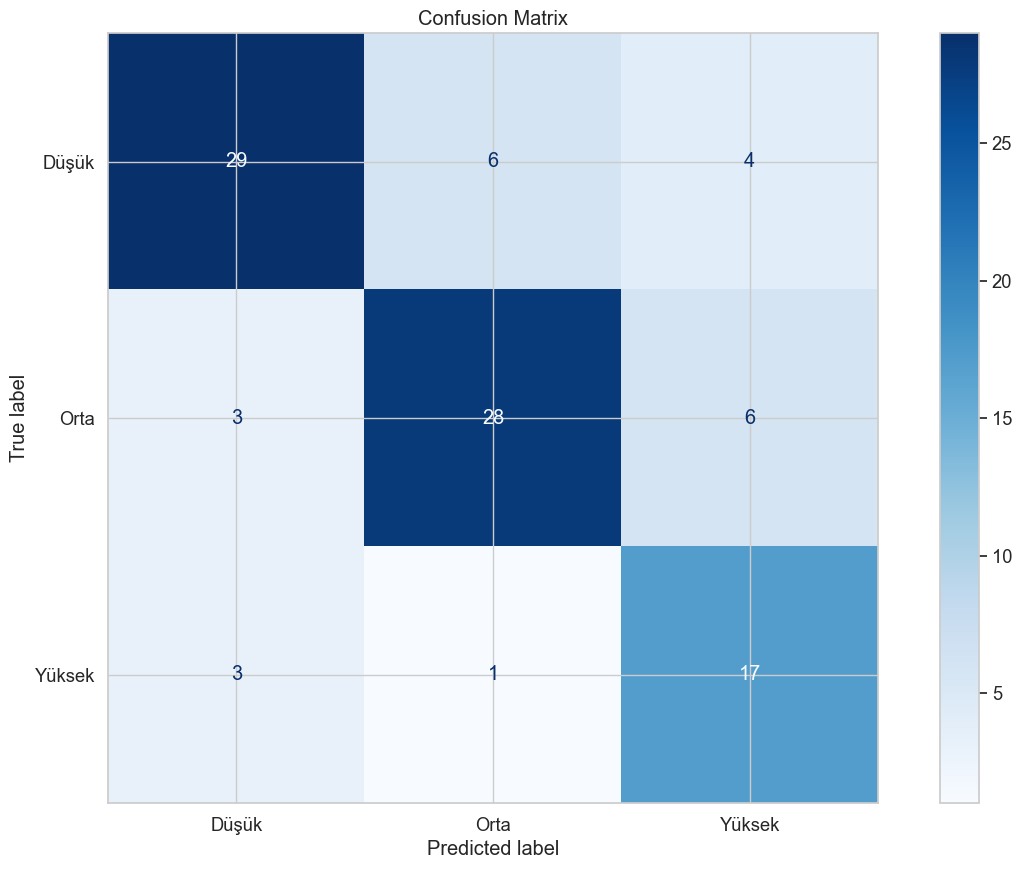

In [39]:
# Get test predictions
test_dataloader = data_module.test_dataloader()
y_true, y_pred = get_test_predictions(model, test_dataloader)

# Define class names
classes = ['Düşük', 'Orta', 'Yüksek']

# Generate confusion matrix
generate_confusion_matrix(y_true, y_pred, classes)
